In [135]:
import numpy as np
from machine import Machine
import random
import torch
from torch import nn
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F


#Parameters
lmd0 = 0.013364
lmd1 = 0.333442
lmdM = 1 - lmd0 - lmd1 #0.6531...
mu0 = 0.125
mu1 = 0.25
muM = 0.5
maintenance_cost = 500


#transition matrices

#transition matrix for a = 0 (no maintenance)
a0_tm = np.array([[lmdM, lmd1, 0, 0, 0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, lmdM, lmd1, 0, 0, 0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, lmdM, lmd1, 0, 0, 0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, lmdM, 0, 0, 0, 0, lmd1, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #current state 8 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) #current state 9 to next state


#transition matrix for a = 1 (maintenance steps)
a1_tm = np.array([[0, 0, 0, 0, 1-lmd0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, 0, 0, 0, 0, 1-lmd0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, 0, 0, 0, 0, 1-lmd0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, 0, 0, 0, 0, 1-lmd0, 0, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [mu1, 0, 0, 0, 0, 0, 0, 0, 1-mu1, 0], #current state 8 to next state
                  [mu0, 0, 0, 0, 0, 0, 0, 0, 0, 1-mu0]]) #current state 9 to next state
tm = [a0_tm,a1_tm]
#r_func = {0:2000,1:1500,2:1000,3:500,4:-maintenance_cost,5:-maintenance_cost,6:-maintenance_cost,7:-maintenance_cost,8:-3000,9:-2000}
r_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}


        


In [156]:
class Machine_env2():

    def __init__(self,tm,r_func,machine):
        self.action_space = [0,1]
        self.state = 0 #Random initialise the start state, assumes uniform distribution for initial state,random.randrange(10)
        self.state_seq = [] #initialise a list that records the actual states
        self.reward_func = r_func
        self.observation_space = 4
        self.transition  = tm
        self.simulator = machine #simulator to generate sensor readings
        self.done = False
        self.steps = 0
        self.fail_flag = False
    
    def sensor(self): # generate observation at state
        sensor_reading = self.simulator.readSensors()
        return sensor_reading
    
    def step(self,action): # simulate movement of states given an action
        self.state_seq.append(self.state) #record current state
        transition_mat_action = self.transition[action]
        #print(f"Transition Prob: {transition_mat_action[self.state]}")
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based
        reward = self.reward_func[nxt_state] #reward for going to next state
        self.state = nxt_state #update state
        self.simulator.curr_state = self.state #update GMM state
        
        while(self.state in [4,5,6,7]): #cumulative reward during maintenance
            transition_mat_action = self.transition[0] #default action 0 in maintenance state
            nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based on prob
            self.state = nxt_state #update state
            self.simulator.curr_state = self.state #update GMM state
            reward+=self.reward_func[nxt_state]
        
        if self.state in [8,9]:
            self.fail_flag = True
        
        self.steps += 1
        
#         if(self.steps == 50):#condition for end of episode
#             self.done = True

#         if (self.state == 0 and self.fail_flag == True) or self.steps > 100:
#             self.done = True
            
        if self.state in [8,9] or self.steps > 100:
            self.done = True

        return reward
    
    def reset(self):
        self.state = 0
        self.fail_flag = False
        #self.state = np.random.randint(0,4,1)[0]
        self.simulator.curr_state = self.state
        self.done = False
        self.steps = 0
        self.state_seq = []
        return 
        

In [157]:
class policy_estimator(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator, self).__init__()
        
        self.lstm = nn.LSTMCell(env.observation_space,128)
        
        self.layer1 = nn.Linear(128,128)
        
        self.layer2 = nn.Linear(128,len(env.action_space))
       
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
        
        output = []
        hx = torch.zeros(1,128)
        cx = torch.zeros(1,128)
        
        if(len(x.size()) == 1): #single tensor ie. [x1,x2,x3,x4]
            x = x.unsqueeze(0)
            #print(x)
            hx, cx = self.lstm(x, (hx, cx))
            output = hx
            #print(output)

        elif(len(x.size()) == 2): #2 dimension
            x = x.unsqueeze(1) #dim = (timestep,batch,features), note batch = 1
#             print(x.size())
            for i in range(x.size()[0]): #loop to simulate recurrent network
                #print(y)
                hx, cx = self.lstm(x[i], (hx, cx))
                output.append(hx)
        
            output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        
        x = F.leaky_relu(output)
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)

        return F.softmax(x,dim = -1)



In [158]:
def normalized_discount_reward(rewards,gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    r = np.array(r)
    mean_rewards=np.mean(r)
    std_rewards=np.std(r)
    norm_discounted_rewards=(r-mean_rewards)/(std_rewards+1e-12)
    return norm_discounted_rewards.tolist()

class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.lstm = nn.LSTMCell(observation_space,128)
        
        self.layer1 = nn.Linear(128, 128)
        self.layer2 = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = torch.FloatTensor(x)
        
        
        output = []
        hx = torch.zeros(1,128)
        cx = torch.zeros(1,128)
        
        if(len(x.size()) == 1): #single tensor ie. [x1,x2,x3,x4]
            x = x.unsqueeze(0)
            #print(x)
            hx, cx = self.lstm(x, (hx, cx))
            output = hx
            #print(output)

        elif(len(x.size()) == 2): #2 dimension
            x = x.unsqueeze(1) #dim = (timestep,batch,features), note batch = 1
#             print(x.size())
            for i in range(x.size()[0]): #loop to simulate recurrent network
                #print(y)
                hx, cx = self.lstm(x[i], (hx, cx))
                output.append(hx)
        
            output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        
        x = F.leaky_relu(output)
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)
        state_value = x
        
        return state_value
    
def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards 
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    
    G = G.to(torch.float32)
    state_vals = state_vals.to(torch.float32)
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
        
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()
    

def stack_state_value(states,stateval_network): #input is a list of observations/states that will be used to train the nn for statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0)
        state_vals.append(stateval_network(state))
    return torch.stack(state_vals).squeeze()

def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): trajectory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''
    
    #store updates
    policy_loss = []
    
    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        #add negative sign since we are performing gradient ascent
        policy_loss.append(-d * lp)
    
    #Backpropagation
    optimizer.zero_grad()
    (sum(policy_loss)/len(policy_loss)).backward()
    optimizer.step()
    
    return sum(policy_loss)

Additional Improvement:
- Recurrent implementation --> action taken by referencing 10 frames behind
- Model does not learn about the maintenance readings = [-1,-1,-1,-1] default action for these states are no action, cost of maintenance is cumulative depending on how long it stays in the maintenance state
- Add batch size which will determine the update frequency of the policy during simulation
- longer episodic update of policy but more of batch update
- Every batch update the input internal states to the next batch is updated


# Monte Carlo

In [159]:
def recurrent_pg_baseline_montecarlo(machine,baseline_net,policy_estimator,episodes,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = [] #Total actual reward for each episode
    batch_rewards = []  #Discounted expected future rewards for each batch
    batch_actions = []
    batch_observation = []
    state_seq = []

    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.parameters(),lr=lr)
    state_val_optimizer = torch.optim.Adam(baseline_net.parameters(),lr=0.001)
    
    action_space = machine.action_space
    
    machine.reset()
    observation = []
    rewards = []
    actions = []
    t = 0
    
    for ep in range(episodes):
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while(not machine.done):
            obs = machine.sensor().tolist() #observation

            observation.append(obs)

            
            action_probs = policy_estimator(observation).detach().numpy()[-1] #convert to numpy and get action prob for the latest

            try:
                action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            except: #in the event converged
                action_probs = np.nan_to_num(action_probs)
                action_probs = np.round(action_probs)
                action = np.random.choice(action_space, p=action_probs)

            print(f"Sensor: {obs}, Action prob: {action_probs}, Action: {action}, state: {machine.state}")

            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action

            rewards.append(r)
            actions.append(action)
            
    
        discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards

        obs_tensor = torch.FloatTensor(observation)
        action_tensor = torch.LongTensor(actions)
        reward_tensor = torch.from_numpy(np.array(discount_r).copy()) #discounted reward G

        #calculate state values 
        state_value_tensor = stack_state_value(np.array(observation),baseline_net)

        #calculate delta or advantage 
        train_value(reward_tensor,state_value_tensor,state_val_optimizer)
        
        try:
            #calculate delta or advantage 
            deltas = [gt - val for gt, val in zip(reward_tensor, state_value_tensor)]
            deltas = torch.tensor(deltas)
        except:
            print("Invalid ep!!")
            continue


        #update policy
        logprob = torch.log(policy_estimator(obs_tensor))
        selected_prob = logprob[np.arange(len(action_tensor)), action_tensor]
        loss = train_policy(deltas, selected_prob, optimizer)

        total_rewards.append(sum(rewards)) #Cumulative reward for this batch
        print(f"Reward for up to this episode {ep} is {total_rewards[-1]}, loss is {loss}")
        print("########################################################################")
        
        
        
#         #Tensorboard params
#         writer.add_scalar("Loss", loss, ep)
#         writer.add_scalar('Rewards',sum(rewards),ep)
#         for name, weight in policy_estimator.network.named_parameters():
#             try:
#                 writer.add_histogram(name,weight, ep)
#             except:
#                 continue
#             if weight.grad != None:
#                 writer.add_histogram(f"{name}.grad",weight.grad, ep)
    
#     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
#     writer.flush()
#     writer.close()
    
    return (total_rewards,batch_actions,state_seq)

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


{0: 1000, 1: 900, 2: 800, 3: 500, 4: -500, 5: -500, 6: -500, 7: -500, 8: -3000, 9: -1000}
Sensor: [0.34916025788626165, 0.6251783781109798, 0.22598626982239872, 0.28586805896524853], Action prob: [0.518087 0.481913], Action: 1, state: 0
Sensor: [0.37273172516190817, 0.6186749127210108, 0.2551294261676798, 0.19745332362381024], Action prob: [0.5185928  0.48140725], Action: 0, state: 0
Sensor: [0.3100771575665453, 0.6031641047225529, 0.18109143810605738, 0.2452699097902455], Action prob: [0.51898    0.48102003], Action: 0, state: 0
Sensor: [0.3446880990050621, 0.6480186341379248, 0.20458838544315902, 0.28408792791157883], Action prob: [0.5192123  0.48078766], Action: 1, state: 0
Sensor: [0.32580295448551666, 0.635130885278904, 0.21105503849309964, 0.2806571787863424], Action prob: [0.5193626 0.4806373], Action: 1, state: 0
Reward for up to this episode 0 is 2000, loss is 0.20972782139018997
########################################################################
Sensor: [0.45288657795810

Sensor: [0.38632806205188097, 0.6317994052667498, 0.19489727615096397, 0.24327049614006285], Action prob: [0.74246657 0.2575334 ], Action: 0, state: 0
Sensor: [0.3858830019258967, 0.6741241159175871, 0.20042370142873986, 0.1968311951000097], Action prob: [0.7416297 0.2583703], Action: 0, state: 1
Sensor: [0.3847579710958005, 0.6447903559188856, 0.23239175073782717, 0.20711882589436897], Action prob: [0.7409136 0.2590864], Action: 0, state: 2
Sensor: [0.35713761704308045, 0.6099829076940829, 0.19914736827566282, 0.2256356880240692], Action prob: [0.73906493 0.26093504], Action: 1, state: 2
Sensor: [0.4079040269677683, 0.646906651662451, 0.22546824297685844, 0.32135116144841136], Action prob: [0.74237233 0.2576276 ], Action: 1, state: 1
Sensor: [0.3903248721125095, 0.6222025639623732, 0.22323133595496095, 0.22637233989588917], Action prob: [0.74218607 0.25781387], Action: 0, state: 0
Sensor: [0.368564771095221, 0.6855665512137916, 0.19736708969014627, 0.25122964661350666], Action prob: [

Sensor: [0.38481019991584847, 0.5913473958803109, 0.18516646094013198, 0.21385338471317322], Action prob: [0.98384976 0.0161502 ], Action: 0, state: 0
Sensor: [0.3628672867754728, 0.6769484317200818, 0.1819513512118389, 0.382305330131906], Action prob: [9.9937373e-01 6.2626973e-04], Action: 0, state: 0
Sensor: [0.4048323270864212, 0.6191005957263436, 0.1989577612861263, 0.25987895627499513], Action prob: [9.9995327e-01 4.6729845e-05], Action: 0, state: 0
Sensor: [0.39526723539338676, 0.6902391582972323, 0.1834538082310777, 0.5790740459471012], Action prob: [9.9999809e-01 1.9645313e-06], Action: 0, state: 0
Sensor: [0.36360960522712604, 0.6401050320258074, 0.22968810766717024, 0.28736371259730864], Action prob: [9.9999976e-01 1.9029312e-07], Action: 0, state: 1
Sensor: [0.3827659663027804, 0.6222795708051666, 0.20787439851226253, 0.3586229099558255], Action prob: [1.0000000e+00 4.2722334e-08], Action: 0, state: 1
Sensor: [0.3650330563673712, 0.6928615632359375, 0.2262381859511275, 0.269

Sensor: [0.36033469351854275, 0.6551972054356758, 0.2118674808104111, 0.2659914182109206], Action prob: [9.999236e-01 7.638829e-05], Action: 0, state: 2
Sensor: [0.4229964268242908, 0.6122942982844285, 0.20903508737220647, 0.19780316629556846], Action prob: [9.999242e-01 7.581860e-05], Action: 0, state: 3
Sensor: [0.2931412644889889, 0.6202529945541052, 0.24229018309281158, 0.2527398324977804], Action prob: [9.9992430e-01 7.5725104e-05], Action: 0, state: 3
Sensor: [0.3441437189175508, 0.6391446287650575, 0.21610303924080698, 0.2535656148624089], Action prob: [9.999244e-01 7.558933e-05], Action: 0, state: 3
Sensor: [0.3861317903378376, 0.6283071806180967, 0.2714162518715768, 0.24024399515680248], Action prob: [9.9992454e-01 7.5481708e-05], Action: 0, state: 3
Sensor: [0.3710367143593288, 0.6436151509977053, 0.4893102479762933, 0.22742181426791178], Action prob: [9.9992454e-01 7.5463926e-05], Action: 0, state: 3
Sensor: [0.455048619624981, 0.15777017287198358, 0.24850614123153913, 0.294

Sensor: [0.3319128181881814, 0.6014907239281271, 0.20042018019691923, 0.21899228331679627], Action prob: [0.9982699  0.00173002], Action: 0, state: 2
Sensor: [0.35668236727784336, 0.6701052739249084, 0.24076716197916936, 0.2725369572315205], Action prob: [0.99825686 0.00174308], Action: 0, state: 2
Sensor: [0.39372258161691714, 0.634937631164032, 0.2074485353978794, 0.24813703793414912], Action prob: [0.9982685  0.00173153], Action: 0, state: 2
Sensor: [0.40780582464847404, 0.575670607589811, 0.20802217647293458, 0.24336710595115077], Action prob: [0.9982633  0.00173672], Action: 0, state: 3
Sensor: [0.376559849913374, 0.6619523869808712, 0.21115718809819728, 0.25036386799320026], Action prob: [0.9982622  0.00173785], Action: 0, state: 3
Sensor: [0.3364150272916402, 0.31420275066290493, 0.21265864676569016, 0.2890891838080699], Action prob: [0.9982705  0.00172952], Action: 0, state: 3
Sensor: [0.34438371684430213, 0.6535809025138221, 0.20131705752930604, 0.258974138674299], Action prob

Sensor: [0.36273492685860925, 0.6100771943758849, 0.20413262372323476, 0.195158729222601], Action prob: [0.9599273  0.04007263], Action: 0, state: 3
Sensor: [0.43468624748435225, 0.627633279706399, 0.238560498336974, 0.216072852244656], Action prob: [0.9597215  0.04027846], Action: 0, state: 3
Sensor: [0.41715756194920106, 0.6212343358862608, 0.24224739296692452, 0.23396527866425854], Action prob: [0.9598994  0.04010055], Action: 0, state: 3
Sensor: [0.4095999870335505, 0.6007067817200845, 0.22443001861328585, 0.23485432171534076], Action prob: [0.959879   0.04012097], Action: 0, state: 3
Sensor: [0.2953157458627629, 0.6543691997397962, 0.48721678696761495, 0.1851837053830086], Action prob: [0.95978737 0.04021261], Action: 0, state: 3
Sensor: [0.36220785526251803, 0.6063665183172576, 0.5288018569978432, 0.2491970116157686], Action prob: [0.9598322  0.04016782], Action: 0, state: 3
Reward for up to this episode 27 is 8800, loss is 1.7517605081123058
#####################################

Sensor: [0.33046679851091354, 0.5972095543196836, 0.2208534492074857, 0.20798982668863158], Action prob: [0.78965867 0.2103413 ], Action: 1, state: 0
Sensor: [0.3806062966545629, 0.6950272401233519, 0.1864301470504614, 0.5881938848626808], Action prob: [0.7888     0.21120001], Action: 0, state: 0
Sensor: [0.3549911083977926, 0.6482447664439253, 0.21215969338697205, 0.3066283974462968], Action prob: [0.79092187 0.20907815], Action: 0, state: 0
Sensor: [0.38795706503749605, 0.6314934088315217, 0.15957326869055205, 0.24961546720912792], Action prob: [0.7893968 0.2106032], Action: 0, state: 0
Sensor: [0.30247837096892777, 0.6403784325089084, 0.23035682912112815, 0.22884866834166986], Action prob: [0.7898296 0.2101704], Action: 0, state: 0
Sensor: [0.30664018275990873, 0.6666284168814316, 0.19147497831985855, 0.23854219606537946], Action prob: [0.7896596  0.21034032], Action: 0, state: 0
Sensor: [0.3956721916025683, 0.6598021887887386, 0.22705592579218586, 0.2781678292399346], Action prob: 

Reward for up to this episode 30 is 15600, loss is -2.4659612208996604
########################################################################
Sensor: [0.30295148898506813, 0.6278398040275733, 0.21148033687462509, 0.26438896245566323], Action prob: [0.56785846 0.43214157], Action: 1, state: 0
Invalid ep!!
Sensor: [0.3758174388645613, 0.6662373773214858, 0.24814180918551793, 0.2969548206706875], Action prob: [0.5654024  0.43459758], Action: 0, state: 0
Sensor: [0.3235418931242022, 0.6457326922127811, 0.2549395188451579, 0.24632726046528744], Action prob: [0.9950524  0.00494766], Action: 0, state: 0
Sensor: [0.3201778737323495, 0.6749877681721514, 0.2079814760695619, 0.29066906697566836], Action prob: [0.99580884 0.00419115], Action: 0, state: 0
Sensor: [0.3101126780807419, 0.6625448472769339, 0.2549652563025813, 0.2529690048256239], Action prob: [0.9956143  0.00438565], Action: 0, state: 1
Sensor: [0.32738072127455936, 0.6340346952610784, 0.22502872711909552, 0.2549359446983721], Actio

C:\Users\overl\AppData\Local\Temp/ipykernel_1740/3329210590.py:69: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(state_vals, G)


Sensor: [0.37537164334972634, 0.6490892148152583, 0.21510944912827443, 0.25363527934131974], Action prob: [0.9085172  0.09148284], Action: 0, state: 0
Sensor: [0.34415977311910684, 0.6362595695661882, 0.18433276084251488, 0.22830480929308444], Action prob: [0.88791656 0.11208336], Action: 1, state: 0
Sensor: [0.3208053062144536, 0.6076659706665409, 0.19532330601740344, 0.2247448431586156], Action prob: [0.8891062  0.11089376], Action: 0, state: 0
Sensor: [0.3570079881026378, 0.6291086487443397, 0.2227925547381648, 0.23992629005409152], Action prob: [0.88854426 0.11145575], Action: 1, state: 1
Sensor: [0.3632177873745113, 0.6607001035582629, 0.2373057392448475, 0.26944203834752745], Action prob: [0.88865834 0.11134161], Action: 0, state: 0
Sensor: [0.317833253803838, 0.6174954908782209, 0.2510967330713904, 0.25315829206933715], Action prob: [0.8887529 0.1112471], Action: 0, state: 1
Sensor: [0.39053070611205737, 0.6747904302155624, 0.2234894445222599, 0.26475080689576436], Action prob: 

Sensor: [0.3262539292660452, 0.6170964015097069, 0.24921538265007687, 0.2549583620497934], Action prob: [0.70905656 0.29094344], Action: 1, state: 0
Sensor: [0.39510453273824164, 0.5970670434365963, 0.2311941421377801, 0.26403924929308314], Action prob: [0.7091056  0.29089436], Action: 0, state: 0
Sensor: [0.33759149578902653, 0.6208967726269683, 0.1943545852482238, 0.27426438149187304], Action prob: [0.709189   0.29081103], Action: 0, state: 1
Sensor: [0.3249878282893473, 0.6648569821663309, 0.2331632149534352, 0.2702147321630541], Action prob: [0.7090988  0.29090112], Action: 1, state: 1
Sensor: [0.3731566438761066, 0.6741485379145189, 0.1905282620467632, 0.1982826762000101], Action prob: [0.7091312  0.29086882], Action: 0, state: 0
Sensor: [0.285937548045727, 0.6516532974227095, 0.18036340996973418, 0.3181709758264401], Action prob: [0.7091944 0.2908056], Action: 1, state: 0
Sensor: [0.35452522250169494, 0.6231281355199708, 0.22650206134451573, 0.285732223409326], Action prob: [0.70

Sensor: [0.40584592393974384, 0.7082303582518157, 0.2812616586259122, 0.2565542000565678], Action prob: [0.6202265  0.37977347], Action: 0, state: 0
Sensor: [0.4024326272179246, 0.6310185761493754, 0.26139228411834725, 0.3072033670583103], Action prob: [0.62033004 0.3796699 ], Action: 0, state: 0
Sensor: [0.35618650342565134, 0.6351948102700584, 0.18946208846736026, 0.300151620103747], Action prob: [0.62036335 0.37963668], Action: 0, state: 0
Sensor: [0.3293998953595464, 0.6139661929422536, 0.21110640444988624, 0.25715298218249244], Action prob: [0.6203127  0.37968725], Action: 0, state: 0
Sensor: [0.35721007417372963, 0.6498084435131743, 0.2291002006029846, 0.23362004933624628], Action prob: [0.62024266 0.37975737], Action: 1, state: 1
Sensor: [0.35171401954162107, 0.6027713934124593, 0.20134461663463554, 0.27613826198563796], Action prob: [0.6203304  0.37966964], Action: 0, state: 0
Sensor: [0.324442882491096, 0.6609756842930238, 0.20736202914087215, 0.24421270160332145], Action prob

Sensor: [0.3264143315575809, 0.6034065304430002, 0.2297636731576922, 0.19745628318670155], Action prob: [0.57773525 0.42226475], Action: 1, state: 0
Sensor: [0.42384966441433053, 0.6491402397904279, 0.23559338665581148, 0.22526804991956267], Action prob: [0.57761884 0.4223812 ], Action: 0, state: 0
Sensor: [0.38070013233384287, 0.6609539115384502, 0.23644525974462796, 0.275153442544836], Action prob: [0.5777352 0.4222648], Action: 1, state: 0
Sensor: [0.3312736560098893, 0.6287162100115702, 0.21003736441939957, 0.19728041585003978], Action prob: [0.5777576  0.42224237], Action: 0, state: 0
Reward for up to this episode 42 is 20300, loss is -3.1376932720544137
########################################################################
Sensor: [0.2981930299866967, 0.6181106439260949, 0.22913451359029272, 0.27619477386729435], Action prob: [0.56397074 0.4360293 ], Action: 1, state: 0
Sensor: [0.37214937244910223, 0.6554155230612477, 0.26833872222990673, 0.28867093783476083], Action prob: [0.

Sensor: [0.37015706801680887, 0.6328614071237447, 0.21509112335260722, 0.26586649561561376], Action prob: [0.4213138  0.57868624], Action: 1, state: 0
Sensor: [0.3803270788364004, 0.6645410540312994, 0.22782981374003713, 0.23483192658175553], Action prob: [0.42130795 0.578692  ], Action: 0, state: 0
Sensor: [0.3512435549560975, 0.6090080978117136, 0.22776343860480813, 0.43050620049653077], Action prob: [0.42136368 0.57863635], Action: 0, state: 0
Sensor: [0.3430847039367673, 0.6242797186246352, 0.22452937791606314, 0.2204191835433387], Action prob: [0.42127636 0.57872367], Action: 1, state: 0
Sensor: [0.3407510520931023, 0.6175185153074831, 0.22982203219362513, 0.545348810711832], Action prob: [0.42141646 0.5785836 ], Action: 0, state: 0
Sensor: [0.37920724052065213, 0.6428045126986321, 0.22821084880065048, 0.26204893022434317], Action prob: [0.4212846 0.5787154], Action: 0, state: 0
Sensor: [0.35888594307207833, 0.6601997022477253, 0.2271826158444918, 0.23989219516728083], Action prob

Sensor: [0.3665092382155646, 0.6156428914956856, 0.22657522614449152, 0.24007717932986258], Action prob: [0.40257114 0.59742886], Action: 1, state: 1
Sensor: [0.41074791170430286, 0.6774459425945151, 0.19792341994412757, 0.25164542167965087], Action prob: [0.40256545 0.5974346 ], Action: 1, state: 0
Sensor: [0.36061828580074445, 0.6833511963129221, 0.22229817450869788, 0.29933373526080237], Action prob: [0.40256226 0.59743774], Action: 1, state: 0
Sensor: [0.2671116563000683, 0.6102634982064581, 0.1798156468528394, 0.26076543008624753], Action prob: [0.4024912 0.5975087], Action: 1, state: 0
Sensor: [0.3492881690660657, 0.6608114008110192, 0.2270180695177611, 0.5498493621389948], Action prob: [0.40270138 0.5972986 ], Action: 1, state: 0
Sensor: [0.31480011687750364, 0.591994383759961, 0.20457761322959137, 0.24598635348377], Action prob: [0.40243322 0.5975667 ], Action: 1, state: 0
Sensor: [0.38695626448232273, 0.6904624549272432, 0.3859743926525986, 0.2685318916569622], Action prob: [0

Sensor: [0.3298109673076727, 0.6426760540313254, 0.22665244773259915, 0.23637951717939196], Action prob: [0.40061852 0.59938145], Action: 1, state: 0
Sensor: [0.3560023012367424, 0.6441514440175816, 0.20504715149917782, 0.27713045183327684], Action prob: [0.40061143 0.5993886 ], Action: 1, state: 0
Sensor: [0.3884652371553124, 0.6546715929769225, 0.21082374763222517, 0.2673197642164898], Action prob: [0.40059814 0.59940183], Action: 1, state: 0
Sensor: [0.3641769005213495, 0.6040586592783475, 0.23136545033607858, 0.41838132676818124], Action prob: [0.40059    0.59940994], Action: 1, state: 0
Sensor: [0.348078146598401, 0.6155133744224793, 0.2190117006783928, 0.2599698348040135], Action prob: [0.40055746 0.59944254], Action: 1, state: 0
Sensor: [0.36162448829102495, 0.6101819106121815, 0.24982883952675816, 0.2701219759857706], Action prob: [0.40062425 0.5993758 ], Action: 1, state: 0
Sensor: [0.3724365268531778, 0.6770624951591355, 0.2129317869250945, 0.2447461225277347], Action prob: [

Sensor: [0.3621760391358772, 0.6241871145124565, 0.2306785563307829, 0.6146064680014017], Action prob: [0.4005702  0.59942985], Action: 1, state: 0
Sensor: [0.3747295351849052, 0.6435009562921351, 0.14456477671318801, 0.3079670236690928], Action prob: [0.4004875 0.5995125], Action: 0, state: 0
Sensor: [0.35395073863727267, 0.6512660724060184, 0.24333365069305782, 0.19224616959115007], Action prob: [0.40062612 0.5993739 ], Action: 0, state: 1
Sensor: [0.40446342961503884, 0.43213744943498833, 0.21141127699651263, 0.23003866899718645], Action prob: [0.40065038 0.59934956], Action: 1, state: 2
Sensor: [0.3348517870863456, 0.5238144558266882, 0.19050935632239507, 0.35492704193944286], Action prob: [0.40070578 0.5992942 ], Action: 1, state: 1
Sensor: [0.34878786586717714, 0.6512138383369831, 0.21509079970137862, 0.2652321611133863], Action prob: [0.40061578 0.5993842 ], Action: 0, state: 0
Sensor: [0.3284142554809508, 0.6201656042400752, 0.24208538912283406, 0.26367761433572073], Action pro

Sensor: [0.32777940177311204, 0.6129740138363263, 0.21254958694227932, 0.19831768771800456], Action prob: [0.41890293 0.58109707], Action: 0, state: 0
Sensor: [0.3288516303465419, 0.6515413154813707, 0.20759632628621857, 0.2385640354823203], Action prob: [0.4189836 0.5810163], Action: 0, state: 0
Sensor: [0.42289454106677987, 0.6873542761511529, 0.21937691288486602, 0.26527285421919145], Action prob: [0.41896665 0.58103335], Action: 1, state: 0
Sensor: [0.382408598185842, 0.683478986038465, 0.19232009732428054, 0.5666889539612118], Action prob: [0.41891187 0.5810881 ], Action: 1, state: 0
Sensor: [0.3764955385723085, 0.6338366070431428, 0.2079896667865067, 0.22666692983510212], Action prob: [0.41877222 0.5812278 ], Action: 0, state: 0
Sensor: [0.32420953397773694, 0.6436831724221628, 0.20886436546552303, 0.2744807252087333], Action prob: [0.41897038 0.5810296 ], Action: 1, state: 0
Sensor: [0.31259607713805077, 0.6012159204530657, 0.2249401789270937, 0.26575554793315886], Action prob: 

Sensor: [0.3168222812121086, 0.6623444454053281, 0.21654514626243798, 0.23202515491773645], Action prob: [0.41828072 0.5817193 ], Action: 1, state: 0
Sensor: [0.37541442719800977, 0.6290516791961056, 0.2475991371427712, 0.27693147505806], Action prob: [0.41829097 0.581709  ], Action: 1, state: 0
Sensor: [0.3288292933121731, 0.6623148407468432, 0.21371264353558006, 0.22509122279821317], Action prob: [0.41824663 0.5817533 ], Action: 1, state: 0
Sensor: [0.3931963653555379, 0.6684938023929259, 0.1950178755277355, 0.2517230689666869], Action prob: [0.41830426 0.58169574], Action: 0, state: 0
Sensor: [0.4115842539152734, 0.6109436952825655, 0.2268374924971643, 0.2350238740581905], Action prob: [0.41827074 0.58172923], Action: 0, state: 0
Sensor: [0.34682530789323424, 0.7042426011769488, 0.17313138597349226, 0.2632000089470857], Action prob: [0.41828582 0.58171415], Action: 0, state: 0
Sensor: [0.2956743579787321, 0.6236009218950814, 0.18674637854640913, 0.2934300802217391], Action prob: [0.

Sensor: [0.38884402801880136, 0.46742215443622037, 0.19810303292758652, 0.3446094826833051], Action prob: [0.4149495 0.5850505], Action: 0, state: 0
Sensor: [0.30500462594824135, 0.6137276513535511, 0.21807085520660857, 0.2942888453279744], Action prob: [0.41498417 0.5850158 ], Action: 1, state: 1
Sensor: [0.3628398500619968, 0.6579060659896309, 0.207249164747908, 0.29183688912627637], Action prob: [0.41499072 0.5850093 ], Action: 1, state: 0
Sensor: [0.3700156981887301, 0.6679476934955053, 0.2340511863221846, 0.23683826523601154], Action prob: [0.41496286 0.58503705], Action: 1, state: 0
Sensor: [0.34717892928056826, 0.6803183889684079, 0.16979578750753382, 0.2584617305605786], Action prob: [0.41497552 0.58502454], Action: 1, state: 0
Sensor: [0.36657071022651777, 0.7244076529201796, 0.21986256718194064, 0.30512741171426616], Action prob: [0.4150005  0.58499944], Action: 0, state: 0
Sensor: [0.3764270772759536, 0.5991545186932526, 0.19388034223092676, 0.1737197410995257], Action prob:

Sensor: [0.311890006165246, 0.6591974018963558, 0.1881251338002897, 0.26842969731628435], Action prob: [0.4105968 0.5894033], Action: 1, state: 0
Sensor: [0.39106743468025407, 0.6434766973817505, 0.25572242699643405, 0.21325890603041722], Action prob: [0.4105941  0.58940595], Action: 1, state: 0
Sensor: [0.3830861798294368, 0.6376464132463947, 0.1997828124328665, 0.3876076083968959], Action prob: [0.41062394 0.58937603], Action: 0, state: 0
Sensor: [0.28581233586191024, 0.6881920586592647, 0.2592340966951033, 0.3153196646353328], Action prob: [0.41056478 0.5894353 ], Action: 0, state: 0
Sensor: [0.3308830934552868, 0.5940538869163132, 0.26013326224328853, 0.25496583771373527], Action prob: [0.41055283 0.5894472 ], Action: 1, state: 0
Sensor: [0.36316389031573554, 0.6593251574631349, 0.24167435586703462, 0.3012489080430573], Action prob: [0.41060737 0.58939266], Action: 0, state: 0
Sensor: [0.34366581600013635, 0.5773454059295032, 0.2361728818026587, 0.23784592999333104], Action prob: [

Sensor: [0.4055873414545119, 0.597198780165022, 0.21858073589297833, 0.22695518152399438], Action prob: [0.4106077  0.58939236], Action: 1, state: 0
Sensor: [0.33489195072332417, 0.632319307783397, 0.19839760444968355, 0.2732421461978711], Action prob: [0.41059455 0.5894054 ], Action: 1, state: 0
Sensor: [0.3051359851788926, 0.6684418898868515, 0.23370548368372687, 0.22242397921389617], Action prob: [0.41057897 0.58942103], Action: 0, state: 0
Sensor: [0.3924478095669364, 0.6225839499657098, 0.19528779195048251, 0.2820688031339174], Action prob: [0.41061202 0.58938795], Action: 0, state: 1
Sensor: [0.3305606412273043, 0.6136408601765959, 0.20122264198288492, 0.2600078710520729], Action prob: [0.41057914 0.5894209 ], Action: 1, state: 1
Sensor: [0.34663575300062627, 0.6045976350752331, 0.21657009679106126, 0.2620987665243718], Action prob: [0.41059628 0.5894038 ], Action: 0, state: 0
Sensor: [0.34410217104559854, 0.653624920261209, 0.21664580130074834, 0.259660987093352], Action prob: [

Sensor: [0.3316654738583045, 0.6449726438991502, 0.24405630427914937, 0.30240380876815354], Action prob: [0.4124111  0.58758897], Action: 0, state: 0
Sensor: [0.30197197080842403, 0.6441966430366366, 0.20051233969174154, 0.26310848946461934], Action prob: [0.41239297 0.58760697], Action: 1, state: 1
Sensor: [0.3580544404593245, 0.6166428137927108, 0.19458616338873386, 0.23326094430935418], Action prob: [0.41241547 0.5875845 ], Action: 1, state: 0
Sensor: [0.3545577781563998, 0.6683812468507669, 0.22106687847023423, 0.25228682404788505], Action prob: [0.4124249 0.587575 ], Action: 0, state: 0
Sensor: [0.3728471752970384, 0.7065740337695618, 0.18385185382175223, 0.2603958006175097], Action prob: [0.41242442 0.5875756 ], Action: 0, state: 1
Sensor: [0.3945437191165511, 0.6379319643832988, 0.2551591045864646, 0.1987048155492848], Action prob: [0.4123974 0.5876026], Action: 0, state: 1
Sensor: [0.3366539062844583, 0.614903528448494, 0.36853627656903504, 0.24351254980075016], Action prob: [0

Sensor: [0.3373353293525739, 0.6428086072211835, 0.2332923079057149, 0.19310504339953571], Action prob: [0.41241246 0.58758754], Action: 0, state: 0
Sensor: [0.3130723816232159, 0.6218901028010682, 0.21416057737518904, 0.32571343668751573], Action prob: [0.41242227 0.5875777 ], Action: 1, state: 1
Sensor: [0.30887056155064696, 0.6559133538506465, 0.17660574767654666, 0.2161819731635845], Action prob: [0.41239703 0.587603  ], Action: 0, state: 0
Sensor: [0.3701864754754322, 0.6515002469270912, 0.1920241251952591, 0.2722929489805513], Action prob: [0.41244128 0.5875587 ], Action: 0, state: 1
Sensor: [0.33434471249065273, 0.6756695501058106, 0.1949077976080279, 0.27845380072438664], Action prob: [0.41241693 0.587583  ], Action: 1, state: 1
Sensor: [0.35602215072896587, 0.5791482082699116, 0.2318356656134946, 0.22278615497825538], Action prob: [0.41239253 0.5876075 ], Action: 1, state: 0
Sensor: [0.3072448669467763, 0.6250510250024881, 0.23230642158667694, 0.26608052783768044], Action prob

Reward for up to this episode 57 is 10200, loss is -1.5856212805787608
########################################################################
Sensor: [0.34971370569541527, 0.6537721682678151, 0.23167055331369132, 0.2419524245793253], Action prob: [0.5367699  0.46323004], Action: 0, state: 0
Sensor: [0.3195516093016114, 0.6700644838951472, 0.25472570797451133, 0.2816966249723511], Action prob: [0.9901038  0.00989619], Action: 0, state: 0
Sensor: [0.3359686049344936, 0.6885583519313734, 0.24888860813092883, 0.28414372573277386], Action prob: [0.9952683  0.00473166], Action: 0, state: 0
Sensor: [0.3704918958234289, 0.362838001594041, 0.21499213880467388, 0.20529326690139738], Action prob: [0.4522285 0.5477715], Action: 0, state: 0
Sensor: [0.38846252962205097, 0.7031630108568375, 0.20263734339375883, 0.26885759149906674], Action prob: [0.42707404 0.5729259 ], Action: 1, state: 0
Sensor: [0.281404081430788, 0.6251384136381293, 0.17508935294634814, 0.25996815981485477], Action prob: [0.42

Reward for up to this episode 58 is 28300, loss is -4.405527932225647
########################################################################
Sensor: [0.36901714788613893, 0.5581777539814096, 0.19882289877690995, 0.22498858963227605], Action prob: [0.536547   0.46345297], Action: 0, state: 0
Invalid ep!!
Sensor: [0.3718943493621141, 0.6395514390488244, 0.20177865854069088, 0.2161135500780919], Action prob: [0.53618884 0.4638112 ], Action: 1, state: 0
Sensor: [0.40249496182033145, 0.6097194750826187, 0.17186138040532056, 0.30374714879223524], Action prob: [0.9945245  0.00547548], Action: 0, state: 0
Sensor: [0.3417137252172773, 0.623665168092685, 0.22384521540380678, 0.23963512863660447], Action prob: [0.9972953  0.00270463], Action: 0, state: 0
Sensor: [0.33955946672547993, 0.6517060618953263, 0.24020752818721297, 0.27259400691769087], Action prob: [0.47533423 0.5246658 ], Action: 1, state: 1
Sensor: [0.4203657210727851, 0.6615646495832188, 0.24808676785936395, 0.2639139347843251], Ac

Sensor: [0.4201609531974202, 0.6258223053557255, 0.22475729294756222, 0.2332798617425851], Action prob: [0.44738355 0.5526164 ], Action: 0, state: 1
Sensor: [0.3734669450824932, 0.6758126322053479, 0.5220968585204788, 0.28613814136455384], Action prob: [0.44739076 0.5526093 ], Action: 1, state: 1
Sensor: [0.38584685166848376, 0.6677546919411423, 0.19420148601765555, 0.23579623843540193], Action prob: [0.44736335 0.5526367 ], Action: 0, state: 0
Sensor: [0.30091567365521893, 0.6376393504117039, 0.1998531074603641, 0.2409561382001965], Action prob: [0.4473659 0.5526341], Action: 0, state: 0
Sensor: [0.3104605612536363, 0.6617620081177866, 0.2540484976216272, 0.23927597990259777], Action prob: [0.4473762  0.55262387], Action: 1, state: 0
Sensor: [0.38766406292138833, 0.6972176174241138, 0.23243627323853325, 0.25996668321218824], Action prob: [0.4474006 0.5525994], Action: 1, state: 0
Sensor: [0.38233818518835744, 0.5924625716201587, 0.20277014628445758, 0.24164867839027426], Action prob: 

Sensor: [0.3364614704219135, 0.6225428330667254, 0.2042221088430668, 0.4215304395167957], Action prob: [0.35376513 0.64623487], Action: 1, state: 0
Sensor: [0.2759177951995752, 0.6172983696568417, 0.21595629095852903, 0.2722396005242449], Action prob: [0.3536909  0.64630914], Action: 1, state: 0
Sensor: [0.4146149984640997, 0.5244935700699707, 0.20866984881858214, 0.27771841717744045], Action prob: [0.35373026 0.64626974], Action: 0, state: 0
Sensor: [0.34615335624477317, 0.6667613370048423, 0.1792837925226628, 0.2902557044127496], Action prob: [0.3537454 0.6462546], Action: 1, state: 0
Sensor: [0.3034618885170242, 0.6269673581335379, 0.18023136571875326, 0.3699265599025223], Action prob: [0.3537404  0.64625967], Action: 1, state: 0
Sensor: [0.3683987064749726, 0.6776507552669594, 0.20611322767753956, 0.22794285561597963], Action prob: [0.35372975 0.6462702 ], Action: 1, state: 0
Sensor: [0.33748124398881807, 0.6275939419808633, 0.1901016478615794, 0.2706815648281981], Action prob: [0.

Sensor: [0.3736519787632441, 0.6543504913062922, 0.22749854946796028, 0.25644502522844403], Action prob: [0.35372183 0.6462782 ], Action: 0, state: 1
Sensor: [0.34928811957388534, 0.6238270952145577, 0.19029291304563706, 0.24601294476896957], Action prob: [0.3537156 0.6462844], Action: 0, state: 2
Reward for up to this episode 62 is 39700, loss is -3.2857692750700274
########################################################################
Sensor: [0.3261912830446832, 0.6448283340759882, 0.18389568824456945, 0.4221817539347788], Action prob: [0.5200482 0.4799519], Action: 0, state: 0
Sensor: [0.3535880437768173, 0.679745060747152, 0.24496359442479954, 0.22415473445233816], Action prob: [0.9983278  0.00167226], Action: 0, state: 0
Sensor: [0.3643312103700212, 0.6545517829617075, 0.23250180198564974, 0.23728848112955517], Action prob: [9.9908686e-01 9.1309863e-04], Action: 0, state: 0
Sensor: [0.3316519226288267, 0.6439008055890059, 0.21950799699428397, 0.2829841011606744], Action prob: [

Sensor: [0.30828075442066233, 0.6385017199567035, 0.20131115061668672, 0.246369617822792], Action prob: [0.23745258 0.76254743], Action: 0, state: 0
Sensor: [0.3624560673460879, 0.6156467547504018, 0.2202785168858793, 0.19020105613126748], Action prob: [0.23746046 0.7625395 ], Action: 1, state: 0
Sensor: [0.383466792841167, 0.6806880283284006, 0.21752998674459703, 0.250044845406243], Action prob: [0.23749776 0.76250225], Action: 1, state: 0
Sensor: [0.3033845635494289, 0.6365132255106943, 0.2237613512468917, 0.269020072158017], Action prob: [0.23744203 0.762558  ], Action: 1, state: 0
Sensor: [0.31750705842420873, 0.6731303742152327, 0.19596297478426558, 0.25388554272422564], Action prob: [0.23747294 0.7625271 ], Action: 1, state: 0
Sensor: [0.3227930480581374, 0.5750235557678925, 0.19284734863289868, 0.27143192206468736], Action prob: [0.23745444 0.7625455 ], Action: 1, state: 0
Sensor: [0.38011559974621584, 0.6394444264924586, 0.237106899731469, 0.27135169206075177], Action prob: [0.

Sensor: [0.2900513009446851, 0.6662619265826679, 0.1587977695607633, 0.2536271946725976], Action prob: [0.17881845 0.8211815 ], Action: 1, state: 0
Sensor: [0.3206816209155232, 0.6486968467360721, 0.2138016926703487, 0.24335217205656864], Action prob: [0.17883246 0.8211675 ], Action: 1, state: 0
Sensor: [0.3304612772465323, 0.6012253037565564, 0.25200340371517566, 0.3088959472191899], Action prob: [0.17881928 0.8211807 ], Action: 1, state: 0
Sensor: [0.3197425082606282, 0.6592285634713594, 0.20339332307481875, 0.2595605619673937], Action prob: [0.17881039 0.82118964], Action: 0, state: 0
Sensor: [0.37512066122117993, 0.6850133018004335, 0.3533398661799732, 0.2607490476092938], Action prob: [0.17882799 0.821172  ], Action: 1, state: 0
Sensor: [0.35546300047394574, 0.5888992910212705, 0.22372472666520135, 0.22275486667619973], Action prob: [0.17875762 0.82124233], Action: 1, state: 0
Sensor: [0.30879230473768765, 0.6548978817150817, 0.22035811334159394, 0.24633707211220507], Action prob:

Sensor: [0.3784586786277326, 0.6289230314151906, 0.24212312012903459, 0.2973382402041607], Action prob: [0.514285 0.485715], Action: 0, state: 0
Sensor: [0.3137541763227082, 0.5903415232409946, 0.22145446095414822, 0.2886177651201344], Action prob: [9.9966860e-01 3.3145145e-04], Action: 0, state: 0
Sensor: [0.3899500554951493, 0.608629134045814, 0.2195487827049186, 0.29599814347227293], Action prob: [9.9972266e-01 2.7727781e-04], Action: 0, state: 0
Sensor: [0.3248462248119108, 0.6477961689616903, 0.22285056588800195, 0.2978244550113598], Action prob: [0.23942126 0.7605787 ], Action: 1, state: 0
Sensor: [0.37250955837298927, 0.6187530930653684, 0.18808635322662565, 0.4381743904771953], Action prob: [0.23224586 0.7677541 ], Action: 0, state: 0
Sensor: [0.42692033560992215, 0.6560008005537791, 0.4864911145293847, 0.18832961174410395], Action prob: [0.22771764 0.77228236], Action: 1, state: 1
Sensor: [0.3472796377223622, 0.623284768889921, 0.20278347702029537, 0.2441246251586557], Action 

Sensor: [0.4026521657484393, 0.615772127746694, 0.22208034443667365, 0.17391912042851781], Action prob: [0.28742662 0.71257335], Action: 1, state: 0
Sensor: [0.3880746634105299, 0.6559629063357116, 0.20478510146365198, 0.23772502616248828], Action prob: [0.28744447 0.71255547], Action: 0, state: 0
Sensor: [0.37669872549290356, 0.6253695056793214, 0.19173610214407913, 0.234675189141929], Action prob: [0.28741542 0.71258456], Action: 0, state: 1
Sensor: [0.42495242255956256, 0.6639886866698157, 0.2047179343967477, 0.2818236472717437], Action prob: [0.28747505 0.712525  ], Action: 1, state: 2
Sensor: [0.32290244104837124, 0.6804010812913391, 0.20399381656259744, 0.2707800333296803], Action prob: [0.2873941 0.7126059], Action: 1, state: 1
Sensor: [0.3684063493135661, 0.7212057680176033, 0.22091504201427198, 0.25660552451967916], Action prob: [0.28744277 0.7125572 ], Action: 1, state: 0
Sensor: [0.3461546241889991, 0.6651362554205803, 0.20618669344254154, 0.22099401787123235], Action prob: 

Sensor: [0.3391105232401429, 0.71514854004745, 0.2061732452715243, 0.27368500058329004], Action prob: [0.34278244 0.65721756], Action: 1, state: 0
Sensor: [0.34669633897568863, 0.5916611674308687, 0.22473869623218098, 0.2762748027721881], Action prob: [0.34274083 0.65725917], Action: 0, state: 0
Sensor: [0.39478234304697496, 0.6474277813111988, 0.22507919246297797, 0.28904180838634824], Action prob: [0.3427963 0.6572038], Action: 0, state: 1
Sensor: [0.3805100651012361, 0.6599185467773409, 0.23094597590830032, 0.24422475968344984], Action prob: [0.34275264 0.6572473 ], Action: 0, state: 2
Sensor: [0.37053002852377026, 0.6959236169929861, 0.2516618736382935, 0.2519847509262358], Action prob: [0.3427678  0.65723217], Action: 1, state: 2
Sensor: [0.3847602375706187, 0.5024695317255551, 0.22022028043028408, 0.2576657722060269], Action prob: [0.3427211  0.65727884], Action: 0, state: 1
Sensor: [0.38715557363800507, 0.6515156327162007, 0.2531125429015556, 0.2811861723262487], Action prob: [0

Sensor: [0.3236950159799912, 0.6867874080230021, 0.2441941183676164, 0.24446716907396276], Action prob: [0.41350722 0.58649284], Action: 1, state: 0
Sensor: [0.32121554502756366, 0.6388525413234304, 0.23010736220034653, 0.26902597930255995], Action prob: [0.41353756 0.5864625 ], Action: 1, state: 0
Sensor: [0.3283724837355094, 0.6702534865703077, 0.23003952878784403, 0.24018822373188395], Action prob: [0.4135452  0.58645475], Action: 0, state: 0
Sensor: [0.3606862696939924, 0.5989880090352161, 0.21204245610313263, 0.24902658950481146], Action prob: [0.41354412 0.5864559 ], Action: 1, state: 0
Sensor: [0.32474440908906327, 0.5998041305011113, 0.20343533129742497, 0.22656140769167676], Action prob: [0.41353324 0.5864667 ], Action: 1, state: 0
Sensor: [0.35373584178655976, 0.6370813119875117, 0.1830245096120103, 0.22357930098303863], Action prob: [0.41355672 0.5864432 ], Action: 1, state: 0
Sensor: [0.4128226918758363, 0.676218952410391, 0.3778046831594716, 0.29622358526549925], Action pr

Sensor: [0.2801750634498915, 0.6348413941163715, 0.219085097119853, 0.23643784488771827], Action prob: [0.44831306 0.551687  ], Action: 0, state: 0
Sensor: [0.349367610905328, 0.6176480466887213, 0.23212576873192606, 0.2492691762022801], Action prob: [0.44834664 0.5516534 ], Action: 0, state: 1
Sensor: [0.3381541986239019, 0.633496075902153, 0.1975460754286535, 0.22567768992172713], Action prob: [0.4483352 0.5516648], Action: 1, state: 2
Sensor: [0.40980399260178146, 0.5772560398794085, 0.23863575626448733, 0.27724396330868123], Action prob: [0.44836104 0.55163896], Action: 1, state: 1
Sensor: [0.34934179490958944, 0.6311100909650819, 0.21044498511356827, 0.22371221767402694], Action prob: [0.44833282 0.55166715], Action: 1, state: 0
Sensor: [0.3218073945728376, 0.6489923844747507, 0.23543737566778086, 0.244143413475662], Action prob: [0.44833958 0.55166036], Action: 0, state: 0
Sensor: [0.4224370424949643, 0.6646357131737459, 0.2291387122258231, 0.29004989224618194], Action prob: [0.4

Sensor: [0.3231175952781602, 0.7045897344645569, 0.17721641839900312, 0.24909907709221557], Action prob: [0.47659093 0.52340907], Action: 1, state: 0
Sensor: [0.40478584967857933, 0.6753969148062955, 0.22761398307904973, 0.21707364287839445], Action prob: [0.47659862 0.52340144], Action: 0, state: 0
Sensor: [0.3806350548278183, 0.6237276796619942, 0.2270522033022101, 0.2592754583456894], Action prob: [0.47659254 0.52340746], Action: 0, state: 1
Sensor: [0.31234857178850867, 0.6270301923551231, 0.2055039734410596, 0.2085880884855267], Action prob: [0.47656894 0.523431  ], Action: 0, state: 1
Sensor: [0.31723744950625327, 0.5866076635481399, 0.2199810861149464, 0.28567664359223754], Action prob: [0.47658783 0.5234121 ], Action: 0, state: 1
Sensor: [0.38638033227171276, 0.649405288586027, 0.4347918363057204, 0.2665152719541651], Action prob: [0.47660926 0.5233907 ], Action: 0, state: 2
Sensor: [0.37360116236435803, 0.6148981617797066, 0.20594414817331652, 0.27475352660555175], Action prob

Sensor: [0.28818525362835723, 0.6281230809016409, 0.22759603875388076, 0.23526490963232558], Action prob: [0.47657204 0.523428  ], Action: 1, state: 1
Sensor: [0.40383435148237745, 0.6125040073162167, 0.2115302308929009, 0.27956719031292243], Action prob: [0.47660604 0.523394  ], Action: 1, state: 0
Sensor: [0.4097761886293566, 0.6245311384641856, 0.20264617351154704, 0.21425251735517242], Action prob: [0.47659093 0.52340907], Action: 1, state: 0
Sensor: [0.40750298855068257, 0.605122000258255, 0.25430599244491575, 0.28010792107025145], Action prob: [0.47660318 0.5233968 ], Action: 1, state: 0
Sensor: [0.394213007668026, 0.6119610146972898, 0.1943588316576369, 0.21952695261960084], Action prob: [0.47658366 0.5234164 ], Action: 1, state: 0
Sensor: [0.38637879575628015, 0.6751162231624159, 0.23278814314334295, 0.4450382806721042], Action prob: [0.4766407  0.52335924], Action: 1, state: 0
Sensor: [0.28614332033081075, 0.6540872703665511, 0.20430789541146974, 0.37501386185333085], Action p

Sensor: [0.383334614517528, 0.6494668712724215, 0.20007446126586573, 0.31929182284667795], Action prob: [0.51170707 0.488293  ], Action: 0, state: 0
Sensor: [0.3851351769408702, 0.6425916629675549, 0.20534049889028685, 0.25273289468445426], Action prob: [0.5116946 0.4883054], Action: 0, state: 0
Sensor: [0.2915620074575948, 0.6501786793905501, 0.2236163426057037, 0.25471250002294865], Action prob: [0.51168627 0.4883137 ], Action: 0, state: 1
Sensor: [0.3634674744154152, 0.6536818486578619, 0.26304144935049284, 0.24393754278076138], Action prob: [0.5116972 0.4883028], Action: 0, state: 1
Sensor: [0.5768957059543992, 0.6040625027388973, 0.22832011559585438, 0.25981692908092785], Action prob: [0.5117162 0.4882839], Action: 0, state: 1
Reward for up to this episode 77 is 14500, loss is -4.8975635084252405
########################################################################
Sensor: [0.34744276296918813, 0.6190836343411598, 0.23137247645121414, 0.22162476381859433], Action prob: [0.54029

Sensor: [0.36677198835903563, 0.6327476873056828, 0.2120604996237609, 0.24623280732316177], Action prob: [0.5310875  0.46891245], Action: 0, state: 1
Sensor: [0.372812371253468, 0.6298939839561455, 0.22833058600578046, 0.3078738216337963], Action prob: [0.53109854 0.4689015 ], Action: 0, state: 2
Sensor: [0.2997701605059716, 0.6342548419558416, 0.24452259373360258, 0.20805722210618072], Action prob: [0.53108335 0.46891662], Action: 0, state: 2
Sensor: [0.3502708393724203, 0.6307597419415871, 0.4585658419908144, 0.226731508941572], Action prob: [0.53110623 0.46889386], Action: 1, state: 3
Sensor: [0.3628210701880171, 0.6608575176118775, 0.21322778490789446, 0.22774358930608024], Action prob: [0.5310814  0.46891856], Action: 0, state: 2
Sensor: [0.39220077200843084, 0.6747285799157707, 0.18983667112853175, 0.2948015454600765], Action prob: [0.5311018  0.46889812], Action: 1, state: 2
Sensor: [0.36863985671748184, 0.6805362132276788, 0.22431560423808777, 0.22470779966243465], Action prob:

Sensor: [0.297619988416032, 0.6043318894342009, 0.19073958841411515, 0.22078071820559544], Action prob: [0.54053694 0.45946312], Action: 0, state: 0
Sensor: [0.33550018565670564, 0.6438452159346288, 0.21224423870958728, 0.2625317181598139], Action prob: [0.5405303 0.4594697], Action: 0, state: 0
Sensor: [0.3543307118198366, 0.7129618542797722, 0.21747259339901917, 0.2552637032583065], Action prob: [0.54052585 0.45947418], Action: 1, state: 0
Sensor: [0.32874685328843295, 0.6551571758394387, 0.22550512858641408, 0.28400998524504106], Action prob: [0.5405312 0.4594688], Action: 0, state: 0
Sensor: [0.34883957283919664, 0.6761787667715489, 0.2256809440371712, 0.31819811359050065], Action prob: [0.5405274 0.4594726], Action: 1, state: 0
Sensor: [0.34331647471359805, 0.5898256483759226, 0.16802511588313035, 0.5301371483454932], Action prob: [0.5405216  0.45947838], Action: 0, state: 0
Sensor: [0.3267004694999699, 0.6560979651335863, 0.23016876935570696, 0.28904133708835944], Action prob: [0

Sensor: [0.3865965359163007, 0.6136423376134745, 0.20191382662123009, 0.18962305608777388], Action prob: [0.541433   0.45856705], Action: 0, state: 1
Sensor: [0.3606807296462644, 0.6402113503876948, 0.20056245139917644, 0.22871392791502995], Action prob: [0.54143023 0.4585698 ], Action: 0, state: 2
Sensor: [0.41922697117066526, 0.2821406419343617, 0.23684452128953357, 0.2579615893444555], Action prob: [0.5414436  0.45855644], Action: 1, state: 3
Sensor: [0.33370928624261453, 0.6408309481950262, 0.20592955958819112, 0.24689962027403656], Action prob: [0.5414307  0.45856932], Action: 1, state: 2
Sensor: [0.37075870304223274, 0.6113389386601928, 0.24292491380459633, 0.26146342476533024], Action prob: [0.5414272  0.45857275], Action: 0, state: 1
Sensor: [0.3047734558631675, 0.5684110593547086, 0.19555967019355663, 0.28711732910645665], Action prob: [0.5414372  0.45856282], Action: 1, state: 1
Sensor: [0.3955583223088181, 0.6106716745072097, 0.22347342402662265, 0.30663589859866713], Action

Sensor: [0.3275062865091179, 0.6412388879307622, 0.20505705675571614, 0.19135402745128086], Action prob: [0.5774664  0.42253348], Action: 0, state: 0
Sensor: [0.3049182918488974, 0.6594643998608674, 0.22115094451480063, 0.29594703384048693], Action prob: [9.9997735e-01 2.2694785e-05], Action: 0, state: 1
Sensor: [0.3821031038114223, 0.6294494579056741, 0.18403961243554787, 0.2347676626438156], Action prob: [9.999721e-01 2.790395e-05], Action: 0, state: 1
Sensor: [0.4041572720640596, 0.6382831460472043, 0.23477260289117022, 0.21743935278502768], Action prob: [0.5518285  0.44817144], Action: 1, state: 2
Sensor: [0.3505650180971449, 0.6006990387589451, 0.20900923287499523, 0.2314464343623652], Action prob: [0.5518285  0.44817144], Action: 1, state: 1
Sensor: [0.3478495003472982, 0.6875365183806785, 0.2430491258340155, 0.27993696994248857], Action prob: [0.5518285  0.44817144], Action: 1, state: 0
Sensor: [0.3220894892013382, 0.6555029516184995, 0.21746154071815454, 0.2560912481175011], Ac

Sensor: [0.32112000952137126, 0.621761883662353, 0.23995399530224348, 0.335154533442181], Action prob: [0.5518285  0.44817144], Action: 1, state: 0
Sensor: [0.376012817430759, 0.6157714912138869, 0.2209864089135311, 0.26941307605440273], Action prob: [0.5518285  0.44817144], Action: 1, state: 0
Sensor: [0.39247501251750866, 0.6211234972195915, 0.2371226748424219, 0.3366347459553204], Action prob: [0.5518285  0.44817144], Action: 0, state: 0
Sensor: [0.3607137961636544, 0.7028093363767012, 0.22625597433486827, 0.2721746965816697], Action prob: [0.5518285  0.44817144], Action: 1, state: 0
Sensor: [0.3255537272850595, 0.6455202429574337, 0.19569930044871994, 0.26640657132343415], Action prob: [0.5518285  0.44817144], Action: 1, state: 0
Sensor: [0.33545889225269976, 0.6418173545564283, 0.21115715826157852, 0.25332314160535596], Action prob: [0.5518285  0.44817144], Action: 0, state: 0
Sensor: [0.4796271845198281, 0.6460707435239876, 0.22531022392895506, 0.3217281061194045], Action prob: [

Sensor: [0.351264695721942, 0.6399102055852913, 0.19202716664225564, 0.2229962742600465], Action prob: [0.5609566  0.43904337], Action: 0, state: 2
Sensor: [0.3786853270574638, 0.6070139252438562, 0.24126890971147366, 0.28489057955802516], Action prob: [0.5609566  0.43904337], Action: 0, state: 2
Sensor: [0.3851609094517795, 0.5765686154701464, 0.19781936080638157, 0.24609731654935868], Action prob: [0.5609566  0.43904337], Action: 1, state: 3
Sensor: [0.3829665561369722, 0.4962411330572427, 0.19718636305516865, 0.24234843215969257], Action prob: [0.5609566  0.43904337], Action: 0, state: 2
Sensor: [0.34590091356435926, 0.5613563019482029, 0.20233379097542156, 0.27774446067076175], Action prob: [0.5609566  0.43904337], Action: 1, state: 2
Sensor: [0.30033168330754895, 0.6623081702730236, 0.24607812066398588, 0.18498021614691412], Action prob: [0.5609566  0.43904337], Action: 0, state: 1
Reward for up to this episode 92 is 5300, loss is -1.6716991585177179
##############################

Sensor: [0.3203636789951665, 0.5890953377635534, 0.1974423387828727, 0.24064442300926006], Action prob: [0.5626797 0.4373203], Action: 0, state: 2
Sensor: [0.4123234680463558, 0.6185215701792872, 0.19118404994703517, 0.2283644704878347], Action prob: [0.5626797 0.4373203], Action: 0, state: 3
Sensor: [0.3988793881662944, 0.5657997030157786, 0.26439928904810905, 0.21278120418439134], Action prob: [0.5626797 0.4373203], Action: 1, state: 3
Sensor: [0.3461200514947042, 0.6250611045097115, 0.2140767754277424, 0.29366049098868713], Action prob: [0.5626797 0.4373203], Action: 1, state: 2
Sensor: [0.4155961927668713, 0.6382250880393681, 0.1972796748763453, 0.25198067659513074], Action prob: [0.5626797 0.4373203], Action: 1, state: 1
Sensor: [0.38708409477990985, 0.649789489596275, 0.20486384535952756, 0.2655475241348411], Action prob: [0.5626797 0.4373203], Action: 1, state: 0
Sensor: [0.3823533842774228, 0.6387216107405141, 0.22059027906264436, 0.2009655518684873], Action prob: [0.5626797 0.

Sensor: [0.35988091768749025, 0.6674031177723283, 0.23728748755428788, 0.24858599767476963], Action prob: [0.56912696 0.43087307], Action: 1, state: 0
Sensor: [0.34899401504995725, 0.6248134028463147, 0.22165083378715336, 0.25615381881189625], Action prob: [0.569132   0.43086806], Action: 1, state: 0
Sensor: [0.40658522208582876, 0.3471433359556407, 0.2085559949237359, 0.21288551903918612], Action prob: [0.5691447  0.43085527], Action: 0, state: 0
Sensor: [0.33812805466070667, 0.711241702546224, 0.2224975250483388, 0.2198918359736427], Action prob: [0.56907916 0.43092084], Action: 0, state: 0
Sensor: [0.3146569402385153, 0.6201413057528685, 0.20839866167015694, 0.29892164698906687], Action prob: [0.56910497 0.43089512], Action: 0, state: 0
Sensor: [0.2673917925736331, 0.6485260574883517, 0.18932826856981952, 0.27456459000277356], Action prob: [0.5691174  0.43088248], Action: 1, state: 0
Sensor: [0.3639220351896396, 0.7217956109212408, 0.255328944144808, 0.23609966670381832], Action pro

Sensor: [0.3507290504541549, 0.6811519032825923, 0.18796174133630986, 0.221678012651116], Action prob: [0.57666427 0.4233357 ], Action: 0, state: 0
Sensor: [0.3331565634238095, 0.5998437957297453, 0.1987950229564228, 0.20935348982308621], Action prob: [0.5766348  0.42336518], Action: 1, state: 0
Sensor: [0.3402883643818354, 0.6690176808673688, 0.20414957477128506, 0.28156468714403887], Action prob: [0.5766072  0.42339277], Action: 0, state: 0
Sensor: [0.34281032375495035, 0.5953297870917882, 0.21555729755005099, 0.5594037859044009], Action prob: [0.57661724 0.42338276], Action: 0, state: 0
Sensor: [0.41732099614381757, 0.6077548968763065, 0.20871038394780772, 0.3062304910889964], Action prob: [0.57672477 0.42327526], Action: 0, state: 0
Sensor: [0.44149384866710617, 0.7089051914270911, 0.23324707924471036, 0.25021875985261416], Action prob: [0.5766977  0.42330232], Action: 0, state: 1
Sensor: [0.3855653693310675, 0.6490332962797815, 0.1948590968070209, 0.24001354247917228], Action prob

Reward for up to this episode 97 is 54700, loss is -7.963840369954419
########################################################################
Sensor: [0.36716704054742455, 0.6320780087076565, 0.19653037500843507, 0.2707812755231665], Action prob: [0.60361654 0.39638346], Action: 0, state: 0
Sensor: [0.32371138663397697, 0.6322159845816832, 0.1977848035147834, 0.24110323947122733], Action prob: [9.9998844e-01 1.1559808e-05], Action: 0, state: 0
Sensor: [0.2923011243417344, 0.6115377699653894, 0.20252621186359054, 0.2233656723561644], Action prob: [9.9998868e-01 1.1328475e-05], Action: 0, state: 0
Sensor: [0.3426650744686978, 0.6066326103984766, 0.2389202373390435, 0.4950406935263987], Action prob: [0.5975509 0.4024491], Action: 0, state: 0
Sensor: [0.3810399186156451, 0.6900825940258323, 0.169082670529069, 0.25457918998524587], Action prob: [0.58750886 0.41249108], Action: 1, state: 1
Sensor: [0.3596673990089463, 0.6127924766701078, 0.21388515729119478, 0.16314318299055675], Action pro

Sensor: [0.37972723381399925, 0.6735622821926724, 0.24832926245932752, 0.5514805326525641], Action prob: [0.587626   0.41237396], Action: 1, state: 0
Sensor: [0.3771373521815896, 0.5598219280596373, 0.2041839310502945, 0.5634573451220412], Action prob: [0.5877392  0.41226077], Action: 0, state: 0
Sensor: [0.3114559597992808, 0.6137219717922567, 0.18207601631358217, 0.31115593880889025], Action prob: [0.58774614 0.41225386], Action: 0, state: 0
Sensor: [0.30822820820877117, 0.6034847795138837, 0.15310966937062576, 0.30507331175885144], Action prob: [0.5876368  0.41236317], Action: 1, state: 0
Sensor: [0.38967676307572474, 0.629186686685466, 0.20427671112744084, 0.2747016176602007], Action prob: [0.58762676 0.4123733 ], Action: 1, state: 0
Sensor: [0.31471437332333463, 0.6211784626307155, 0.2757581658238263, 0.40999996532053157], Action prob: [0.5876158 0.4123842], Action: 1, state: 0
Sensor: [0.34020800621638436, 0.6526055796271736, 0.19671238476165392, 0.24219536552551207], Action prob

Sensor: [0.367076170706732, 0.7174067284049658, 0.1963840951307681, 0.2520926458216484], Action prob: [0.58763605 0.412364  ], Action: 0, state: 1
Sensor: [0.34102721971442324, 0.6085572258468488, 0.21548105260137332, 0.23829726473850946], Action prob: [0.58765876 0.41234127], Action: 1, state: 1
Sensor: [0.3392610315364113, 0.6495214322737279, 0.23105243217081, 0.4066911268621866], Action prob: [0.58761925 0.41238075], Action: 0, state: 0
Sensor: [0.40662837270929353, 0.5422967230600557, 0.17271123503389926, 0.5372674443104838], Action prob: [0.5876704  0.41232964], Action: 1, state: 0
Sensor: [0.36602826868472077, 0.6185012069323779, 0.23255124142497102, 0.25574144823528305], Action prob: [0.58773607 0.41226396], Action: 0, state: 0
Sensor: [0.31686801945883253, 0.627938870634814, 0.21956910812251476, 0.5069537368374972], Action prob: [0.58762115 0.4123789 ], Action: 1, state: 0
Sensor: [0.2860730227569952, 0.6362516241932936, 0.20988398216656304, 0.24549887767118006], Action prob: [

Sensor: [0.3951429110705682, 0.6333301913723821, 0.21556208777743222, 0.22769352061848946], Action prob: [0.58389515 0.41610488], Action: 1, state: 0
Sensor: [0.3523462457741263, 0.6482582712896102, 0.23896785578929564, 0.2555652468835908], Action prob: [0.5838793 0.4161207], Action: 0, state: 0
Sensor: [0.34277576413538585, 0.6418164796913117, 0.21951200098577237, 0.22571599164713285], Action prob: [0.5838877  0.41611233], Action: 0, state: 1
Sensor: [0.33199527185383254, 0.6903766289608599, 0.2447121841475825, 0.25719635281983405], Action prob: [0.5838648  0.41613522], Action: 0, state: 1
Sensor: [0.3369712874168363, 0.6572233595040867, 0.2271907067721433, 0.24303964628699098], Action prob: [0.58388364 0.41611645], Action: 0, state: 1
Sensor: [0.3648227859882787, 0.6000153948251156, 0.2300615743988437, 0.25148394156695975], Action prob: [0.58389205 0.41610795], Action: 0, state: 1
Sensor: [0.4055487353931216, 0.6248201275060318, 0.3067605545227546, 0.28228290010261436], Action prob: 

Sensor: [0.33010563749539623, 0.58885796597138, 0.23904054384814405, 0.229565700125206], Action prob: [0.60630107 0.39369896], Action: 0, state: 0
Sensor: [0.3617758776400257, 0.6520260779190545, 0.2548949895681377, 0.2250704580289585], Action prob: [9.999901e-01 9.912825e-06], Action: 0, state: 0
Sensor: [0.32467683120537244, 0.6604946617223743, 0.2250186732007268, 0.25940375146192984], Action prob: [9.9999332e-01 6.7137294e-06], Action: 0, state: 1
Sensor: [0.3358785494356566, 0.6225700159460938, 0.21875108684593397, 0.2243042527228246], Action prob: [0.6402863 0.3597137], Action: 1, state: 2
Sensor: [0.33062591801356794, 0.7108698390225846, 0.17442592133727378, 0.25148385265824297], Action prob: [0.6072021  0.39279792], Action: 0, state: 1
Sensor: [0.3744675505229479, 0.5785450255690896, 0.2183604334386948, 0.26769436036612315], Action prob: [0.6097792 0.3902208], Action: 1, state: 2
Sensor: [0.37559356915864883, 0.6585541902476698, 0.22433854618343113, 0.2879829898218167], Action p

Sensor: [0.31014409330057235, 0.6562628609211266, 0.23139302594361416, 0.26077132455768803], Action prob: [0.57925725 0.4207427 ], Action: 1, state: 0
Sensor: [0.2974449367304448, 0.6076315941297472, 0.20464390364942367, 0.2513338205113092], Action prob: [0.5792571  0.42074293], Action: 0, state: 0
Sensor: [0.37799119555044164, 0.6524250115770188, 0.15774392005099416, 0.30261894511973475], Action prob: [0.5792388 0.4207612], Action: 1, state: 0
Sensor: [0.32830902067704737, 0.6142885732599652, 0.24388858350622772, 0.25350884582122063], Action prob: [0.57927316 0.42072684], Action: 0, state: 0
Sensor: [0.34036467310424584, 0.6132183366054339, 0.22337884591676685, 0.2514920449590747], Action prob: [0.5792727  0.42072728], Action: 1, state: 0
Sensor: [0.3159354175538889, 0.707362541837282, 0.17996967802880567, 0.2700074518511766], Action prob: [0.57924414 0.42075586], Action: 1, state: 0
Sensor: [0.3770622036217181, 0.6843694375410158, 0.24288297484791194, 0.249036604897529], Action prob:

Sensor: [0.3357117944611338, 0.6264334420060221, 0.276493802107124, 0.2865907181005984], Action prob: [0.5447437 0.4552562], Action: 0, state: 0
Sensor: [0.31516084128812927, 0.6402636733972755, 0.2294195203660247, 0.19635985686645868], Action prob: [0.54473996 0.45525995], Action: 1, state: 1
Sensor: [0.3493509664795565, 0.6078136365383522, 0.2111465128955627, 0.23771352074270408], Action prob: [0.544723   0.45527703], Action: 1, state: 0
Sensor: [0.39911188395995256, 0.5051976619201873, 0.2425443692592938, 0.2608177155756233], Action prob: [0.54472536 0.45527467], Action: 1, state: 0
Sensor: [0.3517370658490174, 0.6515340703392627, 0.23301556755508776, 0.2687157524116881], Action prob: [0.54472595 0.45527396], Action: 1, state: 0
Sensor: [0.3482133051517706, 0.6592413573305604, 0.22741829481027948, 0.28570741824829043], Action prob: [0.5447382 0.4552618], Action: 1, state: 0
Sensor: [0.321855195228972, 0.6645064989950469, 0.1858049375719177, 0.2436336357139734], Action prob: [0.54473

Sensor: [0.3215937311986603, 0.6993019728914878, 0.20694581840320922, 0.28260838080694994], Action prob: [9.9993384e-01 6.6136163e-05], Action: 0, state: 1
Sensor: [0.3344332038386191, 0.6434309077134513, 0.19159421063533427, 0.26800129671095807], Action prob: [0.54262066 0.45737934], Action: 1, state: 1
Sensor: [0.40523353523781264, 0.6596489919473287, 0.19851631978840298, 0.26905081002957726], Action prob: [0.542028  0.4579719], Action: 0, state: 0
Sensor: [0.34832899797621564, 0.6490287879701911, 0.17899106828571462, 0.30830638879244576], Action prob: [0.542028  0.4579719], Action: 1, state: 1
Sensor: [0.3076273206761466, 0.5526711458129722, 0.20528440274650944, 0.24480765756862055], Action prob: [0.542028  0.4579719], Action: 0, state: 0
Sensor: [0.3582886837194728, 0.6833783287942576, 0.19258548396460062, 0.24246672589005058], Action prob: [0.542028  0.4579719], Action: 0, state: 1
Sensor: [0.38654352449493884, 0.38179403711918203, 0.2549705047776606, 0.22456645488643628], Action 

Sensor: [0.3777971615581336, 0.655192131345138, 0.2118996251004932, 0.2895715613539794], Action prob: [0.542028  0.4579719], Action: 1, state: 1
Sensor: [0.35817205390340434, 0.672240779019447, 0.19932634375419275, 0.21741886073841846], Action prob: [0.542028  0.4579719], Action: 1, state: 0
Sensor: [0.4674496198518136, 0.6610253010526411, 0.18517174144756865, 0.2785470746816172], Action prob: [0.542028  0.4579719], Action: 0, state: 0
Sensor: [0.4535628755915202, 0.6355172695358576, 0.23974205978990218, 0.22583160395519206], Action prob: [0.542028  0.4579719], Action: 1, state: 1
Sensor: [0.30297967111489865, 0.622785805711677, 0.18184765928441823, 0.5036953206793908], Action prob: [0.542028  0.4579719], Action: 0, state: 0
Sensor: [0.34651945956304586, 0.667375192404357, 0.23170816764935828, 0.2147364866999659], Action prob: [0.542028  0.4579719], Action: 1, state: 0
Sensor: [0.3337299965763047, 0.6346439153326968, 0.23280688014051415, 0.30442586403397875], Action prob: [0.542028  0.

Sensor: [0.3574845705845308, 0.6927613331555673, 0.20826605883090907, 0.22618447464865676], Action prob: [0.5362643 0.4637357], Action: 0, state: 0
Sensor: [0.2978164265402347, 0.6549517083389014, 0.19440116262163032, 0.19803296632214726], Action prob: [0.5362643 0.4637357], Action: 0, state: 0
Sensor: [0.37110571382671986, 0.6511107046476673, 0.23252182492864945, 0.20881378891956517], Action prob: [0.5362643 0.4637357], Action: 0, state: 0
Sensor: [0.35420594342771644, 0.6029538292950527, 0.21036782947821306, 0.2171164862503838], Action prob: [0.5362643 0.4637357], Action: 1, state: 0
Sensor: [0.347653938380052, 0.647532261742324, 0.20445380730747273, 0.39465191424581275], Action prob: [0.5362643 0.4637357], Action: 1, state: 0
Sensor: [0.34998791919471695, 0.6460821830145238, 0.17921577901890592, 0.24264180503311955], Action prob: [0.5362643 0.4637357], Action: 0, state: 0
Sensor: [0.4105259552205611, 0.6327646124972522, 0.22597067252804182, 0.23464669298183816], Action prob: [0.5362

Sensor: [0.39266878928009075, 0.6438873993176977, 0.21899133545574162, 0.27405698807288603], Action prob: [0.5362643 0.4637357], Action: 1, state: 0
Sensor: [0.3715044164572577, 0.6240865191777168, 0.25587164865524364, 0.28157305997855164], Action prob: [0.5362643 0.4637357], Action: 0, state: 0
Sensor: [0.4214337477813627, 0.6773589583162056, 0.19620557935439253, 0.2577767437640013], Action prob: [0.5362643 0.4637357], Action: 0, state: 0
Reward for up to this episode 111 is 47200, loss is -6.986889307373425
########################################################################
Sensor: [0.3446934395093921, 0.6385443648159232, 0.21881811005830518, 0.18338409607962472], Action prob: [0.55590224 0.44409782], Action: 1, state: 0
Sensor: [0.26621603306186525, 0.5220232339167157, 0.21444407734795132, 0.21404880693817008], Action prob: [9.9991167e-01 8.8339722e-05], Action: 0, state: 0
Sensor: [0.33855238624058204, 0.6859199305272093, 0.21218363099071916, 0.2440570458546315], Action prob: 

Sensor: [0.3076331442679451, 0.6219410732716965, 0.2348547897023461, 0.2510260119700166], Action prob: [0.52710646 0.4728936 ], Action: 1, state: 1
Sensor: [0.3671591482251379, 0.60873136692175, 0.20155223076346895, 0.23531576004670937], Action prob: [0.52710646 0.4728936 ], Action: 1, state: 0
Sensor: [0.37223323547490156, 0.6350914235308835, 0.22197718055320262, 0.2482065985865178], Action prob: [0.52710646 0.4728936 ], Action: 1, state: 0
Sensor: [0.2995432602226415, 0.6214867851936726, 0.6794309974847536, 0.5673343226380286], Action prob: [0.52710646 0.4728936 ], Action: 1, state: 0
Sensor: [0.37326864670105797, 0.6396734722667702, 0.26285934855311177, 0.2492440170458975], Action prob: [0.52710646 0.4728936 ], Action: 1, state: 0
Sensor: [0.3150131804130502, 0.6618430206319141, 0.21511148534120303, 0.2082179614890266], Action prob: [0.52710646 0.4728936 ], Action: 1, state: 0
Sensor: [0.3486271194781922, 0.6191343287360777, 0.22638072564642928, 0.25039174490987076], Action prob: [0

Sensor: [0.3352898868455364, 0.6465951476072984, 0.18741795234043632, 0.2184737819390611], Action prob: [0.5285053 0.4714947], Action: 0, state: 0
Sensor: [0.30112221670966277, 0.5866530928660225, 0.24907472561929705, 0.2400125991309952], Action prob: [0.5285053 0.4714947], Action: 0, state: 1
Sensor: [0.3835909989856396, 0.6713587256510106, 0.20639873648320298, 0.280093693889677], Action prob: [0.5285053 0.4714947], Action: 1, state: 2
Sensor: [0.3341960572118467, 0.6695766148141379, 0.23471973784296696, 0.2711828366891492], Action prob: [0.5285053 0.4714947], Action: 0, state: 1
Sensor: [0.33339507470296775, 0.5938716219103599, 0.24689704409593655, 0.2524992779146237], Action prob: [0.5285053 0.4714947], Action: 0, state: 2
Sensor: [0.4029991191338086, 0.5956503698075, 0.20302245961640616, 0.251225615689044], Action prob: [0.5285053 0.4714947], Action: 1, state: 3
Sensor: [0.37006833943567863, 0.7071752550579371, 0.23857367269396346, 0.20139189475274247], Action prob: [0.5285053 0.47

Sensor: [0.3811737058427892, 0.638505393386403, 0.2247222731875483, 0.21651710918553457], Action prob: [0.5313541  0.46864584], Action: 1, state: 0
Sensor: [0.33254567887068126, 0.4031764328872885, 0.22695208656855903, 0.19714802960560135], Action prob: [0.5313541  0.46864584], Action: 0, state: 0
Sensor: [0.3091582327039784, 0.6362036525504928, 0.24400269007648098, 0.2686689905053655], Action prob: [0.5313541  0.46864584], Action: 1, state: 0
Sensor: [0.37365937978005526, 0.6213620022636204, 0.23459406260879148, 0.3007088898492599], Action prob: [0.5313541  0.46864584], Action: 0, state: 0
Sensor: [0.3965897592832926, 0.6483390684992711, 0.21157634814399057, 0.5567713309421543], Action prob: [0.5313541  0.46864584], Action: 0, state: 0
Sensor: [0.37514061951851313, 0.6436762684294606, 0.18699946265557615, 0.2678503621877133], Action prob: [0.5313541  0.46864584], Action: 1, state: 0
Sensor: [0.3340689195832395, 0.6181215768108035, 0.17713493161236887, 0.22122088836892728], Action prob

Sensor: [0.3069419254741233, 0.6459146569823823, 0.2758826266932832, 0.2677831922018653], Action prob: [0.5379026  0.46209747], Action: 0, state: 0
Sensor: [0.34835189151570445, 0.6606087081643416, 0.19539433426546193, 0.2607097888883938], Action prob: [0.5379026  0.46209747], Action: 1, state: 1
Sensor: [0.3448562873175672, 0.6923469436325927, 0.21743377472505712, 0.2859868321252], Action prob: [0.5379026  0.46209747], Action: 0, state: 0
Sensor: [0.39687056964023437, 0.6622603385221284, 0.24394765542943816, 0.3955960146418119], Action prob: [0.5379026  0.46209747], Action: 0, state: 0
Sensor: [0.3839194156193983, 0.6310350025085422, 0.24036505807747313, 0.23328148192440576], Action prob: [0.5379026  0.46209747], Action: 0, state: 1
Sensor: [0.39221250536278524, 0.6294119597802066, 0.21972495037280557, 0.21151631507303015], Action prob: [0.5379026  0.46209747], Action: 0, state: 1
Sensor: [0.3254874815303676, 0.6332548098833163, 0.22253513139332362, 0.21860893993004182], Action prob: 

Sensor: [0.2890261355453679, 0.635744604734715, 0.20618120571586607, 0.3709665930827253], Action prob: [0.5439024  0.45609754], Action: 0, state: 0
Sensor: [0.3230404572839154, 0.6580456758869305, 0.21433804905597573, 0.22215678605072442], Action prob: [0.5439024  0.45609754], Action: 0, state: 0
Sensor: [0.32866071821345605, 0.6658780447376241, 0.23996641077528905, 0.26383517737193696], Action prob: [0.5439024  0.45609754], Action: 0, state: 0
Sensor: [0.3875869283489072, 0.5304141376826826, 0.20344982326258568, 0.3342822409644508], Action prob: [0.5439024  0.45609754], Action: 1, state: 0
Sensor: [0.34747368920746413, 0.6868253946534055, 0.19405785419470836, 0.2263167301596956], Action prob: [0.5439024  0.45609754], Action: 0, state: 0
Sensor: [0.33833601071897196, 0.6351393539646396, 0.2163719168863498, 0.28413298924683794], Action prob: [0.5439024  0.45609754], Action: 0, state: 0
Sensor: [0.4091476870428238, 0.665704937362072, 0.40194603438525855, 0.23677007775238643], Action prob

Sensor: [0.3269458600912794, 0.6610941851095656, 0.17769625534488503, 0.2686694720785493], Action prob: [0.5457822  0.45421782], Action: 1, state: 0
Sensor: [0.35317649535043366, 0.6099361512959256, 0.18275413151599648, 0.24245654429460323], Action prob: [0.5457822  0.45421782], Action: 0, state: 0
Sensor: [0.34263723433714205, 0.72349754758742, 0.22100633697976443, 0.30598587951787626], Action prob: [0.5457822  0.45421782], Action: 0, state: 0
Sensor: [0.35716644269524633, 0.6378207746155083, 0.2439253343134118, 0.22484259852781202], Action prob: [0.5457822  0.45421782], Action: 1, state: 1
Sensor: [0.39042602794178516, 0.6624452894079712, 0.22564161031381513, 0.2871498955586059], Action prob: [0.5457822  0.45421782], Action: 1, state: 0
Sensor: [0.36828120035431133, 0.6381701319858291, 0.2309045601041127, 0.27602836647211226], Action prob: [0.5457822  0.45421782], Action: 1, state: 0
Sensor: [0.3538667654490868, 0.5695588372061421, 0.24578995833307632, 0.5514301514050606], Action pro

Sensor: [0.3512473064243196, 0.6309017059549852, 0.18554976294515863, 0.19454159006088886], Action prob: [0.54784876 0.45215115], Action: 1, state: 1
Sensor: [0.3926934471161623, 0.6680973302746847, 0.21068123287993246, 0.2574642252775582], Action prob: [0.54784876 0.45215115], Action: 0, state: 0
Sensor: [0.3765234681257773, 0.6359049376952929, 0.21840678459994095, 0.267195700670299], Action prob: [0.54784876 0.45215115], Action: 0, state: 0
Sensor: [0.3738050916677277, 0.6075123120867197, 0.18479180252498856, 0.20262574083194285], Action prob: [0.54784876 0.45215115], Action: 1, state: 0
Sensor: [0.34448764673551674, 0.6655364416759222, 0.21701375986595597, 0.5787102679740538], Action prob: [0.54784876 0.45215115], Action: 0, state: 0
Sensor: [0.37982261140557994, 0.6652723722184335, 0.23781650444512428, 0.2329432675940643], Action prob: [0.54784876 0.45215115], Action: 0, state: 0
Sensor: [0.3349547340598994, 0.6054146222129991, 0.21351495198473439, 0.20701964101454812], Action prob

Sensor: [0.40322519639029486, 0.6532158786462914, 0.1766212563208227, 0.25477025994020436], Action prob: [0.54784876 0.45215115], Action: 1, state: 0
Sensor: [0.3875638289746879, 0.6842507984306847, 0.1947182463186059, 0.2765357577749831], Action prob: [0.54784876 0.45215115], Action: 0, state: 0
Sensor: [0.35239458577395355, 0.6230249052558839, 0.2539109010596665, 0.28072104192112635], Action prob: [0.54784876 0.45215115], Action: 0, state: 0
Sensor: [0.32637333575694527, 0.7201409758167358, 0.18516840585155933, 0.2505222822379326], Action prob: [0.54784876 0.45215115], Action: 0, state: 1
Sensor: [0.34907811660287474, 0.6455155723499546, 0.18830503087042566, 0.45857214263301516], Action prob: [0.54784876 0.45215115], Action: 0, state: 1
Sensor: [0.3598077610069845, 0.6897886130856343, 0.2311412178226481, 0.24821753838603844], Action prob: [0.54784876 0.45215115], Action: 1, state: 2
Sensor: [0.3670385705163846, 0.6487204494902039, 0.21920516100271845, 0.2944677998105339], Action prob

Sensor: [0.3095439001770066, 0.6024491259083461, 0.2502465880137156, 0.25031587459511384], Action prob: [0.5506601  0.44933993], Action: 1, state: 0
Sensor: [0.3549074066022023, 0.6593783832645541, 0.23528482091988442, 0.2576611750843848], Action prob: [0.5506601  0.44933993], Action: 0, state: 0
Sensor: [0.38793416994010754, 0.678353168968626, 0.2559755370078637, 0.24879574519877035], Action prob: [0.5506601  0.44933993], Action: 0, state: 0
Sensor: [0.3369049903427964, 0.6487908782145033, 0.17974286389829267, 0.21636454798465368], Action prob: [0.5506601  0.44933993], Action: 0, state: 1
Sensor: [0.37878370028900377, 0.7165134590102541, 0.22002491462006799, 0.2602921009003051], Action prob: [0.5506601  0.44933993], Action: 0, state: 1
Sensor: [0.4397260638524739, 0.6145153329300042, 0.1768869562363563, 0.20332943816186008], Action prob: [0.5506601  0.44933993], Action: 1, state: 2
Sensor: [0.40501621652498265, 0.6450428857890633, 0.22841435036203678, 0.21677689797635258], Action prob

Sensor: [0.3740973306399756, 0.6505634746672353, 0.23376627039504955, 0.20740416865376596], Action prob: [0.5506601  0.44933993], Action: 1, state: 0
Sensor: [0.3878626446242976, 0.6491849226188033, 0.19527348816150158, 0.23742861595551595], Action prob: [0.5506601  0.44933993], Action: 0, state: 0
Sensor: [0.3487498068261101, 0.6534186369412885, 0.25037866793065516, 0.2233234423131084], Action prob: [0.5506601  0.44933993], Action: 0, state: 1
Sensor: [0.33856317686306814, 0.6397053697838956, 0.23137919551872388, 0.21050014071913856], Action prob: [0.5506601  0.44933993], Action: 0, state: 1
Sensor: [0.35872813925965547, 0.6791735904748312, 0.22534600462618531, 0.24097912096697893], Action prob: [0.5506601  0.44933993], Action: 0, state: 1
Sensor: [0.3951459020567829, 0.46539632694989896, 0.21211425141560297, 0.1958967690200618], Action prob: [0.5506601  0.44933993], Action: 1, state: 2
Sensor: [0.3752503433486262, 0.676331820783362, 0.23155671137815206, 0.24690296002351944], Action p

Sensor: [0.3347888537903327, 0.625438869280768, 0.1995345429032261, 0.24904567984574255], Action prob: [0.5524992  0.44750088], Action: 1, state: 1
Sensor: [0.37423083266289325, 0.6365784899638045, 0.2073280027080417, 0.23286044199700373], Action prob: [0.5524992  0.44750088], Action: 1, state: 0
Sensor: [0.35393551491605346, 0.6263804024838008, 0.23520804813196844, 0.2674212565341757], Action prob: [0.5524992  0.44750088], Action: 0, state: 0
Sensor: [0.359276063908358, 0.6612576632065319, 0.24983464671506397, 0.5666626479724836], Action prob: [0.5524992  0.44750088], Action: 1, state: 0
Sensor: [0.4022158660226556, 0.6315126014144311, 0.1641944061947762, 0.2411121987145662], Action prob: [0.5524992  0.44750088], Action: 0, state: 0
Sensor: [0.4438837410555507, 0.6136490530707813, 0.18607152212766925, 0.21794557524598543], Action prob: [0.5524992  0.44750088], Action: 0, state: 0
Sensor: [0.3289640551789387, 0.5672605142836006, 0.2296779521091449, 0.25441929642537103], Action prob: [0

Sensor: [0.4339100275888996, 0.5732206900978568, 0.19441530593061435, 0.23565025766018574], Action prob: [0.55200034 0.44799966], Action: 0, state: 1
Sensor: [0.34047189703008507, 0.67435980542255, 0.2501665465776511, 0.2923207316279624], Action prob: [0.55200034 0.44799966], Action: 0, state: 1
Sensor: [0.34624991784473, 0.5855276532601166, 0.17612274470037032, 0.23819270700084938], Action prob: [0.55200034 0.44799966], Action: 1, state: 1
Sensor: [0.3906394255014677, 0.6265971489676411, 0.1777712552344392, 0.5872560255987179], Action prob: [0.55200034 0.44799966], Action: 0, state: 0
Sensor: [0.33369974161598825, 0.6370572404325897, 0.1994051225257822, 0.2528169598354746], Action prob: [0.55200034 0.44799966], Action: 0, state: 0
Sensor: [0.3665129783707019, 0.6273388612591226, 0.2467399796579809, 0.27646299921201123], Action prob: [0.55200034 0.44799966], Action: 1, state: 0
Sensor: [0.3697727698216479, 0.675235221960321, 0.23462597321202286, 0.2754243414784198], Action prob: [0.552

Sensor: [0.3848063207186057, 0.6728849386521825, 0.22790005059099583, 0.2505900425722928], Action prob: [0.5513918  0.44860816], Action: 0, state: 0
Sensor: [0.3831372769635015, 0.5656828832720439, 0.235633610742704, 0.2627449986056241], Action prob: [0.5513918  0.44860816], Action: 1, state: 0
Sensor: [0.36075099160665397, 0.6553422616561515, 0.20876433152634644, 0.2754472920239382], Action prob: [0.5513918  0.44860816], Action: 0, state: 0
Sensor: [0.3435602418770159, 0.58956982662372, 0.2527436502871177, 0.21791372863327532], Action prob: [0.5513918  0.44860816], Action: 1, state: 0
Sensor: [0.3656076704497315, 0.6668070457260742, 0.2079082471881935, 0.26660751146807066], Action prob: [0.5513918  0.44860816], Action: 0, state: 0
Sensor: [0.30175091265502807, 0.6324148453683341, 0.2188917036899033, 0.26581337332883254], Action prob: [0.5513918  0.44860816], Action: 0, state: 0
Sensor: [0.3695729891949232, 0.6161448095530994, 0.24603220801865572, 0.2659209357691173], Action prob: [0.5

Sensor: [0.4801020806889309, 0.6607919803669727, 0.1975276040054687, 0.2370806444359905], Action prob: [0.5464107  0.45358932], Action: 0, state: 2
Sensor: [0.38711038851145996, 0.6238101873427396, 0.19459309899487393, 0.24788545442798784], Action prob: [0.5464107  0.45358932], Action: 1, state: 2
Sensor: [0.2912234896890017, 0.6222004088929525, 0.19805682071949152, 0.22429651142082568], Action prob: [0.5464107  0.45358932], Action: 1, state: 1
Sensor: [0.34700546388802583, 0.6600261384747856, 0.1956318681863687, 0.35411047594460926], Action prob: [0.5464107  0.45358932], Action: 1, state: 0
Sensor: [0.3444880257434692, 0.6179339149951867, 0.2188354751251211, 0.2738383975283689], Action prob: [0.5464107  0.45358932], Action: 1, state: 0
Sensor: [0.356730336028151, 0.6202230125979008, 0.2437902855557574, 0.24013134120417284], Action prob: [0.5464107  0.45358932], Action: 1, state: 0
Sensor: [0.4085437713750892, 0.6499055260739082, 0.2089981693306713, 0.214592835555973], Action prob: [0.

Sensor: [0.371142552688359, 0.6680315743256054, 0.2480470977884034, 0.2629450541170696], Action prob: [0.54495794 0.4550421 ], Action: 1, state: 0
Sensor: [0.27602168026038165, 0.6577237842786332, 0.20826015043511736, 0.2752466364755342], Action prob: [0.54495794 0.4550421 ], Action: 0, state: 0
Sensor: [0.3576711140555622, 0.665126262228692, 0.21662318387186363, 0.24886802379708892], Action prob: [0.54495794 0.4550421 ], Action: 1, state: 0
Reward for up to this episode 136 is 26800, loss is -4.312513379182573
########################################################################
Sensor: [0.32741771019732824, 0.6692393687432374, 0.205073147573248, 0.24361754963055735], Action prob: [0.5391252  0.46087474], Action: 1, state: 0
Sensor: [0.38127235468077486, 0.6873381627253192, 0.1442119767354044, 0.25843068073352193], Action prob: [9.9978477e-01 2.1518933e-04], Action: 0, state: 0
Sensor: [0.30082240089353063, 0.6813073848487567, 0.19395563644959027, 0.2512667576448409], Action prob: 

Sensor: [0.3619863503082943, 0.6195717416804356, 0.2183213573633277, 0.2758951191059774], Action prob: [0.53913975 0.46086022], Action: 0, state: 1
Sensor: [0.3531171272137894, 0.5847819163982021, 0.25865872048972327, 0.2527360731580153], Action prob: [0.53913975 0.46086022], Action: 0, state: 1
Sensor: [0.31875924746956713, 0.6335619608929178, 0.23364672362141295, 0.2584578211068952], Action prob: [0.53913975 0.46086022], Action: 0, state: 1
Sensor: [0.3442072836639085, 0.6286034461249652, 0.19380247733768152, 0.24013387077521114], Action prob: [0.53913975 0.46086022], Action: 1, state: 1
Sensor: [0.34477823425294024, 0.6394557432714842, 0.20495014227134628, 0.19023433918642513], Action prob: [0.53913975 0.46086022], Action: 0, state: 0
Sensor: [0.36785638742874227, 0.6528091261801323, 0.21230379455234744, 0.20923914966973153], Action prob: [0.53913975 0.46086022], Action: 1, state: 0
Sensor: [0.37692553310469246, 0.7127942771989298, 0.2265045052572622, 0.2656829375813506], Action pro

Sensor: [0.344334403322578, 0.6574048399414751, 0.17031353935321122, 0.20454320052645186], Action prob: [0.53296345 0.46703655], Action: 1, state: 1
Sensor: [0.3464523181398709, 0.5769238293287513, 0.19656954370312552, 0.24214875841346628], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.5180726309417322, 0.6490624653678535, 0.2166371169674965, 0.21310067080380607], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.3424619823676213, 0.6724169511917087, 0.20824275721622834, 0.22725463079112893], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.3567724607668454, 0.6663172793793161, 0.2125347864396025, 0.2689686362322368], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.33408617153892173, 0.6911468812308769, 0.19588173521259125, 0.2102356587923992], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.3749500534680165, 0.6250330449180757, 0.2686834086914517, 0.22255765867423993], Action prob: 

Sensor: [0.41459424808616946, 0.6537581268650904, 0.2104519109053793, 0.2684626155425917], Action prob: [0.53296345 0.46703655], Action: 1, state: 1
Sensor: [0.352955195404844, 0.7020645394758238, 0.188266044464979, 0.2149687369106478], Action prob: [0.53296345 0.46703655], Action: 0, state: 0
Sensor: [0.30995320975899937, 0.45712950268538555, 0.2122750927051881, 0.24131380954241272], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.3269964682196248, 0.6697509040421011, 0.13888899383903758, 0.25443254552541816], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.396909102511068, 0.6303594532907268, 0.21629641286034584, 0.2922144095023893], Action prob: [0.53296345 0.46703655], Action: 0, state: 0
Sensor: [0.318415609961828, 0.6466821094629455, 0.20898835750792272, 0.2602237472081987], Action prob: [0.53296345 0.46703655], Action: 1, state: 0
Sensor: [0.30953689882156604, 0.6504272181187514, 0.21487382762608864, 0.23599326810930604], Action prob: [0

Sensor: [0.31670775170195725, 0.674657091332548, 0.20357283858706743, 0.22879488852657306], Action prob: [0.53037983 0.46962017], Action: 0, state: 1
Sensor: [0.3025276827766666, 0.6721822882515889, 0.17689533763688708, 0.27145604047457295], Action prob: [0.53037983 0.46962017], Action: 1, state: 1
Sensor: [0.41554861934530096, 0.6060564685642921, 0.24329084438461587, 0.27308883993086874], Action prob: [0.53037983 0.46962017], Action: 0, state: 0
Sensor: [0.32118878708019666, 0.6309664515603474, 0.2425991389413939, 0.26445842288476584], Action prob: [0.53037983 0.46962017], Action: 1, state: 0
Sensor: [0.3825974002408425, 0.6591852419100874, 0.19315966741685245, 0.2235829882791483], Action prob: [0.53037983 0.46962017], Action: 0, state: 0
Sensor: [0.3697198788806817, 0.6198828234661498, 0.20211967080811322, 0.3950500235324034], Action prob: [0.53037983 0.46962017], Action: 1, state: 0
Sensor: [0.36963299079624734, 0.62683667735778, 0.1879192241273584, 0.4692619861420003], Action prob:

Sensor: [0.3879130019457115, 0.6266519157011644, 0.20714393809744608, 0.27671924694832967], Action prob: [0.5295723  0.47042766], Action: 1, state: 2
Sensor: [0.38449537177789395, 0.6589173342885994, 0.16632070672399532, 0.6780990063603141], Action prob: [0.5295723  0.47042766], Action: 0, state: 1
Sensor: [0.4005090176443546, 0.6546719192663955, 0.23184846776110932, 0.2519807004736325], Action prob: [0.5295723  0.47042766], Action: 1, state: 1
Sensor: [0.40650933717672577, 0.6268892037917407, 0.20717018836600856, 0.18904285059560996], Action prob: [0.5295723  0.47042766], Action: 1, state: 0
Sensor: [0.41439240048269294, 0.6880557014147298, 0.18068177175388384, 0.21993719462891914], Action prob: [0.5295723  0.47042766], Action: 0, state: 0
Sensor: [0.38216260836387506, 0.5997560117327724, 0.20052478464028034, 0.24524387220151117], Action prob: [0.5295723  0.47042766], Action: 1, state: 0
Sensor: [0.3927775032960472, 0.6507971777696948, 0.2562332195812403, 0.24212941892867906], Action 

Sensor: [0.3440748325505167, 0.6195983529998018, 0.21197854697274754, 0.25462289593792964], Action prob: [0.5283015  0.47169843], Action: 1, state: 0
Sensor: [0.34525738162155667, 0.6294626317528227, 0.23191878162189855, 0.24854331066745214], Action prob: [0.5283015  0.47169843], Action: 1, state: 0
Sensor: [0.3457510676002102, 0.6828383390061382, 0.23561452259557422, 0.191214397441443], Action prob: [0.5283015  0.47169843], Action: 1, state: 0
Sensor: [0.3401314482590399, 0.6784575168623512, 0.22579825820930213, 0.3008432261989119], Action prob: [0.5283015  0.47169843], Action: 1, state: 0
Sensor: [0.386644030605045, 0.6196048344559154, 0.1860064852547472, 0.20961764812673742], Action prob: [0.5283015  0.47169843], Action: 0, state: 0
Sensor: [0.37085171642467973, 0.6830885584541609, 0.22257942028539598, 0.38265709774966394], Action prob: [0.5283015  0.47169843], Action: 0, state: 0
Sensor: [0.35020980512418604, 0.6330719586792604, 0.19861706197962709, 0.23418140844963387], Action pro

Sensor: [0.34607240235750397, 0.7037855734110259, 0.19675122631531963, 0.214655054221658], Action prob: [0.52834255 0.4716574 ], Action: 1, state: 2
Sensor: [0.32548509317289026, 0.6126700768602296, 0.21288983470756895, 0.22692982972735115], Action prob: [0.52834255 0.4716574 ], Action: 1, state: 1
Sensor: [0.31732939562104595, 0.6296044019655812, 0.21916030451923327, 0.4395065514102833], Action prob: [0.52834255 0.4716574 ], Action: 0, state: 0
Sensor: [0.3779200634826583, 0.6488710326672316, 0.17795744411065456, 0.25597089281467483], Action prob: [0.52834255 0.4716574 ], Action: 1, state: 0
Sensor: [0.3646978771899364, 0.6384632312577876, 0.2115767820550624, 0.24533063920876666], Action prob: [0.52834255 0.4716574 ], Action: 0, state: 0
Sensor: [0.3620287329697921, 0.6005773214813495, 0.20740544130894237, 0.2651314692665291], Action prob: [0.52834255 0.4716574 ], Action: 0, state: 0
Sensor: [0.34400556203752913, 0.655715901844604, 0.19017682714927678, 0.24988698249127467], Action pro

Sensor: [0.38034418381262347, 0.6382343723854136, 0.18396581585922142, 0.32325726672757593], Action prob: [0.5289558  0.47104412], Action: 1, state: 0
Sensor: [0.3723863974287306, 0.6683174307764614, 0.2474093983632631, 0.2709960607124128], Action prob: [0.5289558  0.47104412], Action: 1, state: 0
Sensor: [0.40905557176807095, 0.6970757294252801, 0.18879394946940464, 0.2619524302573023], Action prob: [0.5289558  0.47104412], Action: 1, state: 0
Sensor: [0.4042861563593025, 0.6602526535332731, 0.2238636541116084, 0.3166361800461208], Action prob: [0.5289558  0.47104412], Action: 1, state: 0
Sensor: [0.32874011872474335, 0.6540789543611876, 0.19927948414587354, 0.5124305070629857], Action prob: [0.5289558  0.47104412], Action: 0, state: 0
Sensor: [0.3892043115883488, 0.6522796206307739, 0.21255883848127857, 0.21830130164484404], Action prob: [0.5289558  0.47104412], Action: 0, state: 1
Sensor: [0.3122582581032757, 0.6437508875164658, 0.23458443711193777, 0.2561826055561592], Action prob:

Sensor: [0.34321850643303975, 0.6400028698751693, 0.17750466100445783, 0.2628811512148378], Action prob: [0.5354844  0.46451566], Action: 0, state: 1
Sensor: [0.37587187825950036, 0.5723611978003086, 0.19231563192919596, 0.2308801306804729], Action prob: [0.5354844  0.46451566], Action: 1, state: 2
Sensor: [0.42399139692235027, 0.6472986372428885, 0.18621697568306045, 0.24026481681439069], Action prob: [0.5354844  0.46451566], Action: 1, state: 1
Sensor: [0.3035457507824788, 0.673654169122617, 0.25125336119754044, 0.26411675409336854], Action prob: [0.5354844  0.46451566], Action: 0, state: 0
Sensor: [0.3634199349061957, 0.6310569852988815, 0.20033742939006338, 0.27383471092604805], Action prob: [0.5354844  0.46451566], Action: 1, state: 0
Sensor: [0.33206237506015657, 0.6575127619489363, 0.24230841039121417, 0.2694373314907058], Action prob: [0.5354844  0.46451566], Action: 0, state: 0
Sensor: [0.36282096002072434, 0.6254025827471883, 0.266351632755912, 0.5728600209879404], Action pro

Sensor: [0.4444883352628185, 0.6879354961129751, 0.2710909068188776, 0.219791931880439], Action prob: [0.5354844  0.46451566], Action: 0, state: 0
Sensor: [0.3578074999448404, 0.5920231028699818, 0.21779884792606793, 0.18297545336440532], Action prob: [0.5354844  0.46451566], Action: 1, state: 1
Sensor: [0.3373350807790894, 0.614941529577391, 0.19269805928200712, 0.24747678904598944], Action prob: [0.5354844  0.46451566], Action: 0, state: 0
Sensor: [0.333884777750604, 0.6550729959823638, 0.20953071087107755, 0.24761584045975787], Action prob: [0.5354844  0.46451566], Action: 0, state: 1
Sensor: [0.2927959349621024, 0.6189801086253569, 0.23902710744026445, 0.26973578185667213], Action prob: [0.5354844  0.46451566], Action: 0, state: 1
Sensor: [0.2936040012265729, 0.6855424500229028, 0.24965017150762894, 0.20028779976967112], Action prob: [0.5354844  0.46451566], Action: 1, state: 2
Sensor: [0.3362227594533511, 0.6115787312776181, 0.19131057711590738, 0.2584539964343867], Action prob: [

Sensor: [0.31053417559903035, 0.6786696022262791, 0.23014334125038285, 0.23685116626087993], Action prob: [0.5398983 0.4601017], Action: 1, state: 0
Sensor: [0.35037342308458763, 0.6648597492050147, 0.23133017750828913, 0.2787568830857672], Action prob: [0.5398983 0.4601017], Action: 0, state: 0
Sensor: [0.36072422469729737, 0.6167898565367751, 0.19969643967670414, 0.20278772317192514], Action prob: [0.5398983 0.4601017], Action: 0, state: 1
Sensor: [0.3654261228832525, 0.7075762068888392, 0.2278911812044897, 0.2619953199704216], Action prob: [0.5398983 0.4601017], Action: 0, state: 1
Sensor: [0.3669886474891867, 0.6187789559011909, 0.18276017272146836, 0.2756991403154863], Action prob: [0.5398983 0.4601017], Action: 0, state: 1
Sensor: [0.3558556105830403, 0.6048952374288629, 0.2416938163191272, 0.23994567555344887], Action prob: [0.5398983 0.4601017], Action: 1, state: 1
Sensor: [0.3307708340619591, 0.631707716788796, 0.21459845653571935, 0.25360542074921977], Action prob: [0.5398983

Sensor: [0.3799210112613864, 0.6274461358603131, 0.22950848298222404, 0.2679641726360081], Action prob: [0.5407993  0.45920065], Action: 0, state: 1
Sensor: [0.3883107141980367, 0.6150749507662132, 0.22574405530089903, 0.23393459209159734], Action prob: [0.5407993  0.45920065], Action: 1, state: 1
Sensor: [0.41400916466757914, 0.6171095297670426, 0.35083303429195467, 0.2592088023160335], Action prob: [0.5407993  0.45920065], Action: 1, state: 0
Sensor: [0.32959982231410795, 0.6782569065302041, 0.20934646872977783, 0.2915332935289767], Action prob: [0.5407993  0.45920065], Action: 1, state: 0
Sensor: [0.40396023368379963, 0.5815330569576803, 0.20001238812428032, 0.5330857343946462], Action prob: [0.5407993  0.45920065], Action: 1, state: 0
Sensor: [0.29389467063293545, 0.6176605560442633, 0.25943201841302715, 0.2832514992368303], Action prob: [0.5407993  0.45920065], Action: 0, state: 0
Sensor: [0.33153617948379505, 0.6517225251049474, 0.228769808629152, 0.26545814290543435], Action pro

Sensor: [0.3595992569005086, 0.6544956171418292, 0.22383328737050676, 0.309138919299567], Action prob: [0.5405634  0.45943654], Action: 0, state: 0
Sensor: [0.3725065815458519, 0.6534187975428607, 0.2735510407073505, 0.27851014834956245], Action prob: [0.5405634  0.45943654], Action: 0, state: 1
Sensor: [0.3464594738745454, 0.6420251319983351, 0.20191289878613364, 0.29266386381957027], Action prob: [0.5405634  0.45943654], Action: 1, state: 1
Sensor: [0.3906658041675679, 0.5730361825814849, 0.19375506652611166, 0.4903625481604174], Action prob: [0.5405634  0.45943654], Action: 1, state: 0
Sensor: [0.3830815453689226, 0.6271060364064212, 0.2279431231623391, 0.2467880193695866], Action prob: [0.5405634  0.45943654], Action: 1, state: 0
Sensor: [0.35086133767629113, 0.6281899889771748, 0.2101775633551632, 0.26570156761901764], Action prob: [0.5405634  0.45943654], Action: 0, state: 0
Sensor: [0.3905514570866864, 0.6579947617654193, 0.18290228168297767, 0.21000808610860683], Action prob: [

Sensor: [0.335327117388262, 0.6074877957437631, 0.23329819626972084, 0.2597069390390289], Action prob: [0.54126227 0.4587377 ], Action: 0, state: 0
Sensor: [0.35603563408210026, 0.6908401246507101, 0.25034856685606516, 0.257709361633527], Action prob: [0.54126227 0.4587377 ], Action: 1, state: 0
Sensor: [0.3660446979345053, 0.6342035927474177, 0.1858221283609965, 0.24847079691180432], Action prob: [0.54126227 0.4587377 ], Action: 1, state: 0
Sensor: [0.31342666586885143, 0.6465731738752083, 0.20737929036826572, 0.24560471859509164], Action prob: [0.54126227 0.4587377 ], Action: 1, state: 0
Sensor: [0.3008612724150215, 0.6698613378785861, 0.19964351489326654, 0.23639111095087934], Action prob: [0.54126227 0.4587377 ], Action: 0, state: 0
Sensor: [0.33120069931965196, 0.6675286708801613, 0.21721629152046565, 0.24988289534958597], Action prob: [0.54126227 0.4587377 ], Action: 1, state: 0
Sensor: [0.28553482381006423, 0.6889494652448803, 0.19714237052834335, 0.2778520634542675], Action pro

Sensor: [0.2165040680144759, 0.7435830452500232, 0.21365226163911885, 0.2825374788855712], Action prob: [0.54471374 0.45528632], Action: 1, state: 0
Sensor: [0.363303670848107, 0.6123377600417568, 0.2290011726723634, 0.20805134041509968], Action prob: [0.54471374 0.45528632], Action: 1, state: 0
Sensor: [0.33182051635975923, 0.5957307163105681, 0.2319480194975401, 0.30586393367918513], Action prob: [0.54471374 0.45528632], Action: 0, state: 0
Sensor: [0.3852741932192058, 0.5935013148160524, 0.18238129209092113, 0.30703385083043977], Action prob: [0.54471374 0.45528632], Action: 1, state: 1
Sensor: [0.33942343515628076, 0.6299503725159682, 0.22265887014137092, 0.49908524752122335], Action prob: [0.54471374 0.45528632], Action: 1, state: 0
Sensor: [0.35242149413306945, 0.6380434199312369, 0.233168413319277, 0.25264179348923127], Action prob: [0.54471374 0.45528632], Action: 1, state: 0
Sensor: [0.3706527082799103, 0.6430651496976981, 0.19741707932975686, 0.2572938950368205], Action prob:

Sensor: [0.27917783275535335, 0.4393007550814704, 0.20925209875029985, 0.2186739313251965], Action prob: [0.54471374 0.45528632], Action: 1, state: 1
Sensor: [0.3910759556305193, 0.6078609096705604, 0.22253471541795877, 0.2268816951475234], Action prob: [0.54471374 0.45528632], Action: 1, state: 0
Sensor: [0.37127594246942813, 0.6275176403106054, 0.19895323887762623, 0.22953686209813562], Action prob: [0.54471374 0.45528632], Action: 0, state: 0
Sensor: [0.32827922068266224, 0.62066648812932, 0.23407908681275363, 0.23945459989957196], Action prob: [0.54471374 0.45528632], Action: 1, state: 1
Sensor: [0.28601565346675456, 0.6293795348837705, 0.19853542669902854, 0.25355421034474235], Action prob: [0.54471374 0.45528632], Action: 0, state: 0
Sensor: [0.3227052222359456, 0.7067090963891826, 0.21006155070766686, 0.22588600122655378], Action prob: [0.54471374 0.45528632], Action: 0, state: 0
Sensor: [0.39217326735590696, 0.6064368942204165, 0.1883946952972531, 0.2242537262258646], Action pr

Sensor: [0.3584510676986495, 0.6552820806171744, 0.22873021856118703, 0.3059592302084915], Action prob: [0.5470119 0.4529881], Action: 0, state: 1
Sensor: [0.38926705679372037, 0.6329164244630239, 0.22571457884890395, 0.26327066435657376], Action prob: [0.5470119 0.4529881], Action: 0, state: 1
Sensor: [0.33628847735035833, 0.6871681277763634, 0.24473871525527566, 0.28790554052083994], Action prob: [0.5470119 0.4529881], Action: 0, state: 1
Sensor: [0.37277050096927367, 0.6445783994970958, 0.20399071684825537, 0.1609811522999112], Action prob: [0.5470119 0.4529881], Action: 1, state: 2
Sensor: [0.3056597664703317, 0.638347095790855, 0.19918160730561602, 0.24440113182084497], Action prob: [0.5470119 0.4529881], Action: 1, state: 1
Reward for up to this episode 161 is 7500, loss is -3.2553760008053234
########################################################################
Sensor: [0.36603992634754634, 0.6645589095599778, 0.1955161979158613, 0.2960244115110933], Action prob: [0.5460359 0

Sensor: [0.3412061444049044, 0.6203041241865703, 0.20090100027703592, 0.5180774617023993], Action prob: [0.5524357  0.44756436], Action: 1, state: 1
Sensor: [0.37365480675479124, 0.6092848018574715, 0.2156588798058701, 0.26189643884907343], Action prob: [0.5524357  0.44756436], Action: 0, state: 0
Sensor: [0.3466976918227863, 0.6232332135761003, 0.22023296858522046, 0.28510982565680437], Action prob: [0.5524357  0.44756436], Action: 0, state: 0
Sensor: [0.3529420462428699, 0.6855574758684027, 0.21215645980526815, 0.17419113457570773], Action prob: [0.5524357  0.44756436], Action: 1, state: 1
Sensor: [0.3745550990717673, 0.6325963747632766, 0.2516624436616713, 0.33365383757285483], Action prob: [0.5524357  0.44756436], Action: 0, state: 0
Sensor: [0.39361351005047884, 0.6216708638505423, 0.22225877914832826, 0.27207622691261185], Action prob: [0.5524357  0.44756436], Action: 0, state: 0
Sensor: [0.36292515027248495, 0.6264472995762224, 0.2476812741691182, 0.22203585946979887], Action pr

Sensor: [0.38734697232743404, 0.6637571249819436, 0.20234932374490705, 0.21538655168111787], Action prob: [0.5524357  0.44756436], Action: 1, state: 0
Sensor: [0.37020520979360605, 0.6006389613141284, 0.20061328631985137, 0.19269303643029548], Action prob: [0.5524357  0.44756436], Action: 0, state: 0
Sensor: [0.33821680676397137, 0.6424320380162329, 0.2062738105602986, 0.3108645288572689], Action prob: [0.5524357  0.44756436], Action: 0, state: 1
Sensor: [0.3247024722614307, 0.44459274283162864, 0.25408135428690004, 0.21608850773427216], Action prob: [0.5524357  0.44756436], Action: 0, state: 1
Sensor: [0.3693661590336394, 0.5859407725459128, 0.21023827923403504, 0.23464228617977462], Action prob: [0.5524357  0.44756436], Action: 0, state: 2
Sensor: [0.3740628877645418, 0.5907910689766277, 0.27681802117746435, 0.22229558344625586], Action prob: [0.5524357  0.44756436], Action: 0, state: 3
Reward for up to this episode 163 is 47000, loss is -6.046735226673994
###########################

Sensor: [0.3877194323599896, 0.6453743097084186, 0.20779378313475289, 0.2550923805224669], Action prob: [0.55924267 0.44075733], Action: 0, state: 0
Sensor: [0.36077574993565414, 0.590279132717761, 0.1984960446708909, 0.2698689734840791], Action prob: [0.55924267 0.44075733], Action: 0, state: 0
Sensor: [0.4070540334633948, 0.6927565144549181, 0.19942457855942985, 0.23099005755932267], Action prob: [0.55924267 0.44075733], Action: 0, state: 0
Sensor: [0.3111869659339312, 0.6435983681129274, 0.17311812648904706, 0.5427000976998857], Action prob: [0.55924267 0.44075733], Action: 1, state: 0
Sensor: [0.4082504962063761, 0.6279455842969015, 0.20022450030532296, 0.2105135527707586], Action prob: [0.55924267 0.44075733], Action: 0, state: 0
Sensor: [0.3351366988560759, 0.660867505224474, 0.22386428056620805, 0.2983756813500892], Action prob: [0.55924267 0.44075733], Action: 1, state: 1
Sensor: [0.37118983340635264, 0.6228236200239977, 0.17159471085280417, 0.28945203591588925], Action prob: [

Sensor: [0.4077863466350109, 0.6209420310836276, 0.21709808750601042, 0.26059177418453633], Action prob: [0.5653391 0.4346609], Action: 0, state: 2
Sensor: [0.34085086367347384, 0.6272652837227947, 0.22665542089263935, 0.21444954179962283], Action prob: [0.5653391 0.4346609], Action: 0, state: 3
Reward for up to this episode 168 is 4500, loss is -2.0676455853111864
########################################################################
Sensor: [0.336164560656216, 0.6030652639014982, 0.21104560608943815, 0.26708113715140286], Action prob: [0.566003   0.43399698], Action: 0, state: 0
Sensor: [0.3570291405328249, 0.657911758914395, 0.23030136680431376, 0.25635972772263693], Action prob: [9.9992347e-01 7.6518940e-05], Action: 0, state: 1
Sensor: [0.32135566647203057, 0.6834402140234995, 0.201770002398735, 0.25024781264558144], Action prob: [9.9992836e-01 7.1669878e-05], Action: 0, state: 1
Sensor: [0.38014994415664227, 0.6216719376549402, 0.23055351853681424, 0.27193721588970454], Action 

Sensor: [0.3724665082201989, 0.666230782663704, 0.18673691669202375, 0.23787195072124528], Action prob: [0.5702748  0.42972526], Action: 0, state: 1
Sensor: [0.4188681184998786, 0.8197860069479854, 0.5450185301499197, 0.33442286136315], Action prob: [0.5702748  0.42972526], Action: 1, state: 1
Sensor: [0.330876321198439, 0.6812088505298541, 0.22651864691196164, 0.5190305010619182], Action prob: [0.5702748  0.42972526], Action: 0, state: 0
Sensor: [0.3373408470193196, 0.654838816650286, 0.23110524595639803, 0.2223071412811914], Action prob: [0.5702748  0.42972526], Action: 0, state: 0
Sensor: [0.34093752218611556, 0.4518612552099815, 0.20070802355887188, 0.2798033545411944], Action prob: [0.5702748  0.42972526], Action: 1, state: 1
Sensor: [0.3791592206765663, 0.6229775786206818, 0.18775217900005234, 0.44688133595935176], Action prob: [0.5702748  0.42972526], Action: 1, state: 0
Sensor: [0.3438166255118245, 0.6145781602322399, 0.1888157741688675, 0.24576262899106463], Action prob: [0.57

Sensor: [0.3804084460409349, 0.6044628753358029, 0.20839887319701508, 0.22847071517559236], Action prob: [0.5702748  0.42972526], Action: 0, state: 3
Sensor: [0.3575433772804233, 0.5795825432134035, 0.2623897828836401, 0.24743550433628694], Action prob: [0.5702748  0.42972526], Action: 0, state: 3
Sensor: [0.34115020060978385, 0.6397813229525131, 0.2046668231670281, 0.5466512252955155], Action prob: [0.5702748  0.42972526], Action: 0, state: 3
Reward for up to this episode 170 is 47400, loss is -5.069542015341989
########################################################################
Sensor: [0.31295542314987224, 0.6797235966377695, 0.24184555945407935, 0.2676997583561837], Action prob: [0.5725983  0.42740175], Action: 0, state: 0
Sensor: [0.38126597275549107, 0.6385163742480794, 0.2203899702662867, 0.302122456588092], Action prob: [9.999312e-01 6.879784e-05], Action: 0, state: 0
Sensor: [0.40430222515322956, 0.661245552169309, 0.19865107386567757, 0.20831804481365013], Action prob: [

Sensor: [0.379981437044314, 0.62767039473116, 0.18125122688386117, 0.24424296253094469], Action prob: [0.58650666 0.41349337], Action: 1, state: 0
Sensor: [0.3871858419056099, 0.6724601131956496, 0.2034960835437588, 0.3953290023837616], Action prob: [0.58650666 0.41349337], Action: 0, state: 0
Sensor: [0.34204289635561735, 0.6533133128090329, 0.22046627094416454, 0.29853616398994065], Action prob: [0.58650666 0.41349337], Action: 0, state: 1
Sensor: [0.33731268649325463, 0.6962124085571023, 0.1991993203582907, 0.23251905520553795], Action prob: [0.58650666 0.41349337], Action: 0, state: 1
Sensor: [0.3150174870256036, 0.6639867259009172, 0.24525921956550775, 0.28207166629683617], Action prob: [0.58650666 0.41349337], Action: 1, state: 2
Sensor: [0.4018024326875092, 0.6139703053413875, 0.2188582809259486, 0.30810758532636473], Action prob: [0.58650666 0.41349337], Action: 0, state: 1
Sensor: [0.3620017176748929, 0.6183336639380765, 0.19290065119410685, 0.25224332189435494], Action prob: 

Sensor: [0.3556909327287472, 0.5542477045839311, 0.22559178726088444, 0.27384058817167695], Action prob: [0.58650666 0.41349337], Action: 0, state: 0
Sensor: [0.36651742215629457, 0.6193401750025938, 0.17248637571580694, 0.30853228789613973], Action prob: [0.58650666 0.41349337], Action: 0, state: 1
Sensor: [0.3785240213806107, 0.6489420612026008, 0.21662063799404727, 0.24297074961715914], Action prob: [0.58650666 0.41349337], Action: 0, state: 1
Sensor: [0.31129293602768837, 0.6020760822161474, 0.2405498536776129, 0.2097320119243316], Action prob: [0.58650666 0.41349337], Action: 1, state: 2
Sensor: [0.284593740583181, 0.6752371059693205, 0.22291742985432386, 0.24233821892148968], Action prob: [0.58650666 0.41349337], Action: 1, state: 1
Sensor: [0.3404826669303414, 0.6832630360834452, 0.21797876723128204, 0.2580934961033413], Action prob: [0.58650666 0.41349337], Action: 0, state: 0
Sensor: [0.3464068401227819, 0.6399508743838134, 0.19900426034819532, 0.39744071520307866], Action pro

Sensor: [0.3616903830297344, 0.6467796082154668, 0.20714633808422514, 0.279303359180459], Action prob: [0.5995543 0.4004457], Action: 0, state: 0
Sensor: [0.36580450734275904, 0.6202634222665409, 0.24841187821232985, 0.23200626511830416], Action prob: [0.5995543 0.4004457], Action: 0, state: 1
Sensor: [0.3469030769828415, 0.575122750305411, 0.25190595562960133, 0.2189669769214675], Action prob: [0.5995543 0.4004457], Action: 0, state: 1
Sensor: [0.3476195951611996, 0.5895906184784124, 0.218207636250576, 0.26191076513165085], Action prob: [0.5995543 0.4004457], Action: 0, state: 1
Sensor: [0.34423190300584966, 0.6557647673213673, 0.1901082210469881, 0.2757782186412516], Action prob: [0.5995543 0.4004457], Action: 0, state: 1
Sensor: [0.38537978226749764, 0.6731519237900565, 0.17163713216766083, 0.27937858387489467], Action prob: [0.5995543 0.4004457], Action: 0, state: 1
Sensor: [0.3827048877951223, 0.6358280563568696, 0.22442761807961004, 0.24598918015110782], Action prob: [0.5995543 0

Sensor: [0.36082055635336924, 0.6446613794066643, 0.25722433598496586, 0.5494719174141282], Action prob: [0.5995543 0.4004457], Action: 1, state: 0
Sensor: [0.3258352513630558, 0.6229092891016158, 0.20445125056288158, 0.2417787567814139], Action prob: [0.5995543 0.4004457], Action: 0, state: 0
Sensor: [0.32880009762781714, 0.5103881779416557, 0.20176250623890654, 0.22971032754401854], Action prob: [0.5995543 0.4004457], Action: 1, state: 1
Sensor: [0.41245471349353063, 0.6521415995683499, 0.18424475740119411, 0.2305539746469335], Action prob: [0.5995543 0.4004457], Action: 0, state: 0
Sensor: [0.3456810413114224, 0.6167649750468559, 0.2427666625434019, 0.27521490012767214], Action prob: [0.5995543 0.4004457], Action: 0, state: 0
Sensor: [0.35065324266299647, 0.646811672479662, 0.1974382071983176, 0.2484560644452597], Action prob: [0.5995543 0.4004457], Action: 1, state: 0
Sensor: [0.346648346490299, 0.6661543820955296, 0.2082207344639611, 0.2676626497964133], Action prob: [0.5995543 0.

Sensor: [0.4350968157398164, 0.6392435101475687, 0.23824877205782016, 0.2571124642013767], Action prob: [0.6052162 0.3947838], Action: 0, state: 2
Sensor: [0.36085777158531207, 0.6253102003306366, 0.24064425953924787, 0.20228404360833552], Action prob: [0.6052162 0.3947838], Action: 1, state: 3
Sensor: [0.4432436551855128, 0.6011289787626304, 0.20229580295824465, 0.24266177850297246], Action prob: [0.6052162 0.3947838], Action: 0, state: 2
Sensor: [0.337111366395437, 0.6354130259622524, 0.19271070675960378, 0.2858140246041522], Action prob: [0.6052162 0.3947838], Action: 0, state: 2
Sensor: [0.35864009449284334, 0.31533472282672925, 0.22030776503903474, 0.24948548064730708], Action prob: [0.6052162 0.3947838], Action: 0, state: 3
Sensor: [0.328308140656857, 0.6352807971676198, 0.20192199871493857, 0.24383886006722577], Action prob: [0.6052162 0.3947838], Action: 0, state: 3
Sensor: [0.35587005594714743, 0.531986273440716, 0.20865813872047903, 0.267626333071863], Action prob: [0.6052162

Sensor: [0.3536894850086946, 0.6316139267075298, 0.1751669309209618, 0.27309672029965], Action prob: [0.6156497 0.3843502], Action: 0, state: 0
Sensor: [0.4346809722669502, 0.5198230739465052, 0.271007888974242, 0.27160011387285476], Action prob: [0.6156497 0.3843502], Action: 0, state: 0
Sensor: [0.33663587448290105, 0.5963888014625197, 0.21573755510699577, 0.2566472198953051], Action prob: [0.6156497 0.3843502], Action: 0, state: 0
Sensor: [0.2896721998054317, 0.6777365650747029, 0.2189376876691769, 0.28315214193892124], Action prob: [0.6156497 0.3843502], Action: 1, state: 0
Sensor: [0.31747755170013375, 0.6228411587225285, 0.23908347908369743, 0.2512730745387277], Action prob: [0.6156497 0.3843502], Action: 0, state: 0
Sensor: [0.4302505674710568, 0.5865482058110857, 0.18251456589159581, 0.2556492562065265], Action prob: [0.6156497 0.3843502], Action: 1, state: 0
Sensor: [0.375630083204399, 0.6486549693340613, 0.19943107128804252, 0.4297941310818688], Action prob: [0.6156497 0.3843

Sensor: [0.3832927835376848, 0.6262790169455824, 0.16054202759022101, 0.2666441717786547], Action prob: [0.6156497 0.3843502], Action: 0, state: 0
Sensor: [0.31784650501401507, 0.6111667016839522, 0.17376198733100748, 0.2301200577394913], Action prob: [0.6156497 0.3843502], Action: 0, state: 1
Sensor: [0.37019199308414613, 0.6490740734694787, 0.2061511754286288, 0.233943675711193], Action prob: [0.6156497 0.3843502], Action: 1, state: 2
Sensor: [0.33682995074763417, 0.6296264383629352, 0.23215750189570133, 0.25155703626046516], Action prob: [0.6156497 0.3843502], Action: 0, state: 1
Sensor: [0.3527830855830709, 0.6111067533650336, 0.20225009303937216, 0.2831857929618935], Action prob: [0.6156497 0.3843502], Action: 1, state: 1
Sensor: [0.3631108046314304, 0.5931296348252779, 0.21316145620515153, 0.24991841827737346], Action prob: [0.6156497 0.3843502], Action: 0, state: 0
Sensor: [0.4243656635239563, 0.6479123784358273, 0.2031531561619336, 0.5336193139617883], Action prob: [0.6156497 0

Sensor: [0.35610077695402653, 0.6640599155082921, 0.23031522193932796, 0.24934785854889496], Action prob: [0.6199784  0.38002163], Action: 0, state: 1
Sensor: [0.3290927294516465, 0.6793144390585353, 0.4028667759101401, 0.32105709757331313], Action prob: [0.6199784  0.38002163], Action: 1, state: 1
Sensor: [0.3750628680747248, 0.6347541318042328, 0.19920955356806694, 0.29910553696370007], Action prob: [0.6199784  0.38002163], Action: 1, state: 0
Sensor: [0.3783089656157649, 0.6421731498467911, 0.18285645922513424, 0.2651554156338091], Action prob: [0.6199784  0.38002163], Action: 1, state: 0
Sensor: [0.34921444897641574, 0.6634848254249448, 0.2222890919591083, 0.21222560696591472], Action prob: [0.6199784  0.38002163], Action: 0, state: 0
Sensor: [0.3770162194975042, 0.6508613385040246, 0.21186349959275041, 0.28319550441776936], Action prob: [0.6199784  0.38002163], Action: 0, state: 0
Sensor: [0.35109443750382124, 0.6464577765942998, 0.17481957127601458, 0.2548764451190743], Action pr

Sensor: [0.4601868818847732, 0.6514733662362486, 0.24052050937347103, 0.25441805454409805], Action prob: [0.6279789  0.37202102], Action: 1, state: 2
Sensor: [0.3298212308629503, 0.6088502136890532, 0.2238848035845902, 0.26924813297533695], Action prob: [0.6279789  0.37202102], Action: 1, state: 1
Sensor: [0.3744136895766101, 0.6413116390419135, 0.21435907941906848, 0.24608852588958513], Action prob: [0.6279789  0.37202102], Action: 0, state: 0
Sensor: [0.4006283658330328, 0.6000548052697459, 0.2484394411508508, 0.21715196989322716], Action prob: [0.6279789  0.37202102], Action: 1, state: 1
Sensor: [0.3162923934170891, 0.6250290070659789, 0.19044904226040874, 0.28897182058915494], Action prob: [0.6279789  0.37202102], Action: 0, state: 0
Sensor: [0.40579308875454023, 0.6607777067765315, 0.20505682858203123, 0.3216742606071054], Action prob: [0.6279789  0.37202102], Action: 0, state: 0
Sensor: [0.29927468603114377, 0.6103593307986662, 0.2307616061195157, 0.27231206623652743], Action pro

Sensor: [0.3363729518536982, 0.6286724349244556, 0.19594936131902504, 0.2536709409675398], Action prob: [0.63078976 0.36921027], Action: 0, state: 0
Sensor: [0.33175608342199153, 0.6725982064123728, 0.1991084665737668, 0.31362580747793234], Action prob: [0.63078976 0.36921027], Action: 0, state: 0
Sensor: [0.34183710375917614, 0.6409015588125458, 0.21371392877976508, 0.2425200226016269], Action prob: [0.63078976 0.36921027], Action: 1, state: 1
Sensor: [0.29920855537583246, 0.6651578528817992, 0.19338845819133718, 0.2530022286321556], Action prob: [0.63078976 0.36921027], Action: 1, state: 0
Sensor: [0.3750017351542829, 0.5829953555846823, 0.2246001194212147, 0.3049087582140696], Action prob: [0.63078976 0.36921027], Action: 0, state: 0
Sensor: [0.3487182138266466, 0.6262545454812055, 0.22927708216420542, 0.28400270392085514], Action prob: [0.63078976 0.36921027], Action: 0, state: 0
Sensor: [0.39125434466981385, 0.5276434027406691, 0.22709131306197033, 0.46639206004878336], Action pro

Sensor: [0.3893507423525119, 0.6301012395380917, 0.26978355399780285, 0.21253373376014079], Action prob: [0.6350196 0.3649804], Action: 1, state: 1
Sensor: [0.33504638765600947, 0.672883388262946, 0.2200011871299718, 0.2262342493607492], Action prob: [0.6350196 0.3649804], Action: 0, state: 0
Sensor: [0.4105904162950628, 0.6848586734745774, 0.24216195952651565, 0.21394051296240268], Action prob: [0.6350196 0.3649804], Action: 0, state: 1
Sensor: [0.29265424499065956, 0.67869879014738, 0.2110123915619359, 0.47423125206308697], Action prob: [0.6350196 0.3649804], Action: 1, state: 1
Sensor: [0.34301257621772435, 0.6349864212764909, 0.178190063441213, 0.26907500054709665], Action prob: [0.6350196 0.3649804], Action: 0, state: 0
Sensor: [0.32324769680805293, 0.5856422888784194, 0.2022487979429075, 0.6044226041839366], Action prob: [0.6350196 0.3649804], Action: 1, state: 0
Sensor: [0.39914035165795153, 0.644444603854256, 0.2049233715661526, 0.2619071039866806], Action prob: [0.6350196 0.36

Sensor: [0.3196641482667425, 0.6725840221862737, 0.22155027592176946, 0.24412349890151086], Action prob: [0.6350196 0.3649804], Action: 0, state: 0
Sensor: [0.355605059252737, 0.5489906768024213, 0.22564911500936782, 0.2765053359464023], Action prob: [0.6350196 0.3649804], Action: 1, state: 0
Sensor: [0.3129223883136738, 0.6585024572208281, 0.19609024816306989, 0.29770579182442003], Action prob: [0.6350196 0.3649804], Action: 0, state: 0
Sensor: [0.3322191855933502, 0.6445580425949002, 0.2389573684762731, 0.2653492250617069], Action prob: [0.6350196 0.3649804], Action: 1, state: 1
Sensor: [0.3918175726558953, 0.4444079633216658, 0.19229242047206646, 0.23818619031535926], Action prob: [0.6350196 0.3649804], Action: 0, state: 0
Sensor: [0.40248788718388484, 0.6321985450346338, 0.20430612578185084, 0.303592084504905], Action prob: [0.6350196 0.3649804], Action: 1, state: 1
Sensor: [0.295913573572432, 0.7288500350769731, 0.32350698284974766, 0.23304696193097993], Action prob: [0.6350196 0.

Sensor: [0.32289838375384045, 0.6743635891287557, 0.1784731881176601, 0.27479655304094164], Action prob: [0.6368164  0.36318362], Action: 0, state: 0
Sensor: [0.3370351792670134, 0.6804341371181354, 0.20750174049442321, 0.2176892929314833], Action prob: [0.6368164  0.36318362], Action: 0, state: 1
Sensor: [0.36473398411616376, 0.661466007971331, 0.22190909687030855, 0.25277713636940297], Action prob: [0.6368164  0.36318362], Action: 0, state: 2
Sensor: [0.39685158629242495, 0.3876395081667446, 0.20875993241083585, 0.2299190323116787], Action prob: [0.6368164  0.36318362], Action: 0, state: 3
Sensor: [0.5221955007517642, 0.6322623119757882, 0.2112399565279604, 0.2415231419131426], Action prob: [0.6368164  0.36318362], Action: 0, state: 3
Sensor: [0.3661726887692361, 0.6516429016498247, 0.45883906694218046, 0.24235762267726205], Action prob: [0.6368164  0.36318362], Action: 0, state: 3
Sensor: [0.3419994693313415, 0.6232426785527322, 0.2114379399440895, 0.237141619145712], Action prob: [

Sensor: [0.49269900443613257, 0.5908939560177595, 0.155743167617601, 0.24282608859601132], Action prob: [0.6352022 0.3647978], Action: 0, state: 0
Sensor: [0.32538101655928703, 0.6356441656298715, 0.20258665519259125, 0.21050873295013542], Action prob: [0.6352022 0.3647978], Action: 1, state: 0
Sensor: [0.35034334814728935, 0.6334288618299035, 0.20493905306503732, 0.2800186661991162], Action prob: [0.6352022 0.3647978], Action: 0, state: 0
Sensor: [0.3511848631245877, 0.6168479474044908, 0.1910592647089294, 0.2508322896253157], Action prob: [0.6352022 0.3647978], Action: 0, state: 0
Sensor: [0.30518045160724383, 0.6722862269845724, 0.2325644307273462, 0.2958930691600038], Action prob: [0.6352022 0.3647978], Action: 0, state: 0
Sensor: [0.3352221958572316, 0.6386205088537008, 0.24507356493041932, 0.24750845874490462], Action prob: [0.6352022 0.3647978], Action: 0, state: 0
Sensor: [0.41424262242543236, 0.6218861490649867, 0.2198941180772247, 0.2617179530216984], Action prob: [0.6352022 

Sensor: [0.3202678195966809, 0.6334314108677098, 0.24323612544410544, 0.23788718832554667], Action prob: [0.63358784 0.36641216], Action: 0, state: 0
Sensor: [0.3191114188164805, 0.6739931663195436, 0.22858687028950286, 0.23745308797594225], Action prob: [0.63358784 0.36641216], Action: 0, state: 1
Sensor: [0.33677852272705483, 0.6611494986441853, 0.261491863952662, 0.29980638367519263], Action prob: [0.63358784 0.36641216], Action: 0, state: 2
Sensor: [0.3514997570432973, 0.562175287815866, 0.23723212025509643, 0.23033711643736166], Action prob: [0.63358784 0.36641216], Action: 0, state: 2
Sensor: [0.38478537607936225, 0.6443677674730321, 0.4877447523459302, 0.2508712955740852], Action prob: [0.63358784 0.36641216], Action: 0, state: 3
Reward for up to this episode 189 is 26400, loss is -4.651454955099839
########################################################################
Sensor: [0.3394051414538274, 0.6613235376799229, 0.2173662825481044, 0.3120587573455679], Action prob: [0.632

Sensor: [0.35086007375060485, 0.5880370602058866, 0.2185827962402865, 0.18669952194403827], Action prob: [0.63083804 0.3691619 ], Action: 0, state: 0
Sensor: [0.4413262061544819, 0.6545570265806064, 0.2152533370431322, 0.2499763502851551], Action prob: [0.63083804 0.3691619 ], Action: 0, state: 1
Sensor: [0.38062803339028567, 0.6518207645152195, 0.19884342118895543, 0.23381178970964142], Action prob: [0.63083804 0.3691619 ], Action: 0, state: 1
Sensor: [0.32811149477257007, 0.639331027955399, 0.18169273859344892, 0.19057853200397842], Action prob: [0.63083804 0.3691619 ], Action: 0, state: 1
Sensor: [0.2941202983480937, 0.5999971406394871, 0.20417992037050467, 0.24720942678035424], Action prob: [0.63083804 0.3691619 ], Action: 1, state: 2
Sensor: [0.3898687997201971, 0.540691901775282, 0.20620946082967476, 0.268824847356933], Action prob: [0.63083804 0.3691619 ], Action: 1, state: 1
Sensor: [0.35508254577130566, 0.6960244888279102, 0.18562177535002464, 0.25036966088216533], Action prob

Sensor: [0.2630188814602473, 0.6200804033664027, 0.19020045332152272, 0.26686997845558064], Action prob: [0.6275788 0.3724212], Action: 1, state: 0
Sensor: [0.3535067368120868, 0.6028774481960256, 0.21026738232432476, 0.2714529384404436], Action prob: [9.9996054e-01 3.9469189e-05], Action: 0, state: 0
Sensor: [0.3552423840378449, 0.5559840986324287, 0.187415874501596, 0.2525772619205341], Action prob: [9.9996328e-01 3.6675057e-05], Action: 0, state: 0
Sensor: [0.35573833445892733, 0.6825975552357704, 0.17071464178921425, 0.2783949980168006], Action prob: [0.6275788 0.3724212], Action: 0, state: 0
Sensor: [0.3641598127478079, 0.6427594850045131, 0.2341322435023206, 0.2640236992402592], Action prob: [0.6275788 0.3724212], Action: 1, state: 0
Sensor: [0.34767073289295414, 0.6914882075503936, 0.2503672711302718, 0.23419111882813493], Action prob: [0.6275788 0.3724212], Action: 1, state: 0
Sensor: [0.3692605909136258, 0.6477432367248407, 0.21728427837206035, 0.2600944926368447], Action prob

Sensor: [0.3090732767168895, 0.6826659770864282, 0.2064780460792227, 0.26421119062369125], Action prob: [0.62549347 0.3745065 ], Action: 1, state: 0
Sensor: [0.39955875557122245, 0.6243962892416324, 0.14921922557607165, 0.29783905259491794], Action prob: [0.62549347 0.3745065 ], Action: 1, state: 0
Sensor: [0.34664727679985813, 0.6102906328079277, 0.16323381575686266, 0.21060001180800456], Action prob: [0.62549347 0.3745065 ], Action: 1, state: 0
Sensor: [0.3119918369660478, 0.6192257399625758, 0.2020462809845294, 0.22572941908989178], Action prob: [0.62549347 0.3745065 ], Action: 1, state: 0
Sensor: [0.33500831311009666, 0.6354286222014952, 0.23604494726947883, 0.2654074454494494], Action prob: [0.62549347 0.3745065 ], Action: 0, state: 0
Sensor: [0.3268571610437147, 0.6576252920912395, 0.2760402762862588, 0.2634611906096883], Action prob: [0.62549347 0.3745065 ], Action: 1, state: 0
Sensor: [0.3395964195384715, 0.6722466386188012, 0.2430156877587871, 0.4306468090404078], Action prob:

Sensor: [0.3786581062432795, 0.6479711819333882, 0.20165482925980044, 0.20876944569526898], Action prob: [0.6215223 0.3784777], Action: 1, state: 1
Sensor: [0.3862753584813584, 0.6457288010113919, 0.1852865614326076, 0.23747140567818187], Action prob: [0.6215223 0.3784777], Action: 1, state: 0
Sensor: [0.3240154916270702, 0.6132370774003459, 0.1938637181896973, 0.2760566720402918], Action prob: [0.6215223 0.3784777], Action: 1, state: 0
Sensor: [0.34113295850521164, 0.6160816478462332, 0.20288623106031756, 0.24914268011898108], Action prob: [0.6215223 0.3784777], Action: 0, state: 0
Sensor: [0.35485382195275494, 0.6818583628459888, 0.20387367731642475, 0.23985044046508527], Action prob: [0.6215223 0.3784777], Action: 0, state: 0
Sensor: [0.34467808717653264, 0.6241481592254697, 0.21446126153442277, 0.2927040591475423], Action prob: [0.6215223 0.3784777], Action: 0, state: 0
Sensor: [0.3845351086107827, 0.6466164374416878, 0.2139962383379923, 0.2307843413435321], Action prob: [0.6215223

Sensor: [0.3710506895527488, 0.6332971109586516, 0.21797386033335406, 0.2520013511177968], Action prob: [0.61982864 0.3801714 ], Action: 1, state: 0
Sensor: [0.2880703499497935, 0.6157371769035701, 0.2673578018298528, 0.2956492478713732], Action prob: [0.61982864 0.3801714 ], Action: 1, state: 0
Sensor: [0.38972887862902206, 0.6454465966809582, 0.20679082138471003, 0.26333377681464604], Action prob: [0.61982864 0.3801714 ], Action: 1, state: 0
Sensor: [0.3996004351667245, 0.6631990451692622, 0.2281001591159685, 0.295470024948444], Action prob: [0.61982864 0.3801714 ], Action: 0, state: 0
Sensor: [0.34121352566786134, 0.584395676383088, 0.22480299437883552, 0.2895025465469281], Action prob: [0.61982864 0.3801714 ], Action: 1, state: 1
Sensor: [0.33062991798942365, 0.6315451703863252, 0.2203305754987736, 0.2827472268633271], Action prob: [0.61982864 0.3801714 ], Action: 1, state: 0
Sensor: [0.33666111904847573, 0.708300198844438, 0.1651932757564945, 0.24890670224527756], Action prob: [0.

Sensor: [0.36757481830606703, 0.6253308689894651, 0.22437419306917689, 0.2094032179178548], Action prob: [0.61982864 0.3801714 ], Action: 0, state: 3
Reward for up to this episode 202 is 42400, loss is -3.8853571453972955
########################################################################
Sensor: [0.3445868025547015, 0.6425415164174935, 0.2139164813994748, 0.2675572891687945], Action prob: [0.6179171  0.38208288], Action: 1, state: 0
Sensor: [0.32524582775799, 0.6953319510796953, 0.26019932865230383, 0.2898001678542143], Action prob: [9.9996316e-01 3.6845606e-05], Action: 0, state: 0
Sensor: [0.33374733047338606, 0.6383274300060786, 0.20085834829247143, 0.2595974000131814], Action prob: [9.9996531e-01 3.4711593e-05], Action: 0, state: 1
Sensor: [0.42959936127109283, 0.652332774396577, 0.19063629735755916, 0.1919182518243882], Action prob: [0.6179171  0.38208288], Action: 0, state: 2
Sensor: [0.3437629763309704, 0.5895121854775511, 0.19789845900856387, 0.2503510684210969], Action p

Reward for up to this episode 203 is 30700, loss is -4.364546259838825
########################################################################
Sensor: [0.3934830841510375, 0.6742931469722264, 0.2138087744961599, 0.26352655883487436], Action prob: [0.61606413 0.38393584], Action: 1, state: 0
Sensor: [0.34776590415917974, 0.6384567490088596, 0.21581092792352657, 0.2450366501107143], Action prob: [9.9996436e-01 3.5674617e-05], Action: 0, state: 0
Sensor: [0.34707030579197823, 0.6565186905387103, 0.20878238249864403, 0.25618178968781213], Action prob: [9.9996567e-01 3.4354449e-05], Action: 0, state: 1
Sensor: [0.36082597820347073, 0.6257436875006831, 0.19503310795165335, 0.23584420113108948], Action prob: [0.61606413 0.38393584], Action: 0, state: 2
Sensor: [0.3927524276341217, 0.6553295033335553, 0.21658801568815467, 0.2850528709206691], Action prob: [0.61606413 0.38393584], Action: 0, state: 2
Sensor: [0.5352571791797572, 0.6460564896447367, 0.21722510770100908, 0.24916291891735132], Ac

Sensor: [0.3504381673319951, 0.659623893077576, 0.18839349374270858, 0.2454752596952962], Action prob: [0.61606413 0.38393584], Action: 0, state: 0
Sensor: [0.33468364520130256, 0.6090235790926194, 0.18579590064241125, 0.21945411577661522], Action prob: [0.61606413 0.38393584], Action: 0, state: 1
Sensor: [0.31291042740950337, 0.6865428861594366, 0.22753376687818663, 0.28320352822966466], Action prob: [0.61606413 0.38393584], Action: 0, state: 1
Sensor: [0.3043313643201225, 0.6169973233062075, 0.2108133010947793, 0.1965113152807943], Action prob: [0.61606413 0.38393584], Action: 0, state: 1
Sensor: [0.35478898229701233, 0.6176488788549093, 0.22337037328673887, 0.21795609094842597], Action prob: [0.61606413 0.38393584], Action: 0, state: 2
Sensor: [0.38110322750230197, 0.6884896853464367, 0.20753268682642412, 0.24738849233806162], Action prob: [0.61606413 0.38393584], Action: 0, state: 2
Sensor: [0.3903465293882283, 0.6390887101868791, 0.22629201113226116, 0.26230842768036117], Action p

Sensor: [0.41164879460360865, 0.6136196346474063, 0.20194822501539955, 0.23544401978116525], Action prob: [0.6122523  0.38774773], Action: 1, state: 3
Sensor: [0.3130622022368812, 0.6323400244668551, 0.19402286432578608, 0.23100475695098047], Action prob: [0.6122523  0.38774773], Action: 0, state: 2
Sensor: [0.4032999628013596, 0.6699624517506453, 0.1835873862700097, 0.2436534610739103], Action prob: [0.6122523  0.38774773], Action: 1, state: 2
Sensor: [0.34379156448853526, 0.6454057436827715, 0.1820204604502119, 0.25978691836692325], Action prob: [0.6122523  0.38774773], Action: 1, state: 1
Sensor: [0.39395924649220243, 0.6840234095216526, 0.22594593618740547, 0.31185513482581767], Action prob: [0.6122523  0.38774773], Action: 1, state: 0
Sensor: [0.3538212547024782, 0.5629860795937603, 0.21423697846751086, 0.28074429117808297], Action prob: [0.6122523  0.38774773], Action: 0, state: 0
Sensor: [0.4221633932825458, 0.63090229558957, 0.23056777442447066, 0.22591008808441124], Action pro

Sensor: [0.37415626471862706, 0.657732801043106, 0.21151010184634353, 0.21888996215668632], Action prob: [0.61287427 0.38712573], Action: 1, state: 0
Sensor: [0.36946107045232335, 0.6595978881382706, 0.24231665740903827, 0.2608985371827565], Action prob: [9.9996400e-01 3.6051813e-05], Action: 0, state: 0
Sensor: [0.39221524583654305, 0.6492577296252325, 0.23011802529051573, 0.23477631575379634], Action prob: [9.9996626e-01 3.3773729e-05], Action: 0, state: 1
Sensor: [0.37313054071990953, 0.6122858187832054, 0.1984035741365719, 0.2814369236847619], Action prob: [0.61287427 0.38712573], Action: 0, state: 2
Sensor: [0.40451866562058547, 0.5688615042567003, 0.2051051552435032, 0.23703340974713996], Action prob: [0.61287427 0.38712573], Action: 0, state: 2
Sensor: [0.38535799907356444, 0.6326696942274654, 0.1979863007475086, 0.2378965818549557], Action prob: [0.61287427 0.38712573], Action: 1, state: 2
Sensor: [0.37317881459405006, 0.6845762290144789, 0.21623727189881486, 0.2646517836620079

Sensor: [0.3650973830326213, 0.6419219491536791, 0.20377968331258797, 0.2843264613521834], Action prob: [0.6127387  0.38726118], Action: 0, state: 2
Sensor: [0.40551602501039563, 0.6450325354177967, 0.21362467334632815, 0.2584445856463706], Action prob: [0.6127387  0.38726118], Action: 0, state: 3
Sensor: [0.40915259524870506, 0.6705514379355039, 0.1711780454053422, 0.2505467302762455], Action prob: [0.6127387  0.38726118], Action: 0, state: 3
Reward for up to this episode 209 is 8700, loss is -1.794375235604671
########################################################################
Sensor: [0.33680178418322243, 0.6665777446391814, 0.22596070547392422, 0.3328750613305257], Action prob: [0.612279   0.38772097], Action: 0, state: 0
Sensor: [0.3055945551439621, 0.6483479675504766, 0.19216829745777608, 0.22372046686317262], Action prob: [9.9996626e-01 3.3784170e-05], Action: 0, state: 0
Sensor: [0.306266693010566, 0.6525944278532996, 0.19967762896964214, 0.22786890031540608], Action prob:

Sensor: [0.33521905605167407, 0.6602507442826416, 0.2368738950128805, 0.26197228278032963], Action prob: [0.6125489 0.3874511], Action: 0, state: 1
Sensor: [0.31054978172221714, 0.6467472861081177, 0.2420219851687042, 0.2504777542104356], Action prob: [0.6125489 0.3874511], Action: 1, state: 1
Sensor: [0.3837937177987984, 0.6341039977683322, 0.23050534268330736, 0.5629518197325402], Action prob: [0.6125489 0.3874511], Action: 0, state: 0
Sensor: [0.3514609740957128, 0.6272961369199058, 0.20502363007685576, 0.2731989530742382], Action prob: [0.6125489 0.3874511], Action: 0, state: 0
Sensor: [0.3329968943013887, 0.631042100847629, 0.20540610900169154, 0.253862516651672], Action prob: [0.6125489 0.3874511], Action: 0, state: 0
Sensor: [0.36310264092877426, 0.6374773324938997, 0.20016255971017646, 0.28008575749290177], Action prob: [0.6125489 0.3874511], Action: 1, state: 0
Sensor: [0.3819636501158998, 0.6210877653811001, 0.15852274385203619, 0.23896820531874802], Action prob: [0.6125489 0

Sensor: [0.36321961604413966, 0.6298624918690264, 0.19167062863626794, 0.29693073521908314], Action prob: [0.6131551  0.38684487], Action: 1, state: 0
Sensor: [0.37814874752697986, 0.6516404765806824, 0.20275321156950996, 0.4074830435141638], Action prob: [0.6131551  0.38684487], Action: 0, state: 0
Sensor: [0.3812709079242361, 0.6410886896744632, 0.22666808901627264, 0.2449615267069826], Action prob: [0.6131551  0.38684487], Action: 0, state: 1
Sensor: [0.3351849315392957, 0.6068458728111751, 0.221978582506409, 0.1997791289299514], Action prob: [0.6131551  0.38684487], Action: 1, state: 2
Sensor: [0.3499142253156482, 0.6248060626613279, 0.18679897443691862, 0.20143588532904572], Action prob: [0.6131551  0.38684487], Action: 1, state: 1
Sensor: [0.3431601717744709, 0.6758723429469434, 0.25372613858658627, 0.25483452232635895], Action prob: [0.6131551  0.38684487], Action: 1, state: 0
Sensor: [0.34749429054179615, 0.6582283517657216, 0.228114264406892, 0.22599774117658405], Action prob:

Sensor: [0.3094284596696538, 0.6215656366953299, 0.1895283940758832, 0.2500280021416803], Action prob: [0.616421   0.38357908], Action: 1, state: 0
Sensor: [0.34001565054850114, 0.6312331845660368, 0.23565210678608503, 0.2005778498547229], Action prob: [0.616421   0.38357908], Action: 0, state: 0
Sensor: [0.3310824021121861, 0.6142444193262332, 0.20513908296873976, 0.23048302010967747], Action prob: [0.616421   0.38357908], Action: 0, state: 1
Sensor: [0.35380683300466287, 0.6700586654577588, 0.23548169232283087, 0.2751779111766589], Action prob: [0.616421   0.38357908], Action: 1, state: 1
Sensor: [0.33952326213543826, 0.60198295648652, 0.17665792525990376, 0.1927935582556714], Action prob: [0.616421   0.38357908], Action: 0, state: 0
Sensor: [0.3640245496660154, 0.6151774043317393, 0.2357726078901714, 0.2190854040548149], Action prob: [0.616421   0.38357908], Action: 0, state: 0
Sensor: [0.32901252369675105, 0.5194421048832316, 0.21585890474755207, 0.2634953224805592], Action prob: [

Sensor: [0.3438130405865871, 0.6530551911603596, 0.23517286733147022, 0.25429000889112885], Action prob: [0.61985856 0.38014144], Action: 0, state: 1
Sensor: [0.3659378229533254, 0.706806043097757, 0.23704242070287446, 0.31523010588925027], Action prob: [0.61985856 0.38014144], Action: 0, state: 1
Sensor: [0.3984754286973029, 0.656486627847958, 0.22661672186353415, 0.19344200906343542], Action prob: [0.61985856 0.38014144], Action: 0, state: 2
Sensor: [0.4011900584242853, 0.5539488551995151, 0.4874169347944731, 0.5844542613966385], Action prob: [0.61985856 0.38014144], Action: 0, state: 3
Sensor: [0.4026305708022433, 0.6674093332300464, 0.21548843286359445, 0.22946747628719638], Action prob: [0.61985856 0.38014144], Action: 0, state: 3
Reward for up to this episode 218 is 23500, loss is -4.008524086469001
########################################################################
Sensor: [0.36799290579368904, 0.6212157454172946, 0.20779566124184473, 0.29982339718367007], Action prob: [0.6

Sensor: [0.3117955236208307, 0.632898427969725, 0.21914165133372843, 0.23588410037699648], Action prob: [0.62098294 0.37901706], Action: 0, state: 1
Sensor: [0.40615231568750637, 0.6007040578204698, 0.22729043381542544, 0.26394027519885166], Action prob: [0.62098294 0.37901706], Action: 0, state: 1
Sensor: [0.3340750143460859, 0.6219588838869848, 0.20371375274614506, 0.23904730295890544], Action prob: [0.62098294 0.37901706], Action: 0, state: 1
Sensor: [0.3652310305702603, 0.6950714097713155, 0.17892526181655527, 0.2800462454762818], Action prob: [0.62098294 0.37901706], Action: 0, state: 1
Sensor: [0.3155273470493136, 0.6259567777061824, 0.22224373682713655, 0.24606368537281026], Action prob: [0.62098294 0.37901706], Action: 1, state: 2
Sensor: [0.3192293099295467, 0.6333307898586542, 0.18865148704424173, 0.2386509048825533], Action prob: [0.62098294 0.37901706], Action: 0, state: 1
Sensor: [0.3493371246794883, 0.6260611608547587, 0.20961296847645985, 0.24624839972698584], Action pro

Sensor: [0.5129270264957376, 0.5928565148156033, 0.2330668698564927, 0.28410055011475477], Action prob: [0.62263525 0.37736475], Action: 0, state: 0
Sensor: [0.314467284772052, 0.6994733104884414, 0.23026403218871533, 0.19106724285194504], Action prob: [0.62263525 0.37736475], Action: 0, state: 1
Sensor: [0.3707397983028761, 0.7344890925279974, 0.17911505338960168, 0.2255708041012014], Action prob: [0.62263525 0.37736475], Action: 1, state: 1
Sensor: [0.4297264925150882, 0.6220055085619394, 0.20817122637509403, 0.2970209542959583], Action prob: [0.62263525 0.37736475], Action: 0, state: 0
Sensor: [0.34710225105364717, 0.6206263554630275, 0.3768025606076237, 0.2752385741686606], Action prob: [0.62263525 0.37736475], Action: 0, state: 1
Sensor: [0.3340978175109273, 0.6355930096135927, 0.23583512032308146, 0.2703776676386138], Action prob: [0.62263525 0.37736475], Action: 1, state: 1
Sensor: [0.3905575789546132, 0.6885222453975949, 0.22614555985780246, 0.2502182543863319], Action prob: [0

Sensor: [0.3429884399102137, 0.620361953869955, 0.1960681185247659, 0.2748436144797547], Action prob: [0.62791574 0.37208417], Action: 1, state: 0
Sensor: [0.31165698873432957, 0.6321893283610964, 0.21908760307686542, 0.30214018573841395], Action prob: [0.62791574 0.37208417], Action: 1, state: 0
Sensor: [0.308281784748498, 0.6712234037811734, 0.2275657111888745, 0.5431758396383148], Action prob: [0.62791574 0.37208417], Action: 0, state: 0
Sensor: [0.3894786507116717, 0.5967762290275553, 0.21131863687961203, 0.20398577535157755], Action prob: [0.62791574 0.37208417], Action: 0, state: 0
Sensor: [0.3783187821251537, 0.6305581822458802, 0.2087719836386213, 0.24648917622520392], Action prob: [0.62791574 0.37208417], Action: 1, state: 1
Sensor: [0.35180045713732216, 0.6827514410008318, 0.2541639628922633, 0.23351926289422728], Action prob: [0.62791574 0.37208417], Action: 0, state: 0
Sensor: [0.3678931505813635, 0.6363870250101679, 0.21306544253453322, 0.23490923644861186], Action prob: [

Sensor: [0.3374946290997536, 0.6803631223488092, 0.21905072249452728, 0.3108975076031021], Action prob: [0.63931054 0.36068943], Action: 1, state: 1
Sensor: [0.3867350654368977, 0.6394606729146866, 0.23741606114259714, 0.19233889064480508], Action prob: [0.63931054 0.36068943], Action: 0, state: 0
Sensor: [0.3007472315425266, 0.6453711157870292, 0.24363112714770668, 0.27613576282552116], Action prob: [0.63931054 0.36068943], Action: 1, state: 1
Sensor: [0.3756033362528472, 0.6666441779870893, 0.20237027031513158, 0.21890139171333126], Action prob: [0.63931054 0.36068943], Action: 0, state: 0
Sensor: [0.30359194460552846, 0.6372277132877858, 0.20139345903258943, 0.2826855367348751], Action prob: [0.63931054 0.36068943], Action: 1, state: 0
Sensor: [0.3492372353623866, 0.609423876245662, 0.22015191122438774, 0.21503756244508893], Action prob: [0.63931054 0.36068943], Action: 0, state: 0
Sensor: [0.3472015917447447, 0.6338278659424955, 0.2033564651997351, 0.27647819016564273], Action prob

Sensor: [0.3337571950226631, 0.6464994737940869, 0.24204640235222896, 0.26750463675384994], Action prob: [0.63931054 0.36068943], Action: 1, state: 0
Sensor: [0.4008010654862931, 0.6201703155109299, 0.43880285454227896, 0.17575337662643892], Action prob: [0.63931054 0.36068943], Action: 0, state: 0
Sensor: [0.3433062661322176, 0.6036634652506556, 0.178199547330344, 0.27796760317701913], Action prob: [0.63931054 0.36068943], Action: 0, state: 0
Sensor: [0.3141305762170401, 0.6334095284932392, 0.19308906063906583, 0.20326007757836811], Action prob: [0.63931054 0.36068943], Action: 0, state: 0
Sensor: [0.33622572128863504, 0.6915068029276605, 0.21015981677763054, 0.30775600058518576], Action prob: [0.63931054 0.36068943], Action: 1, state: 0
Sensor: [0.363391525152236, 0.5836413636126673, 0.1986784312884247, 0.2699029389613423], Action prob: [0.63931054 0.36068943], Action: 0, state: 0
Sensor: [0.3740354382401661, 0.6319433079332429, 0.22090969202867353, 0.2502614374262048], Action prob: 

Sensor: [0.3749592983303737, 0.6497165529867437, 0.20238113742002503, 0.5474592071401119], Action prob: [0.6409788  0.35902122], Action: 0, state: 0
Sensor: [0.3494097111251457, 0.623261550142293, 0.18812092277431014, 0.26653748152736817], Action prob: [0.6409788  0.35902122], Action: 1, state: 0
Sensor: [0.3772486181946767, 0.6016356615513124, 0.1999409090959893, 0.5987786953082453], Action prob: [0.6409788  0.35902122], Action: 0, state: 0
Sensor: [0.3656354459134515, 0.6183356767239645, 0.2072419369307919, 0.2522088640036319], Action prob: [0.6409788  0.35902122], Action: 0, state: 0
Sensor: [0.3457631555652852, 0.6520614288395284, 0.20076039434415605, 0.29723645305788565], Action prob: [0.6409788  0.35902122], Action: 0, state: 1
Sensor: [0.32912147177162776, 0.6173397714627643, 0.2142115341513654, 0.19227832100795456], Action prob: [0.6409788  0.35902122], Action: 1, state: 2
Sensor: [0.3807705097684822, 0.6410487416897576, 0.21892742953102676, 0.2273903880757537], Action prob: [0

Reward for up to this episode 233 is 25700, loss is -4.337572392228152
########################################################################
Sensor: [0.34657819451583793, 0.6451886168541894, 0.2624433574342651, 0.19093558941205724], Action prob: [0.64378107 0.3562189 ], Action: 0, state: 0
Sensor: [0.30987679307996696, 0.6984323607556673, 0.2072480254425424, 0.20238379935741707], Action prob: [9.9997437e-01 2.5583415e-05], Action: 0, state: 0
Sensor: [0.36119943904089546, 0.6388065744715874, 0.22439710393651788, 0.24639456099987417], Action prob: [9.9997628e-01 2.3739467e-05], Action: 0, state: 1
Sensor: [0.3634527551035495, 0.6123140880803365, 0.22352440344728675, 0.2499578520367795], Action prob: [0.64378107 0.3562189 ], Action: 1, state: 2
Sensor: [0.3815383577485884, 0.6054814496601844, 0.23759408370022064, 0.24048074747539328], Action prob: [0.64378107 0.3562189 ], Action: 1, state: 1
Sensor: [0.3449744805429081, 0.5901600256699927, 0.18718146691132026, 0.26798064016882905], Ac

Sensor: [0.3288636846752551, 0.6206643532534698, 0.22090086475575685, 0.2811408730875819], Action prob: [0.6454362 0.3545638], Action: 0, state: 0
Sensor: [0.39794278187787685, 0.6343228361470808, 0.20492317407495228, 0.23996599510380062], Action prob: [0.6454362 0.3545638], Action: 1, state: 0
Reward for up to this episode 236 is 10200, loss is -3.185061825265315
########################################################################
Sensor: [0.31380490641918907, 0.637881018625597, 0.242884578602143, 0.5648661634390845], Action prob: [0.6472126  0.35278744], Action: 0, state: 0
Sensor: [0.29346133162790805, 0.6305647668246191, 0.23075290903922047, 0.25799367867158485], Action prob: [9.9997807e-01 2.1929365e-05], Action: 0, state: 0
Sensor: [0.31681295545501253, 0.6781918434316139, 0.22320974485913478, 0.23458638710264737], Action prob: [9.999778e-01 2.214304e-05], Action: 0, state: 0
Sensor: [0.30366160428328454, 0.6291864742454819, 0.20561129507913822, 0.26812220733356346], Action p

Sensor: [0.3473634025144809, 0.6522616997435086, 0.22448263847951108, 0.22498985566920898], Action prob: [0.64997    0.35003003], Action: 0, state: 0
Sensor: [0.30725457142350754, 0.6351282362538111, 0.2395809632904632, 0.21991616771731795], Action prob: [0.64997    0.35003003], Action: 0, state: 1
Sensor: [0.35365431332628655, 0.6171497804884886, 0.26835766645429027, 0.2722939147739871], Action prob: [0.64997    0.35003003], Action: 0, state: 1
Sensor: [0.3335136077445919, 0.6570900512457183, 0.23234088913307244, 0.2868382748763518], Action prob: [0.64997    0.35003003], Action: 1, state: 1
Sensor: [0.42281226800622007, 0.6029586103414801, 0.23002255291142282, 0.2327615022304738], Action prob: [0.64997    0.35003003], Action: 0, state: 0
Sensor: [0.3276892734470596, 0.63159909812037, 0.19914529605565714, 0.26565693935944007], Action prob: [0.64997    0.35003003], Action: 0, state: 0
Sensor: [0.37121992580291774, 0.5861112878925954, 0.2438213899948722, 0.289455155769407], Action prob: 

Sensor: [0.3300092860289929, 0.6314519301312106, 0.19966209977107013, 0.255189915250856], Action prob: [0.65059054 0.34940946], Action: 1, state: 2
Sensor: [0.41512094724727655, 0.6622784077103003, 0.2292902243622669, 0.2883730872753685], Action prob: [0.65059054 0.34940946], Action: 0, state: 1
Sensor: [0.4045494932482027, 0.6203596930317727, 0.20760404591327425, 0.2107986207892674], Action prob: [0.65059054 0.34940946], Action: 0, state: 1
Sensor: [0.3233243772287027, 0.6161454833577206, 0.19897494538391292, 0.2301732350717232], Action prob: [0.65059054 0.34940946], Action: 1, state: 2
Sensor: [0.3568134817026424, 0.6598124103805783, 0.2233705967441682, 0.24022229314441912], Action prob: [0.65059054 0.34940946], Action: 0, state: 1
Sensor: [0.37942365380510723, 0.6642980656347328, 0.24862060036203532, 0.28828870761634817], Action prob: [0.65059054 0.34940946], Action: 0, state: 1
Sensor: [0.3473193629482064, 0.585267769130256, 0.2322437086413305, 0.23935619062812957], Action prob: [0

Sensor: [0.3604759540002198, 0.6738840950361284, 0.18805194546019552, 0.2708533006711418], Action prob: [0.64857996 0.35142004], Action: 0, state: 0
Sensor: [0.36914295583767437, 0.6511404200328527, 0.21755589246493265, 0.2544481721043246], Action prob: [0.64857996 0.35142004], Action: 1, state: 0
Sensor: [0.36054938451907975, 0.6631561045655545, 0.22000272347507116, 0.25362984235248864], Action prob: [0.64857996 0.35142004], Action: 0, state: 0
Sensor: [0.33666446712023407, 0.6066920977776931, 0.24322766006167446, 0.2471081684114358], Action prob: [0.64857996 0.35142004], Action: 0, state: 0
Sensor: [0.31989281867970776, 0.6031335567119018, 0.23515802614821937, 0.2477790729860163], Action prob: [0.64857996 0.35142004], Action: 1, state: 1
Sensor: [0.3209446001008808, 0.6386524467207003, 0.19214822639684512, 0.3920161787434565], Action prob: [0.64857996 0.35142004], Action: 0, state: 0
Sensor: [0.43613187543624093, 0.6456687191299816, 0.20835433803805373, 0.2835322501887756], Action pr

Sensor: [0.38614973648271367, 0.6683890047135844, 0.23644107687182458, 0.2668289091789906], Action prob: [0.6460415 0.3539585], Action: 0, state: 2
Sensor: [0.333977432606942, 0.5880900525321264, 0.21376591155088992, 0.22880172102828872], Action prob: [0.6460415 0.3539585], Action: 1, state: 2
Sensor: [0.3667780221971257, 0.6273817188638257, 0.25147995194243095, 0.25569766342604155], Action prob: [0.6460415 0.3539585], Action: 0, state: 1
Sensor: [0.39929107167358924, 0.6407600102636023, 0.18938993255111075, 0.37527346927996724], Action prob: [0.6460415 0.3539585], Action: 1, state: 1
Sensor: [0.40969637390763786, 0.6397302198582793, 0.19803989258095261, 0.38342712854423733], Action prob: [0.6460415 0.3539585], Action: 0, state: 0
Sensor: [0.3167753109984047, 0.6334510090042315, 0.24227233858991118, 0.2831824853793006], Action prob: [0.6460415 0.3539585], Action: 1, state: 0
Sensor: [0.339997790014977, 0.6830800891782459, 0.23457391764595356, 0.2814738455087284], Action prob: [0.646041

Sensor: [0.3259742614418067, 0.6522831807091517, 0.24293886495923322, 0.28393073210638925], Action prob: [0.64541185 0.35458818], Action: 1, state: 1
Sensor: [0.38322742671110144, 0.6373510841951584, 0.20846027340075304, 0.24712157568367063], Action prob: [0.64541185 0.35458818], Action: 1, state: 0
Sensor: [0.35329861269786333, 0.5985552557918521, 0.2751335764464691, 0.25589716550778224], Action prob: [0.64541185 0.35458818], Action: 0, state: 0
Sensor: [0.31583390354942037, 0.6518223773037459, 0.24259436430602013, 0.24244321067683933], Action prob: [0.64541185 0.35458818], Action: 0, state: 0
Sensor: [0.3173094221821739, 0.39472278450187215, 0.21566543676340294, 0.24533501750645328], Action prob: [0.64541185 0.35458818], Action: 1, state: 1
Sensor: [0.34581283799512824, 0.6823375772105911, 0.22905656727795032, 0.22759559197237175], Action prob: [0.64541185 0.35458818], Action: 0, state: 0
Sensor: [0.27578652698939865, 0.6342084646460183, 0.2423686833607443, 0.2672042668766437], Actio

Sensor: [0.36942604016615427, 0.6368667832701453, 0.21513674051004888, 0.2740175873238321], Action prob: [0.645455   0.35454497], Action: 0, state: 1
Sensor: [0.3562014363027878, 0.6494548433293769, 0.26415233340875016, 0.2447132395193833], Action prob: [0.645455   0.35454497], Action: 0, state: 1
Sensor: [0.30685004107801783, 0.6798732638061746, 0.21876478852243672, 0.23952971098698306], Action prob: [0.645455   0.35454497], Action: 0, state: 1
Sensor: [0.33946512540458407, 0.641827837273943, 0.21155868105549733, 0.21256425118864647], Action prob: [0.645455   0.35454497], Action: 0, state: 1
Sensor: [0.38245297170793036, 0.6599100450198879, 0.21791686154851486, 0.23286545079255092], Action prob: [0.645455   0.35454497], Action: 0, state: 1
Sensor: [0.30204233208834136, 0.6244021369092166, 0.21594020726733196, 0.2695451187640846], Action prob: [0.645455   0.35454497], Action: 0, state: 1
Sensor: [0.3716151368593042, 0.6593207496045668, 0.21090031378215193, 0.2627177964796349], Action p

Sensor: [0.3443771089629661, 0.63886433501342, 0.21198961421757262, 0.24502608456907254], Action prob: [0.6450506  0.35494938], Action: 0, state: 0
Sensor: [0.3487241352169519, 0.6350402193571631, 0.20880203613221995, 0.23766136882538924], Action prob: [0.6450506  0.35494938], Action: 1, state: 0
Sensor: [0.39113642637776047, 0.6285265107187614, 0.17368798458359566, 0.2760502186390533], Action prob: [0.6450506  0.35494938], Action: 0, state: 0
Sensor: [0.39763769377351804, 0.6396609010014043, 0.21388743322716489, 0.24257290526748918], Action prob: [0.6450506  0.35494938], Action: 0, state: 0
Sensor: [0.30379096380678283, 0.6859391822260346, 0.20577135684712372, 0.23648069759503815], Action prob: [0.6450506  0.35494938], Action: 0, state: 0
Sensor: [0.40295458334511236, 0.6201587805939095, 0.2088992375929383, 0.2437426877341215], Action prob: [0.6450506  0.35494938], Action: 0, state: 0
Sensor: [0.38620014905826505, 0.6452977303512702, 0.20345144285379926, 0.22544955280639215], Action p

Sensor: [0.39845970385478424, 0.6611777689548399, 0.215729795030812, 0.23341612997941888], Action prob: [0.63425326 0.36574674], Action: 0, state: 2
Sensor: [0.4286524009294935, 0.6119423514424168, 0.20842064630102197, 0.23638261385094542], Action prob: [0.63425326 0.36574674], Action: 1, state: 2
Sensor: [0.4242043434479563, 0.6348908575673948, 0.19102171271203502, 0.2227113824313538], Action prob: [0.63425326 0.36574674], Action: 1, state: 1
Sensor: [0.4195437068975365, 0.6700283635331874, 0.22150952275745978, 0.24430948184848778], Action prob: [0.63425326 0.36574674], Action: 0, state: 0
Sensor: [0.3933309400876351, 0.7121421065818889, 0.23725674669633215, 0.5648399749902349], Action prob: [0.63425326 0.36574674], Action: 1, state: 0
Sensor: [0.3432349327413174, 0.630561578076846, 0.22531515192031923, 0.44347170861647545], Action prob: [0.63425326 0.36574674], Action: 0, state: 0
Sensor: [0.2786448387519059, 0.6296127297283445, 0.2242656259410095, 0.339695272084751], Action prob: [0

Sensor: [0.33296612559905814, 0.6813146140590348, 0.20239411302612684, 0.27037804009898553], Action prob: [0.6305046  0.36949536], Action: 1, state: 0
Sensor: [0.40747711887942056, 0.6324246243553723, 0.19808116559946493, 0.29034836764150024], Action prob: [0.6305046  0.36949536], Action: 0, state: 0
Sensor: [0.3280102105489507, 0.6063581969662738, 0.1828815665059791, 0.2579932524165222], Action prob: [0.6305046  0.36949536], Action: 0, state: 1
Sensor: [0.3394237503309623, 0.5896510830704571, 0.22442349161512715, 0.3274212355502653], Action prob: [0.6305046  0.36949536], Action: 0, state: 1
Sensor: [0.3416158687380712, 0.6161204456145487, 0.21537678213370073, 0.29200056303202515], Action prob: [0.6305046  0.36949536], Action: 0, state: 1
Sensor: [0.38219781964645494, 0.6580753969260765, 0.2321259094089332, 0.27120993743396743], Action prob: [0.6305046  0.36949536], Action: 1, state: 1
Sensor: [0.30470673181509905, 0.6684945324063849, 0.22667635321497603, 0.2919006174150182], Action pr

Reward for up to this episode 257 is 44100, loss is -6.192468214683169
########################################################################
Sensor: [0.3396542287596764, 0.6359606129912604, 0.21505124168093678, 0.3049342133502959], Action prob: [0.6286993  0.37130064], Action: 0, state: 0
Sensor: [0.3209267425807987, 0.6496143777884311, 0.2274833656557228, 0.29491694993806916], Action prob: [9.9997735e-01 2.2660788e-05], Action: 0, state: 1
Sensor: [0.35929776417221393, 0.6404608114520349, 0.19685392298375412, 0.2505271053078623], Action prob: [9.9997866e-01 2.1319462e-05], Action: 0, state: 1
Sensor: [0.46032443378171034, 0.6048944099793157, 0.21398254916482742, 0.290893022867537], Action prob: [0.6286993  0.37130064], Action: 0, state: 1
Sensor: [0.37049783918775187, 0.626283012733964, 0.22395884612006084, 0.2694704860904827], Action prob: [0.6286993  0.37130064], Action: 0, state: 1
Sensor: [0.38626049799014045, 0.6637374837854674, 0.2093716548714442, 0.2933021216934269], Action 

Sensor: [0.35234962791787966, 0.5760031584026665, 0.20967177125611078, 0.274874188096911], Action prob: [0.6282896  0.37171045], Action: 0, state: 0
Sensor: [0.328283288097772, 0.6581023657951619, 0.17690421603972287, 0.2267912730685908], Action prob: [0.6282896  0.37171045], Action: 1, state: 0
Sensor: [0.3971526446487436, 0.6476636742727524, 0.19513198251274633, 0.2239323397574461], Action prob: [0.6282896  0.37171045], Action: 0, state: 0
Sensor: [0.3723283277129356, 0.6536685792965569, 0.1915477051649478, 0.27757591332837295], Action prob: [0.6282896  0.37171045], Action: 0, state: 0
Sensor: [0.3621213555511963, 0.6933824211431922, 0.26257452318848734, 0.2618898341367512], Action prob: [0.6282896  0.37171045], Action: 0, state: 0
Sensor: [0.3883485308488724, 0.6589414921535033, 0.22611232929080344, 0.2800739602258379], Action prob: [0.6282896  0.37171045], Action: 1, state: 1
Sensor: [0.3389637002348153, 0.644844571861484, 0.20734849144362885, 0.5445171987395436], Action prob: [0.6

Sensor: [0.40115483230795496, 0.6452260471043163, 0.2225949135515753, 0.18910679714374318], Action prob: [0.6268717  0.37312832], Action: 1, state: 0
Sensor: [0.33620495279638923, 0.6573557843892313, 0.2386820840970298, 0.40078614760942466], Action prob: [0.6268717  0.37312832], Action: 0, state: 0
Sensor: [0.3418348666248587, 0.6782100992020366, 0.20184599915680987, 0.24181229885068245], Action prob: [0.6268717  0.37312832], Action: 1, state: 0
Sensor: [0.34613770071266653, 0.6313564716114974, 0.18756189440851598, 0.23237926244946072], Action prob: [0.6268717  0.37312832], Action: 0, state: 0
Sensor: [0.38381488162827126, 0.6452456987494531, 0.19771812167034508, 0.22296624982820432], Action prob: [0.6268717  0.37312832], Action: 0, state: 1
Sensor: [0.3503231611785112, 0.6901147597123928, 0.23472959779754815, 0.23684933578431094], Action prob: [0.6268717  0.37312832], Action: 1, state: 2
Sensor: [0.3663531717494489, 0.6559101845209457, 0.18716242772424166, 0.2451929737978389], Action 

Sensor: [0.3694303471330581, 0.5913609594858475, 0.2144426316757512, 0.25112658400012255], Action prob: [0.62618715 0.37381282], Action: 0, state: 3
Sensor: [0.3911607700679804, 0.6526708390884269, 0.22113606658053386, 0.20512917736501257], Action prob: [0.62618715 0.37381282], Action: 1, state: 3
Sensor: [0.37723944582366653, 0.6771179651652994, 0.20049027605916642, 0.2542887832015309], Action prob: [0.62618715 0.37381282], Action: 0, state: 2
Sensor: [0.33884601629865, 0.6185147026670299, 0.196852118076291, 0.24619972494222586], Action prob: [0.62618715 0.37381282], Action: 0, state: 3
Sensor: [0.34365624140746603, 0.6813895113472193, 0.23639928573005112, 0.19141606489832733], Action prob: [0.62618715 0.37381282], Action: 0, state: 3
Reward for up to this episode 262 is 25500, loss is -3.1807548303545605
########################################################################
Sensor: [0.40701137549760474, 0.6623514496781179, 0.21159591611424786, 0.1934631564775649], Action prob: [0.6

Sensor: [0.33336384254232493, 0.671540228459059, 0.16299591631342217, 0.23949116008639237], Action prob: [0.62181115 0.37818882], Action: 1, state: 0
Sensor: [0.4090918030367505, 0.6518489883380353, 0.2582075723643068, 0.2708219043538254], Action prob: [0.62181115 0.37818882], Action: 1, state: 0
Sensor: [0.3501451828602129, 0.65265115436946, 0.20077594961195627, 0.3106570661467929], Action prob: [0.62181115 0.37818882], Action: 1, state: 0
Sensor: [0.3228104371372498, 0.6471074913997472, 0.19742957876685208, 0.2867473023334348], Action prob: [0.62181115 0.37818882], Action: 0, state: 0
Sensor: [0.394197720342802, 0.638925736044971, 0.2353488085094226, 0.25366878780120344], Action prob: [0.62181115 0.37818882], Action: 1, state: 1
Sensor: [0.3387561089516011, 0.6433701132240921, 0.22606054511348037, 0.5268849564840892], Action prob: [0.62181115 0.37818882], Action: 0, state: 0
Sensor: [0.3329427987349648, 0.6589802976248047, 0.2318385845725832, 0.26134968203644715], Action prob: [0.621

Sensor: [0.37643495957501905, 0.6634375797481491, 0.21631092213356418, 0.2530604602291573], Action prob: [0.6216193  0.37838075], Action: 1, state: 2
Sensor: [0.3608403586167491, 0.6385911147109009, 0.20534105756734006, 0.27743389177454425], Action prob: [0.6216193  0.37838075], Action: 0, state: 1
Sensor: [0.3524728476393918, 0.6038031388116757, 0.2124034811483135, 0.2699250719955386], Action prob: [0.6216193  0.37838075], Action: 1, state: 2
Sensor: [0.4116453009706331, 0.4564676640135917, 0.24339395055173038, 0.28006564796441424], Action prob: [0.6216193  0.37838075], Action: 1, state: 1
Sensor: [0.32384131977195474, 0.6557078509774438, 0.2296426477089653, 0.2923832604431486], Action prob: [0.6216193  0.37838075], Action: 0, state: 0
Sensor: [0.37392133481770606, 0.5952255407619355, 0.26125109278951575, 0.2567143389179283], Action prob: [0.6216193  0.37838075], Action: 1, state: 1
Sensor: [0.37568277478608875, 0.6775711751591103, 0.23040090326218676, 0.2842974038262684], Action prob

Sensor: [0.4107131567708343, 0.6494849994558395, 0.1887460372314988, 0.5990803522383534], Action prob: [0.6216831  0.37831685], Action: 0, state: 0
Sensor: [0.334461114986965, 0.6287136742444115, 0.15690886742863147, 0.2299790222950103], Action prob: [0.6216831  0.37831685], Action: 1, state: 0
Sensor: [0.2993720323190009, 0.6526624756887351, 0.2258289135141855, 0.23527214177328137], Action prob: [0.6216831  0.37831685], Action: 0, state: 0
Sensor: [0.3773005366789143, 0.6722638239801186, 0.22165371227548508, 0.2241033776882198], Action prob: [0.6216831  0.37831685], Action: 0, state: 0
Sensor: [0.3944769033104073, 0.6468006287869319, 0.25754348840403113, 0.2762485315262301], Action prob: [0.6216831  0.37831685], Action: 1, state: 0
Sensor: [0.3640212711247713, 0.6478705736593655, 0.1912909121761218, 0.3166285341561342], Action prob: [0.6216831  0.37831685], Action: 1, state: 0
Sensor: [0.3295640177686004, 0.6190106654017831, 0.22194129278694302, 0.22704282008126958], Action prob: [0.6

Sensor: [0.32881699415649157, 0.6266134114822072, 0.24423117828497728, 0.220346317564545], Action prob: [0.6216831  0.37831685], Action: 0, state: 0
Sensor: [0.347385522385207, 0.6688758545559547, 0.25225900814909563, 0.2791973585682284], Action prob: [0.6216831  0.37831685], Action: 0, state: 1
Sensor: [0.3241263172844281, 0.6030489578836584, 0.22354190950694364, 0.22583183668434353], Action prob: [0.6216831  0.37831685], Action: 0, state: 1
Sensor: [0.2942665141345045, 0.6498266719737585, 0.2120816539719787, 0.19662320467026734], Action prob: [0.6216831  0.37831685], Action: 0, state: 1
Sensor: [0.3496372487917156, 0.6068297245109895, 0.20374462479396788, 0.24783838659766483], Action prob: [0.6216831  0.37831685], Action: 1, state: 1
Reward for up to this episode 268 is 50900, loss is -8.222367937371192
########################################################################
Sensor: [0.3521368248546528, 0.6830839526065335, 0.23001073375414935, 0.27402492938775286], Action prob: [0.62

Sensor: [0.33361805459155, 0.6612554362954847, 0.21347921217383822, 0.25583554291484506], Action prob: [0.6185872  0.38141286], Action: 1, state: 0
Sensor: [0.4027917970736242, 0.6712365074368155, 0.22777975530474837, 0.18460769062269994], Action prob: [0.6185872  0.38141286], Action: 0, state: 0
Sensor: [0.3371895384312367, 0.6545849497840617, 0.2281736885455897, 0.23017785317631223], Action prob: [0.6185872  0.38141286], Action: 0, state: 0
Sensor: [0.36470046220750285, 0.5696545923726518, 0.2539715613107785, 0.5259063496879299], Action prob: [0.6185872  0.38141286], Action: 0, state: 0
Sensor: [0.40527228982441227, 0.5716348473917398, 0.2292586598552559, 0.29249167412315785], Action prob: [0.6185872  0.38141286], Action: 0, state: 1
Sensor: [0.3388672870764449, 0.6500588647056713, 0.22951857687034985, 0.24298617685680582], Action prob: [0.6185872  0.38141286], Action: 0, state: 1
Sensor: [0.35792413025154346, 0.6206782556577327, 0.22710683424943745, 0.2427729443337569], Action prob:

Sensor: [0.3716320092373921, 0.6581721261209341, 0.2585968785273206, 0.218289506477805], Action prob: [0.6185872  0.38141286], Action: 1, state: 0
Sensor: [0.350496755242396, 0.599150517493687, 0.22652373062675296, 0.3061542498795505], Action prob: [0.6185872  0.38141286], Action: 0, state: 0
Sensor: [0.31262761208036094, 0.6292362245699124, 0.18177464253564837, 0.24797976713844075], Action prob: [0.6185872  0.38141286], Action: 1, state: 0
Sensor: [0.4022638363920843, 0.6173241062907652, 0.21660200946329386, 0.26279598949663263], Action prob: [0.6185872  0.38141286], Action: 0, state: 0
Reward for up to this episode 271 is 57500, loss is -4.002659500230042
########################################################################
Sensor: [0.37660333848305183, 0.6423521728270065, 0.24053353935553679, 0.25889822454961975], Action prob: [0.6165406 0.3834594], Action: 1, state: 0
Sensor: [0.37362570734813755, 0.5982084090635478, 0.243278807460515, 0.24424018132205727], Action prob: [9.99978

Sensor: [0.3788122913485017, 0.6676418652693462, 0.20963402480447357, 0.244173342826806], Action prob: [0.6165406 0.3834594], Action: 0, state: 2
Sensor: [0.42110937849587426, 0.6610864626927124, 0.25068807211067173, 0.24037264563925592], Action prob: [0.6165406 0.3834594], Action: 1, state: 3
Sensor: [0.36877474308063035, 0.6101517130952291, 0.20259520585600777, 0.24086047928183255], Action prob: [0.6165406 0.3834594], Action: 1, state: 2
Sensor: [0.303233857663997, 0.6713158806365075, 0.2160383320289202, 0.3067075525608913], Action prob: [0.6165406 0.3834594], Action: 0, state: 1
Sensor: [0.35070427798217346, 0.6371397167544106, 0.2252194262225169, 0.2643935832564138], Action prob: [0.6165406 0.3834594], Action: 0, state: 1
Sensor: [0.3369086199735959, 0.6324495888874315, 0.20334497391058562, 0.2623340176054316], Action prob: [0.6165406 0.3834594], Action: 0, state: 1
Sensor: [0.3705955974241975, 0.649725531066359, 0.20874162946781494, 0.25263870197785077], Action prob: [0.6165406 0.

Sensor: [0.34859537342408564, 0.6267617126383134, 0.21667609602661836, 0.22412312489569017], Action prob: [0.61440367 0.3855964 ], Action: 0, state: 0
Sensor: [0.34681540485918466, 0.6299653393142319, 0.1918077613475424, 0.24635901849925274], Action prob: [0.61440367 0.3855964 ], Action: 1, state: 0
Sensor: [0.3368826378953212, 0.6425942707169028, 0.22435757775889878, 0.2785850057476877], Action prob: [0.61440367 0.3855964 ], Action: 1, state: 0
Sensor: [0.36753513133053545, 0.5605436910627487, 0.20419508024756067, 0.2390935913094213], Action prob: [0.61440367 0.3855964 ], Action: 0, state: 0
Reward for up to this episode 273 is 14900, loss is -3.805698281390547
########################################################################
Sensor: [0.29831409748224025, 0.6266309433462001, 0.21374734997590114, 0.30597818450460307], Action prob: [0.613167   0.38683304], Action: 0, state: 0
Sensor: [0.35317829211574553, 0.6697392961491533, 0.23231447810040948, 0.5425380039456322], Action prob: 

Sensor: [0.33324064731110387, 0.6383876050158802, 0.22795243357587536, 0.2701021697979574], Action prob: [0.61345804 0.386542  ], Action: 0, state: 2
Sensor: [0.3249274707811675, 0.590930564165967, 0.23294639891028734, 0.2746001828660776], Action prob: [0.61345804 0.386542  ], Action: 0, state: 2
Sensor: [0.44650918787713506, 0.6713616282577289, 0.19451171799056396, 0.22599591809578168], Action prob: [0.61345804 0.386542  ], Action: 0, state: 3
Reward for up to this episode 275 is 25200, loss is -3.2947101246585753
########################################################################
Sensor: [0.34680783286564587, 0.6860203733680974, 0.24575249664046986, 0.22623412770554638], Action prob: [0.61325306 0.38674697], Action: 0, state: 0
Sensor: [0.33215288832449463, 0.645796420557355, 0.17992829042640981, 0.22082151629764152], Action prob: [9.9997854e-01 2.1479334e-05], Action: 0, state: 0
Sensor: [0.37810994255971325, 0.6382894661801547, 0.18743312160528117, 0.2381423898162349], Action 

Sensor: [0.36762713929261276, 0.6159050372809294, 0.19774058730058489, 0.1851392757904703], Action prob: [0.6143156 0.3856843], Action: 1, state: 1
Sensor: [0.36364894754608773, 0.647907288665379, 0.19921957012528743, 0.21637702689791333], Action prob: [0.6143156 0.3856843], Action: 0, state: 0
Sensor: [0.31662738166418086, 0.6295548853790192, 0.23806449751116185, 0.24896407270805726], Action prob: [0.6143156 0.3856843], Action: 0, state: 0
Sensor: [0.35600926079676964, 0.6210110765538372, 0.2240311354856527, 0.25365862458799737], Action prob: [0.6143156 0.3856843], Action: 0, state: 0
Sensor: [0.42630411754324327, 0.6108561818413607, 0.23226733518026801, 0.19413690430191888], Action prob: [0.6143156 0.3856843], Action: 1, state: 0
Sensor: [0.40027185153171524, 0.6513973563037219, 0.23536333690797806, 0.22071626640398662], Action prob: [0.6143156 0.3856843], Action: 1, state: 0
Sensor: [0.36170943515659965, 0.7320457094594395, 0.22018357601357808, 0.22543510769614258], Action prob: [0.

Sensor: [0.39499730338654615, 0.6312538999907902, 0.2278850677718925, 0.23988414029663768], Action prob: [0.6143156 0.3856843], Action: 1, state: 0
Sensor: [0.38591758919046876, 0.6802499657181579, 0.21484279884381624, 0.26689233240451854], Action prob: [0.6143156 0.3856843], Action: 0, state: 0
Sensor: [0.32874118572232325, 0.6362866468543453, 0.2322107391900148, 0.4842434395312009], Action prob: [0.6143156 0.3856843], Action: 0, state: 0
Sensor: [0.3232451724365696, 0.6793429072379699, 0.2071868229774675, 0.2393139916833126], Action prob: [0.6143156 0.3856843], Action: 1, state: 0
Sensor: [0.3497381347556407, 0.6179082429255609, 0.2113163615465457, 0.19819737198672022], Action prob: [0.6143156 0.3856843], Action: 0, state: 0
Sensor: [0.3590484340094934, 0.6149564075722669, 0.24386523168562232, 0.21667332622539798], Action prob: [0.6143156 0.3856843], Action: 0, state: 1
Sensor: [0.3272141217957158, 0.6441890883542931, 0.2149116493675087, 0.28934852761582425], Action prob: [0.6143156 

Reward for up to this episode 278 is 33800, loss is -5.058016272081261
########################################################################
Sensor: [0.37611755586409473, 0.6509879466408608, 0.20491101320014254, 0.2802646050454982], Action prob: [0.6178116  0.38218832], Action: 0, state: 0
Sensor: [0.375854413544656, 0.6537336112872412, 0.2276021873997313, 0.30828542215868354], Action prob: [9.9997926e-01 2.0735893e-05], Action: 0, state: 0
Sensor: [0.37036352460831545, 0.6619292145074811, 0.23439207980729232, 0.22989411713790237], Action prob: [9.9998069e-01 1.9370353e-05], Action: 0, state: 0
Sensor: [0.3697101524161884, 0.6512864320721029, 0.18775312658015256, 0.234583666903679], Action prob: [0.6178116  0.38218832], Action: 1, state: 0
Sensor: [0.3392450560378964, 0.6711748805303135, 0.22150684664248554, 0.19895343355570416], Action prob: [0.6178116  0.38218832], Action: 0, state: 0
Sensor: [0.3586848007527828, 0.5696095044765755, 0.2118023781437895, 0.2647759207203429], Action 

Sensor: [0.32461542009595934, 0.6239238932331592, 0.17735765674665113, 0.26230170663979235], Action prob: [0.61871666 0.38128334], Action: 0, state: 0
Sensor: [0.3223516143733882, 0.6582950664482616, 0.1974606382754387, 0.28238267721081445], Action prob: [0.61871666 0.38128334], Action: 0, state: 1
Sensor: [0.340144408508692, 0.646062180309891, 0.23091966245654155, 0.2881234710612114], Action prob: [0.61871666 0.38128334], Action: 1, state: 1
Sensor: [0.378704037693753, 0.6186512518358552, 0.25030943212394274, 0.21260660331472644], Action prob: [0.61871666 0.38128334], Action: 0, state: 0
Sensor: [0.3318552559757211, 0.6206402221261412, 0.19269086844875333, 0.2592724297474614], Action prob: [0.61871666 0.38128334], Action: 0, state: 0
Sensor: [0.35093171117645805, 0.6811344651555938, 0.19042649828590458, 0.2670297902252521], Action prob: [0.61871666 0.38128334], Action: 1, state: 1
Sensor: [0.42840815790330244, 0.6216657965453289, 0.24034192355545214, 0.26825677572477813], Action prob:

Reward for up to this episode 280 is 50000, loss is -7.843729124415269
########################################################################
Sensor: [0.37798720371444827, 0.656554711304389, 0.20026064920516654, 0.21486252084255386], Action prob: [0.61991996 0.38008004], Action: 0, state: 0
Sensor: [0.3639863828831565, 0.6693009657060408, 0.19364970333175677, 0.27440937895721396], Action prob: [9.9997926e-01 2.0759220e-05], Action: 0, state: 0
Sensor: [0.32276114868676303, 0.6377290339775, 0.19981948092757196, 0.294153450567439], Action prob: [9.9998093e-01 1.9059975e-05], Action: 0, state: 1
Sensor: [0.39542387341453117, 0.6880923221477672, 0.20714232836423413, 0.270450665660935], Action prob: [0.61991996 0.38008004], Action: 0, state: 1
Sensor: [0.38426194446299067, 0.6840933647359448, 0.1974397907583893, 0.25758042213542165], Action prob: [0.61991996 0.38008004], Action: 0, state: 2
Sensor: [0.38050553701459056, 0.6423394707080405, 0.2285240610273392, 0.3084504766918972], Action p

Reward for up to this episode 281 is 24600, loss is -6.171227882335991
########################################################################
Sensor: [0.37341961414452396, 0.6501835967402352, 0.2283847950375997, 0.2724536586909797], Action prob: [0.6216781 0.3783219], Action: 0, state: 0
Sensor: [0.39513444219458255, 0.6036536523092038, 0.22783711818453511, 0.24255185937577398], Action prob: [9.9998009e-01 1.9901612e-05], Action: 0, state: 0
Sensor: [0.3300015915734424, 0.6841795708909585, 0.223319033264885, 0.2558177265112114], Action prob: [9.9998128e-01 1.8673887e-05], Action: 0, state: 1
Sensor: [0.3417875715535264, 0.681727662330799, 0.25764156531744536, 0.3306608624599642], Action prob: [0.6216781 0.3783219], Action: 0, state: 1
Sensor: [0.3965330490466873, 0.6644336553144256, 0.2076585220772901, 0.19492989184194814], Action prob: [0.6216781 0.3783219], Action: 1, state: 1
Sensor: [0.41254885896023397, 0.675030030389336, 0.19296268465058727, 0.2999643683375572], Action prob: [0

Sensor: [0.35587630095454775, 0.6430643004045662, 0.21019184284578238, 0.25424368032516403], Action prob: [0.6235088  0.37649122], Action: 1, state: 1
Sensor: [0.3557496118703516, 0.6711022439239159, 0.22932827466004865, 0.2572258232412959], Action prob: [0.6235088  0.37649122], Action: 1, state: 0
Sensor: [0.3631552673542806, 0.6554521164637658, 0.4405215013000002, 0.25820173272859964], Action prob: [0.6235088  0.37649122], Action: 0, state: 0
Sensor: [0.3513690965748115, 0.6860495403984721, 0.2205533907820851, 0.21457976294764225], Action prob: [0.6235088  0.37649122], Action: 0, state: 0
Sensor: [0.3217383615780651, 0.6249183871551938, 0.18293898915831486, 0.2727183368166754], Action prob: [0.6235088  0.37649122], Action: 1, state: 0
Sensor: [0.3988014151925532, 0.6029261262618406, 0.23627132012596014, 0.20560328408910242], Action prob: [0.6235088  0.37649122], Action: 0, state: 0
Sensor: [0.3698295152363274, 0.6276938231682744, 0.17559531381870597, 0.2709134583126082], Action prob:

Sensor: [0.35954066506844484, 0.6572582654785584, 0.15737826238888508, 0.24154747454301212], Action prob: [0.6253338  0.37466615], Action: 1, state: 1
Sensor: [0.39077816876715743, 0.6803866878003622, 0.22180259456446774, 0.2081237365108338], Action prob: [0.6253338  0.37466615], Action: 1, state: 0
Sensor: [0.33330186368167974, 0.6983210116976567, 0.21453849882420187, 0.41335823421498713], Action prob: [0.6253338  0.37466615], Action: 1, state: 0
Sensor: [0.4063169280728671, 0.6659337610896944, 0.2050921556565107, 0.31692054329606445], Action prob: [0.6253338  0.37466615], Action: 1, state: 0
Reward for up to this episode 284 is 15900, loss is -6.246787133934665
########################################################################
Sensor: [0.2951484887349804, 0.6239380002709805, 0.23499606243554455, 0.2687241260421308], Action prob: [0.62808126 0.3719187 ], Action: 1, state: 0
Sensor: [0.3706336413624689, 0.47757175789915685, 0.17454750914507589, 0.25857120397967936], Action prob: 

Sensor: [0.3463950580408292, 0.5721128601344704, 0.17254544944744524, 0.30017105390564314], Action prob: [0.62751347 0.37248656], Action: 1, state: 0
Sensor: [0.3528235348240426, 0.6498119859297512, 0.19532039485022337, 0.20852624959274035], Action prob: [0.62751347 0.37248656], Action: 1, state: 0
Sensor: [0.40032310837839324, 0.5386170531027189, 0.19309556768329778, 0.24282245846348652], Action prob: [0.62751347 0.37248656], Action: 1, state: 0
Sensor: [0.36867264664459576, 0.651785113522294, 0.1991648671930295, 0.22850507877525567], Action prob: [0.62751347 0.37248656], Action: 1, state: 0
Sensor: [0.3739644723431955, 0.6670456794604873, 0.2303662037916483, 0.23103817535831173], Action prob: [0.62751347 0.37248656], Action: 0, state: 0
Sensor: [0.3594575149790942, 0.6403327252131849, 0.22024445424049044, 0.25245914343891823], Action prob: [0.62751347 0.37248656], Action: 0, state: 0
Sensor: [0.35030502736293556, 0.6465020864942618, 0.24602162871650934, 0.26974629389002236], Action p

Sensor: [0.3595791961120053, 0.6296685890624025, 0.2529562761555995, 0.28352014220426], Action prob: [0.6270271 0.3729729], Action: 0, state: 3
Reward for up to this episode 288 is 14800, loss is -3.54514767028861
########################################################################
Sensor: [0.3790226552150494, 0.6360773069750422, 0.24185607863911077, 0.2358543742262996], Action prob: [0.62665576 0.37334427], Action: 0, state: 0
Sensor: [0.33019391674444437, 0.664554600960277, 0.21222972155461645, 0.24709684965347237], Action prob: [9.9998105e-01 1.8962255e-05], Action: 0, state: 1
Sensor: [0.3519602876006949, 0.6175940756666892, 0.22429891403428232, 0.26465992986668113], Action prob: [9.9998248e-01 1.7533766e-05], Action: 0, state: 2
Sensor: [0.3469027626599718, 0.6535895820911691, 0.20097678042681186, 0.2821924196144395], Action prob: [0.62665576 0.37334427], Action: 1, state: 2
Sensor: [0.38829712350108714, 0.6558500628003876, 0.1956712545568621, 0.22588572254814604], Action prob

Reward for up to this episode 290 is 27300, loss is -4.127812266554476
########################################################################
Sensor: [0.3408507142485257, 0.6254968746672313, 0.17983862648659027, 0.26890601952397286], Action prob: [0.6258067  0.37419334], Action: 1, state: 0
Sensor: [0.383023989509248, 0.6752813747526383, 0.21984840979970477, 0.2146440376799635], Action prob: [9.9998081e-01 1.9237292e-05], Action: 0, state: 0
Sensor: [0.3640619184205327, 0.6230892320959209, 0.17999182727530422, 0.25799449911749894], Action prob: [9.999825e-01 1.750124e-05], Action: 0, state: 0
Sensor: [0.38466101020204163, 0.6569533025863402, 0.19748944699639723, 0.22878427655242023], Action prob: [0.6258067  0.37419334], Action: 1, state: 0
Sensor: [0.3622979694613042, 0.6138849681126175, 0.21082046976405652, 0.2513958165013919], Action prob: [0.6258067  0.37419334], Action: 0, state: 0
Sensor: [0.3784768362537214, 0.6099753155452179, 0.19939943832814985, 0.2508236835658878], Action 

Sensor: [0.36671255865086877, 0.6286762825652751, 0.2184272503986734, 0.25802285991135143], Action prob: [0.62327576 0.37672424], Action: 1, state: 1
Sensor: [0.322471082655734, 0.625805455384212, 0.2106408769610943, 0.30417283784401083], Action prob: [0.62327576 0.37672424], Action: 0, state: 0
Sensor: [0.3957231918579366, 0.6132739466586962, 0.24289697641717226, 0.2737253184343013], Action prob: [0.62327576 0.37672424], Action: 0, state: 0
Sensor: [0.3124270265650335, 0.40992351052801446, 0.20676201123342142, 0.4103196957972317], Action prob: [0.62327576 0.37672424], Action: 1, state: 0
Sensor: [0.4752233832476694, 0.6616103200068795, 0.22495571440409343, 0.27479008285940515], Action prob: [0.62327576 0.37672424], Action: 1, state: 0
Sensor: [0.3596645429035057, 0.6100498267077261, 0.17913747277484635, 0.21843146332132898], Action prob: [0.62327576 0.37672424], Action: 0, state: 0
Sensor: [0.36904162087910025, 0.6337581282551817, 0.2146984311355423, 0.24877847759917418], Action prob:

Sensor: [0.38992956696260495, 0.5794749468004525, 0.191583447958119, 0.22126472640550882], Action prob: [0.6187471  0.38125288], Action: 0, state: 1
Sensor: [0.33451184353648655, 0.5755553246149911, 0.19076635303241787, 0.29509974093423313], Action prob: [0.6187471  0.38125288], Action: 1, state: 1
Sensor: [0.3836673384160992, 0.6319249384821419, 0.1787896992473838, 0.2257470642831904], Action prob: [0.6187471  0.38125288], Action: 0, state: 0
Sensor: [0.2940906594781489, 0.6198955338673314, 0.2475457098546302, 0.22677446090255318], Action prob: [0.6187471  0.38125288], Action: 1, state: 0
Sensor: [0.3791196624812795, 0.667169958651364, 0.2020749500820768, 0.23845120926069518], Action prob: [0.6187471  0.38125288], Action: 1, state: 0
Sensor: [0.3760070633957555, 0.5577204162714859, 0.25409270089559743, 0.23274128864011495], Action prob: [0.6187471  0.38125288], Action: 0, state: 0
Sensor: [0.33409443807403877, 0.6839720817031097, 0.2578567748295691, 0.22060836023627184], Action prob: 

Sensor: [0.4748794508909165, 0.7368742733828103, 0.23716232290949701, 0.7038194076012542], Action prob: [0.61785483 0.38214517], Action: 1, state: 0
Sensor: [0.42485200437451776, 0.6620583226038619, 0.25547275439412837, 0.3042694906141137], Action prob: [0.61785483 0.38214517], Action: 0, state: 0
Sensor: [0.4130666384260263, 0.68926613790239, 0.20455968323075036, 0.24722181410168248], Action prob: [0.61785483 0.38214517], Action: 1, state: 0
Sensor: [0.36307910849019703, 0.6164774142213644, 0.1790838761028823, 0.24872639436473404], Action prob: [0.61785483 0.38214517], Action: 0, state: 0
Sensor: [0.322833575330427, 0.6688364336404404, 0.1663403874714778, 0.24021749670949802], Action prob: [0.61785483 0.38214517], Action: 1, state: 1
Sensor: [0.37077915159079716, 0.6682493725949537, 0.1638967569126148, 0.2845910204336399], Action prob: [0.61785483 0.38214517], Action: 1, state: 0
Sensor: [0.332019203024099, 0.5960574118180777, 0.20044474167816906, 0.42608971837698456], Action prob: [0

Sensor: [0.39717728548598, 0.6247289978210685, 0.22768760688799666, 0.29142927432589494], Action prob: [0.6174453  0.38255474], Action: 0, state: 1
Sensor: [0.3754547105310435, 0.6410898759289154, 0.21892432047832888, 0.2067547747983278], Action prob: [0.6174453  0.38255474], Action: 0, state: 1
Sensor: [0.44350053288488533, 0.5673571640320869, 0.21381322502930625, 0.2761056995454243], Action prob: [0.6174453  0.38255474], Action: 0, state: 2
Sensor: [0.3532923263480762, 0.599107615207382, 0.23109129648178783, 0.26390315693882427], Action prob: [0.6174453  0.38255474], Action: 0, state: 2
Sensor: [0.35692953837782065, 0.6556990271867343, 0.21378337805882683, 0.2230428441485221], Action prob: [0.6174453  0.38255474], Action: 0, state: 2
Reward for up to this episode 300 is 23300, loss is -3.346231063196191
########################################################################
Sensor: [0.3436521696639804, 0.6712689539417276, 0.24318469137038373, 0.20189381381105376], Action prob: [0.61

Sensor: [0.3394080350105949, 0.6643461198423439, 0.2043444042485714, 0.2782975180726234], Action prob: [0.6151648  0.38483515], Action: 1, state: 0
Sensor: [0.34074065959331196, 0.6425055151617559, 0.2114967118881684, 0.29367391567550105], Action prob: [0.6151648  0.38483515], Action: 0, state: 0
Sensor: [0.3762216386930993, 0.6186738601952245, 0.18502764249959144, 0.2129594342303739], Action prob: [0.6151648  0.38483515], Action: 1, state: 0
Sensor: [0.42935913483127636, 0.5929802024635235, 0.4858962571499095, 0.2621912633691882], Action prob: [0.6151648  0.38483515], Action: 0, state: 0
Sensor: [0.3887604537761359, 0.6574956641226145, 0.18640353560976763, 0.32600474688605324], Action prob: [0.6151648  0.38483515], Action: 0, state: 1
Sensor: [0.33656508295354, 0.6144850051051363, 0.21621268505808147, 0.24532566764438252], Action prob: [0.6151648  0.38483515], Action: 1, state: 1
Sensor: [0.34751245228903593, 0.5920465475678318, 0.21016939352834685, 0.207588776570869], Action prob: [0

Sensor: [0.32311702808762977, 0.6399109125546161, 0.25616885401273415, 0.4893624644814184], Action prob: [0.6103948  0.38960516], Action: 0, state: 1
Sensor: [0.35162727814983147, 0.5862979418802879, 0.2384353635950061, 0.23110377725982445], Action prob: [0.6103948  0.38960516], Action: 0, state: 2
Sensor: [0.3687534879572283, 0.604449186038649, 0.23586887566608447, 0.2540208715145593], Action prob: [0.6103948  0.38960516], Action: 1, state: 2
Sensor: [0.2897008172159465, 0.6214137072665138, 0.17931356718916644, 0.22531757405822475], Action prob: [0.6103948  0.38960516], Action: 1, state: 1
Sensor: [0.356388636195538, 0.5941374219018556, 0.2024312511599485, 0.2743150455709602], Action prob: [0.6103948  0.38960516], Action: 0, state: 0
Sensor: [0.33706339486143244, 0.6197852744494248, 0.17138141989766842, 0.27247996386230344], Action prob: [0.6103948  0.38960516], Action: 0, state: 1
Sensor: [0.26845656888588176, 0.6252956938642332, 0.18953145302753366, 0.25597128921702633], Action prob

Sensor: [0.3807633451726148, 0.5533617822705096, 0.2085133139794426, 0.23195745520700373], Action prob: [0.6051917  0.39480835], Action: 0, state: 0
Sensor: [0.33201629509089853, 0.6251625870188551, 0.19391216373413203, 0.286107800198485], Action prob: [0.6051917  0.39480835], Action: 1, state: 0
Sensor: [0.32312004576709535, 0.6510871147236131, 0.21362823758298824, 0.24398866375375225], Action prob: [0.6051917  0.39480835], Action: 0, state: 0
Sensor: [0.3926533990486244, 0.6437341284095464, 0.41387148964599096, 0.25867922687573797], Action prob: [0.6051917  0.39480835], Action: 0, state: 1
Sensor: [0.3051499564922609, 0.5901260606331867, 0.19917788613053525, 0.26462363751839485], Action prob: [0.6051917  0.39480835], Action: 0, state: 2
Sensor: [0.35812195225505494, 0.6325693868100261, 0.190543114686684, 0.2539678620973382], Action prob: [0.6051917  0.39480835], Action: 0, state: 2
Sensor: [0.3556909780515362, 0.6194566677324066, 0.17790778322336187, 0.23916075701851264], Action prob

Sensor: [0.3336005342195076, 0.6188681534154524, 0.23124373848216942, 0.2542704113191157], Action prob: [0.6051917  0.39480835], Action: 0, state: 0
Sensor: [0.3912266102961882, 0.6431341529837046, 0.17954517472697806, 0.22891220154391648], Action prob: [0.6051917  0.39480835], Action: 1, state: 0
Sensor: [0.3384567691626789, 0.6881785613750524, 0.2087576178930396, 0.25508385923776944], Action prob: [0.6051917  0.39480835], Action: 0, state: 0
Sensor: [0.4133060122633052, 0.69443311577364, 0.19336668755020167, 0.2633267269673277], Action prob: [0.6051917  0.39480835], Action: 0, state: 0
Sensor: [0.39570086382447056, 0.6564635827874391, 0.2166816968915287, 0.3249070482118443], Action prob: [0.6051917  0.39480835], Action: 0, state: 0
Sensor: [0.34981494040264066, 0.6542692824382559, 0.19053879530146214, 0.2471185504961116], Action prob: [0.6051917  0.39480835], Action: 0, state: 0
Sensor: [0.3321190139942145, 0.6711388373739862, 0.1945625345295861, 0.3204956973212811], Action prob: [0.

Sensor: [0.3299338811733735, 0.638914326953905, 0.21780608703612023, 0.24711718525632462], Action prob: [0.6033035  0.39669648], Action: 1, state: 0
Sensor: [0.3766804686643507, 0.6180557338343445, 0.24618303846306153, 0.42690572915379466], Action prob: [0.6033035  0.39669648], Action: 1, state: 0
Sensor: [0.35080072720390165, 0.6687730818269939, 0.2372193442155021, 0.2057341543038234], Action prob: [0.6033035  0.39669648], Action: 1, state: 0
Sensor: [0.3182752926360699, 0.6096430189185326, 0.23570112806625165, 0.2546960580367567], Action prob: [0.6033035  0.39669648], Action: 1, state: 0
Sensor: [0.3939325411818902, 0.6711093355133316, 0.29355405812500557, 0.40914768077949604], Action prob: [0.6033035  0.39669648], Action: 0, state: 0
Sensor: [0.40121607178095503, 0.5933886413346783, 0.22648105109898986, 0.2842756172209985], Action prob: [0.6033035  0.39669648], Action: 1, state: 1
Sensor: [0.34675564237526585, 0.6128527364380449, 0.23265011222582072, 0.2783192063559202], Action prob

Sensor: [0.4296702636931566, 0.5989521100097389, 0.5598928608811149, 0.23086455885756596], Action prob: [0.6011471  0.39885288], Action: 0, state: 3
Sensor: [0.7287249478860366, 0.6347276893401648, 0.19805132749927845, 0.17711592944768173], Action prob: [0.6011471  0.39885288], Action: 1, state: 3
Sensor: [0.38183893262872637, 0.6214191644548397, 0.24153811077541057, 0.30072514003557], Action prob: [0.6011471  0.39885288], Action: 1, state: 2
Sensor: [0.4146112898727422, 0.6788572472977219, 0.21379241673489285, 0.2410748371264401], Action prob: [0.6011471  0.39885288], Action: 1, state: 1
Sensor: [0.35652579118047734, 0.648243566735002, 0.16949914535303995, 0.2181348498167604], Action prob: [0.6011471  0.39885288], Action: 0, state: 0
Sensor: [0.3757274826036301, 0.6612618060067291, 0.164106277274533, 0.23930350708069725], Action prob: [0.6011471  0.39885288], Action: 1, state: 1
Sensor: [0.3888403037389696, 0.6721698978042489, 0.21614877131238977, 0.2988524795158791], Action prob: [0.

Sensor: [0.3231748214947933, 0.5406631909732551, 0.2208464879104455, 0.22434121263631912], Action prob: [0.6011471  0.39885288], Action: 0, state: 1
Sensor: [0.3635508820684494, 0.670003611998409, 0.23273120807177125, 0.21589663020886884], Action prob: [0.6011471  0.39885288], Action: 1, state: 1
Sensor: [0.3495193621713702, 0.6136148916752511, 0.19492321761322026, 0.25244194042576223], Action prob: [0.6011471  0.39885288], Action: 1, state: 0
Sensor: [0.3433799105425148, 0.6499609041875487, 0.37589381797532706, 0.24685730087125315], Action prob: [0.6011471  0.39885288], Action: 0, state: 0
Sensor: [0.40100119009576934, 0.5633685345145873, 0.2015336700083544, 0.30466115326384746], Action prob: [0.6011471  0.39885288], Action: 1, state: 0
Sensor: [0.38657207091410345, 0.6621590775138109, 0.24143736927375217, 0.2460319333127908], Action prob: [0.6011471  0.39885288], Action: 0, state: 0
Sensor: [0.36426710198205925, 0.6217230388253506, 0.24128030909178114, 0.27508574972734284], Action pr

Sensor: [0.35774887374167097, 0.6254332080234498, 0.2573621975077986, 0.24524390926903838], Action prob: [0.5995034 0.4004966], Action: 0, state: 2
Sensor: [0.29548591409728786, 0.6240230846008178, 0.21421663458157295, 0.25708306707029027], Action prob: [0.5995034 0.4004966], Action: 0, state: 2
Sensor: [0.33932133571474227, 0.6451885615098439, 0.5580244607494215, 0.23941876640606022], Action prob: [0.5995034 0.4004966], Action: 0, state: 3
Reward for up to this episode 314 is 24000, loss is -5.429046214395731
########################################################################
Sensor: [0.3550134967313885, 0.6471098647012441, 0.2346088357948731, 0.22499784582120713], Action prob: [0.5986732  0.40132678], Action: 0, state: 0
Sensor: [0.35360503850502784, 0.6354909889929964, 0.20740795103937973, 0.23054595772394842], Action prob: [9.9998164e-01 1.8356894e-05], Action: 0, state: 0
Sensor: [0.310656828874879, 0.6875046836408575, 0.19079415668991057, 0.2655855453172458], Action prob: [9

Sensor: [0.36050520243082324, 0.6581534716305913, 0.24670202884720027, 0.2544114161080779], Action prob: [0.59943366 0.4005663 ], Action: 1, state: 1
Sensor: [0.33577829567337275, 0.640030620413585, 0.19962440692681233, 0.2463528453082932], Action prob: [0.59943366 0.4005663 ], Action: 1, state: 0
Sensor: [0.361238334703979, 0.638799161040526, 0.24907283387386808, 0.23778957351170768], Action prob: [0.59943366 0.4005663 ], Action: 1, state: 0
Sensor: [0.34207674765562335, 0.6268293691022664, 0.19189017649425352, 0.2924693739586446], Action prob: [0.59943366 0.4005663 ], Action: 1, state: 0
Sensor: [0.3365881364213229, 0.6581819365422054, 0.2094150361418298, 0.22982071590119219], Action prob: [0.59943366 0.4005663 ], Action: 1, state: 0
Sensor: [0.3711921284727696, 0.6345842750792045, 0.2113726890352735, 0.24018655848803228], Action prob: [0.59943366 0.4005663 ], Action: 1, state: 0
Sensor: [0.368809172145597, 0.6044754823218661, 0.2604928857946429, 0.2185265689655889], Action prob: [0.

Reward for up to this episode 316 is 44000, loss is -7.284932238901103
########################################################################
Sensor: [0.2774060063470009, 0.644167067623581, 0.24967198650888356, 0.3029537545287352], Action prob: [0.6001929  0.39980713], Action: 1, state: 0
Sensor: [0.37766035319113234, 0.6170242491901164, 0.22429698714891227, 0.5638021415357556], Action prob: [9.9998200e-01 1.8035389e-05], Action: 0, state: 0
Sensor: [0.3409752630674527, 0.6245852889880393, 0.1923339014761134, 0.2543455321235653], Action prob: [9.9998367e-01 1.6326867e-05], Action: 0, state: 0
Sensor: [0.3671326669099264, 0.6471054244490584, 0.2483471537100697, 0.23736735732656006], Action prob: [0.6001929  0.39980713], Action: 0, state: 0
Sensor: [0.31307391566473447, 0.6625977969556719, 0.18485094738624497, 0.245642970760996], Action prob: [0.6001929  0.39980713], Action: 1, state: 0
Sensor: [0.34456152188779715, 0.6589501892404767, 0.19698287955702715, 0.2595940793264338], Action p

Sensor: [0.34760769007405423, 0.7032037469689141, 0.2553185996860129, 0.24531201583563972], Action prob: [0.6001929  0.39980713], Action: 0, state: 3
Sensor: [0.37448324833352664, 0.6005577552797539, 0.24142533579263437, 0.2553717204179915], Action prob: [0.6001929  0.39980713], Action: 0, state: 3
Sensor: [0.35255092333521154, 0.6643924919627299, 0.520212940441814, 0.2822878775689692], Action prob: [0.6001929  0.39980713], Action: 0, state: 3
Reward for up to this episode 317 is 31100, loss is -3.9769825751302563
########################################################################
Sensor: [0.36362519200759463, 0.7027908663109842, 0.24328908734300464, 0.2536330395267285], Action prob: [0.6004618 0.3995383], Action: 0, state: 0
Sensor: [0.329613850327763, 0.6435579535652342, 0.20803647453250235, 0.22054783439794384], Action prob: [9.9998271e-01 1.7263383e-05], Action: 0, state: 0
Sensor: [0.4093585826422186, 0.6639861705802199, 0.21871152011324912, 0.27304358133352796], Action prob:

Sensor: [0.32638686057794497, 0.6406140168522224, 0.19117615084369277, 0.24929577344805043], Action prob: [0.6004618 0.3995383], Action: 0, state: 0
Sensor: [0.3989779436848708, 0.63709757818183, 0.19619287485098916, 0.25150681370036665], Action prob: [0.6004618 0.3995383], Action: 0, state: 0
Reward for up to this episode 318 is 35800, loss is -4.967472891234423
########################################################################
Sensor: [0.31978448729737696, 0.6245183787195869, 0.24616230990732363, 0.3042484032703736], Action prob: [0.6010319 0.3989681], Action: 1, state: 0
Sensor: [0.3898758838280191, 0.619058787673952, 0.19392413114983592, 0.25731424559835536], Action prob: [9.999826e-01 1.745895e-05], Action: 0, state: 0
Sensor: [0.37350490237158834, 0.672944815381626, 0.2130008087141414, 0.27250290361890056], Action prob: [9.9998391e-01 1.6043883e-05], Action: 0, state: 0
Sensor: [0.3176101913585616, 0.6066218461497824, 0.188091207891811, 0.2468627350759324], Action prob: [0.

Sensor: [0.3606208927737698, 0.6261307838430284, 0.21352637028539947, 0.28247987328940083], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.3254532768327822, 0.570598485994574, 0.2128975708163799, 0.2821598866148661], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.3436994231174064, 0.6492731383359209, 0.1954708877274225, 0.21454102591157553], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.36256990665400723, 0.6279736236142729, 0.21140873176151975, 0.262428412552872], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.47072428231228136, 0.5504935823766036, 0.24173763364888007, 0.2865757492041172], Action prob: [0.6016807  0.39831936], Action: 1, state: 0
Sensor: [0.3582705708656893, 0.6488939487487605, 0.23140936550826924, 0.26889739444394184], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.3531544841451542, 0.6843318359219683, 0.19354734149571667, 0.2382531111555803], Action prob: [

Sensor: [0.38675444782394075, 0.6054431690094724, 0.22755075797249447, 0.30284420731792805], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.3773387356723137, 0.6870226575864853, 0.23564054135195076, 0.4045427443283819], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.38623425319609644, 0.6429057590184947, 0.23512394114251728, 0.24128765154857426], Action prob: [0.6016807  0.39831936], Action: 1, state: 1
Sensor: [0.3577899203734423, 0.6185561888350565, 0.19792163755288256, 0.28674550519740066], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.4144238579213494, 0.6753806352634664, 0.2548394323339286, 0.5879692418863274], Action prob: [0.6016807  0.39831936], Action: 1, state: 0
Sensor: [0.37098594761269943, 0.6330391312174511, 0.15387494591381184, 0.2832846884790185], Action prob: [0.6016807  0.39831936], Action: 0, state: 0
Sensor: [0.3391881844336204, 0.6291169633596801, 0.23216699050496342, 0.27494704292388517], Action pr

Sensor: [0.3668848086485534, 0.6288484666320704, 0.22854417464694532, 0.2649529580468484], Action prob: [0.5982936 0.4017064], Action: 0, state: 0
Sensor: [0.33809052735693984, 0.6412151953073559, 0.2215744910672814, 0.23738266677801595], Action prob: [0.5982936 0.4017064], Action: 0, state: 0
Reward for up to this episode 323 is 8400, loss is -3.0114014970418945
########################################################################
Sensor: [0.39965049577449013, 0.688798016833155, 0.17963826520747414, 0.27109912403615494], Action prob: [0.59697384 0.4030262 ], Action: 0, state: 0
Sensor: [0.360203449113265, 0.6310921186129039, 0.21652362495064417, 0.24672132370539734], Action prob: [9.9998295e-01 1.7016731e-05], Action: 0, state: 0
Sensor: [0.3182467186972325, 0.5972532154167751, 0.22446164928661638, 0.24176863350132602], Action prob: [9.9998426e-01 1.5713716e-05], Action: 0, state: 0
Sensor: [0.3493806822888439, 0.6924114126547876, 0.21381322685377788, 0.24931520695651854], Action p

Sensor: [0.38646337160992705, 0.6071398221203262, 0.35401552069765946, 0.2952066320133931], Action prob: [0.5960014 0.4039986], Action: 0, state: 1
Sensor: [0.34834759531172715, 0.6561640606318234, 0.21152362027739177, 0.23803874227254057], Action prob: [0.5960014 0.4039986], Action: 1, state: 1
Sensor: [0.34274484110780434, 0.580502511977446, 0.21434248397229116, 0.2483381870644379], Action prob: [0.5960014 0.4039986], Action: 0, state: 0
Reward for up to this episode 325 is 3700, loss is -1.097306582277054
########################################################################
Sensor: [0.33577485481097885, 0.6086779330790615, 0.2045977574057929, 0.2909917668631747], Action prob: [0.5938404  0.40615958], Action: 1, state: 0
Sensor: [0.3731586546228545, 0.651972510413181, 0.21314971086494203, 0.2595283020558392], Action prob: [9.9998236e-01 1.7595843e-05], Action: 0, state: 0
Sensor: [0.3997731934116496, 0.48874173073243465, 0.18746385425338125, 0.24771352048227094], Action prob: [9.9

Reward for up to this episode 327 is 29500, loss is -5.6297633671894225
########################################################################
Sensor: [0.37105995127311653, 0.6521543675842758, 0.2754157688694686, 0.28518372766996425], Action prob: [0.58940977 0.41059023], Action: 1, state: 0
Sensor: [0.3752467500419297, 0.6420509447412932, 0.20149263104945792, 0.2639798106777811], Action prob: [9.9998307e-01 1.6926304e-05], Action: 0, state: 0
Sensor: [0.36092999059887143, 0.6670617908944942, 0.24576695501650386, 0.2319895882566632], Action prob: [9.9998426e-01 1.5704534e-05], Action: 0, state: 1
Sensor: [0.32420657462406, 0.6489861836446165, 0.22445907983382257, 0.17876364190746843], Action prob: [0.58940977 0.41059023], Action: 1, state: 1
Sensor: [0.36178334066201157, 0.6604515474121876, 0.22631740772215994, 0.21391523056487033], Action prob: [0.58940977 0.41059023], Action: 0, state: 0
Sensor: [0.3517325462944328, 0.6600195718125109, 0.22847702705262418, 0.2599751831454185], Acti

Sensor: [0.30098200524347846, 0.6069913486577768, 0.23298677886791228, 0.24324470244764396], Action prob: [0.58940977 0.41059023], Action: 1, state: 0
Sensor: [0.3256025605923286, 0.6426035558594708, 0.18966714529420825, 0.2510813254087503], Action prob: [0.58940977 0.41059023], Action: 0, state: 0
Sensor: [0.38529183186302063, 0.6298474454773845, 0.20686997487101833, 0.2694928355073206], Action prob: [0.58940977 0.41059023], Action: 1, state: 1
Sensor: [0.33889711636248276, 0.6829693759757496, 0.22554027835070306, 0.23360530424857176], Action prob: [0.58940977 0.41059023], Action: 0, state: 0
Sensor: [0.38420555675836104, 0.6238935948478614, 0.2073707797787279, 0.23666104146114086], Action prob: [0.58940977 0.41059023], Action: 1, state: 0
Reward for up to this episode 328 is 29400, loss is -5.136423069629174
########################################################################
Sensor: [0.3699934682581821, 0.6084354527179933, 0.23579538146597087, 0.2817090639726274], Action prob: [

Sensor: [0.32713848618816543, 0.566584983948472, 0.18767931531168813, 0.28545702939466894], Action prob: [0.5845587  0.41544127], Action: 0, state: 0
Sensor: [0.38719194180911704, 0.6577145378460021, 0.20153293192389188, 0.213988683310542], Action prob: [0.5845587  0.41544127], Action: 0, state: 0
Sensor: [0.39164684905326663, 0.7090014481361163, 0.21950349780859818, 0.24488549128914108], Action prob: [0.5845587  0.41544127], Action: 1, state: 0
Sensor: [0.38599100332404646, 0.6715987126097971, 0.23547017962627975, 0.22968856030940332], Action prob: [0.5845587  0.41544127], Action: 0, state: 0
Sensor: [0.3387403978105006, 0.6390987611789292, 0.19420093450174622, 0.2750643853579596], Action prob: [0.5845587  0.41544127], Action: 0, state: 1
Sensor: [0.3193435856654662, 0.6031984633570491, 0.23761547855941784, 0.27964859194401087], Action prob: [0.5845587  0.41544127], Action: 1, state: 2
Sensor: [0.309557448497918, 0.6332947692409647, 0.19891291059594576, 0.24545518901322708], Action pr

Sensor: [0.40042333008688613, 0.6800043422115896, 0.37599867700510164, 0.266770421977173], Action prob: [0.58416325 0.41583678], Action: 0, state: 2
Sensor: [0.4140097536469511, 0.6161175716338978, 0.21417930300893442, 0.20303087882740076], Action prob: [0.58416325 0.41583678], Action: 1, state: 2
Sensor: [0.38640937285347154, 0.6110997851209904, 0.17197753947516808, 0.21195427003486153], Action prob: [0.58416325 0.41583678], Action: 1, state: 1
Sensor: [0.3276787281157614, 0.6273270260754915, 0.1993862401523716, 0.24130154037289442], Action prob: [0.58416325 0.41583678], Action: 1, state: 0
Sensor: [0.353229519931289, 0.6216511913746898, 0.2096640999857814, 0.5344272747708619], Action prob: [0.58416325 0.41583678], Action: 1, state: 0
Sensor: [0.46878394416206504, 0.714138795913798, 0.25300289936939985, 0.2323038838256993], Action prob: [0.58416325 0.41583678], Action: 1, state: 0
Sensor: [0.36291471642228684, 0.670673834563094, 0.2361256714068537, 0.25066929348028744], Action prob: [

Sensor: [0.3611158943754154, 0.6307123908968476, 0.1928037489872281, 0.3058325992151394], Action prob: [0.5843262 0.4156738], Action: 1, state: 0
Sensor: [0.3408416348276828, 0.638387416113264, 0.2274781127948709, 0.2281399360502015], Action prob: [9.9998295e-01 1.7091626e-05], Action: 0, state: 0
Sensor: [0.36340023820021355, 0.6113705498409091, 0.2287725448454435, 0.2616421406150185], Action prob: [9.9998450e-01 1.5553624e-05], Action: 0, state: 1
Sensor: [0.37714539770832384, 0.5878420436627408, 0.2340028737853174, 0.27795623516283585], Action prob: [0.5843262 0.4156738], Action: 0, state: 2
Sensor: [0.32039209662095697, 0.6173975050814765, 0.19423871700834475, 0.23668574795357897], Action prob: [0.5843262 0.4156738], Action: 0, state: 2
Reward for up to this episode 333 is 2000, loss is 0.12683440108630217
########################################################################
Sensor: [0.31889849739282855, 0.5890446540302522, 0.241080695086524, 0.23662182009469176], Action prob: [

Sensor: [0.34118486730465075, 0.6462038998246774, 0.24744737559552862, 0.27615242038878024], Action prob: [0.56580865 0.43419135], Action: 1, state: 0
Sensor: [0.3679707596465218, 0.6704061944348467, 0.2216300493226702, 0.257543492610145], Action prob: [9.9998212e-01 1.7824881e-05], Action: 0, state: 0
Sensor: [0.38976587283873787, 0.6781116584510978, 0.21996954283890813, 0.24817465715042397], Action prob: [9.9998379e-01 1.6190499e-05], Action: 0, state: 0
Sensor: [0.3779665855190052, 0.656767611737994, 0.1866109599222042, 0.2590369293983429], Action prob: [0.56580865 0.43419135], Action: 1, state: 1
Sensor: [0.37210444027141953, 0.6541493544468593, 0.22247459695008281, 0.24387037110956522], Action prob: [0.56580865 0.43419135], Action: 1, state: 0
Sensor: [0.3096376653669374, 0.6179693313027911, 0.21622875455585713, 0.19161070576013056], Action prob: [0.56580865 0.43419135], Action: 0, state: 0
Sensor: [0.32787732598386626, 0.6051814037063123, 0.2008898798954058, 0.28264645850206627],

Sensor: [0.4305653953517144, 0.6357914285673519, 0.21436685884394674, 0.22836438878275328], Action prob: [0.5580604 0.4419396], Action: 1, state: 1
Sensor: [0.34106473934583403, 0.672886156210768, 0.19398256344569303, 0.2679095710365549], Action prob: [0.5580604 0.4419396], Action: 1, state: 0
Sensor: [0.38111804069477134, 0.6963631863303631, 0.20448248460327517, 0.286295631654666], Action prob: [0.5580604 0.4419396], Action: 1, state: 0
Sensor: [0.27295625409305135, 0.6616899709499441, 0.21967921246520178, 0.22203712943707685], Action prob: [0.5580604 0.4419396], Action: 0, state: 0
Sensor: [0.3702005826354444, 0.6942870104826883, 0.2180871483905983, 0.22061547405840667], Action prob: [0.5580604 0.4419396], Action: 1, state: 0
Sensor: [0.33756597026719076, 0.6177540156044748, 0.1952355021120928, 0.26776326014175955], Action prob: [0.5580604 0.4419396], Action: 0, state: 0
Sensor: [0.3527130680977296, 0.6656403709815621, 0.1814227038166591, 0.26810368892588987], Action prob: [0.5580604

Sensor: [0.32309880812711284, 0.6075262842579536, 0.19607972648769179, 0.2999588835303412], Action prob: [0.5580604 0.4419396], Action: 1, state: 1
Sensor: [0.33972963176898935, 0.5742391799452036, 0.17857932909558016, 0.5410168111170564], Action prob: [0.5580604 0.4419396], Action: 1, state: 0
Sensor: [0.3895683827935337, 0.6771275077094251, 0.20715604327018905, 0.23950425984327806], Action prob: [0.5580604 0.4419396], Action: 0, state: 0
Sensor: [0.3611285331459409, 0.6427894705614536, 0.19956688211378515, 0.33171674353381925], Action prob: [0.5580604 0.4419396], Action: 1, state: 1
Sensor: [0.3842212677168264, 0.6644117332199226, 0.24375608509817467, 0.3062715159311387], Action prob: [0.5580604 0.4419396], Action: 1, state: 0
Sensor: [0.3640607611887059, 0.6381399931474411, 0.22888848627908576, 0.237602064195794], Action prob: [0.5580604 0.4419396], Action: 1, state: 0
Sensor: [0.34326502483399357, 0.6666079382285035, 0.2316132398851956, 0.24713768910053127], Action prob: [0.5580604

Sensor: [0.3421256699168265, 0.6340766831560436, 0.22103711387415395, 0.25112619523601937], Action prob: [0.55519295 0.44480708], Action: 1, state: 0
Sensor: [0.3240680733996193, 0.5967903680831955, 0.21074588271277675, 0.2277337306312985], Action prob: [0.55519295 0.44480708], Action: 1, state: 0
Sensor: [0.37968569313150263, 0.6632684712391393, 0.2110177186637521, 0.2416706059243173], Action prob: [0.55519295 0.44480708], Action: 1, state: 0
Sensor: [0.3395850230776335, 0.6553767145864945, 0.1888612102626558, 0.27364988439524685], Action prob: [0.55519295 0.44480708], Action: 1, state: 0
Sensor: [0.3903262085126403, 0.6680796227424817, 0.2553510887724862, 0.25354487125599706], Action prob: [0.55519295 0.44480708], Action: 0, state: 0
Sensor: [0.29674596975472045, 0.635791027258105, 0.4449781250793874, 0.21527117156407222], Action prob: [0.55519295 0.44480708], Action: 0, state: 0
Sensor: [0.42450280044353533, 0.5977241464643774, 0.24365032978333565, 0.23645094672991115], Action prob:

Sensor: [0.3296792885711905, 0.6138609030208376, 0.24474833748757202, 0.2606908166873738], Action prob: [0.5529115  0.44708848], Action: 1, state: 0
Sensor: [0.3306768247795256, 0.5924546999837469, 0.23555479500549603, 0.2589835797729213], Action prob: [0.5529115  0.44708848], Action: 1, state: 0
Sensor: [0.34942315446164013, 0.6741816512187409, 0.1610852843990584, 0.440355750993032], Action prob: [0.5529115  0.44708848], Action: 1, state: 0
Sensor: [0.38592710452297146, 0.6432582822976504, 0.24067373466522443, 0.26759724523970313], Action prob: [0.5529115  0.44708848], Action: 1, state: 0
Sensor: [0.3624805398658494, 0.6617171685899381, 0.18673600679276736, 0.25214664464464037], Action prob: [0.5529115  0.44708848], Action: 1, state: 0
Sensor: [0.3370551960533526, 0.6086663320996176, 0.18426720711079886, 0.25470166667103605], Action prob: [0.5529115  0.44708848], Action: 1, state: 0
Sensor: [0.343766669766542, 0.615550586384629, 0.20988348552961344, 0.26765307620966117], Action prob: 

Sensor: [0.3572634576948274, 0.6735364593035469, 0.20200750803498532, 0.2647846257874819], Action prob: [0.54612184 0.45387816], Action: 1, state: 1
Sensor: [0.34677922448287746, 0.6587904742843426, 0.19894181665859811, 0.2654294988792826], Action prob: [0.54612184 0.45387816], Action: 1, state: 0
Sensor: [0.32648709469793247, 0.6490343608339328, 0.22881238342691484, 0.2933921147620477], Action prob: [0.54612184 0.45387816], Action: 0, state: 0
Sensor: [0.33345584322381766, 0.6472506931266676, 0.23930053300635748, 0.19757788364194284], Action prob: [0.54612184 0.45387816], Action: 1, state: 0
Sensor: [0.3713586825025797, 0.668288328732914, 0.2464135009179258, 0.2504661161632688], Action prob: [0.54612184 0.45387816], Action: 0, state: 0
Sensor: [0.3054645165808326, 0.644656529362641, 0.4272525402513636, 0.24396621425968504], Action prob: [0.54612184 0.45387816], Action: 0, state: 0
Sensor: [0.3760590467248063, 0.7055709112432847, 0.18695923804317666, 0.21667200189458724], Action prob: 

Sensor: [0.33704058755036503, 0.6059013411260177, 0.20896783133123636, 0.34618126602157384], Action prob: [0.54323107 0.45676896], Action: 1, state: 0
Sensor: [0.3721316175660043, 0.6788128547959973, 0.22894546316823894, 0.2490806922832495], Action prob: [9.9998140e-01 1.8575878e-05], Action: 0, state: 0
Sensor: [0.3461477976374106, 0.6617217226614719, 0.22628359815281113, 0.279197277936002], Action prob: [9.9998307e-01 1.6880766e-05], Action: 0, state: 0
Sensor: [0.35347295429672076, 0.641958123734132, 0.21087859472623566, 0.27829065439092604], Action prob: [0.54323107 0.45676896], Action: 1, state: 0
Sensor: [0.3759174092318387, 0.6720576819144948, 0.19400922732172787, 0.26506767288919497], Action prob: [0.54323107 0.45676896], Action: 1, state: 0
Sensor: [0.3544367778203095, 0.6253358320276967, 0.2472265916783568, 0.30248132542477196], Action prob: [0.54323107 0.45676896], Action: 1, state: 0
Sensor: [0.36355320233643523, 0.6212728201551243, 0.22983167636949728, 0.2826839858391838],

Sensor: [0.38594704836876326, 0.6450127951761824, 0.19806642868130347, 0.24518278090484028], Action prob: [0.542061   0.45793906], Action: 1, state: 0
Sensor: [0.38098063831759565, 0.6292258504758151, 0.19408764630367326, 0.24142627397894176], Action prob: [0.542061   0.45793906], Action: 0, state: 0
Sensor: [0.3629304623079697, 0.6185441382428376, 0.25452593434013004, 0.2849595338530682], Action prob: [0.542061   0.45793906], Action: 0, state: 1
Sensor: [0.38140720623517743, 0.66124465759952, 0.2581091762784675, 0.22380171602681637], Action prob: [0.542061   0.45793906], Action: 1, state: 1
Sensor: [0.3844796110242781, 0.6332746271315945, 0.24048880973563225, 0.1993706680920915], Action prob: [0.542061   0.45793906], Action: 1, state: 0
Sensor: [0.35350367815575223, 0.6450353042299624, 0.22244786922863583, 0.20422452152093987], Action prob: [0.542061   0.45793906], Action: 0, state: 0
Sensor: [0.2945293960337555, 0.6895036016078254, 0.21086361060787046, 0.22088239481048685], Action pr

Sensor: [0.33926242046718547, 0.48463269383507773, 0.24453784629858144, 0.2252025098240683], Action prob: [0.5443513 0.4556487], Action: 0, state: 0
Sensor: [0.3924475843116515, 0.5884571877654872, 0.17593227337156792, 0.29349712716149756], Action prob: [0.5443513 0.4556487], Action: 0, state: 0
Sensor: [0.35208041327994394, 0.6919213759778127, 0.22160758830691107, 0.2512690075744005], Action prob: [0.5443513 0.4556487], Action: 0, state: 1
Sensor: [0.3623007217570902, 0.6364633330077409, 0.21297740650683755, 0.28904511280394524], Action prob: [0.5443513 0.4556487], Action: 1, state: 1
Sensor: [0.305275110708908, 0.7178528020783772, 0.23030000080547722, 0.23898648034212785], Action prob: [0.5443513 0.4556487], Action: 1, state: 0
Sensor: [0.346757012047863, 0.635715893670603, 0.1747837641827501, 0.25967041165942234], Action prob: [0.5443513 0.4556487], Action: 0, state: 0
Sensor: [0.3755044598806492, 0.6271025757351021, 0.24039004548057466, 0.23882433601499187], Action prob: [0.5443513

Sensor: [0.4342740627919183, 0.6237968257609021, 0.20383163040986252, 0.2844732942550381], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.33660595220593104, 0.653715319740354, 0.3416281935853416, 0.4238559659530402], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.32410538158962277, 0.6391461407839459, 0.045053282284751583, 0.284505658877115], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.35856519147877436, 0.627733597810814, 0.2138442749077899, 0.267639252102462], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.3942866937898867, 0.6940609279672418, 0.22762568229138905, 0.37871213886280825], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.3206043753734446, 0.5877106744185225, 0.18728724167979582, 0.2513988357570574], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.34790520802714986, 0.658170130353349, 0.24376023070005695, 0.4056094800012765], Action prob: [0.

Sensor: [0.3425879838585382, 0.677902890102594, 0.1924177769191835, 0.2904870209553828], Action prob: [0.54612726 0.45387268], Action: 0, state: 1
Sensor: [0.352406835444633, 0.6655567972844127, 0.20993654812953955, 0.2687825535821725], Action prob: [0.54612726 0.45387268], Action: 0, state: 1
Sensor: [0.2984614124748641, 0.7193575845994746, 0.1779171629656825, 0.22285121000430402], Action prob: [0.54612726 0.45387268], Action: 0, state: 1
Sensor: [0.3652040147618794, 0.6033050709324386, 0.31602443966140525, 0.27066769422727266], Action prob: [0.54612726 0.45387268], Action: 1, state: 1
Sensor: [0.3531824792505254, 0.5963783348299564, 0.19819194100910112, 0.2157747433280004], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.3186435427472295, 0.6993137608517924, 0.25978954565858187, 0.26324902360923796], Action prob: [0.54612726 0.45387268], Action: 0, state: 0
Sensor: [0.301136729884963, 0.6698811929995516, 0.21269276775216078, 0.23882918082076648], Action prob: [0.

Sensor: [0.35704263871018765, 0.6248536119490168, 0.22392977187892185, 0.22514504172061475], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 0
Sensor: [0.33872156259966807, 0.6180807653162594, 0.23779892493793373, 0.27707450290897273], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 1
Sensor: [0.32128024015450213, 0.676037608957589, 0.19624370595652235, 0.17768815119483922], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 1
Sensor: [0.32353215727266854, 0.6987203019369259, 0.23017697109320387, 0.19933403978685757], Action prob: [0.55481416 0.4451859 ], Action: 1, state: 1
Sensor: [0.37578028853686707, 0.6668830955576792, 0.19985275548985443, 0.29929556678063596], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 0
Sensor: [0.2779611247797812, 0.6199829251584544, 0.21026440956750841, 0.2679859980809179], Action prob: [0.55481416 0.4451859 ], Action: 1, state: 0
Sensor: [0.36281642522777385, 0.6233409307009663, 0.20536087013201154, 0.2278042400648034], Actio

Sensor: [0.34770494137130453, 0.6598039013193892, 0.1968955307974001, 0.18815105514862016], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 0
Sensor: [0.3798587887078906, 0.7007269911767573, 0.21799981022256484, 0.2419447982884685], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 1
Sensor: [0.34335031502292507, 0.6196432546856862, 0.21041480813218924, 0.23537021070030392], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 1
Sensor: [0.36046354389060503, 0.5930427208343138, 0.2205335000298188, 0.2661774278305062], Action prob: [0.55481416 0.4451859 ], Action: 1, state: 1
Sensor: [0.32502044058214313, 0.6185881648952205, 0.11056040002674139, 0.210194412186738], Action prob: [0.55481416 0.4451859 ], Action: 0, state: 0
Reward for up to this episode 357 is 43500, loss is -3.0282976901483467
########################################################################
Sensor: [0.3550018695365018, 0.6110247765516381, 0.21693864864681167, 0.3327819507484713], Action prob: [0.

Sensor: [0.3893235867443945, 0.6817143077359774, 0.2412452468521361, 0.20978639720185718], Action prob: [0.55479395 0.44520608], Action: 1, state: 1
Sensor: [0.34944708664256385, 0.6106836075674033, 0.22642112024033137, 0.26626755920011635], Action prob: [0.55479395 0.44520608], Action: 0, state: 0
Sensor: [0.392005255444804, 0.6551986745532653, 0.20184069277141115, 0.16896820081597352], Action prob: [0.55479395 0.44520608], Action: 0, state: 1
Sensor: [0.35356737252093723, 0.5599082462173499, 0.21151827513301066, 0.20776240511721863], Action prob: [0.55479395 0.44520608], Action: 0, state: 2
Sensor: [0.4118164347973122, 0.4580909894449004, 0.4070542094156166, 0.033386047139805475], Action prob: [0.55479395 0.44520608], Action: 1, state: 2
Sensor: [0.41326757216380533, 0.6140243330897811, 0.23318036306556383, 0.23939124235293588], Action prob: [0.55479395 0.44520608], Action: 0, state: 1
Sensor: [0.3927400419221783, 0.6940616543968408, 0.19730118700537055, 0.2589803961024801], Action p

Sensor: [0.4055163724725877, 0.6026966026934031, 0.1982837337231153, 0.25042010313491336], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.3978538777638338, 0.6477325925278102, 0.1889499852735922, 0.5801594286900896], Action prob: [0.55501974 0.4449803 ], Action: 1, state: 0
Sensor: [0.3558093816128374, 0.604905702217118, 0.2303804483133248, 0.1859063501523257], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.3600918668333567, 0.6458499938705651, 0.17814426443861003, 0.27185721807745394], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.40737811632915405, 0.6301041406066415, 0.1799550956781709, 0.2059532641986191], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.3586116501729486, 0.6489666816350079, 0.2389956682927094, 0.26677977413241816], Action prob: [0.55501974 0.4449803 ], Action: 1, state: 1
Sensor: [0.32762639596491455, 0.6746677028335316, 0.21767566126172974, 0.45079975950394496], Action prob: [0

Sensor: [0.34719491930147517, 0.6542886193119857, 0.18110707555760197, 0.2552235228084273], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.3690735020719578, 0.6313305989328013, 0.22849729708048885, 0.2655099996435038], Action prob: [0.55501974 0.4449803 ], Action: 1, state: 1
Sensor: [0.34913686614364353, 0.6498119606240464, 0.22826077091003402, 0.26855008067573427], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.34038869005265227, 0.6905661007797416, 0.19640789872311876, 0.21299327919206554], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.33128233227348364, 0.6511586732254868, 0.21578137844536074, 0.2132564016720711], Action prob: [0.55501974 0.4449803 ], Action: 0, state: 0
Sensor: [0.3397856980825195, 0.6042893388288687, 0.22038162576620984, 0.5525373018842561], Action prob: [0.55501974 0.4449803 ], Action: 1, state: 0
Sensor: [0.36761916478278006, 0.6436358497889022, 0.20408205945562818, 0.2817854604792787], Action p

Sensor: [0.3894280746244015, 0.656275947747658, 0.2404915173662583, 0.646416589565619], Action prob: [0.5549635  0.44503653], Action: 1, state: 0
Sensor: [0.3001420795676131, 0.6820825544428982, 0.2396663610813711, 0.208047209312207], Action prob: [0.5549635  0.44503653], Action: 0, state: 0
Sensor: [0.3572056546149113, 0.6026970304759749, 0.24449124525441074, 0.24626577669658792], Action prob: [0.5549635  0.44503653], Action: 1, state: 0
Sensor: [0.34440333709665005, 0.6362194556992683, 0.21425172624295694, 0.2255370696584032], Action prob: [0.5549635  0.44503653], Action: 0, state: 0
Sensor: [0.3323889537260811, 0.6234255085566229, 0.22628902254234642, 0.22289306644673368], Action prob: [0.5549635  0.44503653], Action: 0, state: 1
Sensor: [0.3889406223123063, 0.6209509169404782, 0.2663384128191288, 0.2774973314368834], Action prob: [0.5549635  0.44503653], Action: 0, state: 1
Sensor: [0.4003193529778328, 0.6472316663604253, 0.20494890984567696, 0.31014975486334717], Action prob: [0.5

Sensor: [0.3509741398282137, 0.7174702646867318, 0.18001297232312696, 0.24158542418602813], Action prob: [0.5573096  0.44269037], Action: 0, state: 0
Sensor: [0.384722714608952, 0.6267333958549349, 0.17549838740900028, 0.253582399861342], Action prob: [0.5573096  0.44269037], Action: 1, state: 1
Sensor: [0.30251542463065584, 0.6545991866941541, 0.1741216262283237, 0.2810219025984234], Action prob: [0.5573096  0.44269037], Action: 0, state: 0
Sensor: [0.3558255441122146, 0.6120347816116153, 0.20745176548849492, 0.2329377372879251], Action prob: [0.5573096  0.44269037], Action: 0, state: 0
Sensor: [0.3209541234756795, 0.6341530496591609, 0.2265524123157048, 0.26054789218524443], Action prob: [0.5573096  0.44269037], Action: 1, state: 0
Sensor: [0.3179292525264989, 0.5889940720723877, 0.23806964725270416, 0.30005395642709665], Action prob: [0.5573096  0.44269037], Action: 1, state: 0
Sensor: [0.39582139004851136, 0.6581588352333954, 0.24545565363839855, 0.2052200427869261], Action prob: [

Sensor: [0.35099900409639745, 0.4485489373364825, 0.1884544927953268, 0.22819991189075167], Action prob: [0.5584953  0.44150472], Action: 0, state: 2
Sensor: [0.3482533483938572, 0.6852738823522035, 0.19690582206529328, 0.273810797482024], Action prob: [0.5584953  0.44150472], Action: 1, state: 2
Sensor: [0.3420934497781115, 0.6673023621995805, 0.17719893464477812, 0.24499235700871624], Action prob: [0.5584953  0.44150472], Action: 0, state: 1
Sensor: [0.39149550677305855, 0.49192657972419734, 0.24839030701142406, 0.31695288845352243], Action prob: [0.5584953  0.44150472], Action: 0, state: 1
Sensor: [0.32068189623866195, 0.639770530650555, 0.19450332386252997, 0.2572528994759455], Action prob: [0.5584953  0.44150472], Action: 1, state: 2
Sensor: [0.38321276100007884, 0.6258947670071418, 0.23211715430973348, 0.20355286598852035], Action prob: [0.5584953  0.44150472], Action: 1, state: 1
Sensor: [0.3668115954167542, 0.460635370134149, 0.21385353778231506, 0.2682485284855679], Action pro

Sensor: [0.3856706687634654, 0.6634711748505719, 0.2056093907737248, 0.21726197764002414], Action prob: [0.5584953  0.44150472], Action: 0, state: 0
Sensor: [0.32990824493975995, 0.6097207190396584, 0.2354135058128446, 0.2421290064758986], Action prob: [0.5584953  0.44150472], Action: 1, state: 0
Sensor: [0.328844651943962, 0.6568897495274284, 0.24123500608980653, 0.20765755217208218], Action prob: [0.5584953  0.44150472], Action: 1, state: 0
Sensor: [0.38792418353796004, 0.613684294451121, 0.2096429487339265, 0.28249623215809827], Action prob: [0.5584953  0.44150472], Action: 1, state: 0
Sensor: [0.3296813448734616, 0.6771063804884455, 0.18890039817708038, 0.20250546838724612], Action prob: [0.5584953  0.44150472], Action: 1, state: 0
Sensor: [0.4453730701784628, 0.6435257900078049, 0.21650575387283097, 0.24794051659015892], Action prob: [0.5584953  0.44150472], Action: 0, state: 0
Sensor: [0.3494273101655586, 0.6557128401544497, 0.2249241576889762, 0.24902391632595913], Action prob: 

Sensor: [0.39643443718799837, 0.6325681688559066, 0.25703424537821473, 0.23219869516157327], Action prob: [0.5597115 0.4402885], Action: 1, state: 0
Sensor: [0.3356639364788666, 0.6612289558936932, 0.20603686135057586, 0.3521543207620955], Action prob: [0.5597115 0.4402885], Action: 1, state: 0
Sensor: [0.38949684506890514, 0.6564398175316758, 0.39258103407619327, 0.29569785189554076], Action prob: [0.5597115 0.4402885], Action: 1, state: 0
Sensor: [0.3044019529349951, 0.6304144479223612, 0.18708174072377076, 0.2766844955830332], Action prob: [0.5597115 0.4402885], Action: 1, state: 0
Sensor: [0.3815083188506658, 0.6804279828791494, 0.21676768487715756, 0.23856480234828883], Action prob: [0.5597115 0.4402885], Action: 1, state: 0
Sensor: [0.33500615725012306, 0.6614588472370901, 0.21416355725759945, 0.27172850700387124], Action prob: [0.5597115 0.4402885], Action: 1, state: 0
Sensor: [0.4026941149545438, 0.617035846386132, 0.36177349230997785, 0.24768125806561067], Action prob: [0.5597

Sensor: [0.4159701604631242, 0.7059781192845606, 0.16947225535700186, 0.2472020229022232], Action prob: [0.5597115 0.4402885], Action: 0, state: 1
Sensor: [0.3703655399225209, 0.6656126447216547, 0.24007687316841583, 0.251132577499925], Action prob: [0.5597115 0.4402885], Action: 1, state: 2
Sensor: [0.3413599583304721, 0.5776839253612263, 0.20683806040959798, 0.2643031995251593], Action prob: [0.5597115 0.4402885], Action: 0, state: 1
Sensor: [0.363345169090543, 0.6641087627659361, 0.22051339677468465, 0.2774095608380721], Action prob: [0.5597115 0.4402885], Action: 0, state: 1
Sensor: [0.3132774029295032, 0.6635553925415218, 0.18149684596350518, 0.27470743755267557], Action prob: [0.5597115 0.4402885], Action: 0, state: 1
Sensor: [0.3540720485315606, 0.6116380788928562, 0.22643901621626294, 0.2834462046737317], Action prob: [0.5597115 0.4402885], Action: 1, state: 1
Sensor: [0.3509694746649395, 0.6456869466394313, 0.24760109086143217, 0.2546453685405287], Action prob: [0.5597115 0.44

Sensor: [0.3661464907110588, 0.6294336527112148, 0.23576808327944734, 0.23500326755363277], Action prob: [0.56032485 0.4396751 ], Action: 1, state: 1
Sensor: [0.36714837399279404, 0.7069491928576244, 0.20838148682258958, 0.24268686345574705], Action prob: [0.56032485 0.4396751 ], Action: 1, state: 0
Sensor: [0.30194889466710484, 0.6808604500776947, 0.19616726498674833, 0.5358942879852272], Action prob: [0.56032485 0.4396751 ], Action: 1, state: 0
Sensor: [0.316816037904082, 0.6422662119243138, 0.19312829536552398, 0.23658684896744017], Action prob: [0.56032485 0.4396751 ], Action: 0, state: 0
Sensor: [0.3222103668634319, 0.7222935698866814, 0.23153223448652538, 0.2268043672775843], Action prob: [0.56032485 0.4396751 ], Action: 1, state: 0
Sensor: [0.30857900153134155, 0.5770638985448862, 0.18947010335968348, 0.2536083885810221], Action prob: [0.56032485 0.4396751 ], Action: 0, state: 0
Sensor: [0.3275357777280482, 0.6288375236908615, 0.24438989613125806, 0.2568779351939637], Action pro

Sensor: [0.36221311803897804, 0.587569993574203, 0.2105839461880265, 0.23409672658880093], Action prob: [0.5607785 0.4392215], Action: 1, state: 1
Sensor: [0.3545354775663797, 0.6304840991243038, 0.2342605508757467, 0.2183032045036154], Action prob: [0.5607785 0.4392215], Action: 0, state: 0
Sensor: [0.44109765502222886, 0.6061186472813257, 0.24364582681252206, 0.26577501181933594], Action prob: [0.5607785 0.4392215], Action: 0, state: 1
Sensor: [0.32373810795076613, 0.6109286416669931, 0.23833681043977323, 0.29493101268174676], Action prob: [0.5607785 0.4392215], Action: 0, state: 1
Sensor: [0.412039142848149, 0.6712203442944203, 0.23899165846378778, 0.29770290140410627], Action prob: [0.5607785 0.4392215], Action: 0, state: 2
Sensor: [0.35063273280323765, 0.6798800572804248, 0.1823741295706616, 0.2022226613922237], Action prob: [0.5607785 0.4392215], Action: 1, state: 2
Sensor: [0.397262732649339, 0.6911345524285462, 0.2719087842488095, 0.28046311860253403], Action prob: [0.5607785 0

Sensor: [0.41403685864624823, 0.5866367333971804, 0.1793925841299762, 0.26632926466383455], Action prob: [9.9998379e-01 1.6250224e-05], Action: 0, state: 0
Sensor: [0.37326477317111245, 0.6481960703168633, 0.2316262077275922, 0.21031028563108073], Action prob: [9.9998558e-01 1.4431252e-05], Action: 0, state: 0
Sensor: [0.3984128329914648, 0.46097376564913844, 0.26753274132988425, 0.30733612276849503], Action prob: [0.5562239  0.44377604], Action: 0, state: 1
Sensor: [0.39631977550417413, 0.6502893770791199, 0.19484411304399182, 0.20210505169590062], Action prob: [0.5562239  0.44377604], Action: 0, state: 2
Sensor: [0.37422336080525886, 0.6523910948900359, 0.2454560577884524, 0.2382565009904858], Action prob: [0.5562239  0.44377604], Action: 1, state: 2
Sensor: [0.3589559723681601, 0.6092665062389919, 0.1733226018815911, 0.2600492697994891], Action prob: [0.5562239  0.44377604], Action: 0, state: 1
Sensor: [0.38526698339779614, 0.5818719466238648, 0.21520345434999807, 0.2662253230476339

Sensor: [0.32780043997687747, 0.6548633962107994, 0.20734543949899276, 0.202059760650563], Action prob: [0.55386716 0.44613293], Action: 1, state: 2
Sensor: [0.3658040269908198, 0.6222635301348656, 0.20011909740252729, 0.3071161967485783], Action prob: [0.55386716 0.44613293], Action: 0, state: 1
Sensor: [0.3822900284663102, 0.597384864403167, 0.2403538729909938, 0.23542050082134283], Action prob: [0.55386716 0.44613293], Action: 1, state: 1
Sensor: [0.34784865530290277, 0.6836755881482498, 0.1923945631343572, 0.1870756465949229], Action prob: [0.55386716 0.44613293], Action: 0, state: 0
Sensor: [0.37395637389253783, 0.6907663950396109, 0.16485518422394257, 0.22529850948279637], Action prob: [0.55386716 0.44613293], Action: 0, state: 1
Sensor: [0.39993387316786394, 0.6291626166240983, 0.2266904023689072, 0.2837361938231406], Action prob: [0.55386716 0.44613293], Action: 1, state: 1
Sensor: [0.3942050325028672, 0.6263971206458968, 0.2101610685590382, 0.20955221917045316], Action prob: [

Sensor: [0.3895224832444365, 0.6052061636318825, 0.1756670118854069, 0.23551048626118687], Action prob: [0.55386716 0.44613293], Action: 1, state: 2
Sensor: [0.36072000408262456, 0.7010612425166949, 0.21932912343737118, 0.2546930542417938], Action prob: [0.55386716 0.44613293], Action: 0, state: 1
Sensor: [0.31044893064620876, 0.45833282972402994, 0.23124926492274475, 0.22558723219826646], Action prob: [0.55386716 0.44613293], Action: 0, state: 2
Sensor: [0.3943165873198802, 0.6495239044836197, 0.29804932027024444, 0.26692394668735914], Action prob: [0.55386716 0.44613293], Action: 1, state: 2
Sensor: [0.36277233884311605, 0.6585147256800679, 0.19060597244195246, 0.2683761142941171], Action prob: [0.55386716 0.44613293], Action: 0, state: 1
Sensor: [0.3312559913777531, 0.700101755903065, 0.22972490459569572, 0.21822467371207918], Action prob: [0.55386716 0.44613293], Action: 1, state: 1
Sensor: [0.3978221830092665, 0.6410861294651925, 0.19465512900633183, 0.543184706963263], Action pro

Sensor: [0.34951752973803346, 0.6050326030124482, 0.22124577526803363, 0.23801604431643616], Action prob: [0.55139554 0.44860446], Action: 0, state: 0
Sensor: [0.3323685983325282, 0.5814941476547799, 0.2056938900751273, 0.30021770715347007], Action prob: [0.55139554 0.44860446], Action: 0, state: 1
Sensor: [0.3446591191986282, 0.611699277860225, 0.26770733540729974, 0.23672406178079597], Action prob: [0.55139554 0.44860446], Action: 0, state: 1
Sensor: [0.37572946754177877, 0.6269418882860457, 0.4022070507598947, 0.2938645896527128], Action prob: [0.55139554 0.44860446], Action: 0, state: 1
Sensor: [0.34965861860155795, 0.676845327541707, 0.21329387027820715, 0.2070162337509101], Action prob: [0.55139554 0.44860446], Action: 1, state: 1
Sensor: [0.3122186192084835, 0.6621152254990941, 0.19867750797281333, 0.2911051531149069], Action prob: [0.55139554 0.44860446], Action: 1, state: 0
Reward for up to this episode 373 is 27500, loss is -6.992885865280396
#################################

Sensor: [0.37007208674163006, 0.6268193045135853, 0.24143474815945876, 0.24287765406181808], Action prob: [0.54964674 0.4503533 ], Action: 1, state: 0
Sensor: [0.3501359576269656, 0.6730224171779834, 0.22171394125843177, 0.26552005982316806], Action prob: [0.54964674 0.4503533 ], Action: 0, state: 0
Sensor: [0.3356959331490295, 0.664468343331742, 0.21230010404717817, 0.22613992501467475], Action prob: [0.54964674 0.4503533 ], Action: 0, state: 0
Sensor: [0.35144383916072924, 0.5938848273753174, 0.20252660149383717, 0.23482954273294737], Action prob: [0.54964674 0.4503533 ], Action: 0, state: 1
Sensor: [0.3689073623917558, 0.6037070784329679, 0.23038583165085755, 0.22462023854506746], Action prob: [0.54964674 0.4503533 ], Action: 0, state: 1
Sensor: [0.32275762384458684, 0.669441577915126, 0.2111916057695127, 0.2315272687038068], Action prob: [0.54964674 0.4503533 ], Action: 1, state: 1
Sensor: [0.3037002807888315, 0.6314260174653638, 0.23594368551810913, 0.24540499455214285], Action pr

Sensor: [0.34545516088417527, 0.6471810291247927, 0.2094249287672108, 0.29171572647765776], Action prob: [0.5477818  0.45221817], Action: 1, state: 0
Sensor: [0.34636187485639436, 0.591721199540987, 0.22756039563565172, 0.2756960776190713], Action prob: [0.5477818  0.45221817], Action: 0, state: 0
Sensor: [0.3102458340604752, 0.5816197013864002, 0.23168605279976953, 0.27625461139284], Action prob: [0.5477818  0.45221817], Action: 0, state: 0
Sensor: [0.37955398110022404, 0.6424565366410205, 0.24560968423106064, 0.26586055622033006], Action prob: [0.5477818  0.45221817], Action: 1, state: 0
Sensor: [0.3604604243117828, 0.6722202568122286, 0.23029672480354088, 0.2659951186746792], Action prob: [0.5477818  0.45221817], Action: 0, state: 0
Sensor: [0.32449597535651536, 0.6256188478416912, 0.2432473966314947, 0.2692376504236322], Action prob: [0.5477818  0.45221817], Action: 1, state: 0
Sensor: [0.37952010929025076, 0.6391081324232387, 0.22015949508594596, 0.32320309982421025], Action prob:

Sensor: [0.32544801678775837, 0.6131487199020579, 0.18997091613807027, 0.25704000635853125], Action prob: [0.5477818  0.45221817], Action: 1, state: 0
Sensor: [0.3333968911026066, 0.7047531162146926, 0.2585518275196169, 0.22974290136011666], Action prob: [0.5477818  0.45221817], Action: 1, state: 0
Sensor: [0.3654269963497385, 0.5741834647021076, 0.23456805262617808, 0.29315229686556565], Action prob: [0.5477818  0.45221817], Action: 0, state: 0
Sensor: [0.375216057450385, 0.5981447406686522, 0.45856070051164044, 0.27202063100800666], Action prob: [0.5477818  0.45221817], Action: 0, state: 1
Sensor: [0.3257393664265836, 0.6384719631254756, 0.21296321307257557, 0.24193780158933617], Action prob: [0.5477818  0.45221817], Action: 0, state: 2
Sensor: [0.3719433994819982, 0.6000610684396175, 0.20780488714267234, 0.257037500861668], Action prob: [0.5477818  0.45221817], Action: 0, state: 3
Sensor: [0.3819449532607704, 0.711519015360017, 0.1959120330816068, 0.616063981570049], Action prob: [0

Sensor: [0.3173618782870944, 0.6435800642408491, 0.2152592883817584, 0.2510992192562914], Action prob: [0.53897196 0.46102807], Action: 0, state: 0
Sensor: [0.32089579629803777, 0.6638388009058948, 0.19941380353168944, 0.2862179313172369], Action prob: [0.53897196 0.46102807], Action: 0, state: 1
Sensor: [0.3819890640107013, 0.6170379054259764, 0.181734809738499, 0.2628211082592979], Action prob: [0.53897196 0.46102807], Action: 0, state: 1
Sensor: [0.33009187832825565, 0.702593433553317, 0.19989016346965277, 0.2088439692252545], Action prob: [0.53897196 0.46102807], Action: 0, state: 1
Sensor: [0.34084776537696126, 0.7104500616395631, 0.2303663745564885, 0.5518401202281302], Action prob: [0.53897196 0.46102807], Action: 0, state: 1
Sensor: [0.4068396277023817, 0.6817738774991016, 0.24061718756350256, 0.23358186438131712], Action prob: [0.53897196 0.46102807], Action: 0, state: 1
Sensor: [0.3630635405308794, 0.5221521077760474, 0.22921622579713258, 0.25736975397539386], Action prob: [0

Sensor: [0.3322263574238506, 0.6260017565337687, 0.21995125290770756, 0.28286308599760585], Action prob: [0.53561366 0.46438628], Action: 0, state: 1
Sensor: [0.39165995628003275, 0.6297448952807028, 0.2025158983881514, 0.22574655147430872], Action prob: [0.53561366 0.46438628], Action: 0, state: 1
Sensor: [0.31128819281927195, 0.6904345480590605, 0.24555235603883416, 0.25204154643924337], Action prob: [0.53561366 0.46438628], Action: 1, state: 2
Sensor: [0.3526391576063594, 0.6783405040585886, 0.2397886032328997, 0.2585503949208801], Action prob: [0.53561366 0.46438628], Action: 1, state: 1
Sensor: [0.31139404045144076, 0.6877022487308033, 0.23574703755570733, 0.24813469417203646], Action prob: [0.53561366 0.46438628], Action: 0, state: 0
Sensor: [0.3747315191332502, 0.5891298377793531, 0.2648834011915951, 0.3208115193755202], Action prob: [0.53561366 0.46438628], Action: 1, state: 1
Sensor: [0.3541487572525247, 0.6413276801892626, 0.24718413305839568, 0.25311288450505903], Action pro

Sensor: [0.37479544084936467, 0.6748123211463201, 0.19318182138851173, 0.22417875113681526], Action prob: [0.53561366 0.46438628], Action: 0, state: 0
Sensor: [0.3714378653378374, 0.6536087651028819, 0.2090768877475854, 0.325505943981021], Action prob: [0.53561366 0.46438628], Action: 1, state: 1
Sensor: [0.3769763155471252, 0.7037068479606985, 0.21914860597862607, 0.2665614139760175], Action prob: [0.53561366 0.46438628], Action: 0, state: 0
Sensor: [0.3529184813479006, 0.5963520833614906, 0.2669646920488614, 0.23660997811250667], Action prob: [0.53561366 0.46438628], Action: 1, state: 1
Sensor: [0.38253910446951506, 0.6317053629975368, 0.25298234733039066, 0.29088776416085377], Action prob: [0.53561366 0.46438628], Action: 0, state: 0
Sensor: [0.3439240420143396, 0.5946075133821376, 0.2071514979686925, 0.26384505396696456], Action prob: [0.53561366 0.46438628], Action: 0, state: 0
Sensor: [0.31823522112884217, 0.618742991702462, 0.2086986882274197, 0.447630531285762], Action prob: [0

Sensor: [0.32997985245141176, 0.6593106634754918, 0.1989351056235203, 0.24964840525593918], Action prob: [0.5344089  0.46559104], Action: 1, state: 0
Sensor: [0.32976210397406786, 0.6785095324477287, 0.2150935217834885, 0.29899453697035017], Action prob: [0.5344089  0.46559104], Action: 1, state: 0
Sensor: [0.3433616508869055, 0.6443096548842542, 0.20331603757683867, 0.2498119932482664], Action prob: [0.5344089  0.46559104], Action: 1, state: 0
Sensor: [0.33116914464421116, 0.676672503336729, 0.22147214214613373, 0.27041037887397734], Action prob: [0.5344089  0.46559104], Action: 0, state: 0
Sensor: [0.31929930927645755, 0.5892368242194927, 0.22313731417735944, 0.24672102821190958], Action prob: [0.5344089  0.46559104], Action: 0, state: 1
Sensor: [0.3702714365416402, 0.6328429936833369, 0.2338264577463292, 0.22202366313672067], Action prob: [0.5344089  0.46559104], Action: 0, state: 2
Sensor: [0.38177431290976344, 0.6184709436950695, 0.19716193943144955, 0.22820350290625963], Action p

Sensor: [0.3073772173597512, 0.6139005118850793, 0.21581880297781994, 0.2762236989184692], Action prob: [0.53255755 0.46744245], Action: 0, state: 0
Sensor: [0.4263489101892049, 0.656732202984319, 0.196032907160368, 0.2916167837215272], Action prob: [0.53255755 0.46744245], Action: 0, state: 0
Sensor: [0.3562910641392726, 0.6234717355624023, 0.19407531550504684, 0.26552812858092667], Action prob: [0.53255755 0.46744245], Action: 1, state: 0
Sensor: [0.28585199184615034, 0.6616242701027397, 0.2510379027198642, 0.23308865804639398], Action prob: [0.53255755 0.46744245], Action: 1, state: 0
Sensor: [0.3531833304502311, 0.6666088960716944, 0.22590119173633336, 0.26820563765549216], Action prob: [0.53255755 0.46744245], Action: 0, state: 0
Sensor: [0.3376752434495828, 0.6562698127139125, 0.20955175052683167, 0.19027760086624823], Action prob: [0.53255755 0.46744245], Action: 1, state: 1
Sensor: [0.401507821988888, 0.5927495281891569, 0.2247607580260807, 0.24854391188978664], Action prob: [0

Sensor: [0.41437613478907165, 0.6491413218237637, 0.22694334167288802, 0.25956297892990243], Action prob: [0.53404355 0.46595648], Action: 1, state: 0
Sensor: [0.31948028892237534, 0.6329024125012567, 0.2445867518962201, 0.2433925990565525], Action prob: [0.53404355 0.46595648], Action: 0, state: 0
Sensor: [0.3370632423872018, 0.6351780060223773, 0.21573346389885117, 0.26376570115138287], Action prob: [0.53404355 0.46595648], Action: 1, state: 0
Sensor: [0.30791930924112265, 0.6673647739303988, 0.20611790377545908, 0.27485296645458823], Action prob: [0.53404355 0.46595648], Action: 0, state: 0
Sensor: [0.38604688269249854, 0.6461319618465335, 0.20445063988516576, 0.261078523310845], Action prob: [0.53404355 0.46595648], Action: 0, state: 0
Sensor: [0.4090940527152231, 0.649513138546791, 0.3776282018425617, 0.22176654928196413], Action prob: [0.53404355 0.46595648], Action: 1, state: 1
Sensor: [0.3395760958663666, 0.6355389623475466, 0.23740895900654582, 0.24244280671370197], Action pro

Sensor: [0.3457318968057827, 0.6618549665101456, 0.19925487673376868, 0.22765411708407246], Action prob: [0.5358497  0.46415034], Action: 0, state: 0
Sensor: [0.3607060534856524, 0.6291554591265337, 0.20568594962000797, 0.28112271850194664], Action prob: [0.5358497  0.46415034], Action: 1, state: 1
Sensor: [0.3739781100511311, 0.6526025600161783, 0.21842469075194218, 0.2615776363916555], Action prob: [0.5358497  0.46415034], Action: 1, state: 0
Sensor: [0.3454814090367933, 0.6215173660454117, 0.24039562312234677, 0.2691119503450245], Action prob: [0.5358497  0.46415034], Action: 1, state: 0
Sensor: [0.3833641519764363, 0.6289718096360599, 0.19228950731389854, 0.26804255257962706], Action prob: [0.5358497  0.46415034], Action: 1, state: 0
Sensor: [0.36430084687732095, 0.7064394403752765, 0.22262540273072323, 0.29464047862907095], Action prob: [0.5358497  0.46415034], Action: 1, state: 0
Sensor: [0.3649853594491248, 0.6122590086576634, 0.2039973045473813, 0.236415658790259], Action prob:

Sensor: [0.3749854761768334, 0.6777294495312035, 0.23100219499771674, 0.21065964364630768], Action prob: [0.5358497  0.46415034], Action: 0, state: 3
Reward for up to this episode 390 is 35200, loss is -1.5749480968325118
########################################################################
Sensor: [0.39039268901166, 0.6376436719859515, 0.19461106632026318, 0.2692739387549738], Action prob: [0.5378464 0.4621536], Action: 0, state: 0
Sensor: [0.36603837393744126, 0.6016780680513776, 0.2124431142216337, 0.21514953496961836], Action prob: [9.999840e-01 1.597067e-05], Action: 0, state: 0
Sensor: [0.34542631333527096, 0.6249653922700734, 0.21047485980602054, 0.285671131969307], Action prob: [9.9998546e-01 1.4485162e-05], Action: 0, state: 1
Sensor: [0.40678372697840415, 0.580099057690761, 0.1983686399367294, 0.2862312219844373], Action prob: [0.5378464 0.4621536], Action: 1, state: 2
Sensor: [0.36078950907712365, 0.6271057886663839, 0.19187762092174446, 0.2605832576625183], Action prob: 

Sensor: [0.3211978849524889, 0.6558033946175145, 0.1828069764980466, 0.22006380605905743], Action prob: [0.5378464 0.4621536], Action: 1, state: 0
Sensor: [0.4084821720928387, 0.6191245753572496, 0.17869965129826607, 0.2261223320555821], Action prob: [0.5378464 0.4621536], Action: 1, state: 0
Sensor: [0.48444830047105436, 0.5230425912344073, 0.23634753863586855, 0.42853499580913057], Action prob: [0.5378464 0.4621536], Action: 0, state: 0
Sensor: [0.33110401983902826, 0.6587304310553821, 0.23900606005473843, 0.23351128563404486], Action prob: [0.5378464 0.4621536], Action: 1, state: 0
Sensor: [0.36685749476700713, 0.667133978613117, 0.20458563949314593, 0.22764348195512427], Action prob: [0.5378464 0.4621536], Action: 1, state: 0
Sensor: [0.3369038151220199, 0.6473964480659444, 0.2040868716002123, 0.22810915206824983], Action prob: [0.5378464 0.4621536], Action: 0, state: 0
Sensor: [0.4089421611408479, 0.575379189677901, 0.5888902313950782, 0.23592541513683196], Action prob: [0.5378464

Sensor: [0.36689116748096984, 0.6832653771848533, 0.1997831822706824, 0.27133489634310215], Action prob: [0.5409992  0.45900086], Action: 1, state: 0
Sensor: [0.3104486063722287, 0.6203639806188139, 0.1878318989878933, 0.23576429003438557], Action prob: [0.5409992  0.45900086], Action: 0, state: 0
Sensor: [0.40566541056925265, 0.6218377209157075, 0.2530028981923816, 0.2529546557517436], Action prob: [0.5409992  0.45900086], Action: 0, state: 0
Sensor: [0.4056365234752067, 0.703242707431374, 0.19615181351016164, 0.29039003885812814], Action prob: [0.5409992  0.45900086], Action: 0, state: 1
Sensor: [0.40598458142765786, 0.5784194570836761, 0.2171121072127827, 0.2431900025757727], Action prob: [0.5409992  0.45900086], Action: 1, state: 1
Sensor: [0.4158417649807775, 0.6684537998729415, 0.22272329088639253, 0.4677937676889337], Action prob: [0.5409992  0.45900086], Action: 0, state: 0
Sensor: [0.3987218386119383, 0.6907202232468165, 0.18821499630499483, 0.3009484549146594], Action prob: [

Sensor: [0.39771328259841254, 0.6666952751765842, 0.1715284969969164, 0.5534259352308203], Action prob: [0.5409992  0.45900086], Action: 1, state: 0
Sensor: [0.36367475869275073, 0.6635559520881312, 0.21376766320836332, 0.21542390357094685], Action prob: [0.5409992  0.45900086], Action: 1, state: 0
Sensor: [0.34518461721596283, 0.6106038721363305, 0.22665779146921003, 0.2882074615316904], Action prob: [0.5409992  0.45900086], Action: 0, state: 0
Sensor: [0.3986257756318487, 0.6012347262942548, 0.2306073494590793, 0.20580829430912764], Action prob: [0.5409992  0.45900086], Action: 0, state: 0
Sensor: [0.3565851464995604, 0.5985266089905804, 0.21350584503122777, 0.24715365535478107], Action prob: [0.5409992  0.45900086], Action: 0, state: 0
Sensor: [0.3439964872781944, 0.6558607602926895, 0.2496075317752842, 0.31264505513821855], Action prob: [0.5409992  0.45900086], Action: 0, state: 0
Sensor: [0.3753034614058082, 0.6936534767731921, 0.23364976883346716, 0.2712191655680671], Action prob

Sensor: [0.3336413013464338, 0.579604791189189, 0.20011034004804673, 0.18511161647622673], Action prob: [0.546839   0.45316094], Action: 0, state: 0
Sensor: [0.35671849981225034, 0.6320689899623763, 0.21104306744200646, 0.24213147160812773], Action prob: [9.9998379e-01 1.6239565e-05], Action: 0, state: 0
Sensor: [0.31288858442042355, 0.5920249526403327, 0.20080086033981787, 0.2951814390375517], Action prob: [9.9998593e-01 1.4036442e-05], Action: 0, state: 1
Sensor: [0.35076256480670337, 0.6459475018798345, 0.22283591076945966, 0.20460045294242643], Action prob: [0.546839   0.45316094], Action: 0, state: 1
Sensor: [0.36976084150125105, 0.6959122014941538, 0.1647150272443106, 0.20889865571221802], Action prob: [0.546839   0.45316094], Action: 0, state: 1
Sensor: [0.38266242928219585, 0.6268020902551623, 0.21595568758716566, 0.21985003448111512], Action prob: [0.546839   0.45316094], Action: 0, state: 2
Sensor: [0.29694815918529904, 0.5876822443615443, 0.23764254505652016, 0.2022017265195

Sensor: [0.36821162158387644, 0.6170503316196626, 0.24368779743165708, 0.23262498846937493], Action prob: [0.546839   0.45316094], Action: 1, state: 3
Sensor: [0.29691285272149565, 0.627860773274811, 0.20481235098123035, 0.194663570272453], Action prob: [0.546839   0.45316094], Action: 1, state: 2
Sensor: [0.39538040520718837, 0.6478678478316692, 0.21346918123310452, 0.5526721815462026], Action prob: [0.546839   0.45316094], Action: 0, state: 1
Sensor: [0.3724103677661571, 0.6168839544399065, 0.2390853678030662, 0.3465330372443196], Action prob: [0.546839   0.45316094], Action: 0, state: 1
Sensor: [0.3791057777077426, 0.5710887759920253, 0.24670932251998162, 0.2551136284351195], Action prob: [0.546839   0.45316094], Action: 0, state: 2
Sensor: [0.4270032701695775, 0.6472198758225303, 0.27913535556656366, 0.2468894492024199], Action prob: [0.546839   0.45316094], Action: 1, state: 2
Sensor: [0.35393544311707087, 0.6445396105550346, 0.24628124007720045, 0.19616233617253837], Action prob:

Sensor: [0.4088047628757656, 0.6385370375547403, 0.2105071371587435, 0.24678436670186898], Action prob: [0.5495296  0.45047042], Action: 0, state: 2
Sensor: [0.4082007507341304, 0.6288796104570706, 0.18535172057352828, 0.21799053802626073], Action prob: [0.5495296  0.45047042], Action: 0, state: 2
Sensor: [0.37518230893594817, 0.6296877595637377, 0.17523921523432645, 0.21143071930326054], Action prob: [0.5495296  0.45047042], Action: 0, state: 3
Sensor: [0.30721628636595083, 0.6103753983994048, 0.24656015288000308, 0.20633310423215404], Action prob: [0.5495296  0.45047042], Action: 1, state: 3
Sensor: [0.3478418493945012, 0.618692358233691, 0.21058563000955505, 0.22632009474106274], Action prob: [0.5495296  0.45047042], Action: 0, state: 2
Sensor: [0.3493863772497162, 0.6102408677323942, 0.21623418101514386, 0.22264596571707923], Action prob: [0.5495296  0.45047042], Action: 0, state: 2
Sensor: [0.44239060238668637, 0.6112110750690671, 0.18279348088903025, 0.23469167695031573], Action 

Sensor: [0.32832078458324626, 0.6517540822915476, 0.21258224339354065, 0.2807380342699403], Action prob: [0.55253977 0.44746023], Action: 0, state: 1
Sensor: [0.3770074853283575, 0.6436780673137649, 0.2313595881961665, 0.24092750107640362], Action prob: [0.55253977 0.44746023], Action: 0, state: 1
Sensor: [0.38278427998260744, 0.654594755757468, 0.2179437707957841, 0.2156812327644883], Action prob: [0.55253977 0.44746023], Action: 0, state: 1
Sensor: [0.37547875195475805, 0.7112351134520043, 0.20080795500030818, 0.23953182059754916], Action prob: [0.55253977 0.44746023], Action: 1, state: 2
Sensor: [0.41948995149079943, 0.6847280269685245, 0.22557417358530554, 0.381330969895372], Action prob: [0.55253977 0.44746023], Action: 1, state: 1
Sensor: [0.3829108443908683, 0.6288482858608172, 0.1869718127995393, 0.21643941842503897], Action prob: [0.55253977 0.44746023], Action: 0, state: 0
Sensor: [0.36805841489466246, 0.6291532934289874, 0.22112028270294595, 0.5449538734104833], Action prob:

Sensor: [0.3526262575401518, 0.6309182718270256, 0.20412617152111392, 0.29669955491278266], Action prob: [0.55581945 0.44418055], Action: 0, state: 0
Sensor: [0.3458724284210179, 0.6294175361531923, 0.2652861924379272, 0.25610402414691136], Action prob: [0.55581945 0.44418055], Action: 0, state: 1
Sensor: [0.35147941971487034, 0.6247654101228115, 0.16893538034581115, 0.3014230336084446], Action prob: [0.55581945 0.44418055], Action: 0, state: 1
Sensor: [0.3731887738787649, 0.6264742002691973, 0.22219705328789452, 0.23839672201492973], Action prob: [0.55581945 0.44418055], Action: 0, state: 1
Sensor: [0.39604461476802366, 0.6092140580362808, 0.22670393972209077, 0.2793363514998511], Action prob: [0.55581945 0.44418055], Action: 1, state: 2
Sensor: [0.3655856249572957, 0.6647927456810186, 0.19514257668641885, 0.2900694037647636], Action prob: [0.55581945 0.44418055], Action: 1, state: 1
Sensor: [0.3723287948742864, 0.47970240791604557, 0.2240198798594933, 0.32541778014238715], Action pro

Sensor: [0.3585462643574794, 0.7009466885888898, 0.1800375617026518, 0.3089908493999121], Action prob: [9.9998748e-01 1.2493174e-05], Action: 0, state: 0
Sensor: [0.4100726781813636, 0.5945117963323594, 0.22704855564704807, 0.26737376883483543], Action prob: [0.56348157 0.43651843], Action: 0, state: 0
Sensor: [0.3532665590293793, 0.5933640687442536, 0.2207962669009978, 0.2221395522644527], Action prob: [0.56348157 0.43651843], Action: 0, state: 1
Sensor: [0.43357583660075455, 0.6160726789801199, 0.20672460727767952, 0.2497702615050544], Action prob: [0.56348157 0.43651843], Action: 1, state: 1
Sensor: [0.313804899084561, 0.6821873566502702, 0.2236169583225502, 0.25220987024327207], Action prob: [0.56348157 0.43651843], Action: 1, state: 0
Sensor: [0.3204878595154919, 0.6311245380788127, 0.21852638489445933, 0.24134416222864963], Action prob: [0.56348157 0.43651843], Action: 0, state: 0
Sensor: [0.34052986431119364, 0.6754190315507247, 0.21787868594592036, 0.2678870223203915], Action p

Sensor: [0.41427648263872136, 0.6462496999449584, 0.1533089980904507, 0.2894882586212837], Action prob: [0.56631595 0.43368405], Action: 0, state: 0
Sensor: [0.3221032600240436, 0.6337999423640672, 0.21688865829635268, 0.275809114407384], Action prob: [0.56631595 0.43368405], Action: 1, state: 0
Sensor: [0.35459913337836035, 0.6525207804119282, 0.20395065622372666, 0.2699935511193247], Action prob: [0.56631595 0.43368405], Action: 0, state: 0
Sensor: [0.37492269761829755, 0.6425353691325368, 0.25040833177427474, 0.2056288737029729], Action prob: [0.56631595 0.43368405], Action: 1, state: 1
Sensor: [0.38808524612253315, 0.6482042943057047, 0.2230397700604035, 0.2266300791444976], Action prob: [0.56631595 0.43368405], Action: 0, state: 0
Sensor: [0.3838325729868405, 0.6045484896785308, 0.20165804299306198, 0.29492194124139665], Action prob: [0.56631595 0.43368405], Action: 1, state: 0
Sensor: [0.3496499909110283, 0.6184632096070405, 0.20474457344429325, 0.2365749347791832], Action prob: 

Reward for up to this episode 404 is 47400, loss is -4.09927677150509
########################################################################
Sensor: [0.36130048434756923, 0.6399265351695447, 0.17628941374244825, 0.3049197133195857], Action prob: [0.5691074  0.43089256], Action: 1, state: 0
Sensor: [0.37244170284810596, 0.6526156585822822, 0.203975886067228, 0.2841389825847845], Action prob: [9.9998665e-01 1.3362036e-05], Action: 0, state: 0
Sensor: [0.37886613020122367, 0.616195661524565, 0.20437605814595908, 0.22797469894515282], Action prob: [9.99987960e-01 1.20484565e-05], Action: 0, state: 0
Sensor: [0.30004794548115077, 0.6218143442444988, 0.22050346246177696, 0.2802905433695834], Action prob: [0.5691074  0.43089256], Action: 1, state: 0
Sensor: [0.3676167004471757, 0.6865872508229924, 0.2370657738245718, 0.2662800578451342], Action prob: [0.5691074  0.43089256], Action: 1, state: 0
Sensor: [0.3513570199663315, 0.6569575788698234, 0.253017189658077, 0.27563712298746923], Action 

Sensor: [0.3666964873593592, 0.5986739015139841, 0.23116070028110797, 0.24496562855699455], Action prob: [0.56962156 0.43037847], Action: 1, state: 0
Sensor: [0.3764651788180639, 0.596960072657318, 0.20578915370215586, 0.22556900045681702], Action prob: [0.56962156 0.43037847], Action: 0, state: 0
Sensor: [0.35430857779116864, 0.5962602105051373, 0.1677430131096684, 0.28129137753946454], Action prob: [0.56962156 0.43037847], Action: 0, state: 0
Sensor: [0.35091633721714693, 0.652744792394804, 0.22639538734726333, 0.2162655478209189], Action prob: [0.56962156 0.43037847], Action: 0, state: 0
Sensor: [0.3844525319639528, 0.6019398628400268, 0.21564366148940028, 0.23480887001755954], Action prob: [0.56962156 0.43037847], Action: 0, state: 0
Sensor: [0.2980765089058991, 0.6292605355812223, 0.19947319294443713, 0.5858737104179179], Action prob: [0.56962156 0.43037847], Action: 0, state: 0
Sensor: [0.4073303797426654, 0.6730493165847354, 0.22626693482068144, 0.2478064404781048], Action prob:

Sensor: [0.36394422969086504, 0.6306976972270161, 0.23707236783658148, 0.23665465025257912], Action prob: [0.56962156 0.43037847], Action: 1, state: 1
Sensor: [0.3167397127497778, 0.6711581869460823, 0.24254404783361513, 0.27908253200940314], Action prob: [0.56962156 0.43037847], Action: 1, state: 0
Sensor: [0.3493391788092288, 0.6965218836586153, 0.23149870567048245, 0.33203609071890744], Action prob: [0.56962156 0.43037847], Action: 1, state: 0
Reward for up to this episode 406 is 47500, loss is -7.423506238959619
########################################################################
Sensor: [0.3385125381637508, 0.6040420607783842, 0.19346902410960726, 0.23483001737061795], Action prob: [0.57002884 0.42997113], Action: 0, state: 0
Sensor: [0.36108102732190167, 0.5895350947993564, 0.17643942956358807, 0.2570889989966109], Action prob: [9.99986291e-01 1.36900735e-05], Action: 0, state: 1
Sensor: [0.331307588827625, 0.6319112466492468, 0.18855725264097037, 0.1806113495718819], Action 

Sensor: [0.4323279172165602, 0.6932393749710638, 0.2405984751472031, 0.27450629759980893], Action prob: [0.5683789  0.43162107], Action: 1, state: 0
Sensor: [0.3326640205002344, 0.6754138618137838, 0.24446320272500957, 0.23226474716764425], Action prob: [0.5683789  0.43162107], Action: 0, state: 0
Sensor: [0.3311724663704199, 0.5891487918228426, 0.22894721385122616, 0.2582767998098494], Action prob: [0.5683789  0.43162107], Action: 0, state: 1
Sensor: [0.3638126112584437, 0.6304314512827961, 0.25347976150887197, 0.20176116589178245], Action prob: [0.5683789  0.43162107], Action: 0, state: 1
Sensor: [0.37489275682468615, 0.5954538824995728, 0.22709368883475883, 0.23329726086894428], Action prob: [0.5683789  0.43162107], Action: 1, state: 1
Sensor: [0.3407268426330862, 0.6093473832598028, 0.21466007907915893, 0.24807945516322813], Action prob: [0.5683789  0.43162107], Action: 0, state: 0
Sensor: [0.3729555587605938, 0.5742423995220577, 0.21742769241066423, 0.2607951671039421], Action pro

Sensor: [0.3147904473694534, 0.6439130504196867, 0.24183719147257826, 0.47553391539996903], Action prob: [0.5683789  0.43162107], Action: 1, state: 0
Sensor: [0.35288820467000115, 0.6343099523072107, 0.1106853925807948, 0.19823475903762505], Action prob: [0.5683789  0.43162107], Action: 0, state: 0
Sensor: [0.3595253562900276, 0.6118530495365228, 0.2323763360339624, 0.35105677014084447], Action prob: [0.5683789  0.43162107], Action: 1, state: 0
Sensor: [0.28118065823940963, 0.6936340088964502, 0.225985817190193, 0.466170412655775], Action prob: [0.5683789  0.43162107], Action: 0, state: 0
Sensor: [0.31691774886018, 0.5969215833670641, 0.20046826909439103, 0.4447178919146778], Action prob: [0.5683789  0.43162107], Action: 1, state: 0
Sensor: [0.3267210384430213, 0.6708431697548549, 0.23734959326287786, 0.5696240474924894], Action prob: [0.5683789  0.43162107], Action: 0, state: 0
Sensor: [0.31823783772993086, 0.6489071004970236, 0.20283921138274935, 0.2835861383789215], Action prob: [0.

Sensor: [0.32703158213569666, 0.7045569123260674, 0.22013720883398813, 0.23945260037038754], Action prob: [0.56824934 0.43175066], Action: 1, state: 1
Sensor: [0.3394022828213068, 0.61439553662062, 0.2351638852338675, 0.5959041543932047], Action prob: [0.56824934 0.43175066], Action: 1, state: 0
Sensor: [0.3620671462583188, 0.6239654797191058, 0.20112094678809678, 0.28201670880615176], Action prob: [0.56824934 0.43175066], Action: 0, state: 0
Sensor: [0.34806068383863287, 0.6020402586109964, 0.2060421892258248, 0.18643739194988695], Action prob: [0.56824934 0.43175066], Action: 1, state: 0
Sensor: [0.37222988544065294, 0.5876266949408386, 0.24140324671876995, 0.22761609811366712], Action prob: [0.56824934 0.43175066], Action: 0, state: 0
Sensor: [0.37731011642889034, 0.6791302822575793, 0.17269628204549756, 0.2915891090475545], Action prob: [0.56824934 0.43175066], Action: 1, state: 0
Sensor: [0.3337236847657794, 0.616026670371524, 0.20011579121688086, 0.25676061146410584], Action prob

Sensor: [0.3598957200683276, 0.6651830951462926, 0.23128819854459393, 0.24606269090243674], Action prob: [0.56761223 0.43238783], Action: 0, state: 0
Sensor: [0.38009147227149764, 0.646111594784534, 0.21876023869091818, 0.2779050398775911], Action prob: [0.56761223 0.43238783], Action: 1, state: 1
Sensor: [0.4009141661713053, 0.6611615676240638, 0.255564352211819, 0.2828630175262091], Action prob: [0.56761223 0.43238783], Action: 1, state: 0
Sensor: [0.38398864127686483, 0.654680144876813, 0.22351037760650122, 0.2931310195870216], Action prob: [0.56761223 0.43238783], Action: 0, state: 0
Sensor: [0.35893138391356855, 0.666298404024491, 0.27040274919493545, 0.2760851315933789], Action prob: [0.56761223 0.43238783], Action: 0, state: 0
Sensor: [0.3081282316866902, 0.6794240012313078, 0.16522229959702667, 0.23783481575536036], Action prob: [0.56761223 0.43238783], Action: 0, state: 1
Sensor: [0.36081344626056144, 0.6625141681613169, 0.2194263765744216, 0.28073297998172775], Action prob: [

Sensor: [0.3669452457106181, 0.6507512817529943, 0.21378206149749057, 0.30063104547533936], Action prob: [0.5664173 0.4335827], Action: 0, state: 0
Sensor: [0.3757462527020863, 0.6373975545990826, 0.21477673969607355, 0.31261346028588477], Action prob: [0.5664173 0.4335827], Action: 0, state: 0
Sensor: [0.3606502026853251, 0.6277226704744435, 0.20649704031786395, 0.25751888461465844], Action prob: [0.5664173 0.4335827], Action: 1, state: 0
Sensor: [0.3327574809061637, 0.6341313573377954, 0.1894770687206063, 0.2069996989533768], Action prob: [0.5664173 0.4335827], Action: 1, state: 0
Sensor: [0.34481636822212164, 0.6388969885816793, 0.2465534973228208, 0.27566979391757795], Action prob: [0.5664173 0.4335827], Action: 1, state: 0
Sensor: [0.37458983863221107, 0.6129851372666049, 0.23670004335558106, 0.23112221101417144], Action prob: [0.5664173 0.4335827], Action: 0, state: 0
Sensor: [0.3585263150100937, 0.6269630843911858, 0.182013070198895, 0.2447893789640847], Action prob: [0.5664173 

Sensor: [0.3146053753674872, 0.6396996329492969, 0.22881895482367018, 0.2908545550470389], Action prob: [0.5643908  0.43560925], Action: 0, state: 1
Sensor: [0.3907278746995364, 0.6291836620959962, 0.18218311687176278, 0.6218509140290933], Action prob: [0.5643908  0.43560925], Action: 1, state: 1
Sensor: [0.3550105673967192, 0.6255932589889572, 0.2294760337412868, 0.25757659622777335], Action prob: [0.5643908  0.43560925], Action: 1, state: 0
Sensor: [0.5165612027582012, 0.6404924332671855, 0.24970496247010504, 0.2337499315248249], Action prob: [0.5643908  0.43560925], Action: 1, state: 0
Sensor: [0.30419265565085224, 0.6689238944965654, 0.21338513160797756, 0.23589484228128657], Action prob: [0.5643908  0.43560925], Action: 0, state: 0
Sensor: [0.32660504925921136, 0.6876655385064012, 0.2376808056849432, 0.24871007824467817], Action prob: [0.5643908  0.43560925], Action: 0, state: 1
Sensor: [0.39236810499791974, 0.6453409701370381, 0.19215340417294557, 0.23462520397854647], Action pro

Sensor: [0.3247282644712334, 0.6413997911622521, 0.21770507991649307, 0.34127478359727714], Action prob: [0.565599   0.43440095], Action: 1, state: 0
Sensor: [0.41856889618929705, 0.5848536956223828, 0.24313150835422132, 0.3103406349494526], Action prob: [0.565599   0.43440095], Action: 0, state: 0
Sensor: [0.36792539780826383, 0.5940052966034058, 0.20965828895868874, 0.2365334113923104], Action prob: [0.565599   0.43440095], Action: 1, state: 1
Sensor: [0.47425179074873697, 0.67334506049747, 0.21503374901977362, 0.26847276457101626], Action prob: [0.565599   0.43440095], Action: 1, state: 0
Sensor: [0.3611550725010794, 0.5844893472506917, 0.21468372117595466, 0.2595057380820369], Action prob: [0.565599   0.43440095], Action: 0, state: 0
Sensor: [0.31742715826207785, 0.6149542121627299, 0.1894505654390458, 0.21467174173121287], Action prob: [0.565599   0.43440095], Action: 1, state: 1
Sensor: [0.367009087739812, 0.616108291628309, 0.22790210231923594, 0.24474877569413034], Action prob:

Sensor: [0.3494467515831047, 0.6402482417819242, 0.18671907330704648, 0.2164471810108325], Action prob: [0.5630655  0.43693447], Action: 0, state: 0
Sensor: [0.3484147287576506, 0.6485901350596804, 0.19757194362499353, 0.2722680630072463], Action prob: [9.9998677e-01 1.3244834e-05], Action: 0, state: 1
Sensor: [0.3761643342069467, 0.6945829921119095, 0.20389022299940768, 0.2530566228893535], Action prob: [9.9998844e-01 1.1615249e-05], Action: 0, state: 1
Sensor: [0.324251373538094, 0.5827357842225791, 0.21144603501173642, 0.19684076752182902], Action prob: [0.5630655  0.43693447], Action: 0, state: 1
Sensor: [0.34914952403500976, 0.6118380704679239, 0.20390259291898705, 0.2655493659279925], Action prob: [0.5630655  0.43693447], Action: 0, state: 1
Sensor: [0.45036226410296165, 0.5926824502131766, 0.20168733838716324, 0.23651579363386346], Action prob: [0.5630655  0.43693447], Action: 1, state: 1
Sensor: [0.39562136488505323, 0.686117714397865, 0.22597842726645792, 0.241636934057592], A

Sensor: [0.31617961342326123, 0.6364803375023733, 0.2502629419267944, 0.3050393158096192], Action prob: [0.5630655  0.43693447], Action: 0, state: 0
Sensor: [0.3407773831398934, 0.6604163295460114, 0.2189543736167629, 0.26813809677323486], Action prob: [0.5630655  0.43693447], Action: 0, state: 1
Sensor: [0.34373944761545877, 0.6243824227329605, 0.22245681340769682, 0.451994557779833], Action prob: [0.5630655  0.43693447], Action: 1, state: 1
Sensor: [0.34833580910190914, 0.5992305753656619, 0.25876561542433085, 0.22370387426911195], Action prob: [0.5630655  0.43693447], Action: 1, state: 0
Sensor: [0.42493888848565015, 0.6642340066511051, 0.22704387108322266, 0.4517419465139694], Action prob: [0.5630655  0.43693447], Action: 1, state: 0
Sensor: [0.312694274390137, 0.6367064349166512, 0.23090836873918671, 0.26980143568285603], Action prob: [0.5630655  0.43693447], Action: 1, state: 0
Sensor: [0.3887930622767925, 0.6631659813691139, 0.21667517110377169, 0.3004114437122512], Action prob:

Sensor: [0.35502398267595403, 0.6513896334182155, 0.2076275211016629, 0.25071001423497824], Action prob: [0.56016284 0.43983716], Action: 1, state: 0
Sensor: [0.3575888823137087, 0.5970261433617025, 0.17929591875727793, 0.2677701092806243], Action prob: [0.56016284 0.43983716], Action: 0, state: 0
Sensor: [0.34437240494789206, 0.6636518202839183, 0.2430919416615555, 0.28665511360995094], Action prob: [0.56016284 0.43983716], Action: 1, state: 0
Sensor: [0.38917335036413064, 0.6799614647036052, 0.21440200142286395, 0.22187548938404478], Action prob: [0.56016284 0.43983716], Action: 0, state: 0
Sensor: [0.38480266488062187, 0.6495658554790211, 0.16899628571369918, 0.23182963654958247], Action prob: [0.56016284 0.43983716], Action: 1, state: 1
Sensor: [0.34558878647915037, 0.6196752134684816, 0.18093848300396598, 0.2646844647081023], Action prob: [0.56016284 0.43983716], Action: 0, state: 0
Sensor: [0.3504895153566103, 0.6240236651632115, 0.23775594296403701, 0.23796475824351604], Action 

Sensor: [0.39274354438194903, 0.6201837695672378, 0.23372315226196447, 0.2965788977378611], Action prob: [0.56016284 0.43983716], Action: 0, state: 0
Sensor: [0.3764551807071974, 0.5898929487017549, 0.23974335582677583, 0.19535913389358833], Action prob: [0.56016284 0.43983716], Action: 0, state: 1
Sensor: [0.3614607184182861, 0.6047189217394758, 0.217525475552346, 0.23302360837185387], Action prob: [0.56016284 0.43983716], Action: 1, state: 2
Sensor: [0.32635250807701516, 0.6862460707112166, 0.45121817654508795, 0.2376114415546736], Action prob: [0.56016284 0.43983716], Action: 0, state: 1
Sensor: [0.37225669837677966, 0.654747720832325, 0.21995869901229664, 0.1941586907108764], Action prob: [0.56016284 0.43983716], Action: 0, state: 2
Sensor: [0.379811798896176, 0.6060027589998341, 0.1759042318427449, 0.29770923663532695], Action prob: [0.56016284 0.43983716], Action: 1, state: 2
Sensor: [0.34921768968432765, 0.6679106519339059, 0.1747403380391728, 0.2676345250302831], Action prob: [

Sensor: [0.3274302687682188, 0.673191008473389, 0.1929036512556178, 0.31811327317693217], Action prob: [0.5555959  0.44440416], Action: 0, state: 0
Sensor: [0.3635830733870722, 0.7008042451145432, 0.21218668707196253, 0.2545827091654349], Action prob: [9.9998724e-01 1.2775809e-05], Action: 0, state: 0
Sensor: [0.33523213121433, 0.661161790075871, 0.21918226834283536, 0.27296864124559955], Action prob: [9.9998844e-01 1.1575043e-05], Action: 0, state: 0
Sensor: [0.37126854738452303, 0.6285908251767319, 0.2387640905522432, 0.2183829942928943], Action prob: [0.5555959  0.44440416], Action: 0, state: 0
Sensor: [0.31918978191611214, 0.6087656100626423, 0.31241372316231647, 0.2102344460650842], Action prob: [0.5555959  0.44440416], Action: 0, state: 0
Sensor: [0.35064145591743245, 0.5757203559348635, 0.2705326116502399, 0.24067595122617347], Action prob: [0.5555959  0.44440416], Action: 1, state: 0
Sensor: [0.36675204669742584, 0.6641531313686567, 0.249766293279062, 0.5633031486154745], Actio

Sensor: [0.40957017696143333, 0.6893194222920691, 0.17906186520598533, 0.27008731208332315], Action prob: [0.5553277 0.4446723], Action: 1, state: 0
Reward for up to this episode 427 is 17400, loss is -3.2775980103170266
########################################################################
Sensor: [0.33308845532018255, 0.6624011942858229, 0.26013648765879477, 0.40273696348773325], Action prob: [0.55536187 0.44463816], Action: 0, state: 0
Sensor: [0.33451793856324485, 0.6180795137728115, 0.22792805395360782, 0.26573921078924123], Action prob: [9.9998796e-01 1.2066164e-05], Action: 0, state: 0
Sensor: [0.36135084006969354, 0.6346937545053968, 0.19739814567012343, 0.23692492998885417], Action prob: [9.9998868e-01 1.1325645e-05], Action: 0, state: 0
Sensor: [0.2690914991526628, 0.6512221658179645, 0.19001890521024142, 0.2373687672683427], Action prob: [0.55536187 0.44463816], Action: 1, state: 0
Sensor: [0.37386838662736216, 0.599004106813097, 0.22404413014814611, 0.2475815957819495], A

Sensor: [0.39852168454940895, 0.6350014357184977, 0.25291413403776924, 0.2662128688500956], Action prob: [0.55577916 0.44422084], Action: 1, state: 2
Sensor: [0.35448737759316185, 0.6742635618218418, 0.2378141567424572, 0.25169197256947023], Action prob: [0.55577916 0.44422084], Action: 0, state: 1
Sensor: [0.37224841380705803, 0.6465644338296178, 0.2490011900746485, 0.23131265627557832], Action prob: [0.55577916 0.44422084], Action: 0, state: 2
Sensor: [0.3807618795124887, 0.6366918481265283, 0.2060918497326938, 0.23283581321393892], Action prob: [0.55577916 0.44422084], Action: 1, state: 2
Sensor: [0.4035724779940487, 0.6671021278267402, 0.2046864585558627, 0.2677709966248509], Action prob: [0.55577916 0.44422084], Action: 0, state: 1
Sensor: [0.3507835243434262, 0.635020287014068, 0.23055241627927214, 0.228736590457754], Action prob: [0.55577916 0.44422084], Action: 0, state: 1
Sensor: [0.3483376678747285, 0.6466082445916423, 0.24599872826621036, 0.24518514117081094], Action prob: [

Sensor: [0.30728416676502673, 0.6337069731916797, 0.22744489102525778, 0.2470798705100103], Action prob: [0.5555447 0.4444553], Action: 1, state: 1
Sensor: [0.32070774228308696, 0.6654409162839876, 0.29567054497918244, 0.3108874565794338], Action prob: [0.5555447 0.4444553], Action: 0, state: 0
Sensor: [0.35532083469688436, 0.66179952730699, 0.22274139543758384, 0.22681762101679512], Action prob: [0.5555447 0.4444553], Action: 0, state: 0
Sensor: [0.35923148839696456, 0.5847917878882427, 0.20052701339521944, 0.2611552978741814], Action prob: [0.5555447 0.4444553], Action: 1, state: 1
Sensor: [0.40066158508786326, 0.5866710092424611, 0.20160244280306786, 0.24230847927108162], Action prob: [0.5555447 0.4444553], Action: 1, state: 0
Sensor: [0.5262557533865254, 0.5106527648861021, 0.20637385434833394, 0.38303724444406373], Action prob: [0.5555447 0.4444553], Action: 0, state: 0
Sensor: [0.3905734437615729, 0.5624045927694508, 0.19938100609239445, 0.5392921302038279], Action prob: [0.55554

Sensor: [0.3394785488982682, 0.707726317849758, 0.18027934118611408, 0.26639098833694747], Action prob: [0.55199456 0.44800553], Action: 0, state: 0
Sensor: [0.3277970255028983, 0.5692653234740057, 0.22503113466934255, 0.28221224404441947], Action prob: [0.55199456 0.44800553], Action: 0, state: 0
Sensor: [0.3709308370617169, 0.6378342459383176, 0.2675662015528435, 0.22540782241258503], Action prob: [0.55199456 0.44800553], Action: 0, state: 0
Sensor: [0.3479412539972077, 0.6350831424117508, 0.21787430289182327, 0.2592139048409584], Action prob: [0.55199456 0.44800553], Action: 1, state: 1
Sensor: [0.3090059985503234, 0.6461689247672064, 0.2274018462531522, 0.24376726341614693], Action prob: [0.55199456 0.44800553], Action: 0, state: 0
Sensor: [0.2545904661837518, 0.6723923967115198, 0.20726124077519836, 0.20959334252089334], Action prob: [0.55199456 0.44800553], Action: 1, state: 0
Sensor: [0.33859216758997335, 0.6161791227705223, 0.2334678905898882, 0.26918803092845445], Action prob:

Sensor: [0.34217299817350016, 0.6027944748659503, 0.2211369520904055, 0.28792689549451145], Action prob: [0.55199456 0.44800553], Action: 1, state: 0
Sensor: [0.4894890577308165, 0.5966020301183765, 0.21239521011554274, 0.16705096595776822], Action prob: [0.55199456 0.44800553], Action: 1, state: 0
Sensor: [0.3523587604459767, 0.636710768624166, 0.18784736401287508, 0.25830386522773896], Action prob: [0.55199456 0.44800553], Action: 0, state: 0
Sensor: [0.3504625811330439, 0.6615208103329185, 0.23131357102512595, 0.2538215237050002], Action prob: [0.55199456 0.44800553], Action: 0, state: 0
Sensor: [0.3530363385990332, 0.6416489650933719, 0.2340447608585361, 0.2316854754964771], Action prob: [0.55199456 0.44800553], Action: 1, state: 0
Sensor: [0.37671313135902634, 0.6221379346532917, 0.23887711751554006, 0.2578473581364813], Action prob: [0.55199456 0.44800553], Action: 0, state: 0
Sensor: [0.32724068750949037, 0.41323540474675746, 0.24562170803987715, 0.27344334300808626], Action pro

Sensor: [0.3871496350547566, 0.6728350284741529, 0.19017885938280735, 0.2146655079051627], Action prob: [0.54902446 0.4509756 ], Action: 1, state: 0
Sensor: [0.39196716235812945, 0.6426145015168996, 0.18085746388788276, 0.27118229757649104], Action prob: [0.54902446 0.4509756 ], Action: 0, state: 0
Sensor: [0.38041506867809277, 0.6166874204684952, 0.2267478866144135, 0.2779742466095295], Action prob: [0.54902446 0.4509756 ], Action: 0, state: 1
Sensor: [0.39998201611354184, 0.6268904552325523, 0.18500285699606633, 0.28585363092012267], Action prob: [0.54902446 0.4509756 ], Action: 1, state: 2
Sensor: [0.3178456500771024, 0.6454062226612713, 0.19461318394659505, 0.23453721838863806], Action prob: [0.54902446 0.4509756 ], Action: 1, state: 1
Sensor: [0.35036882064930247, 0.6192346759849666, 0.22834906091002494, 0.616967700376734], Action prob: [0.54902446 0.4509756 ], Action: 1, state: 0
Sensor: [0.3474925032925165, 0.6655224590128869, 0.239930211358136, 0.25135576905209833], Action prob

Sensor: [0.35395983338954456, 0.6820645114214396, 0.20763093925413564, 0.239354613049139], Action prob: [0.5441588  0.45584112], Action: 1, state: 0
Sensor: [0.37966434334887134, 0.6500782744994298, 0.21546828970163062, 0.2585602357731735], Action prob: [0.5441588  0.45584112], Action: 1, state: 0
Sensor: [0.35551657094219447, 0.6851016403400503, 0.18393929118608932, 0.2499394430461607], Action prob: [0.5441588  0.45584112], Action: 0, state: 0
Sensor: [0.3396543017394113, 0.6361087728355095, 0.20930048292723372, 0.2728943641745699], Action prob: [0.5441588  0.45584112], Action: 0, state: 0
Sensor: [0.41030952629647693, 0.6403682321815574, 0.2607574639631793, 0.2287554069083266], Action prob: [0.5441588  0.45584112], Action: 1, state: 0
Sensor: [0.364005119853659, 0.5344431154028036, 0.19546910292085065, 0.21045495566151112], Action prob: [0.5441588  0.45584112], Action: 0, state: 0
Sensor: [0.5722821178509641, 0.694239304633875, 0.20102923213733928, 0.2035655097525065], Action prob: [

Sensor: [0.34642778133108215, 0.35478704175581555, 0.22945733555551723, 0.24653580686982127], Action prob: [0.5441588  0.45584112], Action: 1, state: 3
Sensor: [0.3619015562213836, 0.6393614243315472, 0.35346534335114344, 0.24510258698915982], Action prob: [0.5441588  0.45584112], Action: 1, state: 2
Sensor: [0.29488813218847465, 0.5862713904949833, 0.21163198175055936, 0.2173500092694884], Action prob: [0.5441588  0.45584112], Action: 0, state: 1
Sensor: [0.3790547943576926, 0.6701919532093684, 0.1925434594781215, 0.2333535045367094], Action prob: [0.5441588  0.45584112], Action: 0, state: 1
Sensor: [0.3734724956168804, 0.6668420590524923, 0.24911805636664264, 0.2593994190051277], Action prob: [0.5441588  0.45584112], Action: 1, state: 1
Sensor: [0.3371555020527564, 0.5697903110824197, 0.22364213405331507, 0.22698623405690982], Action prob: [0.5441588  0.45584112], Action: 0, state: 0
Sensor: [0.34888090928366033, 0.7067726632232655, 0.23665322698553937, 0.2163306394499821], Action pr

Sensor: [0.37989425317944114, 0.7077553111905305, 0.24006871339733898, 0.27201438846513853], Action prob: [0.5431909  0.45680907], Action: 0, state: 0
Sensor: [0.32014679298337123, 0.6497664373667268, 0.22333342580324392, 0.21510924115599206], Action prob: [0.5431909  0.45680907], Action: 1, state: 0
Sensor: [0.415786344251199, 0.6518564198232969, 0.20894201070245622, 0.23637180073598835], Action prob: [0.5431909  0.45680907], Action: 0, state: 0
Sensor: [0.4367774790793082, 0.6194317653506364, 0.24103284021212168, 0.254400709589292], Action prob: [0.5431909  0.45680907], Action: 1, state: 0
Sensor: [0.3780055011515504, 0.6308505870570336, 0.18539556813303437, 0.30185424581287223], Action prob: [0.5431909  0.45680907], Action: 0, state: 0
Sensor: [0.362580433265292, 0.7125888319959792, 0.20014995779188618, 0.23688236874117627], Action prob: [0.5431909  0.45680907], Action: 1, state: 0
Sensor: [0.3526453813837094, 0.673186490957788, 0.20616872618186444, 0.21745401505193693], Action prob

Sensor: [0.3346271010136684, 0.6648683472990573, 0.21352711875589864, 0.23088006390943566], Action prob: [0.54332304 0.4566769 ], Action: 0, state: 1
Sensor: [0.32655969820742947, 0.5931807267938329, 0.19322859378862997, 0.3055151008521941], Action prob: [0.54332304 0.4566769 ], Action: 1, state: 1
Sensor: [0.3312054032546683, 0.6572532591946935, 0.224518677830233, 0.18760347907150232], Action prob: [0.54332304 0.4566769 ], Action: 0, state: 0
Sensor: [0.33215458738882114, 0.6291165873071427, 0.20079978853806332, 0.22364168993278344], Action prob: [0.54332304 0.4566769 ], Action: 1, state: 0
Sensor: [0.33021171649870285, 0.7003827068523335, 0.22232810079514245, 0.29225723393446024], Action prob: [0.54332304 0.4566769 ], Action: 0, state: 0
Sensor: [0.32322778747193626, 0.612888894439862, 0.24079076456586188, 0.20886730022608668], Action prob: [0.54332304 0.4566769 ], Action: 0, state: 0
Sensor: [0.3582521309132636, 0.6059960332799469, 0.19130706726275074, 0.2524059436880124], Action pr

Sensor: [0.3807391380970886, 0.5435593671543923, 0.17556459534875943, 0.20450743949821415], Action prob: [0.5446063  0.45539364], Action: 0, state: 0
Sensor: [0.38614186053463245, 0.6679347486937206, 0.23992225558512495, 0.24351662105417202], Action prob: [0.5446063  0.45539364], Action: 0, state: 1
Sensor: [0.3623324406086387, 0.6544452703341713, 0.21585409808332678, 0.26054506575893355], Action prob: [0.5446063  0.45539364], Action: 1, state: 1
Sensor: [0.3649472813208844, 0.6409438091488212, 0.24741137246797615, 0.23362055195355338], Action prob: [0.5446063  0.45539364], Action: 0, state: 0
Sensor: [0.41842809810845677, 0.6725669972429159, 0.21787850380291707, 0.2564437795775484], Action prob: [0.5446063  0.45539364], Action: 1, state: 1
Sensor: [0.3622510822378508, 0.6747885875451068, 0.17301636728878522, 0.23202901111617893], Action prob: [0.5446063  0.45539364], Action: 0, state: 0
Sensor: [0.37382998645677423, 0.5989594546778837, 0.23311480916972047, 0.3411984990410792], Action 

Reward for up to this episode 442 is 55600, loss is -7.801496950448299
########################################################################
Sensor: [0.3117506015982826, 0.6356561839445383, 0.21884009105664357, 0.286528254604041], Action prob: [0.5459607  0.45403934], Action: 0, state: 0
Sensor: [0.3242696493031703, 0.663068729590363, 0.17988686400552695, 0.23406998456519332], Action prob: [9.9998748e-01 1.2501612e-05], Action: 0, state: 0
Sensor: [0.3291685579053103, 0.6588022948971941, 0.19924825887742084, 0.24411271663008557], Action prob: [9.9998879e-01 1.1161271e-05], Action: 0, state: 1
Sensor: [0.3954969692620751, 0.4923452987477265, 0.20570716375092396, 0.24795201163318675], Action prob: [0.5459607  0.45403934], Action: 1, state: 1
Sensor: [0.3576964272486259, 0.6328488215192211, 0.19931563180391018, 0.1639236968162052], Action prob: [0.5459607  0.45403934], Action: 0, state: 0
Sensor: [0.3504443003763311, 0.5144175697947767, 0.2101605642057402, 0.2859941981871179], Action p

Sensor: [0.4145144083195724, 0.6494489686757546, 0.23592171920371383, 0.2599955042941109], Action prob: [0.5459607  0.45403934], Action: 0, state: 3
Sensor: [0.37479608618637944, 0.6199610624771267, 0.23877480126587647, 0.2247257026131948], Action prob: [0.5459607  0.45403934], Action: 1, state: 3
Sensor: [0.3939630307484098, 0.6515539728902182, 0.20129621691992491, 0.27292727481827783], Action prob: [0.5459607  0.45403934], Action: 1, state: 2
Reward for up to this episode 443 is 24300, loss is -0.3654081851047283
########################################################################
Sensor: [0.3506252752259341, 0.6050926589073545, 0.2197824650816607, 0.20497798273519763], Action prob: [0.5478632  0.45213687], Action: 0, state: 0
Sensor: [0.3539246562244107, 0.6323771722188987, 0.23065773681246934, 0.24465031556712213], Action prob: [9.999871e-01 1.282559e-05], Action: 0, state: 1
Sensor: [0.3752778533923792, 0.6185294228506613, 0.22870400678925398, 0.22256206433508183], Action prob

Sensor: [0.3788156348337445, 0.6739285455353253, 0.2047316116995011, 0.2766700267978398], Action prob: [0.5539812  0.44601882], Action: 0, state: 0
Sensor: [0.3724792950299535, 0.6236482515479548, 0.2534776577470333, 0.23236629012913657], Action prob: [0.5539812  0.44601882], Action: 1, state: 1
Sensor: [0.3714430605688538, 0.6707889739035345, 0.25077271936854795, 0.29936614021686914], Action prob: [0.5539812  0.44601882], Action: 0, state: 0
Sensor: [0.38407613531722534, 0.5931453723339817, 0.17236972308074144, 0.2633936607539149], Action prob: [0.5539812  0.44601882], Action: 1, state: 0
Sensor: [0.37473329570803154, 0.638841435344433, 0.23697689090138155, 0.1629621361830479], Action prob: [0.5539812  0.44601882], Action: 1, state: 0
Sensor: [0.37059206896871005, 0.6491211349031433, 0.1906286915025731, 0.25048228985727106], Action prob: [0.5539812  0.44601882], Action: 0, state: 0
Sensor: [0.3396013016616603, 0.6421969206186889, 0.20157976747444661, 0.2800998949155922], Action prob: 

Sensor: [0.38940277379785665, 0.6820881423955434, 0.20971567261281485, 0.3186007633651576], Action prob: [0.5539812  0.44601882], Action: 1, state: 0
Sensor: [0.35623306790878045, 0.6471966838353307, 0.19400822706037416, 0.27479203478235675], Action prob: [0.5539812  0.44601882], Action: 0, state: 0
Sensor: [0.3322329129367346, 0.6361358977674204, 0.20469141662275447, 0.27219771846915175], Action prob: [0.5539812  0.44601882], Action: 0, state: 1
Sensor: [0.37411445668015575, 0.6449994475785547, 0.1897449519092764, 0.20891669578532435], Action prob: [0.5539812  0.44601882], Action: 0, state: 1
Reward for up to this episode 446 is 24900, loss is -3.739620669840547
########################################################################
Sensor: [0.39524902516308796, 0.6234838508453395, 0.19371734419598932, 0.26164604847492295], Action prob: [0.55656767 0.4434323 ], Action: 1, state: 0
Sensor: [0.352392861248704, 0.632187615444938, 0.2522817167788733, 0.21656285685005075], Action prob: [9

Sensor: [0.36581290733461874, 0.6871965480745366, 0.20405575663825165, 0.20699704734756524], Action prob: [0.55750144 0.4424986 ], Action: 1, state: 1
Sensor: [0.34265302526503005, 0.6486677932947423, 0.20611476286446237, 0.261350208330157], Action prob: [0.55750144 0.4424986 ], Action: 0, state: 0
Sensor: [0.4081028538022044, 0.6132143582474829, 0.19175819434097816, 0.22378540283467246], Action prob: [0.55750144 0.4424986 ], Action: 1, state: 0
Sensor: [0.37189859138636294, 0.6191764216723556, 0.20788551516012055, 0.2565360312604593], Action prob: [0.55750144 0.4424986 ], Action: 1, state: 0
Sensor: [0.3746550543293193, 0.6795643923738185, 0.22917668932255522, 0.2992169124680202], Action prob: [0.55750144 0.4424986 ], Action: 0, state: 0
Sensor: [0.4148339875853229, 0.6148410212861359, 0.2126540452245746, 0.22514253131613082], Action prob: [0.55750144 0.4424986 ], Action: 0, state: 1
Sensor: [0.39595919718800676, 0.673632541360762, 0.20713988705901934, 0.25703933540732654], Action pro

Sensor: [0.35929685392760513, 0.7082255404688186, 0.2338391963561363, 0.3955955026900579], Action prob: [0.56219584 0.43780422], Action: 0, state: 0
Sensor: [0.35686442774154514, 0.6690155716539582, 0.2011743329853777, 0.23365055900346388], Action prob: [0.56219584 0.43780422], Action: 0, state: 0
Sensor: [0.38719208337116084, 0.6915059246000029, 0.24352316470578037, 0.18090010076111052], Action prob: [0.56219584 0.43780422], Action: 0, state: 0
Sensor: [0.35969678464940125, 0.6405191145636542, 0.18609516462837092, 0.2440586663546974], Action prob: [0.56219584 0.43780422], Action: 1, state: 0
Sensor: [0.3602015569908764, 0.6040606267082785, 0.2194899458939331, 0.2697929837597247], Action prob: [0.56219584 0.43780422], Action: 0, state: 0
Sensor: [0.34742842550669295, 0.726396241904031, 0.22463849813806494, 0.2370335701124236], Action prob: [0.56219584 0.43780422], Action: 1, state: 1
Sensor: [0.38828062307155264, 0.6995713784679921, 0.23225708996600744, 0.22115161283230514], Action pro

Sensor: [0.38678548213023856, 0.5869944406800404, 0.25200045816564787, 0.27393406750719296], Action prob: [0.5701888 0.4298112], Action: 0, state: 0
Sensor: [0.3289730062668795, 0.6686050067998319, 0.20387271936047938, 0.17372085680535376], Action prob: [0.5701888 0.4298112], Action: 1, state: 1
Sensor: [0.3739366377653999, 0.6330459216205966, 0.2215876348547853, 0.29986759503709876], Action prob: [0.5701888 0.4298112], Action: 1, state: 0
Sensor: [0.3350706118335748, 0.7210517133200408, 0.2256602750567753, 0.2762651289869175], Action prob: [0.5701888 0.4298112], Action: 1, state: 0
Sensor: [0.35528434521868785, 0.6515302439107208, 0.19525425862583423, 0.23725541752776055], Action prob: [0.5701888 0.4298112], Action: 0, state: 0
Sensor: [0.4121627716235662, 0.6097716440948416, 0.18900253967994593, 0.2039593366094025], Action prob: [0.5701888 0.4298112], Action: 0, state: 0
Sensor: [0.3824409359518942, 0.6239957712150087, 0.22525568258930412, 0.2637624742125678], Action prob: [0.5701888

Reward for up to this episode 453 is 16000, loss is -3.3752012277607495
########################################################################
Sensor: [0.33537326127811123, 0.5648058383693749, 0.21120738000837014, 0.20708325760717555], Action prob: [0.5781845  0.42181557], Action: 0, state: 0
Sensor: [0.2995539915557305, 0.6379490012247188, 0.22843908703717355, 0.2032319501574408], Action prob: [9.9998891e-01 1.1068439e-05], Action: 0, state: 1
Sensor: [0.38242637293274134, 0.6448041212647448, 0.2086100028301656, 0.20601718515650808], Action prob: [9.9999046e-01 9.5164241e-06], Action: 0, state: 1
Sensor: [0.34430029451824545, 0.6436916314008113, 0.2601800592934442, 0.27498148035843933], Action prob: [0.5781845  0.42181557], Action: 1, state: 1
Sensor: [0.38153852742014255, 0.6002355689488669, 0.196769083481963, 0.30202970181010563], Action prob: [0.5781845  0.42181557], Action: 1, state: 0
Sensor: [0.36224765442355855, 0.6819907071382706, 0.26438107215318585, 0.26316266818442474], A

Sensor: [0.3155557097461087, 0.6375078951944252, 0.20051109390632335, 0.2526427407177543], Action prob: [0.58907586 0.41092414], Action: 1, state: 0
Sensor: [0.3740311525431598, 0.6393060645994447, 0.20107197853393546, 0.232120833437703], Action prob: [0.58907586 0.41092414], Action: 1, state: 0
Sensor: [0.31845453267203633, 0.6745411041879983, 0.23534837672052522, 0.3048504020661998], Action prob: [0.58907586 0.41092414], Action: 0, state: 0
Sensor: [0.3392649850588344, 0.7015742856116958, 0.21025548670935212, 0.23621810933504295], Action prob: [0.58907586 0.41092414], Action: 0, state: 1
Sensor: [0.353157236415703, 0.6341031044870539, 0.22350754578356574, 0.2548698234556225], Action prob: [0.58907586 0.41092414], Action: 1, state: 2
Sensor: [0.33548489244783086, 0.6303458926282145, 0.2016804465567788, 0.2145747110441129], Action prob: [0.58907586 0.41092414], Action: 1, state: 1
Sensor: [0.32730474139359933, 0.6740207507336952, 0.18744395624240057, 0.25006752727159515], Action prob: 

Reward for up to this episode 456 is 42100, loss is -8.384282103591197
########################################################################
Sensor: [0.2970902875574344, 0.675674945307682, 0.21032732538459267, 0.22864043165005485], Action prob: [0.59423155 0.40576845], Action: 1, state: 0
Sensor: [0.3208805494801935, 0.641444372366234, 0.23562034300397278, 0.24805966026962195], Action prob: [9.999901e-01 9.845105e-06], Action: 0, state: 0
Sensor: [0.3452201835713459, 0.6563252795855415, 0.2198714575595071, 0.2308761644425514], Action prob: [9.999914e-01 8.616958e-06], Action: 0, state: 0
Sensor: [0.3398191034765886, 0.6506204332886436, 0.1618357331461522, 0.28115694997441115], Action prob: [0.59423155 0.40576845], Action: 0, state: 0
Sensor: [0.4417040437018897, 0.6504732803585246, 0.23583896345397387, 0.2959437562736098], Action prob: [0.59423155 0.40576845], Action: 1, state: 1
Sensor: [0.35152318226206963, 0.6788866418842027, 0.23478386874285914, 0.5128378882868102], Action prob:

Sensor: [0.38385679206252354, 0.6230815033641024, 0.21774907326142293, 0.25203183724375927], Action prob: [0.598013   0.40198705], Action: 0, state: 1
Sensor: [0.36674455869527617, 0.588821245759137, 0.23174154466324678, 0.230679196762088], Action prob: [0.598013   0.40198705], Action: 1, state: 2
Sensor: [0.3877783112725943, 0.6742351285751906, 0.22100102637758132, 0.25686954823854524], Action prob: [0.598013   0.40198705], Action: 0, state: 1
Sensor: [0.33596277059081364, 0.6292966352108608, 0.18464318446029143, 0.24900175970807525], Action prob: [0.598013   0.40198705], Action: 0, state: 2
Sensor: [0.3745746827157671, 0.6372201287680948, 0.16464223510658738, 0.22058052316270327], Action prob: [0.598013   0.40198705], Action: 0, state: 3
Reward for up to this episode 458 is 18600, loss is -4.7006269288479565
########################################################################
Sensor: [0.3618786876828064, 0.6258936352564762, 0.20860037339856854, 0.3618875812727425], Action prob: [

Sensor: [0.35599215763312725, 0.6126907028975992, 0.1656163677384605, 0.239597623567413], Action prob: [0.6050055  0.39499444], Action: 1, state: 2
Sensor: [0.33405101622623956, 0.6372080319345659, 0.19477376672272884, 0.27241745262274564], Action prob: [0.6050055  0.39499444], Action: 1, state: 1
Sensor: [0.3142217104361662, 0.606536001132054, 0.24671562191410487, 0.21921784891311974], Action prob: [0.6050055  0.39499444], Action: 1, state: 0
Sensor: [0.34511404548107794, 0.6417175516836623, 0.2118480658187986, 0.20701425977487753], Action prob: [0.6050055  0.39499444], Action: 0, state: 0
Sensor: [0.33795330612438007, 0.6150244825620155, 0.2128775148168091, 0.23827142818272146], Action prob: [0.6050055  0.39499444], Action: 1, state: 0
Sensor: [0.36996271718545704, 0.5868510510620462, 0.2246432521829563, 0.2834767744921754], Action prob: [0.6050055  0.39499444], Action: 0, state: 0
Sensor: [0.34049355161657113, 0.6136003631426992, 0.19694255181021958, 0.19093149371700946], Action pro

Sensor: [0.30612715678540875, 0.6877228922725978, 0.16738686381592272, 0.25349089696375504], Action prob: [0.6079788  0.39202115], Action: 0, state: 1
Sensor: [0.33948154200082903, 0.5893715138859801, 0.2160686565655541, 0.22404741198273093], Action prob: [0.6079788  0.39202115], Action: 1, state: 1
Sensor: [0.35685857884101957, 0.6071934946037483, 0.22088815031485073, 0.21803913457582896], Action prob: [0.6079788  0.39202115], Action: 0, state: 0
Sensor: [0.3603545969072923, 0.6464688558878793, 0.18099953472482144, 0.3229592953418252], Action prob: [0.6079788  0.39202115], Action: 1, state: 0
Reward for up to this episode 463 is 6200, loss is -1.8057088055881747
########################################################################
Sensor: [0.41070469289068817, 0.6552374561014801, 0.20581535532514103, 0.19986111864705428], Action prob: [0.6110293 0.3889706], Action: 1, state: 0
Sensor: [0.30758817706349156, 0.598017943670759, 0.5242853740166378, 0.22707314194230804], Action prob: [9

Sensor: [0.3646965261569731, 0.6191438810915563, 0.22216969819561924, 0.23274139646767764], Action prob: [0.61356467 0.38643536], Action: 0, state: 0
Reward for up to this episode 465 is 22500, loss is -3.741450528783188
########################################################################
Sensor: [0.40996937584148596, 0.5996466735206627, 0.22737893657459968, 0.24836038600312516], Action prob: [0.6156341  0.38436595], Action: 0, state: 0
Sensor: [0.3308737818456716, 0.6097804701054167, 0.21019391815196223, 0.2494476158609134], Action prob: [9.9999154e-01 8.4303138e-06], Action: 0, state: 0
Sensor: [0.38371949400076033, 0.6332278444624374, 0.2023340795990656, 0.22270967780427367], Action prob: [9.9999249e-01 7.4738105e-06], Action: 0, state: 0
Sensor: [0.3963997215954081, 0.6077278187014129, 0.23362332501452993, 0.5540068310108867], Action prob: [0.6156341  0.38436595], Action: 1, state: 0
Sensor: [0.329733182768356, 0.5261567814273015, 0.21298544962855076, 0.26097231686623423], Acti

Sensor: [0.3628542399070379, 0.591026577779312, 0.24145190694031263, 0.23656773705021344], Action prob: [0.6179617  0.38203833], Action: 0, state: 0
Sensor: [0.36318406925516167, 0.6625329959177164, 0.19891661767014454, 0.24488810244978892], Action prob: [0.6179617  0.38203833], Action: 0, state: 0
Sensor: [0.33252463992547066, 0.598948066033773, 0.23866137252732406, 0.20675211324349801], Action prob: [0.6179617  0.38203833], Action: 1, state: 0
Sensor: [0.3925856298613277, 0.6645654684110052, 0.23891669661459555, 0.5232111043574826], Action prob: [0.6179617  0.38203833], Action: 0, state: 0
Sensor: [0.3611924867510846, 0.6549506197010041, 0.2244799652457728, 0.24482837461142803], Action prob: [0.6179617  0.38203833], Action: 1, state: 1
Sensor: [0.33061340450837123, 0.6407027086087537, 0.19905085564568642, 0.24717746678500338], Action prob: [0.6179617  0.38203833], Action: 1, state: 0
Sensor: [0.34922130496858494, 0.5686772365738139, 0.216651189549646, 0.31764498196443547], Action pro

Sensor: [0.33526174350672455, 0.5682556437210237, 0.23610299101654902, 0.33532201380369164], Action prob: [0.6179617  0.38203833], Action: 0, state: 0
Sensor: [0.3252226480802925, 0.5962098717744848, 0.2100734605006382, 0.3926698845885346], Action prob: [0.6179617  0.38203833], Action: 1, state: 0
Sensor: [0.36943702225846775, 0.6417281920322736, 0.23049323566817664, 0.2615044861754723], Action prob: [0.6179617  0.38203833], Action: 1, state: 0
Sensor: [0.36268871605884345, 0.6421375945514894, 0.21495730343004002, 0.5223612805462509], Action prob: [0.6179617  0.38203833], Action: 0, state: 0
Sensor: [0.4004152507154913, 0.6576665443782006, 0.22057405416236958, 0.26873047208597917], Action prob: [0.6179617  0.38203833], Action: 0, state: 0
Sensor: [0.3617320379078609, 0.5831890569469703, 0.20875173173801365, 0.21446155088691699], Action prob: [0.6179617  0.38203833], Action: 1, state: 1
Sensor: [0.2892997651790796, 0.6794977675334104, 0.2387783619036331, 0.26974920856935153], Action pro

Sensor: [0.30290441191004847, 0.6894046433017422, 0.19283938691254943, 0.5448972263240566], Action prob: [0.6208222  0.37917775], Action: 0, state: 0
Sensor: [0.3768636493339287, 0.6532031313401481, 0.22858061673583432, 0.2647560239362539], Action prob: [0.6208222  0.37917775], Action: 0, state: 0
Sensor: [0.28326349420061114, 0.7125622696578635, 0.2003977001074837, 0.4232658685496043], Action prob: [0.6208222  0.37917775], Action: 1, state: 0
Sensor: [0.3386291688459736, 0.7313196209871613, 0.22450471975036693, 0.24541277526606256], Action prob: [0.6208222  0.37917775], Action: 0, state: 0
Sensor: [0.3497716467921218, 0.6265501911420103, 0.23568404990303843, 0.24717301607301143], Action prob: [0.6208222  0.37917775], Action: 0, state: 0
Sensor: [0.3628735877197023, 0.5618245085909445, 0.3518342948640815, 0.20431074935080895], Action prob: [0.6208222  0.37917775], Action: 1, state: 0
Sensor: [0.29493517947672315, 0.6261474529115284, 0.19977245551360898, 0.21561898985045602], Action pro

Sensor: [0.32298243687182737, 0.6498525076406154, 0.18718143597394635, 0.2563536794606871], Action prob: [0.6208222  0.37917775], Action: 1, state: 0
Sensor: [0.39364878461114217, 0.5666198684298792, 0.25018522822810113, 0.20809412722724463], Action prob: [0.6208222  0.37917775], Action: 0, state: 0
Sensor: [0.36734067488245736, 0.6411680486307051, 0.23936499852352566, 0.29387144231547907], Action prob: [0.6208222  0.37917775], Action: 1, state: 0
Sensor: [0.4153368480928422, 0.6415135783974765, 0.2076624589258146, 0.25083793941889376], Action prob: [0.6208222  0.37917775], Action: 0, state: 0
Sensor: [0.2973964238699871, 0.6477505585501007, 0.2075029953250359, 0.2796668415094191], Action prob: [0.6208222  0.37917775], Action: 0, state: 1
Sensor: [0.31434245669421845, 0.638220069325274, 0.19515746438554138, 0.26586611213717076], Action prob: [0.6208222  0.37917775], Action: 1, state: 2
Sensor: [0.35446044646962643, 0.6406142795206804, 0.1852953538179538, 0.253631414687148], Action prob

Sensor: [0.37017254048900305, 0.6810924029714084, 0.20745707013563627, 0.2127707085091602], Action prob: [0.62186277 0.37813717], Action: 1, state: 2
Sensor: [0.3607829269572368, 0.6010019489698191, 0.1751751964871802, 0.2292958286403315], Action prob: [0.62186277 0.37813717], Action: 1, state: 1
Sensor: [0.37351583806453004, 0.6865811080524217, 0.22783977158682428, 0.22694644463864272], Action prob: [0.62186277 0.37813717], Action: 1, state: 0
Sensor: [0.3462805275091787, 0.6954550776524498, 0.2707090443235373, 0.5898348284562156], Action prob: [0.62186277 0.37813717], Action: 0, state: 0
Sensor: [0.3144523044972166, 0.597718890982342, 0.23401475756700368, 0.27526813805838146], Action prob: [0.62186277 0.37813717], Action: 1, state: 0
Sensor: [0.4112383970761553, 0.6234848615621414, 0.1799460443061245, 0.23824735119442478], Action prob: [0.62186277 0.37813717], Action: 0, state: 0
Sensor: [0.329261853939783, 0.6550990515500956, 0.2009904678364106, 0.2729354088552323], Action prob: [0.

Sensor: [0.3551135972848102, 0.6437648870640419, 0.22006561142468767, 0.24228531922656588], Action prob: [0.6239882 0.3760118], Action: 0, state: 1
Sensor: [0.3450825713047926, 0.5999148867108449, 0.21108388866801134, 0.20004104872817458], Action prob: [0.6239882 0.3760118], Action: 0, state: 1
Sensor: [0.38951978791974556, 0.7072424491471221, 0.17807694895426862, 0.2742569491571186], Action prob: [0.6239882 0.3760118], Action: 0, state: 1
Sensor: [0.3477259009351377, 0.6488524321839866, 0.22238421642795725, 0.2335372960936626], Action prob: [0.6239882 0.3760118], Action: 0, state: 2
Sensor: [0.48528275127921616, 0.6463188766399383, 0.2088353251704475, 0.24395454765652075], Action prob: [0.6239882 0.3760118], Action: 0, state: 3
Sensor: [0.6032471489887536, 0.6403958878158195, 0.22004297284010715, 0.28260946762664185], Action prob: [0.6239882 0.3760118], Action: 0, state: 3
Reward for up to this episode 473 is 6100, loss is -1.1583970801220465
##########################################

Sensor: [0.3364768263388383, 0.5993930187690467, 0.22027139529984327, 0.3062042609276349], Action prob: [0.6248157  0.37518427], Action: 0, state: 0
Sensor: [0.38942362601311215, 0.6067924192665554, 0.20159695416993445, 0.21279610762168302], Action prob: [0.6248157  0.37518427], Action: 0, state: 0
Sensor: [0.35720177373805767, 0.6800393859350287, 0.21628673427945705, 0.32203750041654394], Action prob: [0.6248157  0.37518427], Action: 0, state: 1
Sensor: [0.395047674304092, 0.49302202654896526, 0.22107205396292054, 0.204180522966998], Action prob: [0.6248157  0.37518427], Action: 0, state: 2
Sensor: [0.37575502508492803, 0.5831415196728634, 0.19126471027130804, 0.2550981254218011], Action prob: [0.6248157  0.37518427], Action: 0, state: 3
Sensor: [0.39991889109959255, 0.5859699722290094, 0.19794043401973552, 0.2502399300817219], Action prob: [0.6248157  0.37518427], Action: 0, state: 3
Reward for up to this episode 474 is 31100, loss is -3.647135449663226
##############################

Reward for up to this episode 475 is 30000, loss is -4.816428423988411
########################################################################
Sensor: [0.3557203122992432, 0.6139433735166354, 0.21870759461306194, 0.23845816524089875], Action prob: [0.6263307 0.3736693], Action: 0, state: 0
Sensor: [0.36280608124017993, 0.6546938213502007, 0.2434275681571775, 0.2802680301166614], Action prob: [9.99992e-01 7.93797e-06], Action: 0, state: 0
Sensor: [0.3491303521825557, 0.6606646176098474, 0.24711402693836373, 0.30149837075736485], Action prob: [9.999931e-01 6.871255e-06], Action: 0, state: 0
Sensor: [0.3701858776621548, 0.6126181836915018, 0.19789809236632555, 0.25556810444645006], Action prob: [0.6263307 0.3736693], Action: 1, state: 0
Sensor: [0.30876734629491415, 0.632697185454993, 0.20137018510853022, 0.3327852536103737], Action prob: [0.6263307 0.3736693], Action: 0, state: 0
Sensor: [0.34118567372084657, 0.6044868945935338, 0.2216774432863361, 0.21260505062977514], Action prob: [0.

Sensor: [0.2959684761036563, 0.6337174924587049, 0.47250764880983076, 0.27666118018009467], Action prob: [0.6263307 0.3736693], Action: 1, state: 2
Sensor: [0.3546970885584162, 0.6501996861456592, 0.19102532369942388, 0.27997596789050166], Action prob: [0.6263307 0.3736693], Action: 0, state: 1
Sensor: [0.36605014845519346, 0.5244119973554889, 0.21353745490009443, 0.24033454448162697], Action prob: [0.6263307 0.3736693], Action: 1, state: 2
Sensor: [0.34991087388811126, 0.6473288107894464, 0.16490075487802686, 0.21371363557679823], Action prob: [0.6263307 0.3736693], Action: 0, state: 1
Sensor: [0.30586887328742185, 0.6052464885548111, 0.1989802393961069, 0.23618064720276144], Action prob: [0.6263307 0.3736693], Action: 0, state: 1
Sensor: [0.40998667945773065, 0.57358804126359, 0.20345123031503926, 0.2554746906022804], Action prob: [0.6263307 0.3736693], Action: 0, state: 2
Sensor: [0.3986728871700156, 0.5667625031832554, 0.22892119815392986, 0.23098383370526618], Action prob: [0.6263

Sensor: [0.3812924571872593, 0.6370711622297177, 0.2402168066366162, 0.2782616354008078], Action prob: [0.62738496 0.37261504], Action: 0, state: 1
Sensor: [0.4285647027896301, 0.6573138602312308, 0.24374701215236855, 0.21754433086552996], Action prob: [0.62738496 0.37261504], Action: 0, state: 2
Sensor: [0.39189954953306994, 0.5989350034235585, 0.20920279842574743, 0.2542042708708756], Action prob: [0.62738496 0.37261504], Action: 1, state: 2
Sensor: [0.3815141413211682, 0.6414660096022109, 0.22115126689591627, 0.2886426990568998], Action prob: [0.62738496 0.37261504], Action: 1, state: 1
Sensor: [0.34559003652244447, 0.5785948022069037, 0.21075461328914336, 0.1992619208214928], Action prob: [0.62738496 0.37261504], Action: 1, state: 0
Sensor: [0.36043244573970756, 0.661635403538815, 0.19423861856890307, 0.323580786750574], Action prob: [0.62738496 0.37261504], Action: 0, state: 0
Sensor: [0.32746003031009874, 0.6376450720400137, 0.24141393163191116, 0.2756044709080892], Action prob: 

Sensor: [0.3111538590192516, 0.6137835560275688, 0.20699715180522532, 0.23322686468613715], Action prob: [0.62854296 0.37145704], Action: 0, state: 0
Sensor: [0.36205425122365326, 0.6634081265269262, 0.2218386642925286, 0.35678517970719914], Action prob: [0.62854296 0.37145704], Action: 0, state: 0
Sensor: [0.3582584629307273, 0.6474154692513063, 0.1959737681415632, 0.27524799807665684], Action prob: [0.62854296 0.37145704], Action: 0, state: 0
Sensor: [0.4084892752338812, 0.6186394243415893, 0.20256381584352015, 0.2911829550493922], Action prob: [0.62854296 0.37145704], Action: 0, state: 1
Sensor: [0.3598078700569546, 0.6454031787880088, 0.24086553108057793, 0.267112614209218], Action prob: [0.62854296 0.37145704], Action: 0, state: 2
Sensor: [0.4158468909039117, 0.5361895934460266, 0.22207821959608595, 0.2519573946810737], Action prob: [0.62854296 0.37145704], Action: 0, state: 2
Sensor: [0.3766530131397177, 0.5817236937533204, 0.21296244157638974, 0.26222497932942973], Action prob: 

Sensor: [0.3549412350115078, 0.6321967611088829, 0.20268614933208431, 0.22164237652649296], Action prob: [0.62854296 0.37145704], Action: 0, state: 1
Sensor: [0.3607867608678704, 0.6712654199448779, 0.21523616038868051, 0.3203403781774665], Action prob: [0.62854296 0.37145704], Action: 1, state: 1
Sensor: [0.3218957706941634, 0.6235830864788774, 0.2575088444108845, 0.4904227302961157], Action prob: [0.62854296 0.37145704], Action: 0, state: 0
Sensor: [0.3316481484762684, 0.5868106245982982, 0.20109078495347846, 0.17617318788245567], Action prob: [0.62854296 0.37145704], Action: 0, state: 0
Sensor: [0.34580381704378493, 0.6565673718764927, 0.22095180485712793, 0.22956726137706204], Action prob: [0.62854296 0.37145704], Action: 1, state: 0
Sensor: [0.37126674221349343, 0.638324603772614, 0.24765967234881164, 0.23823304379699625], Action prob: [0.62854296 0.37145704], Action: 0, state: 0
Sensor: [0.2895423268743045, 0.592133424888538, 0.23258867420209023, 0.21134605359129754], Action prob

Sensor: [0.3695831085160105, 0.6268904513642243, 0.18466099059867, 0.24865674335120724], Action prob: [0.6299877  0.37001225], Action: 1, state: 1
Sensor: [0.336805559810957, 0.6426542003447052, 0.20899399478137162, 0.22700157192846696], Action prob: [0.6299877  0.37001225], Action: 0, state: 0
Sensor: [0.3634344400704007, 0.6406761907717794, 0.20242513117218464, 0.3026185784286624], Action prob: [0.6299877  0.37001225], Action: 0, state: 1
Sensor: [0.36427155003159306, 0.648696385025013, 0.2453294276537037, 0.27778983684228997], Action prob: [0.6299877  0.37001225], Action: 0, state: 1
Sensor: [0.3557482297380501, 0.5944518037012317, 0.2179787028407383, 0.2686092235015246], Action prob: [0.6299877  0.37001225], Action: 0, state: 2
Sensor: [0.3328279842711412, 0.6414278464036526, 0.2261654319877433, 0.22640415998611535], Action prob: [0.6299877  0.37001225], Action: 0, state: 2
Sensor: [0.28014722305016837, 0.5918364799009976, 0.2456624320112647, 0.2745815776281051], Action prob: [0.62

Sensor: [0.38223634375698456, 0.6497458843061357, 0.2299123389733144, 0.3266253272553905], Action prob: [0.62892896 0.37107107], Action: 0, state: 2
Sensor: [0.3374788857816758, 0.6880338124403999, 0.23032731682043295, 0.2552376571270237], Action prob: [0.62892896 0.37107107], Action: 0, state: 2
Sensor: [0.32923931271110257, 0.6341650041246787, 0.2199797398150287, 0.23523515947640453], Action prob: [0.62892896 0.37107107], Action: 0, state: 2
Sensor: [0.3828906240471001, 0.6506515707216417, 0.21781715737096627, 0.2547545163076972], Action prob: [0.62892896 0.37107107], Action: 0, state: 3
Sensor: [0.355642801937203, 0.6281910352203036, 0.296983493672112, 0.23177548371604392], Action prob: [0.62892896 0.37107107], Action: 0, state: 3
Sensor: [0.39983983823832353, 0.6281779654140804, 0.21780848274062387, 0.20166378899496099], Action prob: [0.62892896 0.37107107], Action: 1, state: 3
Sensor: [0.395828538809851, 0.6068843766041238, 0.17823502452766526, 0.2652765538290774], Action prob: [0

Sensor: [0.3877543609659271, 0.6186751722875817, 0.20140818019476409, 0.21905702826708195], Action prob: [0.6271937  0.37280628], Action: 0, state: 1
Sensor: [0.35328929951082133, 0.6976939534810713, 0.2711309874598833, 0.24920390066356482], Action prob: [0.6271937  0.37280628], Action: 0, state: 1
Sensor: [0.27899357826745785, 0.6471840308820038, 0.20831900568938566, 0.22070051962053902], Action prob: [0.6271937  0.37280628], Action: 0, state: 2
Sensor: [0.4583305276014291, 0.5919388209461233, 0.23430620106772712, 0.26695613920311273], Action prob: [0.6271937  0.37280628], Action: 1, state: 2
Sensor: [0.4091390886513169, 0.5231627313453235, 0.22697861496234137, 0.24825466431815227], Action prob: [0.6271937  0.37280628], Action: 0, state: 1
Sensor: [0.3417761729101879, 0.6348366163401936, 0.2186976677407959, 0.2360021681525422], Action prob: [0.6271937  0.37280628], Action: 1, state: 1
Sensor: [0.38436464355776384, 0.692287809394896, 0.20580486765931935, 0.3372821437020409], Action pro

Sensor: [0.35083991725353936, 0.5594158690945663, 0.2612030086426525, 0.26557190200074915], Action prob: [0.6223777  0.37762237], Action: 0, state: 0
Sensor: [0.3928144012343374, 0.6014303924923853, 0.20087534066984788, 0.22627616095375663], Action prob: [0.6223777  0.37762237], Action: 1, state: 1
Sensor: [0.36767791100274594, 0.6236200706134407, 0.24184179057660982, 0.2453673642778007], Action prob: [0.6223777  0.37762237], Action: 0, state: 0
Sensor: [0.4068776039822737, 0.6464917283321169, 0.1894775016056112, 0.5602490202223253], Action prob: [0.6223777  0.37762237], Action: 0, state: 0
Sensor: [0.34660276915564314, 0.6790298341895681, 0.20535046764189646, 0.25430058981565934], Action prob: [0.6223777  0.37762237], Action: 1, state: 0
Sensor: [0.3643321425238546, 0.6313261573310559, 0.19391600444619367, 0.27784146268555115], Action prob: [0.6223777  0.37762237], Action: 0, state: 0
Sensor: [0.3885234237667622, 0.6787166832978301, 0.22354159588314756, 0.22904728966919052], Action pr

Sensor: [0.34154022342760254, 0.6480347025200587, 0.1761559340385613, 0.3656238758958313], Action prob: [0.6223777  0.37762237], Action: 0, state: 0
Sensor: [0.37168037121375724, 0.6827728073168037, 0.22628544902325914, 0.2044074446021879], Action prob: [0.6223777  0.37762237], Action: 0, state: 0
Sensor: [0.4365381330830579, 0.6661325567574095, 0.2285767785278593, 0.24034056931409808], Action prob: [0.6223777  0.37762237], Action: 0, state: 1
Sensor: [0.4300016633487741, 0.6516610381489092, 0.22472712514347204, 0.22768397799067933], Action prob: [0.6223777  0.37762237], Action: 1, state: 1
Sensor: [0.32780886172890117, 0.6274147384171563, 0.2218572917429965, 0.2550381690842257], Action prob: [0.6223777  0.37762237], Action: 0, state: 0
Sensor: [0.3900281622443659, 0.6879678237869111, 0.23163998062683394, 0.21894921207311713], Action prob: [0.6223777  0.37762237], Action: 1, state: 0
Sensor: [0.3652407550828207, 0.6361751366657218, 0.20417016892455875, 0.2462333335890595], Action prob:

Sensor: [0.3166695307329307, 0.6260509736709379, 0.19715896671466532, 0.591986239390609], Action prob: [0.61600536 0.3839947 ], Action: 0, state: 0
Sensor: [0.35411941510058764, 0.6318091848621952, 0.20430024232173896, 0.304042129004669], Action prob: [0.61600536 0.3839947 ], Action: 0, state: 1
Sensor: [0.34731482579903494, 0.6409603717252136, 0.2055953154548343, 0.2700858706746118], Action prob: [0.61600536 0.3839947 ], Action: 0, state: 1
Sensor: [0.3598555662797886, 0.6702856605463083, 0.16764728233659662, 0.23785838379444196], Action prob: [0.61600536 0.3839947 ], Action: 1, state: 2
Sensor: [0.3748362935656171, 0.5991023641436296, 0.20585522011489824, 0.26006108127206284], Action prob: [0.61600536 0.3839947 ], Action: 0, state: 1
Sensor: [0.3485861096510672, 0.6200456557752857, 0.2245453948695357, 0.22320528492376285], Action prob: [0.61600536 0.3839947 ], Action: 0, state: 1
Sensor: [0.6150502482423196, 0.6326623578159721, 0.24223309071301186, 0.2591954720569725], Action prob: [

Sensor: [0.3505847343015542, 0.6796221085533463, 0.1904787139842961, 0.291771231992344], Action prob: [0.61299556 0.3870044 ], Action: 0, state: 0
Sensor: [0.3699563831819837, 0.6692949251316472, 0.2131343465630199, 0.3025755533602608], Action prob: [0.61299556 0.3870044 ], Action: 0, state: 1
Sensor: [0.3085662208594276, 0.6850972169447443, 0.2295528420978868, 0.1857711593441011], Action prob: [0.61299556 0.3870044 ], Action: 0, state: 2
Sensor: [0.35890015624102345, 0.6321553309260055, 0.22920824733243036, 0.23327771864871483], Action prob: [0.61299556 0.3870044 ], Action: 0, state: 3
Sensor: [0.35485153837056327, 0.6370668279582622, 0.34021463305175853, 0.2808666277937567], Action prob: [0.61299556 0.3870044 ], Action: 1, state: 3
Sensor: [0.30567331356123395, 0.6471517402004996, 0.18855580994745028, 0.22942332259237286], Action prob: [0.61299556 0.3870044 ], Action: 1, state: 2
Sensor: [0.376833292926318, 0.5408558012616812, 0.24067808005966293, 0.2831147699458026], Action prob: [0

Sensor: [0.3512063008958, 0.6263499407695989, 0.19128826691836193, 0.2125756316733183], Action prob: [0.60588497 0.39411506], Action: 1, state: 2
Sensor: [0.3503655020704623, 0.6534858242101054, 0.1931788193100306, 0.23194417128329123], Action prob: [0.60588497 0.39411506], Action: 0, state: 1
Reward for up to this episode 492 is 15900, loss is -2.9765851937086176
########################################################################
Sensor: [0.4221411146018249, 0.653620809474768, 0.20047538976132043, 0.25569840662112325], Action prob: [0.6044487  0.39555123], Action: 0, state: 0
Sensor: [0.36403499194102273, 0.6984718011974044, 0.19005165047780562, 0.21771321657852197], Action prob: [9.9999201e-01 7.9640395e-06], Action: 0, state: 1
Sensor: [0.3337677144723724, 0.6502774543589027, 0.2267654499235568, 0.28858624670226823], Action prob: [9.9999297e-01 7.0657070e-06], Action: 0, state: 2
Sensor: [0.3548033140021347, 0.6365899451168768, 0.2332160003824999, 0.27842500377320484], Action p

Sensor: [0.3593634105781425, 0.6205193284539631, 0.22721237520340115, 0.258220841195377], Action prob: [0.6009265  0.39907348], Action: 0, state: 0
Sensor: [0.31168865535011236, 0.6953737698604283, 0.23247125608618335, 0.26459574096113875], Action prob: [0.6009265  0.39907348], Action: 1, state: 1
Sensor: [0.39414358795056786, 0.6534849307448027, 0.20473072509936957, 0.23215039898169124], Action prob: [0.6009265  0.39907348], Action: 0, state: 0
Sensor: [0.3104657600198627, 0.6896864570505258, 0.22718597429965934, 0.2108317276305287], Action prob: [0.6009265  0.39907348], Action: 1, state: 0
Sensor: [0.3485194019580394, 0.6280553338464245, 0.19619571536105976, 0.21267750566416205], Action prob: [0.6009265  0.39907348], Action: 0, state: 0
Sensor: [0.3571357891768635, 0.6586378420896377, 0.2132466999291, 0.23350486314980629], Action prob: [0.6009265  0.39907348], Action: 0, state: 1
Sensor: [0.29882729450267675, 0.7256162713367976, 0.229586292088588, 0.27896713611197516], Action prob: [

Sensor: [0.2708394613435163, 0.6704869448151513, 0.20754653452606342, 0.24467761773068558], Action prob: [0.59774745 0.40225253], Action: 1, state: 1
Sensor: [0.3305119184784411, 0.6611460434464275, 0.21710421448763542, 0.24144822394717724], Action prob: [0.59774745 0.40225253], Action: 0, state: 0
Sensor: [0.3680389728914473, 0.6718405754373523, 0.1984955667910998, 0.29165195023307455], Action prob: [0.59774745 0.40225253], Action: 1, state: 0
Sensor: [0.3691051367540652, 0.6581492609133069, 0.2071618842938676, 0.28291119102197326], Action prob: [0.59774745 0.40225253], Action: 0, state: 0
Sensor: [0.3978956935885327, 0.6272019397442167, 0.2429302612379604, 0.23946476618031265], Action prob: [0.59774745 0.40225253], Action: 1, state: 1
Sensor: [0.3490614247770684, 0.7072248785847639, 0.24110234430628402, 0.2845587567573679], Action prob: [0.59774745 0.40225253], Action: 1, state: 0
Sensor: [0.34112667074643477, 0.5968292029013108, 0.2291674619803486, 0.2974045121773276], Action prob: 

Sensor: [0.3908250379737384, 0.6197021615908889, 0.2129054720129138, 0.24939523186920373], Action prob: [0.59348077 0.40651923], Action: 1, state: 3
Sensor: [0.42490266697030415, 0.6715373937209485, 0.1798491648397303, 0.29283178194301707], Action prob: [0.59348077 0.40651923], Action: 0, state: 2
Sensor: [0.6607456823412712, 0.6290964420966474, 0.23462156077031657, 0.29143245925346856], Action prob: [0.59348077 0.40651923], Action: 0, state: 3
Sensor: [0.3787449647498425, 0.6360510208946895, 0.5554962687747123, 0.25857584330897343], Action prob: [0.59348077 0.40651923], Action: 0, state: 3
Reward for up to this episode 502 is 2200, loss is -0.8358147989922005
########################################################################
Sensor: [0.37678793250844034, 0.669452544813729, 0.2049222507612427, 0.215450451094155], Action prob: [0.59301805 0.40698195], Action: 0, state: 0
Sensor: [0.3447749983430314, 0.6314776618072896, 0.20571546415605574, 0.262188718825831], Action prob: [9.99991

Sensor: [0.3324674395672778, 0.6719871523334482, 0.22315649126514894, 0.211643712393615], Action prob: [0.5820948  0.41790524], Action: 0, state: 0
Sensor: [0.3750469882679018, 0.6642162010420049, 0.18578801141780713, 0.24637755447406698], Action prob: [0.5820948  0.41790524], Action: 0, state: 0
Sensor: [0.363164666774315, 0.6333718755508168, 0.22555522303554149, 0.23917419602029202], Action prob: [0.5820948  0.41790524], Action: 0, state: 1
Sensor: [0.3660695923931781, 0.5998580821364917, 0.18841987682808772, 0.2466987576564002], Action prob: [0.5820948  0.41790524], Action: 0, state: 1
Sensor: [0.2969938036709751, 0.6392477961038746, 0.20173372249497676, 0.2650955359074726], Action prob: [0.5820948  0.41790524], Action: 0, state: 1
Sensor: [0.3585697689785561, 0.6556042209476545, 0.2225629138663908, 0.2873911906121895], Action prob: [0.5820948  0.41790524], Action: 1, state: 1
Sensor: [0.30771235052746143, 0.6848843433117868, 0.16729110401036665, 0.2509592923217199], Action prob: [0

Sensor: [0.3067628875573155, 0.5994408351436298, 0.21939208992082015, 0.2101496190240593], Action prob: [0.5820948  0.41790524], Action: 0, state: 0
Sensor: [0.34575421491738034, 0.6226661127804013, 0.19875745377907755, 0.32836204007762143], Action prob: [0.5820948  0.41790524], Action: 1, state: 0
Sensor: [0.3637923976649758, 0.42064077963115626, 0.24901147277875152, 0.3028351836156669], Action prob: [0.5820948  0.41790524], Action: 0, state: 0
Sensor: [0.38304451681846696, 0.7299909746752758, 0.197711121878079, 0.2737742665148584], Action prob: [0.5820948  0.41790524], Action: 0, state: 0
Sensor: [0.3467523659293885, 0.656747214933435, 0.21643422630755477, 0.21023548229390276], Action prob: [0.5820948  0.41790524], Action: 0, state: 0
Sensor: [0.3224766465302081, 0.6122792549698718, 0.21945551076856679, 0.2437130663498731], Action prob: [0.5820948  0.41790524], Action: 1, state: 0
Sensor: [0.32810325231106924, 0.5903619755026581, 0.20182109755054947, 0.22215855537615525], Action prob

Sensor: [0.3889360205290736, 0.6921372455191102, 0.2089147589654683, 0.23355046070034796], Action prob: [0.5802512  0.41974884], Action: 0, state: 0
Sensor: [0.34293246870951094, 0.6367917243644345, 0.1896860448154529, 0.2415527716365313], Action prob: [0.5802512  0.41974884], Action: 0, state: 1
Sensor: [0.35270992899400094, 0.6649898071990151, 0.25293725990842836, 0.2724032771570989], Action prob: [0.5802512  0.41974884], Action: 1, state: 1
Sensor: [0.3323443215452198, 0.6247038320894092, 0.2182429273861221, 0.29650821545049577], Action prob: [0.5802512  0.41974884], Action: 0, state: 0
Sensor: [0.3719610710229588, 0.6333411070592269, 0.1977405303599632, 0.20517261273532386], Action prob: [0.5802512  0.41974884], Action: 1, state: 1
Sensor: [0.319238019311807, 0.5945974589632994, 0.22487606161398846, 0.2553949504014966], Action prob: [0.5802512  0.41974884], Action: 0, state: 0
Sensor: [0.29147017258776964, 0.5939193689340373, 0.21351776428229371, 0.20222675808566296], Action prob: 

Sensor: [0.3553766076161742, 0.6384802735374038, 0.21540562378669734, 0.23689206569629628], Action prob: [0.57263565 0.42736432], Action: 1, state: 0
Sensor: [0.37365645017574134, 0.6829696725661503, 0.21918313233247988, 0.2758846480247711], Action prob: [0.57263565 0.42736432], Action: 1, state: 0
Sensor: [0.3499242134916046, 0.6375155403774581, 0.4304324799476056, 0.39817928524225876], Action prob: [0.57263565 0.42736432], Action: 1, state: 0
Sensor: [0.36507304884885877, 0.6359345918719692, 0.19122847327468642, 0.27462076367636773], Action prob: [0.57263565 0.42736432], Action: 0, state: 0
Sensor: [0.3337841969837782, 0.67097512615634, 0.20440638445613246, 0.2764695684172375], Action prob: [0.57263565 0.42736432], Action: 0, state: 1
Sensor: [0.3567454697607983, 0.6128492068115095, 0.17116336407308913, 0.24216421048440012], Action prob: [0.57263565 0.42736432], Action: 1, state: 2
Sensor: [0.34593028431891343, 0.6254058622435424, 0.18919120268901865, 0.3047514413057148], Action prob

Sensor: [0.32107439171603397, 0.6470909973379088, 0.19466340886693095, 0.24644841564595651], Action prob: [0.5744147 0.4255853], Action: 0, state: 1
Sensor: [0.3663708150478203, 0.6347355150973338, 0.21111506063301988, 0.3027341962357976], Action prob: [0.5744147 0.4255853], Action: 1, state: 1
Sensor: [0.3709785817203512, 0.6440760415449042, 0.23017901396768795, 0.2366926137698634], Action prob: [0.5744147 0.4255853], Action: 1, state: 0
Sensor: [0.304714185371426, 0.6591230735591614, 0.18793763491985935, 0.2618685448965121], Action prob: [0.5744147 0.4255853], Action: 0, state: 0
Sensor: [0.3824632106006931, 0.6458276519017495, 0.20978177908645648, 0.25471037093070537], Action prob: [0.5744147 0.4255853], Action: 0, state: 0
Sensor: [0.33314396695264537, 0.6302164431129837, 0.20319017289362418, 0.30920788899796436], Action prob: [0.5744147 0.4255853], Action: 0, state: 0
Sensor: [0.3486656311583442, 0.6604151780540828, 0.20168021049518975, 0.26634369279969833], Action prob: [0.574414

Sensor: [0.29713375230120403, 0.6576255218501156, 0.20765014083071073, 0.25551940074506285], Action prob: [0.57461834 0.42538166], Action: 1, state: 0
Sensor: [0.3858753979365092, 0.6471767985491007, 0.4003290148247414, 0.25690912157482787], Action prob: [0.57461834 0.42538166], Action: 1, state: 0
Sensor: [0.32779686416424336, 0.620861989962362, 0.1803611743370817, 0.2758314521936285], Action prob: [0.57461834 0.42538166], Action: 0, state: 0
Sensor: [0.4088150407845435, 0.6538966186012947, 0.18302411346580702, 0.23212995819251336], Action prob: [0.57461834 0.42538166], Action: 1, state: 1
Sensor: [0.33074413478718834, 0.6176182728446689, 0.20991307667187367, 0.24434141846230079], Action prob: [0.57461834 0.42538166], Action: 0, state: 0
Sensor: [0.4070060438789261, 0.6368964313529348, 0.22392135987238881, 0.3190818746361105], Action prob: [0.57461834 0.42538166], Action: 1, state: 0
Sensor: [0.36304744300948216, 0.617162341472862, 0.23771218018156565, 0.2848541612481527], Action prob

Sensor: [0.36442031516122425, 0.6194259165953322, 0.2012855036143639, 0.2711025899991144], Action prob: [9.9999273e-01 7.2585963e-06], Action: 0, state: 2
Sensor: [0.40007969823915235, 0.5825685258993374, 0.2466188011802023, 0.2617810502805986], Action prob: [0.5763293  0.42367065], Action: 0, state: 3
Sensor: [0.5399790604748946, 0.6587663831906797, 0.21210024455878904, 0.5484615220775073], Action prob: [0.5763293  0.42367065], Action: 0, state: 3
Sensor: [0.3458340216997118, 0.5881404982849184, 0.1669979046645871, 0.18577467956025207], Action prob: [0.5763293  0.42367065], Action: 0, state: 3
Reward for up to this episode 521 is 200, loss is -0.32469978568859437
########################################################################
Sensor: [0.3974240364921375, 0.65040377587501, 0.21329336234730772, 0.2627164805651986], Action prob: [0.5765325  0.42346746], Action: 0, state: 0
Sensor: [0.33710207186272834, 0.6525399947974103, 0.21889615667075066, 0.2597630771091586], Action prob: [9

Sensor: [0.3172677369973987, 0.7161902765227404, 0.2871561717551404, 0.2364976380419321], Action prob: [0.5783749 0.4216251], Action: 0, state: 0
Sensor: [0.34668991104109237, 0.6759529142917797, 0.1982336915037789, 0.2813961707497689], Action prob: [0.5783749 0.4216251], Action: 0, state: 0
Sensor: [0.38121729575765695, 0.6534399022070234, 0.23277369096119294, 0.29172997652968397], Action prob: [0.5783749 0.4216251], Action: 0, state: 0
Sensor: [0.3555609956489626, 0.6977188847303233, 0.20112961054017087, 0.25888737271883633], Action prob: [0.5783749 0.4216251], Action: 0, state: 1
Sensor: [0.41168790647054726, 0.6820394974152707, 0.20324570517278578, 0.22287159974150697], Action prob: [0.5783749 0.4216251], Action: 0, state: 2
Sensor: [0.3727530185035183, 0.6748398603580867, 0.25550753393749176, 0.22327749969738955], Action prob: [0.5783749 0.4216251], Action: 0, state: 2
Sensor: [0.3926157250615452, 0.6061142780425672, 0.23172473772252858, 0.23605957083125773], Action prob: [0.57837

Sensor: [0.41495666518490437, 0.6556984360202388, 0.18444713472500562, 0.28364581360266133], Action prob: [0.5783749 0.4216251], Action: 0, state: 0
Sensor: [0.3514832498361119, 0.6455247235229331, 0.2702961953325753, 0.30211464566708124], Action prob: [0.5783749 0.4216251], Action: 0, state: 0
Sensor: [0.3535055653930606, 0.6375978328928347, 0.18279933504385731, 0.2611804912871332], Action prob: [0.5783749 0.4216251], Action: 0, state: 0
Sensor: [0.3714107897658307, 0.5705444434888185, 0.22052489874271883, 0.1804945481143092], Action prob: [0.5783749 0.4216251], Action: 0, state: 1
Sensor: [0.3794010525094558, 0.6189153891919306, 0.2629717178417244, 0.2695926968850077], Action prob: [0.5783749 0.4216251], Action: 0, state: 1
Sensor: [0.37486991037926154, 0.5880132048511211, 0.19848824966871997, 0.28167213690572446], Action prob: [0.5783749 0.4216251], Action: 1, state: 1
Sensor: [0.3491114236598507, 0.6633987785871093, 0.21133341892286747, 0.2289745809293616], Action prob: [0.5783749 

Sensor: [0.3907483283835932, 0.6363991548622927, 0.43113723241502905, 0.2672302083485708], Action prob: [0.579676   0.42032403], Action: 0, state: 2
Sensor: [0.3766039414448762, 0.6027987077316086, 0.26425376325797234, 0.2820529116850565], Action prob: [0.579676   0.42032403], Action: 0, state: 2
Sensor: [0.5364858858463889, 0.6234255455520072, 0.2582199309243641, 0.31093228989454735], Action prob: [0.579676   0.42032403], Action: 0, state: 3
Sensor: [0.39035670402603523, 0.39243400445923327, 0.21307920205105393, 0.26565601195801747], Action prob: [0.579676   0.42032403], Action: 0, state: 3
Sensor: [0.38364481539313644, 0.6696437123450222, 0.3003656990595738, 0.20597114550497603], Action prob: [0.579676   0.42032403], Action: 0, state: 3
Sensor: [0.3827002093674935, 0.5510670558999762, 0.24237531670758602, 0.26487682810832747], Action prob: [0.579676   0.42032403], Action: 1, state: 3
Reward for up to this episode 526 is 16400, loss is -1.9315589126076227
#############################

Sensor: [0.3235119053676565, 0.610344642666047, 0.19908146691143927, 0.29911839854501077], Action prob: [0.5796205 0.4203796], Action: 1, state: 0
Sensor: [0.32152727502634276, 0.6060706559603026, 0.21424788613994306, 0.21961828855907534], Action prob: [0.5796205 0.4203796], Action: 1, state: 0
Sensor: [0.3596631773648106, 0.6346648362322144, 0.18910770054990778, 0.2800328080117868], Action prob: [0.5796205 0.4203796], Action: 0, state: 0
Sensor: [0.3419282732264738, 0.6919353410715842, 0.21073323280140227, 0.236197364780145], Action prob: [0.5796205 0.4203796], Action: 1, state: 0
Sensor: [0.3467676163707424, 0.6267140521408859, 0.22687009558935614, 0.23024986366953384], Action prob: [0.5796205 0.4203796], Action: 1, state: 0
Sensor: [0.3015170159641699, 0.6681750482543448, 0.2156498852163526, 0.2846052762004624], Action prob: [0.5796205 0.4203796], Action: 1, state: 0
Sensor: [0.3947758551705892, 0.6442629824968669, 0.24054427944374338, 0.2727378861405793], Action prob: [0.5796205 0.

Reward for up to this episode 528 is 56400, loss is -7.904195719230513
########################################################################
Sensor: [0.3564350313508674, 0.6681779102996281, 0.1898720749165811, 0.3501276892982865], Action prob: [0.5799147 0.4200853], Action: 0, state: 0
Sensor: [0.30129105798579636, 0.6752021220641261, 0.2030196100726296, 0.29376295856594664], Action prob: [9.9999213e-01 7.8533430e-06], Action: 0, state: 0
Sensor: [0.36710993559303506, 0.6266718475117389, 0.22681563262991938, 0.2620701031014937], Action prob: [9.9999297e-01 7.0632950e-06], Action: 0, state: 0
Sensor: [0.4380693292694576, 0.6130592386880547, 0.20886265324783485, 0.2240759877984957], Action prob: [0.5799147 0.4200853], Action: 0, state: 0
Sensor: [0.3915547047865857, 0.7031424123106805, 0.21194336345228026, 0.2533531455220868], Action prob: [0.5799147 0.4200853], Action: 0, state: 0
Sensor: [0.41179068269787694, 0.6872905748653878, 0.20490509524096867, 0.20670714990441555], Action prob

Sensor: [0.36063078042753033, 0.6030912062324779, 0.22027730503207837, 0.2789777707498166], Action prob: [0.5793861  0.42061394], Action: 1, state: 0
Sensor: [0.32730267281899716, 0.639331598175497, 0.23538989040669478, 0.21756939598894012], Action prob: [0.5793861  0.42061394], Action: 0, state: 0
Sensor: [0.36232694366670104, 0.6411986317534861, 0.2176082903066268, 0.20564209860428795], Action prob: [0.5793861  0.42061394], Action: 0, state: 0
Sensor: [0.3676045406131998, 0.5799505033876556, 0.23526894662603606, 0.2393354650829037], Action prob: [0.5793861  0.42061394], Action: 1, state: 0
Sensor: [0.2944417655534428, 0.6568623736206823, 0.21411158274106068, 0.4070199023640376], Action prob: [0.5793861  0.42061394], Action: 1, state: 0
Sensor: [0.3214745401555464, 0.6375687777233787, 0.2593383515786973, 0.26350664642325494], Action prob: [0.5793861  0.42061394], Action: 0, state: 0
Sensor: [0.31533914028042087, 0.6117527172042605, 0.2274799459501667, 0.28803621093047815], Action prob

Sensor: [0.37446575776825924, 0.6719943927352495, 0.25417881713408796, 0.19405589708360957], Action prob: [0.578431   0.42156893], Action: 0, state: 0
Sensor: [0.4352357732356009, 0.6526476344348012, 0.22801433501975554, 0.21797882195838894], Action prob: [0.578431   0.42156893], Action: 1, state: 0
Sensor: [0.32579324327152875, 0.6423558086690149, 0.22146077296020278, 0.220689729922854], Action prob: [0.578431   0.42156893], Action: 0, state: 0
Sensor: [0.3668678460569359, 0.7100546786189255, 0.24012932669962778, 0.23770207900962836], Action prob: [0.578431   0.42156893], Action: 0, state: 0
Sensor: [0.39696999699657765, 0.6727475829160889, 0.21630794626449049, 0.2370320895156946], Action prob: [0.578431   0.42156893], Action: 1, state: 0
Sensor: [0.36078035591686464, 0.6225093276821455, 0.24664974787712934, 0.3827197578816195], Action prob: [0.578431   0.42156893], Action: 1, state: 0
Sensor: [0.3898157017367282, 0.6569096920399029, 0.17326163241332984, 0.557812969738621], Action pro

Sensor: [0.34822399676425936, 0.5768130875817109, 0.23832803884078446, 0.26530009314825564], Action prob: [0.57767314 0.4223268 ], Action: 0, state: 0
Sensor: [0.3533745003423763, 0.6267121621222388, 0.23388964744335033, 0.2570503899772487], Action prob: [0.57767314 0.4223268 ], Action: 0, state: 0
Sensor: [0.4047778410309675, 0.6115080366620489, 0.26851887252795403, 0.2762899808711069], Action prob: [0.57767314 0.4223268 ], Action: 1, state: 1
Sensor: [0.30179638418337107, 0.6524460428749639, 0.19478248421965136, 0.3002846168242897], Action prob: [0.57767314 0.4223268 ], Action: 0, state: 0
Sensor: [0.3152555284344239, 0.6648826328468191, 0.26209368338946715, 0.2658713238357639], Action prob: [0.57767314 0.4223268 ], Action: 0, state: 0
Sensor: [0.4140836107868602, 0.5577268371556844, 0.1648330439978064, 0.29969999633404093], Action prob: [0.57767314 0.4223268 ], Action: 0, state: 1
Sensor: [0.34259564031283996, 0.6176442172671421, 0.2406317320878238, 0.2756046337907734], Action prob:

Sensor: [0.3116087466945288, 0.6131087859320788, 0.2019843369605395, 0.24126337662566394], Action prob: [0.57716745 0.42283252], Action: 0, state: 0
Sensor: [0.40311489887310265, 0.6734892313381076, 0.20014671918826227, 0.20485157503070558], Action prob: [0.57716745 0.42283252], Action: 0, state: 0
Sensor: [0.3332078761051926, 0.6303302140434593, 0.24736927782842522, 0.2369292723677086], Action prob: [0.57716745 0.42283252], Action: 1, state: 1
Sensor: [0.3551741567503211, 0.5928569411433378, 0.21759183247439148, 0.5375250213269385], Action prob: [0.57716745 0.42283252], Action: 0, state: 0
Sensor: [0.37278203481891264, 0.6280358724412726, 0.22851131937784402, 0.24850155166362684], Action prob: [0.57716745 0.42283252], Action: 1, state: 1
Sensor: [0.35415873013153865, 0.610316493249913, 0.22139471905848257, 0.2461098533605043], Action prob: [0.57716745 0.42283252], Action: 1, state: 0
Sensor: [0.39236939550408884, 0.6307500127455627, 0.25041796098409275, 0.5368291341246031], Action pro

Sensor: [0.3512880204147234, 0.6460925302060554, 0.23336267245072698, 0.2556315799453948], Action prob: [0.579796   0.42020398], Action: 1, state: 0
Sensor: [0.3790757786019946, 0.5909550071860304, 0.179842299978336, 0.2780355542293368], Action prob: [0.579796   0.42020398], Action: 0, state: 0
Sensor: [0.36411720242388024, 0.654464150089229, 0.2062549875230801, 0.22901105375457426], Action prob: [0.579796   0.42020398], Action: 0, state: 0
Sensor: [0.32760718830037183, 0.6942701594460255, 0.19641255861946225, 0.2807627552711976], Action prob: [0.579796   0.42020398], Action: 1, state: 1
Sensor: [0.41739293845401687, 0.6205475687680709, 0.25250285212437873, 0.2292409395559294], Action prob: [0.579796   0.42020398], Action: 0, state: 0
Sensor: [0.34879847780894824, 0.553957110936601, 0.22634079298276238, 0.27973582106791567], Action prob: [0.579796   0.42020398], Action: 0, state: 0
Sensor: [0.34702324480054125, 0.6895695321420412, 0.20794104585125414, 0.21716731232297612], Action prob:

Sensor: [0.4004906582366261, 0.6355276306672704, 0.2530541680552765, 0.2693812209863177], Action prob: [0.5788671  0.42113298], Action: 1, state: 1
Sensor: [0.3304866205373403, 0.6590157901542694, 0.20764095490480128, 0.20472398851075313], Action prob: [0.5788671  0.42113298], Action: 1, state: 0
Sensor: [0.322991218739163, 0.5816275613672292, 0.21026233191577176, 0.251345289214801], Action prob: [0.5788671  0.42113298], Action: 1, state: 0
Sensor: [0.3614008469024474, 0.6078253880991629, 0.22827968387978434, 0.2708490028344327], Action prob: [0.5788671  0.42113298], Action: 0, state: 0
Sensor: [0.3901518638271149, 0.5943244761990926, 0.1996195926748353, 0.2118952542701433], Action prob: [0.5788671  0.42113298], Action: 0, state: 0
Sensor: [0.3453070800975913, 0.6953189333113883, 0.19346096268120289, 0.2640160901534503], Action prob: [0.5788671  0.42113298], Action: 1, state: 0
Sensor: [0.3275279500254198, 0.7045550912518932, 0.23611418716998406, 0.21978721234011003], Action prob: [0.5

Sensor: [0.306487702058466, 0.6745153782228205, 0.2290883230326677, 0.19158483833654188], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.38079357183654655, 0.5664883088512764, 0.19605245678619432, 0.23853218260243825], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.356690662314838, 0.6363377544257811, 0.24361348184442252, 0.25718656533416684], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.3288174075426732, 0.598795479303752, 0.24526089832528283, 0.4695787283984894], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.39620990803518585, 0.6468662132453464, 0.20822981304084662, 0.24408315233078326], Action prob: [0.58078915 0.41921088], Action: 1, state: 1
Sensor: [0.29754764736430267, 0.5959828858723967, 0.18444610019094673, 0.2568830794508554], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.3694776866156518, 0.6381933708736427, 0.22314286170336586, 0.24413789829765647], Action prob

Sensor: [0.3542863444618063, 0.6316961485059077, 0.19222636224668332, 0.23942232769838812], Action prob: [0.58078915 0.41921088], Action: 1, state: 1
Sensor: [0.3259500549294697, 0.6109175730081857, 0.24503180959034454, 0.25663336350965166], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.33270811333696826, 0.6378434000091852, 0.2083206593489989, 0.24607309194691096], Action prob: [0.58078915 0.41921088], Action: 1, state: 0
Sensor: [0.33175975844155653, 0.6839925676891097, 0.2036538325477037, 0.21475654077363757], Action prob: [0.58078915 0.41921088], Action: 1, state: 0
Sensor: [0.3450316893854426, 0.6275543015699373, 0.23082567192103462, 0.2255791077301945], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.3370706521685517, 0.6387390893026683, 0.2061014040056068, 0.3015354223643374], Action prob: [0.58078915 0.41921088], Action: 0, state: 0
Sensor: [0.31486791655574914, 0.6985549575411248, 0.20730184558724837, 0.2342869992115024], Action prob

Sensor: [0.3554360803891838, 0.6747532801182903, 0.22630147441992585, 0.2737990381067186], Action prob: [0.578641 0.421359], Action: 0, state: 1
Sensor: [0.39220367207053386, 0.6203821125711619, 0.19820639708379637, 0.2482703127082115], Action prob: [0.578641 0.421359], Action: 0, state: 1
Sensor: [0.2948773250425512, 0.5956028633403244, 0.18664949218756044, 0.23230501992679267], Action prob: [0.578641 0.421359], Action: 1, state: 2
Sensor: [0.35313211498866404, 0.6571822715447172, 0.2473015893418642, 0.32863150210516445], Action prob: [0.578641 0.421359], Action: 1, state: 1
Sensor: [0.34353560436230907, 0.6629980489412252, 0.21989965635055206, 0.26527182867851334], Action prob: [0.578641 0.421359], Action: 1, state: 0
Sensor: [0.3457418647189801, 0.6211240396584752, 0.2362019503271693, 0.28614743702373974], Action prob: [0.578641 0.421359], Action: 0, state: 0
Sensor: [0.3313674714746475, 0.6517680005805399, 0.20441025562165502, 0.2410771898923415], Action prob: [0.578641 0.421359], 

Sensor: [0.3034095313220908, 0.5950470206146237, 0.2054624058665361, 0.2971570507591363], Action prob: [0.57566243 0.4243376 ], Action: 0, state: 1
Sensor: [0.4155772770931899, 0.6245345616953696, 0.21428405906762, 0.2725964583192157], Action prob: [0.57566243 0.4243376 ], Action: 0, state: 2
Sensor: [0.3794907280555778, 0.6673887184892625, 0.22539888065385097, 0.2840965549745675], Action prob: [0.57566243 0.4243376 ], Action: 0, state: 2
Sensor: [0.41260057993645505, 0.6272261170072967, 0.27412437610585105, 0.3010414926866163], Action prob: [0.57566243 0.4243376 ], Action: 0, state: 2
Sensor: [0.64902245141219, 0.6129148615473003, 0.2015222116390908, 0.33794003970851805], Action prob: [0.57566243 0.4243376 ], Action: 1, state: 3
Sensor: [0.36573506368283015, 0.6266912716868177, 0.2108059126182179, 0.24903577233692503], Action prob: [0.57566243 0.4243376 ], Action: 1, state: 2
Sensor: [0.3850185160050462, 0.5680702394460097, 0.2029816987615008, 0.18935738097569862], Action prob: [0.575

Sensor: [0.39462617754204765, 0.6201956921512446, 0.24832117525822905, 0.2731295609297233], Action prob: [0.5733876 0.4266124], Action: 0, state: 3
Reward for up to this episode 548 is 18100, loss is -2.8905993166169366
########################################################################
Sensor: [0.3526611378704215, 0.6671059182693776, 0.225038954272062, 0.21068838537920012], Action prob: [0.5714014  0.42859855], Action: 0, state: 0
Sensor: [0.3508913276614101, 0.6068751946095905, 0.18665194258336834, 0.4866350392737828], Action prob: [9.9999213e-01 7.9005422e-06], Action: 0, state: 0
Sensor: [0.3385704925919092, 0.6416040240626766, 0.2567594539781026, 0.30701306076459334], Action prob: [9.9999321e-01 6.8084787e-06], Action: 0, state: 0
Sensor: [0.3489009083717876, 0.6801639168145031, 0.22600970126795805, 0.2686041534655958], Action prob: [0.5714014  0.42859855], Action: 1, state: 1
Sensor: [0.3273382216805928, 0.5902686057261738, 0.25802915132923704, 0.2645774514401385], Action pr

Sensor: [0.3704935694570651, 0.622517188086874, 0.21995611568071682, 0.24108990237712907], Action prob: [0.5681569  0.43184316], Action: 0, state: 0
Sensor: [0.30136119136557565, 0.6043425583659807, 0.22823762430553543, 0.20991681007653396], Action prob: [0.5681569  0.43184316], Action: 0, state: 0
Sensor: [0.33462662968546225, 0.642400830161352, 0.1959401229652944, 0.2679355231965353], Action prob: [0.5681569  0.43184316], Action: 1, state: 0
Sensor: [0.336027931497652, 0.6777507092435149, 0.19058361139738844, 0.5534637997012654], Action prob: [0.5681569  0.43184316], Action: 1, state: 0
Sensor: [0.3886931790250684, 0.6162594234733855, 0.19222683731006399, 0.2713319877741657], Action prob: [0.5681569  0.43184316], Action: 1, state: 0
Sensor: [0.41274749801001026, 0.6576944985161467, 0.22083658818725055, 0.2633159531185038], Action prob: [0.5681569  0.43184316], Action: 0, state: 0
Sensor: [0.40858029876861307, 0.6127506130354841, 0.2602518722945619, 0.28291290510118333], Action prob: 

Sensor: [0.34602080205843, 0.613033620946044, 0.21709915855009965, 0.24224509398059854], Action prob: [0.5681569  0.43184316], Action: 1, state: 0
Sensor: [0.37054579599346177, 0.4483204278409412, 0.189204485458689, 0.22590589720654994], Action prob: [0.5681569  0.43184316], Action: 0, state: 0
Sensor: [0.42888750985195073, 0.6911808879364827, 0.26493195449556317, 0.2599747697650782], Action prob: [0.5681569  0.43184316], Action: 0, state: 0
Sensor: [0.35139609249672316, 0.6528283168251899, 0.19729263073725223, 0.25493647241810014], Action prob: [0.5681569  0.43184316], Action: 1, state: 0
Sensor: [0.32099072604384804, 0.6940770664071411, 0.23118666522640105, 0.21099602385425129], Action prob: [0.5681569  0.43184316], Action: 1, state: 0
Sensor: [0.3385217315217554, 0.6621202389645852, 0.2061580869768636, 0.27015408035415023], Action prob: [0.5681569  0.43184316], Action: 0, state: 0
Sensor: [0.3877906918143406, 0.6139755988404535, 0.25902893443521025, 0.2628687363082513], Action prob:

Sensor: [0.30551429044892076, 0.6648611691903537, 0.18068280872565418, 0.25337413832466577], Action prob: [0.5672753  0.43272474], Action: 0, state: 0
Sensor: [0.36247411205178914, 0.7146407179611038, 0.21397334542105484, 0.2732511237320934], Action prob: [0.5672753  0.43272474], Action: 0, state: 0
Sensor: [0.34501452993083803, 0.6041981792266387, 0.1938392616965666, 0.27738139687065133], Action prob: [0.5672753  0.43272474], Action: 1, state: 1
Sensor: [0.35174002737087884, 0.6587487086364544, 0.247310880312533, 0.2800794006452926], Action prob: [0.5672753  0.43272474], Action: 1, state: 0
Sensor: [0.3573335954811586, 0.6343567100894321, 0.21318218854992385, 0.2101697440226713], Action prob: [0.5672753  0.43272474], Action: 1, state: 0
Sensor: [0.35224601407064743, 0.6636094541116885, 0.18582682789336444, 0.24995549891605318], Action prob: [0.5672753  0.43272474], Action: 0, state: 0
Sensor: [0.36547943599648436, 0.601003380508982, 0.20582506447275134, 0.2614900045977852], Action pro

Sensor: [0.3661292481967505, 0.6633031677118331, 0.1962638398356884, 0.2798401593450788], Action prob: [0.5675758  0.43242425], Action: 1, state: 1
Sensor: [0.36456868159804035, 0.6140301801310644, 0.19205979710896248, 0.4130809324796207], Action prob: [0.5675758  0.43242425], Action: 0, state: 0
Sensor: [0.3130860393304812, 0.586684603671246, 0.22999938838616155, 0.2720162028396364], Action prob: [0.5675758  0.43242425], Action: 1, state: 0
Sensor: [0.3298517793172202, 0.6757101362282191, 0.2515886381828137, 0.27121529081461726], Action prob: [0.5675758  0.43242425], Action: 0, state: 0
Sensor: [0.29897856503542913, 0.645583974073861, 0.1959872034748682, 0.26222589773756133], Action prob: [0.5675758  0.43242425], Action: 1, state: 0
Sensor: [0.34479839253373123, 0.6390625987066326, 0.19563450382876257, 0.44586518009516085], Action prob: [0.5675758  0.43242425], Action: 0, state: 0
Sensor: [0.3932373633039164, 0.6703198311067877, 0.23156653028054744, 0.2486640094803034], Action prob: [

Sensor: [0.31481097727013946, 0.6403013146681215, 0.21178616177399504, 0.1815295091510602], Action prob: [0.56825626 0.4317437 ], Action: 1, state: 0
Sensor: [0.34439141512907573, 0.5894781635944313, 0.21400272528588044, 0.2420746407008269], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Sensor: [0.3852292152015691, 0.6816124208379055, 0.229817226157909, 0.23959396858666795], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Sensor: [0.32846091154631285, 0.6171657574776066, 0.1998954217323533, 0.5474398862849187], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Sensor: [0.34480404484780486, 0.6908416842218857, 0.23487238239049013, 0.24026565575549322], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Sensor: [0.30420841234488105, 0.5930226137122491, 0.15332097477757478, 0.23678780594233284], Action prob: [0.56825626 0.4317437 ], Action: 1, state: 0
Sensor: [0.29183629192559435, 0.6102591130489771, 0.20294998416553608, 0.21771489723041848], Action p

Sensor: [0.4061985667309211, 0.6906438149541239, 0.21313844625643943, 0.40384893352749757], Action prob: [0.56825626 0.4317437 ], Action: 1, state: 0
Sensor: [0.32607874245517543, 0.6813159541729864, 0.22374501986784973, 0.2853061230538003], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Sensor: [0.3546219009591575, 0.6309230389416469, 0.2181079628125029, 0.26500835919801385], Action prob: [0.56825626 0.4317437 ], Action: 1, state: 0
Sensor: [0.4333652761222647, 0.6443599185405364, 0.20133042180034874, 0.24699443279714525], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Sensor: [0.319979993433545, 0.4904889947981016, 0.2075938274186044, 0.2582365835315398], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Sensor: [0.333690759447715, 0.6589881888928573, 0.244376164372022, 0.18969483663313608], Action prob: [0.56825626 0.4317437 ], Action: 0, state: 0
Reward for up to this episode 554 is 56800, loss is -7.683351237992043
####################################

Reward for up to this episode 556 is 15800, loss is -5.0944832781213805
########################################################################
Sensor: [0.4219290508256686, 0.6005432802111065, 0.20999507069889417, 0.1938967674417734], Action prob: [0.5741241 0.4258758], Action: 0, state: 0
Sensor: [0.322958455647195, 0.6749227922443106, 0.2112410414951059, 0.5026668083793435], Action prob: [9.9999225e-01 7.7401992e-06], Action: 0, state: 0
Sensor: [0.3297300664515385, 0.6282445727381498, 0.21653605102927648, 0.2597270511104809], Action prob: [9.9999344e-01 6.5345021e-06], Action: 0, state: 0
Sensor: [0.2958199681140144, 0.5523604617366242, 0.43804680834955106, 0.30330779183107487], Action prob: [0.5741241 0.4258758], Action: 1, state: 0
Sensor: [0.30179866488188445, 0.5917640886192319, 0.1964026170963062, 0.2335839167230847], Action prob: [0.5741241 0.4258758], Action: 1, state: 0
Sensor: [0.29868023960659595, 0.6843650555710165, 0.1699940947831957, 0.2430250295477784], Action prob: [

Sensor: [0.28778539949075527, 0.6517829983105108, 0.22348234914169107, 0.233155574100241], Action prob: [0.57648855 0.4235115 ], Action: 0, state: 0
Sensor: [0.35082451132542025, 0.7376462220018642, 0.2126745007828142, 0.267088746159991], Action prob: [9.999924e-01 7.639001e-06], Action: 0, state: 1
Sensor: [0.3742787044261088, 0.6607508094767065, 0.22055639448329661, 0.20363027289504865], Action prob: [9.9999356e-01 6.4816472e-06], Action: 0, state: 1
Sensor: [0.3370434335596743, 0.6460348495762072, 0.2534566820418842, 0.2775914677437054], Action prob: [0.57648855 0.4235115 ], Action: 0, state: 1
Sensor: [0.34828424432167965, 0.654271149336042, 0.1984159667027619, 0.24484914236460262], Action prob: [0.57648855 0.4235115 ], Action: 1, state: 1
Sensor: [0.35707930273963073, 0.6807113802006493, 0.1772923146640526, 0.43688088866117164], Action prob: [0.57648855 0.4235115 ], Action: 0, state: 0
Sensor: [0.34827775049106313, 0.6113730675402079, 0.2016213012375005, 0.2096391794707233], Actio

Sensor: [0.3438147085450157, 0.6265410124555756, 0.24576405949091804, 0.25287360394591224], Action prob: [0.5777559 0.4222441], Action: 1, state: 1
Sensor: [0.3833480248282869, 0.6495372394305486, 0.22911125827767476, 0.2381168281267683], Action prob: [0.5777559 0.4222441], Action: 1, state: 0
Sensor: [0.37299518657142766, 0.6801411000541657, 0.1982308628247787, 0.310313242592434], Action prob: [0.5777559 0.4222441], Action: 1, state: 0
Sensor: [0.34836689685314376, 0.6486009473495797, 0.22370771357678773, 0.2449646670628462], Action prob: [0.5777559 0.4222441], Action: 0, state: 0
Sensor: [0.3207059287902513, 0.6300754431813227, 0.23958311865406662, 0.25575373421983316], Action prob: [0.5777559 0.4222441], Action: 1, state: 0
Sensor: [0.3727993266533814, 0.6809358293700988, 0.17915974334064416, 0.250665599079544], Action prob: [0.5777559 0.4222441], Action: 0, state: 0
Sensor: [0.3276860600595532, 0.608521699298186, 0.22519535626525614, 0.2025979529858732], Action prob: [0.5777559 0.4

Sensor: [0.3167139100933022, 0.6029918898733031, 0.20791822862904016, 0.2947733596818555], Action prob: [0.57500875 0.4249913 ], Action: 0, state: 0
Sensor: [0.391128746836406, 0.6184638889247699, 0.23540373109697504, 0.24101731434187224], Action prob: [0.57500875 0.4249913 ], Action: 1, state: 1
Sensor: [0.3087022413128994, 0.6503842780430584, 0.2208725904057233, 0.22600834660730024], Action prob: [0.57500875 0.4249913 ], Action: 0, state: 0
Sensor: [0.3312534704713127, 0.6735062602188039, 0.26168277266681067, 0.18025474103185427], Action prob: [0.57500875 0.4249913 ], Action: 0, state: 0
Sensor: [0.3655429881066469, 0.6495372980233823, 0.23067310723778184, 0.268933115854346], Action prob: [0.57500875 0.4249913 ], Action: 0, state: 1
Sensor: [0.3534415866311145, 0.6699467585562402, 0.1965960062515792, 0.2727819610800005], Action prob: [0.57500875 0.4249913 ], Action: 1, state: 2
Sensor: [0.3089491773098848, 0.6422142954570785, 0.20317302005167376, 0.26643109869142334], Action prob: [0

Sensor: [0.38890372780113347, 0.6869280062506706, 0.2098205037822249, 0.2503305508593849], Action prob: [0.57337385 0.42662615], Action: 0, state: 2
Sensor: [0.39002276192527424, 0.7130945221759016, 0.1960087384905457, 0.19857654027293245], Action prob: [0.57337385 0.42662615], Action: 1, state: 3
Sensor: [0.37998691916610156, 0.6139522004426509, 0.20751409539085655, 0.22135360520932257], Action prob: [0.57337385 0.42662615], Action: 0, state: 2
Sensor: [0.3698652435372281, 0.6350489264347551, 0.20443859644472478, 0.24692045889885225], Action prob: [0.57337385 0.42662615], Action: 0, state: 2
Sensor: [0.3984447247959484, 0.629755400725202, 0.19823503554145214, 0.2327769702489281], Action prob: [0.57337385 0.42662615], Action: 0, state: 2
Sensor: [0.30169913814040333, 0.6003587598407442, 0.21642107759123608, 0.22386865634822284], Action prob: [0.57337385 0.42662615], Action: 0, state: 2
Sensor: [0.3309056642013196, 0.6216918982236529, 0.2118417605700221, 0.20311182534383396], Action pro

Reward for up to this episode 564 is 44400, loss is -6.1949008271030035
########################################################################
Sensor: [0.36763469077036204, 0.5927449073926678, 0.21755780498116256, 0.2655323832199618], Action prob: [0.5718852  0.42811477], Action: 0, state: 0
Sensor: [0.3699335722712236, 0.6733676615414134, 0.2173901837734614, 0.21340095218592373], Action prob: [9.9999261e-01 7.4433174e-06], Action: 0, state: 0
Sensor: [0.3904182222616392, 0.6522239481413749, 0.21585496852640265, 0.2732175342620415], Action prob: [9.9999356e-01 6.4106807e-06], Action: 0, state: 0
Sensor: [0.37249309550535964, 0.7155379562976272, 0.2537359214941683, 0.2788794857636166], Action prob: [0.5718852  0.42811477], Action: 1, state: 0
Sensor: [0.4084095098384309, 0.7095322549921695, 0.22706950781417679, 0.3002651450274472], Action prob: [0.5718852  0.42811477], Action: 1, state: 0
Sensor: [0.35894551667800434, 0.6755423479901218, 0.2446762896237687, 0.2523503317522252], Action

Sensor: [0.3713900536746205, 0.6556758890676113, 0.2109832873350745, 0.21481351619766173], Action prob: [0.571392   0.42860803], Action: 1, state: 0
Sensor: [0.33995812359977956, 0.6571830485858267, 0.20346545747172687, 0.25574324824954553], Action prob: [0.571392   0.42860803], Action: 1, state: 0
Reward for up to this episode 567 is 8500, loss is -2.622384119570856
########################################################################
Sensor: [0.3747009509004914, 0.6561369783130337, 0.18710325859947943, 0.27638698658975835], Action prob: [0.5708785 0.4291215], Action: 1, state: 0
Sensor: [0.36677019774227376, 0.667527415240317, 0.22694677819331485, 0.23922438234985677], Action prob: [9.9999273e-01 7.2819485e-06], Action: 0, state: 0
Sensor: [0.404674032470584, 0.5919562360394504, 0.1955711501017412, 0.2602719629506038], Action prob: [9.9999368e-01 6.3543666e-06], Action: 0, state: 1
Sensor: [0.33203795609593073, 0.6454198495377654, 0.18904096336313622, 0.22490530607140574], Action 

Sensor: [0.3473553979585209, 0.5729152889312732, 0.19238920441265514, 0.23632886796916197], Action prob: [0.56974244 0.43025756], Action: 0, state: 1
Sensor: [0.32746707987912543, 0.6252362339252882, 0.23439447754391826, 0.2528652429458558], Action prob: [0.56974244 0.43025756], Action: 1, state: 2
Sensor: [0.33465417490554183, 0.7203896510946155, 0.1691652427847714, 0.2605900258757884], Action prob: [0.56974244 0.43025756], Action: 1, state: 1
Sensor: [0.35912223767620294, 0.6451580502114022, 0.20012949778355416, 0.2562207425686999], Action prob: [0.56974244 0.43025756], Action: 0, state: 0
Sensor: [0.35806606626271736, 0.6315516871818732, 0.2218303179842198, 0.5609920144088769], Action prob: [0.56974244 0.43025756], Action: 0, state: 0
Sensor: [0.3605979706435212, 0.6305250741191684, 0.2087130424299918, 0.3019869471499816], Action prob: [0.56974244 0.43025756], Action: 1, state: 1
Sensor: [0.39357177928207243, 0.6144884689687765, 0.24097925581251167, 0.2613459498765402], Action prob:

Sensor: [0.32094536485865, 0.5938673712863173, 0.24292251747064456, 0.27029431833257883], Action prob: [0.57024556 0.42975435], Action: 1, state: 2
Sensor: [0.3732563450603502, 0.6238996623386217, 0.1822630790633701, 0.2976560623802571], Action prob: [0.57024556 0.42975435], Action: 1, state: 1
Sensor: [0.3714601010113554, 0.5765780255900723, 0.23819353889234063, 0.2401895245818639], Action prob: [0.57024556 0.42975435], Action: 1, state: 0
Sensor: [0.28884095617568645, 0.6190447585564882, 0.23837925510739205, 0.21746572171752454], Action prob: [0.57024556 0.42975435], Action: 1, state: 0
Sensor: [0.3759332836281411, 0.646378218384184, 0.18380025143088152, 0.21919242063134103], Action prob: [0.57024556 0.42975435], Action: 0, state: 0
Sensor: [0.3716783608667335, 0.6522969134645048, 0.21638744261923254, 0.2500760654999905], Action prob: [0.57024556 0.42975435], Action: 1, state: 0
Sensor: [0.38646196652919984, 0.6513002435599603, 0.19037948120644416, 0.2967563432410602], Action prob: [

Sensor: [0.3238955320605666, 0.6366940987888491, 0.21694852587724878, 0.28599774274027684], Action prob: [0.5725132 0.4274868], Action: 1, state: 0
Sensor: [0.35433631041866676, 0.6081592355884959, 0.1788725426331504, 0.26910721538055776], Action prob: [0.5725132 0.4274868], Action: 0, state: 0
Sensor: [0.38273156370567707, 0.6345121921750895, 0.23530837474588476, 0.3908001527103864], Action prob: [0.5725132 0.4274868], Action: 0, state: 0
Sensor: [0.4694357666858949, 0.6997652511279611, 0.22803587376736045, 0.2766434633269281], Action prob: [0.5725132 0.4274868], Action: 1, state: 0
Sensor: [0.3901963467157842, 0.6815909481868754, 0.20674635867430094, 0.27015207254203294], Action prob: [0.5725132 0.4274868], Action: 0, state: 0
Sensor: [0.3264407415492787, 0.6863745200665469, 0.22373141352594003, 0.2701391093901585], Action prob: [0.5725132 0.4274868], Action: 0, state: 1
Sensor: [0.40190200443169305, 0.6207264526031089, 0.2636359934116045, 0.29166866168195343], Action prob: [0.572513

Sensor: [0.35044410628201683, 0.6126377049891781, 0.1984883584184864, 0.24831409418471892], Action prob: [0.5740606 0.4259394], Action: 1, state: 2
Sensor: [0.24999069418719874, 0.5798091001799914, 0.24083136560272886, 0.23085340694467232], Action prob: [0.5740606 0.4259394], Action: 0, state: 1
Sensor: [0.35461206718095994, 0.6363727449081455, 0.2349527979600087, 0.23177559731708336], Action prob: [0.5740606 0.4259394], Action: 1, state: 2
Sensor: [0.3398724781428735, 0.6272914550269924, 0.2020379048592474, 0.23726835719062275], Action prob: [0.5740606 0.4259394], Action: 1, state: 1
Sensor: [0.36388550843021283, 0.628578112932453, 0.25527556352614406, 0.27439322276389566], Action prob: [0.5740606 0.4259394], Action: 0, state: 0
Sensor: [0.3239597240772494, 0.6454333333343154, 0.2142151327594501, 0.44036113084004314], Action prob: [0.5740606 0.4259394], Action: 1, state: 1
Sensor: [0.34336808343578373, 0.6276778963075743, 0.2686255554724196, 0.180186692841336], Action prob: [0.5740606

Sensor: [0.37306468514911045, 0.625501350213678, 0.22241149458409, 0.24564910318945934], Action prob: [0.57584006 0.42415985], Action: 0, state: 1
Sensor: [0.35566030589446945, 0.6011791654076807, 0.2195821327175856, 0.31247153499241087], Action prob: [0.57584006 0.42415985], Action: 0, state: 1
Sensor: [0.3228373510687546, 0.6768308242865755, 0.23120053527850748, 0.20747983491818395], Action prob: [0.57584006 0.42415985], Action: 0, state: 1
Sensor: [0.323488053209775, 0.6031850456005547, 0.18820200117029307, 0.26034852829233124], Action prob: [0.57584006 0.42415985], Action: 0, state: 2
Sensor: [0.3879136720373689, 0.6444117695890423, 0.21444621935373767, 0.22783491643200204], Action prob: [0.57584006 0.42415985], Action: 1, state: 2
Sensor: [0.3876916562571426, 0.5542681528410455, 0.18324235306732758, 0.2538151643884849], Action prob: [0.57584006 0.42415985], Action: 1, state: 1
Sensor: [0.33472697429307013, 0.644621073740681, 0.23617200748099276, 0.23341863379798572], Action prob: 

Sensor: [0.34807716061639676, 0.5818540304736692, 0.23619243127151032, 0.4660194804901983], Action prob: [0.5783303  0.42166966], Action: 1, state: 0
Sensor: [0.3128810034683407, 0.6715906296253364, 0.1974329300862149, 0.27020032736310773], Action prob: [0.5783303  0.42166966], Action: 1, state: 0
Sensor: [0.36772966350978226, 0.6136880782356441, 0.18639124361269443, 0.25616382324968257], Action prob: [0.5783303  0.42166966], Action: 0, state: 0
Sensor: [0.3400848967755314, 0.5501326421337859, 0.1833727180701862, 0.26690675738215797], Action prob: [0.5783303  0.42166966], Action: 0, state: 0
Sensor: [0.29501813035467855, 0.6450053708743962, 0.19524761654438502, 0.25139623961331664], Action prob: [0.5783303  0.42166966], Action: 0, state: 0
Sensor: [0.37400174299625866, 0.6415005355911817, 0.21059050532265944, 0.2588234009700139], Action prob: [0.5783303  0.42166966], Action: 0, state: 1
Sensor: [0.3805751462665198, 0.672188856984052, 0.1951982731739982, 0.2961830608714911], Action prob

Sensor: [0.3551461013098939, 0.6114406278822065, 0.24810849161911436, 0.20897258280911504], Action prob: [0.57819605 0.4218039 ], Action: 1, state: 0
Sensor: [0.36175547146007614, 0.6877366620966956, 0.22163465255019843, 0.2912243748424334], Action prob: [0.57819605 0.4218039 ], Action: 1, state: 0
Sensor: [0.36998199995646647, 0.6314532787637799, 0.20139311382736608, 0.32101191079864577], Action prob: [0.57819605 0.4218039 ], Action: 0, state: 0
Sensor: [0.3325478693406731, 0.685613510278789, 0.21456930721415052, 0.2760497170941739], Action prob: [0.57819605 0.4218039 ], Action: 0, state: 0
Sensor: [0.3642930804915289, 0.6575001163669016, 0.22598322027829676, 0.25868197650596964], Action prob: [0.57819605 0.4218039 ], Action: 0, state: 0
Sensor: [0.29615821822273225, 0.6531039886502245, 0.19655180526464885, 0.2376994418999306], Action prob: [0.57819605 0.4218039 ], Action: 0, state: 0
Sensor: [0.3377877097343627, 0.664547238429462, 0.20923570226785687, 0.3035949756794856], Action prob

Reward for up to this episode 578 is 54100, loss is -8.387507982040859
########################################################################
Sensor: [0.3294825478231439, 0.6566603249087094, 0.24984273465849108, 0.318257061282198], Action prob: [0.57799846 0.4220016 ], Action: 1, state: 0
Sensor: [0.4028288957387244, 0.6100659469409007, 0.23587719852253142, 0.39783617287601564], Action prob: [9.9999332e-01 6.6949256e-06], Action: 0, state: 0
Sensor: [0.3548991519195532, 0.6279239965680767, 0.18671445765103967, 0.27141454094006495], Action prob: [9.9999416e-01 5.8913874e-06], Action: 0, state: 0
Sensor: [0.36357273364365106, 0.6781703945180645, 0.2565954382700824, 0.28035295074086064], Action prob: [0.57799846 0.4220016 ], Action: 0, state: 1
Sensor: [0.2938160239803503, 0.631537951590083, 0.26251748467483116, 0.2851196219092534], Action prob: [0.57799846 0.4220016 ], Action: 0, state: 1
Sensor: [0.5567678493464405, 0.6284607191523028, 0.23448529934908127, 0.22351113666790653], Action

Sensor: [0.35831323939383886, 0.6522228367165762, 0.2352256471906638, 0.24389648735921388], Action prob: [0.57799846 0.4220016 ], Action: 0, state: 1
Sensor: [0.3285693382493673, 0.6579687216939866, 0.19904803154912892, 0.27625843571341513], Action prob: [0.57799846 0.4220016 ], Action: 1, state: 1
Sensor: [0.3318574611018446, 0.6346925801135207, 0.1760687519024183, 0.2963000555755706], Action prob: [0.57799846 0.4220016 ], Action: 1, state: 0
Sensor: [0.3669806139369225, 0.6536966642625965, 0.2557248494356648, 0.20327369699370124], Action prob: [0.57799846 0.4220016 ], Action: 0, state: 0
Sensor: [0.3692025017557027, 0.6339509129063013, 0.17747151842964493, 0.24416969869764885], Action prob: [0.57799846 0.4220016 ], Action: 0, state: 0
Sensor: [0.3634958833747722, 0.6591594514499806, 0.22029397007115029, 0.23289151206447387], Action prob: [0.57799846 0.4220016 ], Action: 0, state: 0
Sensor: [0.34801207699233405, 0.6816463369828094, 0.25181217754024887, 0.2529711339085199], Action prob

Sensor: [0.3757266875747544, 0.6765203578384906, 0.21199450532574407, 0.21801064330598544], Action prob: [0.57467574 0.4253243 ], Action: 0, state: 1
Sensor: [0.3761297689965365, 0.6771206417732993, 0.23338932892502218, 0.26007345377232133], Action prob: [0.57467574 0.4253243 ], Action: 0, state: 1
Sensor: [0.3879651066563132, 0.5865355892412821, 0.28425744644132833, 0.2194705702684432], Action prob: [0.57467574 0.4253243 ], Action: 0, state: 2
Sensor: [0.4221679895897004, 0.6283955801870971, 0.2017977430529849, 0.24540945565561878], Action prob: [0.57467574 0.4253243 ], Action: 0, state: 2
Sensor: [0.3417091762757263, 0.588490126869395, 0.18031918944575742, 0.2544144831360272], Action prob: [0.57467574 0.4253243 ], Action: 0, state: 2
Sensor: [0.3741551016540023, 0.6754423358937796, 0.21812891953528024, 0.25066959561624297], Action prob: [0.57467574 0.4253243 ], Action: 0, state: 2
Sensor: [0.3768471589532996, 0.574108123521089, 0.19322579348348862, 0.26129509384569355], Action prob: 

Sensor: [0.34638998463344034, 0.6879506492964018, 0.21841150805093465, 0.19966889288508424], Action prob: [0.5692724 0.4307276], Action: 1, state: 0
Sensor: [0.35968537186708305, 0.6168289089134619, 0.197636994289679, 0.26526105127264865], Action prob: [0.5692724 0.4307276], Action: 0, state: 0
Sensor: [0.3717735564947905, 0.6325446450692274, 0.2412794003438921, 0.2670795024185227], Action prob: [0.5692724 0.4307276], Action: 0, state: 0
Sensor: [0.3011223678236146, 0.46596519307567175, 0.18723492861604538, 0.3458815389268471], Action prob: [0.5692724 0.4307276], Action: 0, state: 0
Sensor: [0.3298088828117957, 0.6187540088453003, 0.1938403446768373, 0.2660071593057583], Action prob: [0.5692724 0.4307276], Action: 0, state: 0
Sensor: [0.35106311068595114, 0.646221702992742, 0.1762501195050904, 0.298048938673773], Action prob: [0.5692724 0.4307276], Action: 0, state: 0
Sensor: [0.3207969990951014, 0.6383459151867333, 0.23196462001568607, 0.23166026665678047], Action prob: [0.5692724 0.4

Sensor: [0.37396699478517453, 0.6671689277214609, 0.19465929260848022, 0.21894257233857167], Action prob: [0.5667072  0.43329287], Action: 0, state: 1
Sensor: [0.3999844150828078, 0.6713194246978764, 0.23450904629812921, 0.2653513533156389], Action prob: [0.5667072  0.43329287], Action: 0, state: 2
Sensor: [0.3758504385993338, 0.4573201698510746, 0.2155416337467144, 0.2952837533964049], Action prob: [0.5667072  0.43329287], Action: 1, state: 2
Sensor: [0.32090515041303375, 0.6265376898075252, 0.23415518014278947, 0.2590964740111803], Action prob: [0.5667072  0.43329287], Action: 1, state: 1
Sensor: [0.3399492394463963, 0.6560294448026314, 0.18984624633537997, 0.22754092571291984], Action prob: [0.5667072  0.43329287], Action: 0, state: 0
Sensor: [0.37252587604939036, 0.6494548163549646, 0.2190751775732869, 0.2245181227312403], Action prob: [0.5667072  0.43329287], Action: 0, state: 1
Sensor: [0.3578955498198902, 0.6784183079415859, 0.2128473171456466, 0.2373755910435742], Action prob: 

Sensor: [0.34935587572126053, 0.633897461810077, 0.23007680835163608, 0.253827476161607], Action prob: [0.5642284 0.4357716], Action: 0, state: 0
Sensor: [0.3250713331377154, 0.5994490049202282, 0.22665457020764307, 0.21738375595798812], Action prob: [0.5642284 0.4357716], Action: 1, state: 0
Sensor: [0.3290568458609752, 0.6590336637945705, 0.2262490316644865, 0.26394938331271695], Action prob: [0.5642284 0.4357716], Action: 1, state: 0
Sensor: [0.3622923951161249, 0.5899552059113017, 0.17799901141094382, 0.21002489183329454], Action prob: [0.5642284 0.4357716], Action: 0, state: 0
Sensor: [0.34660007049633446, 0.6841536764721788, 0.20748010443543424, 0.23626681091825624], Action prob: [0.5642284 0.4357716], Action: 1, state: 0
Sensor: [0.3933662247960952, 0.6312519929106702, 0.1736188106682595, 0.2686669651991443], Action prob: [0.5642284 0.4357716], Action: 0, state: 0
Sensor: [0.35501537657147003, 0.5796686301664944, 0.19868976047159762, 0.2532626728203338], Action prob: [0.5642284 

Sensor: [0.32718762977156185, 0.6540609203671638, 0.21417181235277397, 0.2433163015126953], Action prob: [0.56076074 0.4392393 ], Action: 1, state: 0
Sensor: [0.3970460692284483, 0.6766063927105701, 0.23646630541845343, 0.25242127726189617], Action prob: [0.56076074 0.4392393 ], Action: 0, state: 0
Sensor: [0.3628915328871785, 0.59071377425603, 0.2205708098921735, 0.24008160632084394], Action prob: [0.56076074 0.4392393 ], Action: 1, state: 1
Sensor: [0.36034300927531954, 0.650494121467705, 0.20116008437398886, 0.28212085016425986], Action prob: [0.56076074 0.4392393 ], Action: 1, state: 0
Sensor: [0.3337427747297927, 0.7196705995491207, 0.2320609765015555, 0.2701343564092398], Action prob: [0.56076074 0.4392393 ], Action: 1, state: 0
Sensor: [0.39203621084183615, 0.6750716663696301, 0.2783317602521105, 0.30442512079809775], Action prob: [0.56076074 0.4392393 ], Action: 1, state: 0
Sensor: [0.3366834588896762, 0.6584356327118157, 0.18748746546791192, 0.2112860783230364], Action prob: [

Sensor: [0.3944968134621579, 0.6411819380158486, 0.19470851351836335, 0.26966880593198644], Action prob: [0.5595345  0.44046557], Action: 1, state: 1
Sensor: [0.39378448247586517, 0.6196054565068381, 0.2079728766921079, 0.2229094064593546], Action prob: [0.5595345  0.44046557], Action: 0, state: 0
Sensor: [0.4281423777651825, 0.655484500895401, 0.2239577403365158, 0.25153639000451233], Action prob: [0.5595345  0.44046557], Action: 1, state: 1
Sensor: [0.3721892376843492, 0.6233827018538298, 0.16881422923076783, 0.27726980085161695], Action prob: [0.5595345  0.44046557], Action: 0, state: 0
Sensor: [0.34909514366114563, 0.630364578742897, 0.1974892388979148, 0.3069927543060086], Action prob: [0.5595345  0.44046557], Action: 0, state: 0
Sensor: [0.3098128312323456, 0.6498944847229109, 0.2643485490960191, 0.2911404657502465], Action prob: [0.5595345  0.44046557], Action: 1, state: 0
Sensor: [0.34170593511584324, 0.640614305182801, 0.2696540108720632, 0.31548872680282253], Action prob: [0.

Sensor: [0.3611447031907172, 0.6008136554371005, 0.24070574213842025, 0.20417565562288287], Action prob: [0.55889344 0.4411066 ], Action: 0, state: 0
Sensor: [0.3680411825316191, 0.6744005700697872, 0.2517686408823652, 0.24501800464282614], Action prob: [0.55889344 0.4411066 ], Action: 1, state: 0
Sensor: [0.356790284495129, 0.6746573742303911, 0.22559531708246527, 0.334249429237188], Action prob: [0.55889344 0.4411066 ], Action: 1, state: 0
Sensor: [0.31841255615232295, 0.5951497742191054, 0.21188022072612878, 0.2249275142664689], Action prob: [0.55889344 0.4411066 ], Action: 1, state: 0
Sensor: [0.3588655634068711, 0.622765172529906, 0.24527406508902364, 0.28158463150100754], Action prob: [0.55889344 0.4411066 ], Action: 1, state: 0
Sensor: [0.5010934744938776, 0.6023078535241743, 0.18626598495009955, 0.2572898974811181], Action prob: [0.55889344 0.4411066 ], Action: 0, state: 0
Sensor: [0.3662701951531913, 0.6543073880576529, 0.20807095655228366, 0.2110061309104368], Action prob: [0

Sensor: [0.30528202196327864, 0.6693158894821555, 0.19825404691161916, 0.23948344417602255], Action prob: [0.5617004 0.4382996], Action: 0, state: 1
Sensor: [0.3309973156245977, 0.6145522541182931, 0.20446558056978556, 0.243378555469064], Action prob: [0.5617004 0.4382996], Action: 1, state: 2
Sensor: [0.3645957365176675, 0.6669876194600236, 0.17055555677432782, 0.27929252397620086], Action prob: [0.5617004 0.4382996], Action: 1, state: 1
Reward for up to this episode 593 is 5600, loss is -1.80735425873161
########################################################################
Sensor: [0.4043965042802802, 0.6889125441032136, 0.22504705260329794, 0.2537388525066428], Action prob: [0.5630714  0.43692854], Action: 0, state: 0
Sensor: [0.3928022227281028, 0.6446232676226554, 0.18732219246299836, 0.28598564802561255], Action prob: [9.9999321e-01 6.7764267e-06], Action: 0, state: 1
Sensor: [0.34423078309413613, 0.6034651851708178, 0.2408884825390312, 0.27704826395029697], Action prob: [9.99

Sensor: [0.3702637288925419, 0.6741580675869613, 0.2364467653206903, 0.3772125160125824], Action prob: [0.5630714  0.43692854], Action: 0, state: 0
Sensor: [0.2883666196655428, 0.6098982657761473, 0.22638923746696926, 0.24733477894004652], Action prob: [0.5630714  0.43692854], Action: 1, state: 0
Sensor: [0.3233783431540905, 0.6776192184436612, 0.20702030068410882, 0.29936102422537136], Action prob: [0.5630714  0.43692854], Action: 0, state: 0
Sensor: [0.3170886815630809, 0.6039484532224876, 0.1892872844479634, 0.24330763706516823], Action prob: [0.5630714  0.43692854], Action: 0, state: 0
Sensor: [0.36881598862051157, 0.5740400982085273, 0.2283967073687594, 0.2932595337659003], Action prob: [0.5630714  0.43692854], Action: 1, state: 0
Sensor: [0.3315370116603562, 0.6192971152542427, 0.18770446443297556, 0.19614793586133505], Action prob: [0.5630714  0.43692854], Action: 0, state: 0
Sensor: [0.40502508884984323, 0.6129325731345538, 0.2271847483642208, 0.27358204972064315], Action prob:

Sensor: [0.34628591471985437, 0.6491291227750381, 0.20907098679308164, 0.24393869511765653], Action prob: [0.56442463 0.4355753 ], Action: 1, state: 0
Sensor: [0.33881302846853056, 0.6343191212103346, 0.21789189037540643, 0.2428086582414506], Action prob: [0.56442463 0.4355753 ], Action: 1, state: 0
Sensor: [0.36020632307304656, 0.6798788098172333, 0.23291366905951133, 0.18340376962890736], Action prob: [0.56442463 0.4355753 ], Action: 0, state: 0
Sensor: [0.33242271924555233, 0.7007658510764418, 0.14158750269883352, 0.2557299223732807], Action prob: [0.56442463 0.4355753 ], Action: 0, state: 1
Sensor: [0.33886293508746756, 0.6228125292354081, 0.23601722888979149, 0.2582719496386976], Action prob: [0.56442463 0.4355753 ], Action: 1, state: 1
Sensor: [0.41002567060073497, 0.6132581619867188, 0.22421704215434207, 0.3022961805012734], Action prob: [0.56442463 0.4355753 ], Action: 1, state: 0
Sensor: [0.35226364957111894, 0.610852197516878, 0.24130595837195193, 0.24520904712377015], Action

Sensor: [0.413028462635848, 0.5902247113085101, 0.22028650745350958, 0.3032840061516439], Action prob: [0.5655296 0.4344704], Action: 1, state: 0
Sensor: [0.38780875214777005, 0.6247893715366868, 0.23723513455235967, 0.2789089572650385], Action prob: [0.5655296 0.4344704], Action: 0, state: 0
Sensor: [0.3623196790705136, 0.6513909561655955, 0.24333632399004923, 0.30072004003994396], Action prob: [0.5655296 0.4344704], Action: 1, state: 1
Sensor: [0.4268622340864834, 0.5948885959172062, 0.22002780684746878, 0.20116104909968696], Action prob: [0.5655296 0.4344704], Action: 0, state: 0
Sensor: [0.37166292652839095, 0.6641940852121998, 0.19496590130286762, 0.2516520995477836], Action prob: [0.5655296 0.4344704], Action: 1, state: 1
Sensor: [0.3908011735378762, 0.6711128436350703, 0.23512915103299764, 0.30651151148701683], Action prob: [0.5655296 0.4344704], Action: 1, state: 0
Sensor: [0.39870399935044243, 0.6232798659361424, 0.2677772696910878, 0.2466453216863752], Action prob: [0.5655296

Sensor: [0.3734466626561514, 0.6334593128131746, 0.22266971735210095, 0.2290363585588782], Action prob: [0.56733805 0.43266198], Action: 0, state: 0
Sensor: [0.3262705564829675, 0.6251621505378522, 0.2275621583487817, 0.26805799629308563], Action prob: [0.56733805 0.43266198], Action: 0, state: 0
Sensor: [0.3423837233146296, 0.6323766519571141, 0.4574835104427991, 0.2757498583124854], Action prob: [0.56733805 0.43266198], Action: 1, state: 0
Sensor: [0.3704256129228575, 0.6068426809161256, 0.22746572163719933, 0.245263886596002], Action prob: [0.56733805 0.43266198], Action: 0, state: 0
Sensor: [0.3141238157674459, 0.6598171630518816, 0.2122382713995638, 0.2741389813420414], Action prob: [0.56733805 0.43266198], Action: 1, state: 1
Sensor: [0.3589853804077511, 0.6905566697729077, 0.22802162902594797, 0.26261656965505215], Action prob: [0.56733805 0.43266198], Action: 0, state: 0
Sensor: [0.3621631732031358, 0.6173957918145833, 0.203588200158442, 0.23431543647946557], Action prob: [0.56

Sensor: [0.35092768519631606, 0.6368837467054731, 0.20168774959499267, 0.2893876281365759], Action prob: [0.5694997 0.4305004], Action: 1, state: 0
Sensor: [0.3546099666919695, 0.6135416536514471, 0.3867244463092607, 0.41241341249508445], Action prob: [0.5694997 0.4305004], Action: 0, state: 0
Sensor: [0.34608767952212915, 0.6441291560395601, 0.18260903556482183, 0.22423025253112663], Action prob: [0.5694997 0.4305004], Action: 0, state: 0
Sensor: [0.35541495468240475, 0.6093019295865558, 0.18952508921428826, 0.23078368774245644], Action prob: [0.5694997 0.4305004], Action: 0, state: 0
Sensor: [0.36576092515313274, 0.5995740300215927, 0.20686809874340878, 0.24837481455760732], Action prob: [0.5694997 0.4305004], Action: 1, state: 1
Sensor: [0.2903206522544675, 0.6291901522028035, 0.2294487419359508, 0.24946057804915708], Action prob: [0.5694997 0.4305004], Action: 0, state: 0
Sensor: [0.3800107022283646, 0.6884066438169312, 0.2008786389687949, 0.2038741207873525], Action prob: [0.56949

Reward for up to this episode 598 is 54600, loss is -4.784076362802524
########################################################################
Sensor: [0.37570577877126016, 0.5977872689075948, 0.19194261949116304, 0.24720725300951102], Action prob: [0.57160467 0.4283954 ], Action: 0, state: 0
Sensor: [0.34473893786722287, 0.6409610338079939, 0.2354412021246207, 0.2455215558074879], Action prob: [9.999932e-01 6.793937e-06], Action: 0, state: 1
Sensor: [0.42369285762490433, 0.6603833120401579, 0.18153063275763542, 0.24846588351123466], Action prob: [9.9999428e-01 5.7769976e-06], Action: 0, state: 1
Sensor: [0.37985543612084816, 0.6963946968093728, 0.21752098397722766, 0.19536773143789973], Action prob: [0.57160467 0.4283954 ], Action: 1, state: 1
Sensor: [0.3977062320245474, 0.6416000125560101, 0.20288196172215073, 0.27861084795539326], Action prob: [0.57160467 0.4283954 ], Action: 0, state: 0
Sensor: [0.3991261321640079, 0.6447756918419604, 0.21997342452340707, 0.2835077146806843], Act

Sensor: [0.4034729655226499, 0.6223651445888342, 0.2003652117131876, 0.2581992121551571], Action prob: [0.57553583 0.42446417], Action: 0, state: 1
Sensor: [0.34723384088187714, 0.6592679893684881, 0.19962478708013168, 0.2539314675768955], Action prob: [0.57553583 0.42446417], Action: 1, state: 1
Sensor: [0.35702496850071663, 0.6428360904834043, 0.21655725679176172, 0.23469961712784637], Action prob: [0.57553583 0.42446417], Action: 0, state: 0
Sensor: [0.36243608668752364, 0.6624081962186761, 0.22729901417258053, 0.3087192753590548], Action prob: [0.57553583 0.42446417], Action: 1, state: 0
Sensor: [0.34110462932044516, 0.7077214384815493, 0.19277207801674084, 0.24671486584488084], Action prob: [0.57553583 0.42446417], Action: 0, state: 0
Sensor: [0.35255699561021336, 0.7089322948504889, 0.22453043715373172, 0.24660582345180035], Action prob: [0.57553583 0.42446417], Action: 1, state: 0
Sensor: [0.3465010048757054, 0.6595046097423803, 0.17415024887276534, 0.223103094524473], Action pr

Sensor: [0.31879453032839444, 0.6354907754559108, 0.2105141731799448, 0.25778375528504777], Action prob: [0.57747424 0.4225258 ], Action: 0, state: 0
Sensor: [0.3489235712463075, 0.6722349543790962, 0.20748946556602188, 0.25987032183041164], Action prob: [0.57747424 0.4225258 ], Action: 0, state: 1
Sensor: [0.3949417276827196, 0.6269893767189585, 0.4002923489094177, 0.23290133867826102], Action prob: [0.57747424 0.4225258 ], Action: 0, state: 2
Sensor: [0.31277095689358014, 0.6133076141173422, 0.2092702545030064, 0.22349360853224637], Action prob: [0.57747424 0.4225258 ], Action: 0, state: 2
Sensor: [0.342843578271568, 0.6777389618546396, 0.20534838111804013, 0.20194242984615027], Action prob: [0.57747424 0.4225258 ], Action: 0, state: 2
Sensor: [0.39000119388001875, 0.6477927291171375, 0.22466983800653664, 0.17679095014707116], Action prob: [0.57747424 0.4225258 ], Action: 1, state: 2
Sensor: [0.3770139371810654, 0.6333697637458066, 0.23627296436395134, 0.2538105339626412], Action pro

Sensor: [0.40747898594659204, 0.6724588835446228, 0.19849773136728643, 0.24285653415211464], Action prob: [0.57949984 0.42050016], Action: 0, state: 0
Sensor: [0.4146239584293104, 0.6562514990557571, 0.1690064225013617, 0.26937679715751145], Action prob: [0.57949984 0.42050016], Action: 1, state: 0
Sensor: [0.3430277235745243, 0.6781758029665429, 0.22297959334514153, 0.5834469730379777], Action prob: [0.57949984 0.42050016], Action: 0, state: 0
Sensor: [0.3641741093855495, 0.707588940021283, 0.2252499094581268, 0.2657994889413675], Action prob: [0.57949984 0.42050016], Action: 1, state: 0
Sensor: [0.3040040156517714, 0.6572924026119653, 0.19924363719221713, 0.21135978291528265], Action prob: [0.57949984 0.42050016], Action: 1, state: 0
Sensor: [0.37839826491369344, 0.5942556879350928, 0.17232066786015643, 0.2645045692791737], Action prob: [0.57949984 0.42050016], Action: 0, state: 0
Sensor: [0.3317355925888574, 0.5942616426421452, 0.21670645014754256, 0.2574739071197717], Action prob: 

Sensor: [0.3639581031294697, 0.5828305899678023, 0.22471460130877371, 0.21922851405587965], Action prob: [0.57949984 0.42050016], Action: 1, state: 1
Sensor: [0.3658020437087271, 0.6271240839735654, 0.23358884119655812, 0.5902499870699521], Action prob: [0.57949984 0.42050016], Action: 1, state: 0
Sensor: [0.382955308997499, 0.6877341319200974, 0.21926623326919784, 0.17359048815335307], Action prob: [0.57949984 0.42050016], Action: 1, state: 0
Sensor: [0.35755955788335053, 0.6440051414342403, 0.20213152920304783, 0.2343592619286254], Action prob: [0.57949984 0.42050016], Action: 1, state: 0
Reward for up to this episode 603 is 46500, loss is -7.539588982305871
########################################################################
Sensor: [0.3613863670967751, 0.6799263257655337, 0.23943795383595318, 0.20422776760716624], Action prob: [0.5820693  0.41793078], Action: 1, state: 0
Sensor: [0.32750732428333096, 0.7016969352260303, 0.23560201721110505, 0.4605866701779362], Action prob: [9.

Sensor: [0.36892201181693834, 0.5914417059554816, 0.21617815626081602, 0.2511799581599326], Action prob: [0.5833086  0.41669142], Action: 0, state: 2
Sensor: [0.4191892077733729, 0.6699404047500863, 0.1993224269304063, 0.2740788563044331], Action prob: [0.5833086  0.41669142], Action: 1, state: 3
Sensor: [0.37209694349428785, 0.6304907047208097, 0.21024524206606277, 0.27238425358418356], Action prob: [0.5833086  0.41669142], Action: 1, state: 2
Sensor: [0.35841708434046493, 0.6112533513407005, 0.25152236249894666, 0.5224958464953621], Action prob: [0.5833086  0.41669142], Action: 0, state: 1
Sensor: [0.3548999425790864, 0.6777749671498282, 0.19794230132768662, 0.24597701141116451], Action prob: [0.5833086  0.41669142], Action: 0, state: 1
Sensor: [0.3821637472820539, 0.6452147959914536, 0.21316022086914946, 0.4344533403916866], Action prob: [0.5833086  0.41669142], Action: 0, state: 1
Sensor: [0.2943824536513398, 0.6476838084716142, 0.2633096818987443, 0.23168933389792473], Action prob

Sensor: [0.329399708277235, 0.6768714687323788, 0.20182406043643347, 0.24409999815780797], Action prob: [0.5865782  0.41342184], Action: 0, state: 0
Sensor: [0.38882770770268116, 0.5902141823223712, 0.15968245363113942, 0.282200605586053], Action prob: [0.5865782  0.41342184], Action: 1, state: 0
Sensor: [0.4189138547447804, 0.6357789578039642, 0.24688391438427754, 0.4424000343704563], Action prob: [0.5865782  0.41342184], Action: 1, state: 0
Sensor: [0.3425554143042679, 0.6343460380562557, 0.18977690893279098, 0.21929762330586022], Action prob: [0.5865782  0.41342184], Action: 1, state: 0
Sensor: [0.3954124435345374, 0.6132040079486414, 0.2473338819360422, 0.2971977970326516], Action prob: [0.5865782  0.41342184], Action: 0, state: 0
Sensor: [0.3681584546855347, 0.693241278818095, 0.2319316760010125, 0.21427444078246707], Action prob: [0.5865782  0.41342184], Action: 0, state: 0
Sensor: [0.34798873607362557, 0.6331094138744501, 0.17890380534189598, 0.20555991762279718], Action prob: [

Sensor: [0.3457695122667461, 0.6452689064198953, 0.25457638841007146, 0.2646722210187086], Action prob: [0.59085816 0.40914184], Action: 0, state: 0
Sensor: [0.39241711241824884, 0.6745428235706272, 0.21994732281326232, 0.27388967072555687], Action prob: [0.59085816 0.40914184], Action: 0, state: 1
Sensor: [0.38004656708230494, 0.6093238679124967, 0.16928937805383057, 0.23813214843954544], Action prob: [0.59085816 0.40914184], Action: 0, state: 1
Sensor: [0.3076309989233713, 0.6688249843355998, 0.2251393948081267, 0.27427269559838174], Action prob: [0.59085816 0.40914184], Action: 1, state: 1
Sensor: [0.44626412166202356, 0.6206406871187733, 0.232447933096198, 0.24148977392337956], Action prob: [0.59085816 0.40914184], Action: 0, state: 0
Sensor: [0.36790178465063034, 0.637437838037377, 0.18963554072573147, 0.22073580491602068], Action prob: [0.59085816 0.40914184], Action: 0, state: 1
Reward for up to this episode 609 is 24400, loss is -3.1736013575606017
#############################

Sensor: [0.40228999825281797, 0.6256963369344355, 0.18778716867444095, 0.23245997549870057], Action prob: [0.5856475  0.41435254], Action: 1, state: 1
Sensor: [0.3998824198292732, 0.6836984069436328, 0.18399663465783897, 0.23745327398905267], Action prob: [0.5856475  0.41435254], Action: 0, state: 0
Sensor: [0.4073477938876995, 0.6654743610379961, 0.24174400700629894, 0.2845668801450201], Action prob: [0.5856475  0.41435254], Action: 0, state: 0
Sensor: [0.34059576490535326, 0.6285758274864702, 0.2216912703944591, 0.24498413307425623], Action prob: [0.5856475  0.41435254], Action: 1, state: 0
Sensor: [0.36647716823349563, 0.6512369079353238, 0.19980349556213492, 0.24244077738919237], Action prob: [0.5856475  0.41435254], Action: 0, state: 0
Sensor: [0.35200490762954073, 0.6237974111856115, 0.2201200736850968, 0.2527010065661571], Action prob: [0.5856475  0.41435254], Action: 1, state: 1
Sensor: [0.36726234160755056, 0.666358327604547, 0.20796893062795757, 0.26143750752852496], Action p

Sensor: [0.348902980275136, 0.6502894880747775, 0.1904881582305824, 0.22554476381131022], Action prob: [0.5856475  0.41435254], Action: 1, state: 1
Sensor: [0.3256755595623821, 0.6156409426616029, 0.20079440862812253, 0.5523864239150545], Action prob: [0.5856475  0.41435254], Action: 0, state: 0
Sensor: [0.4331197380060974, 0.6156772914011046, 0.1950180509184588, 0.24841051920231438], Action prob: [0.5856475  0.41435254], Action: 0, state: 0
Sensor: [0.3605646543496801, 0.6320865292995334, 0.19957642696185518, 0.18971108980404594], Action prob: [0.5856475  0.41435254], Action: 1, state: 0
Sensor: [0.39732099548711375, 0.6219509358374457, 0.2027660806387333, 0.1820017287825757], Action prob: [0.5856475  0.41435254], Action: 0, state: 0
Sensor: [0.3828295359442376, 0.705160597920278, 0.21529062997733867, 0.23119817689651684], Action prob: [0.5856475  0.41435254], Action: 0, state: 1
Sensor: [0.31677901773535094, 0.5868378514815159, 0.18768659900983792, 0.5206096706482906], Action prob: [

Sensor: [0.40171708321434957, 0.6668909587932451, 0.2101444022799902, 0.24588121559579768], Action prob: [0.58263344 0.41736662], Action: 1, state: 0
Sensor: [0.4110142420859004, 0.653813515849686, 0.19196592316554625, 0.508228038264857], Action prob: [0.58263344 0.41736662], Action: 0, state: 0
Sensor: [0.4010072768548554, 0.6649261461500439, 0.2018220304017406, 0.2391459790711517], Action prob: [0.58263344 0.41736662], Action: 0, state: 1
Sensor: [0.33832767801468827, 0.6525951420434729, 0.2138344905960886, 0.26201921604917355], Action prob: [0.58263344 0.41736662], Action: 0, state: 2
Sensor: [0.37526259612500795, 0.6174940719338767, 0.21306881999422098, 0.191066453859963], Action prob: [0.58263344 0.41736662], Action: 0, state: 2
Sensor: [0.4268577555387284, 0.6567390106672126, 0.19173103208135517, 0.3250846459677061], Action prob: [0.58263344 0.41736662], Action: 1, state: 2
Sensor: [0.36687291801753924, 0.6331203984446949, 0.2608609760330203, 0.24742909371670577], Action prob: [0

Sensor: [0.37177968148043694, 0.6719082841387592, 0.21030261324960728, 0.31188523613517494], Action prob: [0.5792273 0.4207727], Action: 1, state: 0
Sensor: [0.364282573030296, 0.6384694245494458, 0.22656459077223265, 0.2628181340491748], Action prob: [0.5792273 0.4207727], Action: 1, state: 0
Sensor: [0.3351336420282407, 0.6510707654575995, 0.17100662826611007, 0.2275919589246924], Action prob: [0.5792273 0.4207727], Action: 0, state: 0
Sensor: [0.3387806360637056, 0.6479904292693249, 0.15750165609539754, 0.26625074329001475], Action prob: [0.5792273 0.4207727], Action: 1, state: 1
Sensor: [0.3706747704126828, 0.69028541921736, 0.18084792538591093, 0.5459931797199197], Action prob: [0.5792273 0.4207727], Action: 1, state: 0
Sensor: [0.29601488629025197, 0.6068514271793826, 0.22193686120071157, 0.2833531519906983], Action prob: [0.5792273 0.4207727], Action: 1, state: 0
Sensor: [0.4290601881683883, 0.761030217645562, 0.3835915123190628, 0.24523954134423032], Action prob: [0.5792273 0.4

Sensor: [0.3238099547397259, 0.6944053439801016, 0.2097403443298786, 0.24330042014158573], Action prob: [0.5792273 0.4207727], Action: 0, state: 0
Sensor: [0.268346160771249, 0.6394765424131001, 0.21858877900833662, 0.23619024241651854], Action prob: [0.5792273 0.4207727], Action: 1, state: 0
Sensor: [0.3437098392814865, 0.6292538000256118, 0.21136518512810867, 0.25411702804626574], Action prob: [0.5792273 0.4207727], Action: 0, state: 0
Sensor: [0.40178931538395696, 0.5544535143115256, 0.2075426030733913, 0.3338038366430044], Action prob: [0.5792273 0.4207727], Action: 0, state: 0
Sensor: [0.3130140598590264, 0.5757064572730108, 0.18154864455473907, 0.2513075290273387], Action prob: [0.5792273 0.4207727], Action: 1, state: 1
Sensor: [0.36931828642860526, 0.6461879847686653, 0.19614237971953716, 0.24952074018658585], Action prob: [0.5792273 0.4207727], Action: 0, state: 0
Sensor: [0.335084183213995, 0.6807110576937476, 0.19819405713235716, 0.2724595087109137], Action prob: [0.5792273 0

Reward for up to this episode 619 is 17800, loss is -4.19573360574663
########################################################################
Sensor: [0.3167637873208939, 0.6704396432464119, 0.20993183799860368, 0.2144254853579319], Action prob: [0.5795119  0.42048815], Action: 1, state: 0
Sensor: [0.3152536826370403, 0.6172626665706824, 0.17347985721792308, 0.1989893264305881], Action prob: [9.999938e-01 6.139992e-06], Action: 0, state: 0
Sensor: [0.3815729535809036, 0.6220712191610979, 0.24243377008059397, 0.24079506646012389], Action prob: [9.9999475e-01 5.2494997e-06], Action: 0, state: 0
Sensor: [0.33459624026294016, 0.6565929294085942, 0.18535203082016632, 0.28535927666365], Action prob: [0.5795119  0.42048815], Action: 1, state: 1
Sensor: [0.35455969021711015, 0.6559663383682267, 0.22823035089601132, 0.26746746408657507], Action prob: [0.5795119  0.42048815], Action: 0, state: 0
Sensor: [0.3741106381181463, 0.6406736860002575, 0.20725487189106223, 0.5277093622377209], Action pr

Sensor: [0.3518619796000677, 0.5900528289601455, 0.1783606910882089, 0.24979228752048738], Action prob: [0.57910234 0.42089763], Action: 1, state: 1
Sensor: [0.3238623384849511, 0.6538886935356534, 0.23195239357907146, 0.37060374338569424], Action prob: [0.57910234 0.42089763], Action: 1, state: 0
Sensor: [0.40249548989658984, 0.6529313834326436, 0.22289070662682034, 0.20529136443668744], Action prob: [0.57910234 0.42089763], Action: 0, state: 0
Sensor: [0.3839035624128154, 0.6537362569124242, 0.21149403885090362, 0.27228101363709617], Action prob: [0.57910234 0.42089763], Action: 0, state: 0
Sensor: [0.3680718578298671, 0.6408729369925867, 0.18538115714428918, 0.2545661081213377], Action prob: [0.57910234 0.42089763], Action: 1, state: 1
Sensor: [0.33180895837720814, 0.6575494232295849, 0.23140768941372103, 0.23904430503126575], Action prob: [0.57910234 0.42089763], Action: 1, state: 0
Sensor: [0.36694689480702875, 0.6583415065464688, 0.25237910679866443, 0.2370088614429019], Action p

Sensor: [0.34555027756327344, 0.668947642872248, 0.20455639767862324, 0.2426526872912615], Action prob: [0.57910234 0.42089763], Action: 0, state: 0
Sensor: [0.34471615318945537, 0.6066365756621108, 0.1866311447687313, 0.2701955388597752], Action prob: [0.57910234 0.42089763], Action: 1, state: 0
Sensor: [0.3011878860400745, 0.6368382328939834, 0.2000729779208509, 0.22920082827810612], Action prob: [0.57910234 0.42089763], Action: 1, state: 0
Sensor: [0.3666099144211983, 0.6471268361506035, 0.20682011486602483, 0.23842795336583747], Action prob: [0.57910234 0.42089763], Action: 0, state: 0
Sensor: [0.31183382116689484, 0.6811193835777862, 0.18051357880160124, 0.2523071765042557], Action prob: [0.57910234 0.42089763], Action: 0, state: 1
Sensor: [0.3904705640291156, 0.622806132815504, 0.24660307900290462, 0.23357026801260486], Action prob: [0.57910234 0.42089763], Action: 0, state: 2
Sensor: [0.31258204005009566, 0.622371131498568, 0.19518545837988333, 0.26195961890651237], Action prob:

Sensor: [0.3676327420548718, 0.6776990950387134, 0.19843117718157585, 0.2945909496310366], Action prob: [0.5767063 0.4232937], Action: 0, state: 2
Sensor: [0.36951998026583704, 0.6254959748250849, 0.20402684133708388, 0.23202816158455866], Action prob: [0.5767063 0.4232937], Action: 0, state: 3
Sensor: [0.38046966645606056, 0.3776267064211734, 0.20647247254199028, 0.23891501321118735], Action prob: [0.5767063 0.4232937], Action: 1, state: 3
Sensor: [0.39741192821919724, 0.6201522911581242, 0.14496818729773608, 0.2803831726346516], Action prob: [0.5767063 0.4232937], Action: 0, state: 2
Sensor: [0.3790148869163359, 0.6492059112265446, 0.2674636447246415, 0.2958475772567291], Action prob: [0.5767063 0.4232937], Action: 1, state: 2
Sensor: [0.37433011012472317, 0.6198712163766313, 0.20332340231777726, 0.2708887895744435], Action prob: [0.5767063 0.4232937], Action: 0, state: 1
Sensor: [0.34201126234667434, 0.6571713793154418, 0.22982175731515897, 0.23174641963431156], Action prob: [0.5767

Sensor: [0.3825357983558709, 0.650075703326734, 0.2572602899102608, 0.22300419789039674], Action prob: [0.5721172  0.42788282], Action: 0, state: 0
Sensor: [0.33790671691142893, 0.7116095664436092, 0.21106012014364067, 0.2870619899660644], Action prob: [0.5721172  0.42788282], Action: 1, state: 0
Sensor: [0.3009974273061304, 0.603208703185284, 0.1960558543344966, 0.27160710217401934], Action prob: [0.5721172  0.42788282], Action: 1, state: 0
Sensor: [0.42365764712929493, 0.6582117873541548, 0.23953531671744582, 0.25410532032519384], Action prob: [0.5721172  0.42788282], Action: 1, state: 0
Sensor: [0.36463767165861066, 0.5775503668251666, 0.22302026989654983, 0.24909812723400018], Action prob: [0.5721172  0.42788282], Action: 1, state: 0
Sensor: [0.38732836582896835, 0.6121466861270288, 0.19186739382576798, 0.28036108950977], Action prob: [0.5721172  0.42788282], Action: 0, state: 0
Sensor: [0.36620327071383324, 0.6565456166261152, 0.41512281088990194, 0.2886844432117411], Action prob:

Sensor: [0.30009341199661377, 0.5985064838982413, 0.17846958379328343, 0.2887842436359771], Action prob: [0.5622895  0.43771055], Action: 0, state: 0
Sensor: [0.3419789405771076, 0.6055530760214667, 0.2544200799768523, 0.20759132617243636], Action prob: [0.5622895  0.43771055], Action: 0, state: 0
Sensor: [0.35006243425999145, 0.651239022089702, 0.19357447513161508, 0.19327203694899472], Action prob: [0.5622895  0.43771055], Action: 0, state: 1
Sensor: [0.3097551568272245, 0.6335686067365207, 0.19684903729536787, 0.2822823213760951], Action prob: [0.5622895  0.43771055], Action: 0, state: 1
Sensor: [0.3909144525394828, 0.5886325355347857, 0.2599703492678167, 0.2752792775380222], Action prob: [0.5622895  0.43771055], Action: 0, state: 1
Sensor: [0.3786899186196134, 0.6015175921834117, 0.23402817025705203, 0.25529000347688924], Action prob: [0.5622895  0.43771055], Action: 0, state: 1
Sensor: [0.3657671320012243, 0.5659427393656677, 0.17885384871379933, 0.20957675329148623], Action prob:

Sensor: [0.39677256532452343, 0.6003295961791406, 0.22223688016467022, 0.23540988153382106], Action prob: [0.54926914 0.45073086], Action: 1, state: 0
Sensor: [0.403799628253527, 0.6661270371046428, 0.20846595951915659, 0.5166434927606643], Action prob: [0.54926914 0.45073086], Action: 1, state: 0
Sensor: [0.4133023166845656, 0.6024378636230309, 0.2187191764494983, 0.25479678821058055], Action prob: [0.54926914 0.45073086], Action: 0, state: 0
Sensor: [0.346278381715805, 0.6411013825751426, 0.22503696739771045, 0.2553792422447644], Action prob: [0.54926914 0.45073086], Action: 0, state: 1
Sensor: [0.29175006534877473, 0.6292473973097671, 0.2218751308959321, 0.31435602602141943], Action prob: [0.54926914 0.45073086], Action: 1, state: 1
Sensor: [0.38927909359002394, 0.6151647555704964, 0.18050695363042712, 0.29884008717796146], Action prob: [0.54926914 0.45073086], Action: 1, state: 0
Sensor: [0.3573670072152918, 0.7210060708826167, 0.2054874385477809, 0.2688603208557291], Action prob: 

Sensor: [0.35768401528806637, 0.5948359028216565, 0.2134274821445755, 0.226126181731871], Action prob: [0.54926914 0.45073086], Action: 0, state: 0
Sensor: [0.3165825995681476, 0.6077956372179834, 0.19064084950854318, 0.2426433689990982], Action prob: [0.54926914 0.45073086], Action: 1, state: 1
Sensor: [0.3208470415882079, 0.6761748930016315, 0.18470338749115578, 0.2579433902830484], Action prob: [0.54926914 0.45073086], Action: 1, state: 0
Sensor: [0.3416712458094041, 0.6538383305517608, 0.24143172819941777, 0.27294789023707794], Action prob: [0.54926914 0.45073086], Action: 0, state: 0
Sensor: [0.372692587315825, 0.620574881650385, 0.19599001679999, 0.2183290192380857], Action prob: [0.54926914 0.45073086], Action: 1, state: 0
Sensor: [0.30544156959460794, 0.6523479948442545, 0.25854076646122554, 0.28981401800743795], Action prob: [0.54926914 0.45073086], Action: 1, state: 0
Sensor: [0.3583576496188391, 0.6229884176982081, 0.23926080581961517, 0.27255055679151113], Action prob: [0.5

Sensor: [0.3348512779490048, 0.6840503486823057, 0.246104131880386, 0.24277606575469254], Action prob: [0.5428502 0.4571498], Action: 0, state: 1
Sensor: [0.3060757270737947, 0.6226948588791018, 0.23303161607227407, 0.261054021965971], Action prob: [0.5428502 0.4571498], Action: 1, state: 1
Sensor: [0.3587447589582021, 0.6167100313924121, 0.19944015225246006, 0.27140203452938794], Action prob: [0.5428502 0.4571498], Action: 1, state: 0
Sensor: [0.3618511350532411, 0.5969281586507704, 0.2226338170790319, 0.19629980174838885], Action prob: [0.5428502 0.4571498], Action: 0, state: 0
Sensor: [0.3979830487379273, 0.6532454577534029, 0.20672303133208397, 0.21207897024753453], Action prob: [0.5428502 0.4571498], Action: 1, state: 0
Sensor: [0.36686846438334286, 0.6689339893179871, 0.21309559986216545, 0.30069628911691365], Action prob: [0.5428502 0.4571498], Action: 1, state: 0
Sensor: [0.35920484012335996, 0.6896487747186609, 0.2726032136404407, 0.27546771774415135], Action prob: [0.5428502 

Sensor: [0.30505387000089557, 0.6080157168666579, 0.2001369937021803, 0.24797504725672004], Action prob: [0.5331578 0.4668422], Action: 0, state: 0
Sensor: [0.36332063880369264, 0.6584800920815703, 0.21400327186984003, 0.22893563754267562], Action prob: [9.999927e-01 7.304769e-06], Action: 0, state: 0
Sensor: [0.36198733264002003, 0.6059842452842849, 0.2015578478433247, 0.24640638650067712], Action prob: [9.9999392e-01 6.0928155e-06], Action: 0, state: 0
Sensor: [0.37128349384954135, 0.6568949969071433, 0.21883584353883656, 0.20424398703778013], Action prob: [0.5331578 0.4668422], Action: 1, state: 0
Sensor: [0.38569598622462503, 0.6658322151854824, 0.20180236873800234, 0.28706465908898926], Action prob: [0.5331578 0.4668422], Action: 0, state: 0
Sensor: [0.3584003507137136, 0.5702246282682926, 0.22869406005650406, 0.24036490414539477], Action prob: [0.5331578 0.4668422], Action: 1, state: 1
Sensor: [0.32654294262090466, 0.6091174832911057, 0.21268627006305077, 0.19751652258081587], Ac

Sensor: [0.3623193823131493, 0.47517817119261796, 0.22131124292947993, 0.24961379874497838], Action prob: [0.529842   0.47015798], Action: 1, state: 1
Sensor: [0.3185083281251505, 0.63449901466675, 0.17994840675630214, 0.20997228589456915], Action prob: [0.529842   0.47015798], Action: 0, state: 0
Reward for up to this episode 634 is 17100, loss is -3.703476172922957
########################################################################
Sensor: [0.37792024068189545, 0.6541431492000216, 0.20268588745181493, 0.2677139927852891], Action prob: [0.5264137 0.4735863], Action: 1, state: 0
Sensor: [0.3368174545976158, 0.6098226199631568, 0.19931380080663957, 0.395761518011373], Action prob: [9.9999285e-01 7.1019567e-06], Action: 0, state: 0
Sensor: [0.38060486640292346, 0.6316404371247959, 0.25128039959660114, 0.2273600278285274], Action prob: [9.9999392e-01 6.1280825e-06], Action: 0, state: 1
Sensor: [0.297679445186178, 0.6117344001776845, 0.22365720571086936, 0.24267501423469168], Action p

Sensor: [0.31605443269616984, 0.6566704933255872, 0.20668601565315153, 0.2785241377134663], Action prob: [0.522496 0.477504], Action: 0, state: 1
Sensor: [0.3397219281650919, 0.6634288538374121, 0.21998713358700872, 0.2932765470570883], Action prob: [0.522496 0.477504], Action: 1, state: 1
Sensor: [0.39607373416997627, 0.647047830244587, 0.22534873792981402, 0.24458719108232327], Action prob: [0.522496 0.477504], Action: 0, state: 0
Sensor: [0.36174736922084527, 0.651746754370477, 0.23467799840512119, 0.23051137231441182], Action prob: [0.522496 0.477504], Action: 1, state: 1
Sensor: [0.3097428196820267, 0.6238697968470297, 0.19741477035107602, 0.25439585299877565], Action prob: [0.522496 0.477504], Action: 0, state: 0
Sensor: [0.36549410065309235, 0.5961975550327668, 0.21454200426879516, 0.32227427861434554], Action prob: [0.522496 0.477504], Action: 0, state: 1
Sensor: [0.3744541705179266, 0.624148621130927, 0.2057213490616866, 0.2731685945041658], Action prob: [0.522496 0.477504], A

Reward for up to this episode 637 is 49400, loss is -3.151992277831539
########################################################################
Sensor: [0.3227793127890603, 0.6552537944553011, 0.1845672381095366, 0.2059721179273686], Action prob: [0.51943    0.48057008], Action: 0, state: 0
Sensor: [0.34805170442290684, 0.7107481092542095, 0.5427583347894808, 0.40866875850303896], Action prob: [9.9999213e-01 7.8776775e-06], Action: 0, state: 0
Sensor: [0.31836462976094504, 0.6918468840364677, 0.1654980306076358, 0.2320715761531775], Action prob: [9.9999368e-01 6.3241628e-06], Action: 0, state: 0
Sensor: [0.3515329466458156, 0.5893718487302539, 0.21756055935860752, 0.27241807194173145], Action prob: [0.51943    0.48057008], Action: 0, state: 0
Sensor: [0.35972602499275536, 0.610896244804701, 0.22244650693702203, 0.25892336189677906], Action prob: [0.51943    0.48057008], Action: 0, state: 0
Sensor: [0.30387445381383144, 0.6613605357845131, 0.1800813434093747, 0.2596927564799308], Action

Sensor: [0.3901090130560296, 0.6328854831704877, 0.2122004584081091, 0.23471369048261082], Action prob: [0.51943    0.48057008], Action: 0, state: 3
Sensor: [0.3539840916880983, 0.6338341852549305, 0.22910905836441078, 0.23793092053931536], Action prob: [0.51943    0.48057008], Action: 0, state: 3
Sensor: [0.39028157113718465, 0.6333575359416873, 0.18007430314926576, 0.20182060499654353], Action prob: [0.51943    0.48057008], Action: 0, state: 3
Reward for up to this episode 638 is 28500, loss is -2.7694998782626072
########################################################################
Sensor: [0.3337153615325633, 0.6583808841218017, 0.18197532880941764, 0.23433063347155406], Action prob: [0.5171256  0.48287433], Action: 0, state: 0
Sensor: [0.32223230119210894, 0.6463258633251179, 0.22809151903630315, 0.23065964577232154], Action prob: [9.9999249e-01 7.5313505e-06], Action: 0, state: 0
Sensor: [0.3082085515874412, 0.6821970642761304, 0.18282381679988474, 0.29740220564449005], Action

Sensor: [0.37757780789242673, 0.5985894382490257, 0.22956239755643207, 0.23166599258339743], Action prob: [0.5171256  0.48287433], Action: 1, state: 2
Sensor: [0.4267440159348145, 0.6220556839628247, 0.23528068861083576, 0.2785439283143171], Action prob: [0.5171256  0.48287433], Action: 1, state: 1
Sensor: [0.3603992882918718, 0.6314988339731591, 0.23054135130846187, 0.2843627656605542], Action prob: [0.5171256  0.48287433], Action: 0, state: 0
Sensor: [0.31295577308283945, 0.6414971036695285, 0.22045539476492626, 0.27373203537344076], Action prob: [0.5171256  0.48287433], Action: 0, state: 0
Sensor: [0.3639007656562599, 0.6532409150012205, 0.25237937711330277, 0.5649601548419859], Action prob: [0.5171256  0.48287433], Action: 0, state: 0
Sensor: [0.30835121393214854, 0.6395679035609128, 0.2289697427534961, 0.24834429807324673], Action prob: [0.5171256  0.48287433], Action: 0, state: 0
Sensor: [0.37259504317031583, 0.6650799590159326, 0.20046134256302078, 0.281740669986394], Action pro

Sensor: [0.37486365135636274, 0.6509170854484297, 0.18506093368283474, 0.23900187184477983], Action prob: [0.51460135 0.48539868], Action: 0, state: 0
Sensor: [0.3629815341813249, 0.6290069174253008, 0.22704454661483034, 0.24458129781769758], Action prob: [9.999926e-01 7.443850e-06], Action: 0, state: 0
Sensor: [0.3279503784609464, 0.6668437746137451, 0.20220543932174814, 0.17876100195653566], Action prob: [9.999937e-01 6.344303e-06], Action: 0, state: 0
Sensor: [0.33749245398257216, 0.6982280820497122, 0.2443075619481181, 0.4123239641827917], Action prob: [0.51460135 0.48539868], Action: 0, state: 0
Sensor: [0.32440058432951624, 0.6459287022005509, 0.2217626230535498, 0.5905118449259185], Action prob: [0.51460135 0.48539868], Action: 0, state: 0
Sensor: [0.33232454530475775, 0.6151889058390385, 0.20453227775679628, 0.21995194731172552], Action prob: [0.51460135 0.48539868], Action: 0, state: 0
Sensor: [0.30054705385381736, 0.6039581587013831, 0.23755906435581986, 0.27076180310675285],

Sensor: [0.3151809444207676, 0.5752944358853336, 0.1712633014840523, 0.24404866641473408], Action prob: [0.51482636 0.48517373], Action: 0, state: 0
Sensor: [0.3637803107350823, 0.7025633358199681, 0.2122745542103658, 0.2252804271729358], Action prob: [0.51482636 0.48517373], Action: 0, state: 1
Sensor: [0.380925369898028, 0.595983440408523, 0.2505380622529495, 0.1926192785932749], Action prob: [0.51482636 0.48517373], Action: 0, state: 2
Sensor: [0.3686384668712262, 0.6790251007125337, 0.17099640054465876, 0.5522331201835915], Action prob: [0.51482636 0.48517373], Action: 0, state: 3
Sensor: [0.4185713687317482, 0.6226266082440632, 0.25127841899702075, 0.2766246012873473], Action prob: [0.51482636 0.48517373], Action: 0, state: 3
Sensor: [0.38426346981897047, 0.6459526275517246, 0.25782539142066035, 0.2584869365769874], Action prob: [0.51482636 0.48517373], Action: 1, state: 3
Sensor: [0.3482536415805777, 0.611805840077665, 0.2317271281041344, 0.2712551065168646], Action prob: [0.5148

Sensor: [0.399719904903059, 0.5837694375324318, 0.20302955828652347, 0.2556480276151326], Action prob: [0.51812595 0.48187402], Action: 1, state: 0
Sensor: [0.3587846165474528, 0.7220485015829456, 0.24597117348042502, 0.4955828630830499], Action prob: [0.51812595 0.48187402], Action: 0, state: 0
Sensor: [0.3307959360860618, 0.6463684486116945, 0.2111843629160088, 0.28473516245536545], Action prob: [0.51812595 0.48187402], Action: 1, state: 1
Sensor: [0.3749135985133024, 0.6682167206364015, 0.17996470232575712, 0.2008339853772951], Action prob: [0.51812595 0.48187402], Action: 1, state: 0
Sensor: [0.3685147500054794, 0.6406674275515333, 0.18728770948571377, 0.1943179046878019], Action prob: [0.51812595 0.48187402], Action: 0, state: 0
Sensor: [0.3664310588823, 0.6990128464655936, 0.24182889458169984, 0.3208084971284315], Action prob: [0.51812595 0.48187402], Action: 0, state: 0
Sensor: [0.32444083200556634, 0.6818032152047832, 0.15387802770022002, 0.2572118365311128], Action prob: [0.51

Sensor: [0.30747741295019476, 0.6613204801498541, 0.2427172072792889, 0.21236174298898655], Action prob: [0.51812595 0.48187402], Action: 1, state: 1
Sensor: [0.34320707506558035, 0.6263734382704936, 0.23550974486563733, 0.22043831291344734], Action prob: [0.51812595 0.48187402], Action: 0, state: 0
Sensor: [0.3182342559200757, 0.6775825483137671, 0.21648359820117322, 0.28436475183958854], Action prob: [0.51812595 0.48187402], Action: 0, state: 0
Sensor: [0.356000231772982, 0.6575857810784292, 0.17422538197057227, 0.3067269536879156], Action prob: [0.51812595 0.48187402], Action: 1, state: 0
Sensor: [0.37927293892348934, 0.6762250145446536, 0.2091620616624871, 0.3088303715737965], Action prob: [0.51812595 0.48187402], Action: 1, state: 0
Sensor: [0.4188475815274859, 0.7073838955457808, 0.20365210067987238, 0.2601019071809761], Action prob: [0.51812595 0.48187402], Action: 1, state: 0
Sensor: [0.37993265561332423, 0.6324467420379877, 0.21146049475830073, 0.2640297389088248], Action prob

Sensor: [0.3943177880670722, 0.6591730329845618, 0.18254611745886493, 0.258814538101424], Action prob: [0.52264994 0.47735012], Action: 1, state: 2
Sensor: [0.3506836296911077, 0.6432213705412441, 0.22580283775238746, 0.2681611188407116], Action prob: [0.52264994 0.47735012], Action: 0, state: 1
Sensor: [0.3797788211859751, 0.6187289308013563, 0.182655944725577, 0.2907505223206577], Action prob: [0.52264994 0.47735012], Action: 0, state: 1
Sensor: [0.3810978635111768, 0.5824410047123905, 0.2605409829439167, 0.2739272252890749], Action prob: [0.52264994 0.47735012], Action: 1, state: 1
Sensor: [0.2750544282062488, 0.6462641313441428, 0.2170995830375657, 0.26955565580977076], Action prob: [0.52264994 0.47735012], Action: 0, state: 0
Sensor: [0.36601071643775157, 0.655862820916548, 0.23469742508649555, 0.26615728505733066], Action prob: [0.52264994 0.47735012], Action: 0, state: 1
Sensor: [0.37945684642235333, 0.6584290938131822, 0.2096775868255092, 0.25793420574917714], Action prob: [0.5

Sensor: [0.3209753735927109, 0.6364222866901756, 0.16050730172597716, 0.2111164402634394], Action prob: [0.52644855 0.47355142], Action: 0, state: 0
Sensor: [0.3175673795322988, 0.5813027675162529, 0.2176284815794817, 0.23224313170793615], Action prob: [0.52644855 0.47355142], Action: 0, state: 1
Sensor: [0.39538659167828566, 0.6288539673623291, 0.21295943101476378, 0.27738719869246603], Action prob: [0.52644855 0.47355142], Action: 1, state: 2
Sensor: [0.3800055669944935, 0.7084823543057306, 0.2253547271052113, 0.21111076510679191], Action prob: [0.52644855 0.47355142], Action: 0, state: 1
Sensor: [0.3884654713919147, 0.5856871168777902, 0.24078708457190406, 0.5643259687238656], Action prob: [0.52644855 0.47355142], Action: 0, state: 1
Sensor: [0.3592271814442605, 0.6277885598743468, 0.20693578011940947, 0.322160657845068], Action prob: [0.52644855 0.47355142], Action: 1, state: 1
Sensor: [0.33627717201275875, 0.6520873639231526, 0.21556432522342645, 0.3258276767033112], Action prob: 

Sensor: [0.3448749663475526, 0.6832228808796899, 0.24322525665125944, 0.2732479232010732], Action prob: [0.5285936  0.47140634], Action: 0, state: 0
Sensor: [0.3097365740456803, 0.6034117505726299, 0.24709289706846443, 0.30297279779170694], Action prob: [0.5285936  0.47140634], Action: 1, state: 0
Sensor: [0.36661827927111257, 0.648001847868205, 0.20519312870935197, 0.22222809265822904], Action prob: [0.5285936  0.47140634], Action: 1, state: 0
Sensor: [0.3622291347794119, 0.6346658941099276, 0.16903772070271378, 0.20906654057637264], Action prob: [0.5285936  0.47140634], Action: 1, state: 0
Sensor: [0.39628594170298864, 0.6316206942764191, 0.2176092904491074, 0.2949734792957679], Action prob: [0.5285936  0.47140634], Action: 1, state: 0
Sensor: [0.35779560079692846, 0.6593618038487102, 0.20140277998676406, 0.2224193170954284], Action prob: [0.5285936  0.47140634], Action: 1, state: 0
Sensor: [0.3503909200568036, 0.6438658668598448, 0.24028978376103302, 0.23188867641581049], Action pro

Sensor: [0.3186368601896653, 0.6186925665738432, 0.22508451161261733, 0.39420894324312566], Action prob: [0.5315527  0.46844727], Action: 1, state: 0
Sensor: [0.39128275900114057, 0.6255302192737316, 0.2552181988874105, 0.31477611022005636], Action prob: [0.5315527  0.46844727], Action: 0, state: 0
Sensor: [0.34341013419000854, 0.6492542695112948, 0.2560871206299988, 0.25115281598867045], Action prob: [0.5315527  0.46844727], Action: 1, state: 1
Sensor: [0.3936460152455994, 0.6306827896954456, 0.26264017173030474, 0.21587318440261782], Action prob: [0.5315527  0.46844727], Action: 1, state: 0
Sensor: [0.32532070681694714, 0.5672413679744042, 0.20369046997058646, 0.24306396506878558], Action prob: [0.5315527  0.46844727], Action: 0, state: 0
Sensor: [0.4231610967745485, 0.6746457681029175, 0.1886338873192684, 0.22374725365471312], Action prob: [0.5315527  0.46844727], Action: 1, state: 1
Sensor: [0.33127082062882945, 0.5942958022295578, 0.19476921460161056, 0.22933732129363563], Action 

Sensor: [0.3423425198949289, 0.6689677378813932, 0.25014686023021365, 0.2462730647069085], Action prob: [0.5340597  0.46594027], Action: 0, state: 3
Sensor: [0.5844653029679009, 0.6273935914840604, 0.20118534896371615, 0.3081671690901006], Action prob: [0.5340597  0.46594027], Action: 0, state: 3
Sensor: [0.42054293095128786, 0.5838742350390053, 0.2184473204673562, 0.265568188110956], Action prob: [0.5340597  0.46594027], Action: 1, state: 3
Sensor: [0.3656268682389637, 0.6893635898875394, 0.1776021987670069, 0.2746874060910739], Action prob: [0.5340597  0.46594027], Action: 0, state: 2
Sensor: [0.36289495864368704, 0.5940761590086792, 0.2337760820012849, 0.3032583345741598], Action prob: [0.5340597  0.46594027], Action: 1, state: 2
Sensor: [0.31732187912471277, 0.6553800525199185, 0.21687633387090366, 0.22124634945418392], Action prob: [0.5340597  0.46594027], Action: 1, state: 1
Sensor: [0.3915144203794441, 0.5802125348672864, 0.22942164662017306, 0.2436024952413573], Action prob: [0

Sensor: [0.3568339882619694, 0.6302352127267079, 0.2140683433676954, 0.26694719339189915], Action prob: [0.536544   0.46345598], Action: 1, state: 0
Sensor: [0.34633207063264126, 0.7145289742121804, 0.23227945396928015, 0.22909763014954196], Action prob: [9.9999344e-01 6.5009117e-06], Action: 0, state: 0
Sensor: [0.3383315406541047, 0.6742254149770607, 0.3088647480615086, 0.24342530551452504], Action prob: [9.9999452e-01 5.5335563e-06], Action: 0, state: 0
Sensor: [0.34152633357785406, 0.674715417243335, 0.2064096772917635, 0.25460881286610654], Action prob: [0.536544   0.46345598], Action: 0, state: 0
Sensor: [0.3491262102496553, 0.6812982929549934, 0.21247813796908177, 0.23280262663286558], Action prob: [0.536544   0.46345598], Action: 0, state: 0
Sensor: [0.3624569112071598, 0.6385116309990193, 0.22249441876726314, 0.20554475985079887], Action prob: [0.536544   0.46345598], Action: 0, state: 1
Sensor: [0.3191059429087732, 0.6282308639821497, 0.19754218793726708, 0.22199510197517933]

Sensor: [0.37288869203523894, 0.6291267255714819, 0.19673200852118655, 0.23607992486889337], Action prob: [0.536544   0.46345598], Action: 0, state: 0
Sensor: [0.31286560803135294, 0.6636992646865456, 0.20157387087676484, 0.25323003093531216], Action prob: [0.536544   0.46345598], Action: 1, state: 0
Sensor: [0.3112028110356296, 0.6353961179087113, 0.22294670002565672, 0.24534889104659535], Action prob: [0.536544   0.46345598], Action: 1, state: 0
Sensor: [0.34473726973589663, 0.647970253909556, 0.2128458077703676, 0.2585833543569562], Action prob: [0.536544   0.46345598], Action: 0, state: 0
Sensor: [0.3396557687070627, 0.6287130566242242, 0.22357028947846974, 0.25164739361835164], Action prob: [0.536544   0.46345598], Action: 1, state: 0
Sensor: [0.3742266734803061, 0.6398854056687471, 0.22499293440514773, 0.254568289567676], Action prob: [0.536544   0.46345598], Action: 0, state: 0
Sensor: [0.3992886627411418, 0.5930969512033415, 0.1671161918737737, 0.3224759614278989], Action prob:

Sensor: [0.37288683190416216, 0.6095622514571635, 0.2165424136433891, 0.26533580451105165], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 0
Sensor: [0.36584021363862934, 0.6186374407449359, 0.22433926543059945, 0.28588941156392844], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 0
Sensor: [0.3821940014886627, 0.6256218015303046, 0.24200660585049982, 0.26147317648978796], Action prob: [0.54531336 0.4546866 ], Action: 0, state: 0
Sensor: [0.36874495903009147, 0.6724060301370351, 0.19839445484443521, 0.23181871440317367], Action prob: [0.54531336 0.4546866 ], Action: 0, state: 0
Sensor: [0.39334831647340784, 0.6907269358542556, 0.20670935061201418, 0.22593973946963386], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 0
Sensor: [0.27927262733580915, 0.652245548968103, 0.24291774157089338, 0.23959588387356343], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 0
Sensor: [0.368984550917016, 0.670881573808916, 0.1825885839000508, 0.21028726215149987], Action p

Sensor: [0.4384121623086348, 0.6496515797212731, 0.22094227284180465, 0.22932320578257884], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 1
Sensor: [0.36430747222399346, 0.695264740487319, 0.2315724172622994, 0.2368018930284474], Action prob: [0.54531336 0.4546866 ], Action: 0, state: 0
Sensor: [0.3819241595113992, 0.7014222672140387, 0.21042077464648384, 0.24467215744727205], Action prob: [0.54531336 0.4546866 ], Action: 0, state: 0
Sensor: [0.39917815586196553, 0.654809061887191, 0.2177255546786869, 0.23380095886122448], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 1
Sensor: [0.35733609612087547, 0.6360631309383554, 0.22133730419010716, 0.2703886743619658], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 0
Sensor: [0.5535330893754106, 0.6011334451588571, 0.18960380152288925, 0.3840924784062143], Action prob: [0.54531336 0.4546866 ], Action: 1, state: 0
Sensor: [0.3299246637915708, 0.6297541531146562, 0.19868318119133138, 0.2539071017632885], Action prob: 

Sensor: [0.38175371768385374, 0.6182386599898595, 0.22276321797651322, 0.2702322536027102], Action prob: [0.5489826  0.45101732], Action: 0, state: 1
Sensor: [0.3264750236241665, 0.6392726128471666, 0.20500632944396277, 0.2857027515132037], Action prob: [0.5489826  0.45101732], Action: 1, state: 2
Sensor: [0.3673272903200286, 0.5303429301399125, 0.18415299647090422, 0.2108420315758369], Action prob: [0.5489826  0.45101732], Action: 0, state: 1
Sensor: [0.36262173220281985, 0.6671283148110329, 0.22325448418746344, 0.24642126486264285], Action prob: [0.5489826  0.45101732], Action: 0, state: 1
Sensor: [0.33610864781729916, 0.6433703692860496, 0.20721800792359743, 0.2290591276409146], Action prob: [0.5489826  0.45101732], Action: 0, state: 1
Sensor: [0.35583233880033405, 0.6373203556094543, 0.2489829975546022, 0.273887800369456], Action prob: [0.5489826  0.45101732], Action: 1, state: 1
Sensor: [0.33090943434343223, 0.651082270318106, 0.24995413003500228, 0.25369329663192947], Action prob

Sensor: [0.31700003267660054, 0.5672176455489598, 0.1740104855071028, 0.2085782191400388], Action prob: [0.5582261  0.44177386], Action: 1, state: 1
Sensor: [0.3565187669353248, 0.6115881732653022, 0.21479647158469134, 0.31436578255823866], Action prob: [0.5582261  0.44177386], Action: 0, state: 0
Sensor: [0.3760418364469281, 0.6490930863298046, 0.20796639142682627, 0.3060026300324903], Action prob: [0.5582261  0.44177386], Action: 1, state: 0
Sensor: [0.3380341610787088, 0.6606183137938022, 0.1720581177774223, 0.23032737188599228], Action prob: [0.5582261  0.44177386], Action: 1, state: 0
Sensor: [0.31452429557950623, 0.6314648262161981, 0.2019032487377631, 0.45967908920161316], Action prob: [0.5582261  0.44177386], Action: 1, state: 0
Sensor: [0.3575451941182579, 0.6224203086664286, 0.25068858445004594, 0.282473835893057], Action prob: [0.5582261  0.44177386], Action: 0, state: 0
Sensor: [0.34227923991227865, 0.644931176810065, 0.21785522913260538, 0.28202221696439056], Action prob: 

Sensor: [0.327126423108039, 0.6309865703853186, 0.17198122263054116, 0.2651721245724788], Action prob: [0.56191474 0.43808523], Action: 1, state: 1
Sensor: [0.34833363870433665, 0.6205741263863231, 0.20965672632594567, 0.2489660041804813], Action prob: [0.56191474 0.43808523], Action: 1, state: 0
Sensor: [0.35088018488309614, 0.6315965332704039, 0.1699351659673093, 0.2646822959990405], Action prob: [0.56191474 0.43808523], Action: 0, state: 0
Sensor: [0.3309897038613645, 0.655632783319862, 0.25483970697449626, 0.26377220029307313], Action prob: [0.56191474 0.43808523], Action: 0, state: 1
Sensor: [0.3971702130989368, 0.6488701386047692, 0.21921714944447543, 0.2895087410303786], Action prob: [0.56191474 0.43808523], Action: 0, state: 1
Sensor: [0.33996649130848444, 0.6545637847459846, 0.21231576684203785, 0.24429258317601532], Action prob: [0.56191474 0.43808523], Action: 1, state: 1
Sensor: [0.34350744795705246, 0.6334313431242696, 0.17939143787141737, 0.22693225382105864], Action prob

Sensor: [0.35353336235582167, 0.6592047401881401, 0.21966242960013463, 0.2939489214096403], Action prob: [0.56191474 0.43808523], Action: 0, state: 1
Sensor: [0.41449079984623177, 0.6653229798877737, 0.20981672900810341, 0.21297486219807582], Action prob: [0.56191474 0.43808523], Action: 1, state: 1
Sensor: [0.35169856399350674, 0.6141475606425093, 0.17920217045570494, 0.361680669058235], Action prob: [0.56191474 0.43808523], Action: 1, state: 0
Sensor: [0.3699802678053581, 0.6411817009440529, 0.18838034674395548, 0.22146491048703396], Action prob: [0.56191474 0.43808523], Action: 1, state: 0
Sensor: [0.3884658576703298, 0.665373974407366, 0.25611448105667023, 0.22534240349129853], Action prob: [0.56191474 0.43808523], Action: 1, state: 0
Sensor: [0.3855239805790392, 0.6685284924242019, 0.2222893642527746, 0.20867567875043214], Action prob: [0.56191474 0.43808523], Action: 0, state: 0
Sensor: [0.3629224370812168, 0.7120549479473136, 0.139531730601018, 0.22800629166031833], Action prob:

Sensor: [0.2400798259183904, 0.6081175349406421, 0.2096000279305964, 0.22950331710640037], Action prob: [0.57075125 0.42924875], Action: 0, state: 0
Sensor: [0.3191090231991383, 0.6458419784818801, 0.22017446205821736, 0.24666913441470703], Action prob: [0.57075125 0.42924875], Action: 1, state: 1
Sensor: [0.4217995898324109, 0.6600374326621753, 0.2048207817934825, 0.6044591521526466], Action prob: [0.57075125 0.42924875], Action: 0, state: 0
Reward for up to this episode 666 is 900, loss is -2.495370688650967
########################################################################
Sensor: [0.3558525728454279, 0.6598635275630211, 0.17409917134944822, 0.2128296525371102], Action prob: [0.57630455 0.42369542], Action: 1, state: 0
Sensor: [0.28795361529231756, 0.6208851773346822, 0.22312723287561512, 0.25093324593474675], Action prob: [9.999956e-01 4.447729e-06], Action: 0, state: 0
Sensor: [0.4596847189047896, 0.6153193507299946, 0.24313131411045524, 0.25102610008119447], Action prob: [9

Sensor: [0.3489709642309581, 0.633887620600949, 0.22560094372950903, 0.23634372730611602], Action prob: [0.57617986 0.4238201 ], Action: 0, state: 0
Sensor: [0.3141710100384047, 0.643004947974507, 0.22573043168059206, 0.26407720767857334], Action prob: [0.576184   0.42381603], Action: 1, state: 0
Sensor: [0.3350106178855669, 0.6336378507231605, 0.21342208204246166, 0.287723311661829], Action prob: [0.5761835  0.42381653], Action: 0, state: 0
Sensor: [0.37788683491151925, 0.6479180125918961, 0.19429827089415896, 0.43610443718712133], Action prob: [0.5761884  0.42381158], Action: 0, state: 0
Sensor: [0.4302598700159271, 0.6199987198067706, 0.21712571457672722, 0.2748586332906437], Action prob: [0.57617223 0.4238278 ], Action: 0, state: 1
Sensor: [0.3446688067848571, 0.6317373846324228, 0.1643049630037781, 0.2283244586367128], Action prob: [0.5761809 0.4238191], Action: 0, state: 1
Sensor: [0.3720031694185415, 0.598098175321536, 0.1992656876448784, 0.23751705798296782], Action prob: [0.57

Sensor: [0.30150862353896835, 0.5916346348466424, 0.2153233299875815, 0.2738022833445844], Action prob: [0.57775277 0.42224723], Action: 0, state: 0
Sensor: [0.3769714774148281, 0.6372629252875508, 0.21080030539523562, 0.30918722472739835], Action prob: [0.57775277 0.42224723], Action: 0, state: 1
Sensor: [0.5227909071088629, 0.6409064462050413, 0.23212582268733367, 0.22550774340142374], Action prob: [0.57775277 0.42224723], Action: 1, state: 2
Sensor: [0.3375004424832782, 0.6504248270923038, 0.20037207997214823, 0.21475204419957064], Action prob: [0.57775277 0.42224723], Action: 1, state: 1
Sensor: [0.3481540613108128, 0.6137109352537575, 0.20270230960817662, 0.2645039479684712], Action prob: [0.57775277 0.42224723], Action: 0, state: 0
Sensor: [0.36330028757259214, 0.638451276190651, 0.20639305906658906, 0.21229697180465465], Action prob: [0.57775277 0.42224723], Action: 0, state: 1
Sensor: [0.30164867054250655, 0.6200134229486569, 0.18145960062253197, 0.2796203161331985], Action pro

Reward for up to this episode 669 is 50800, loss is -5.2985676033081734
########################################################################
Sensor: [0.3163670750216421, 0.6364620331155596, 0.22346070825960043, 0.19599644799653707], Action prob: [0.57940024 0.42059973], Action: 0, state: 0
Sensor: [0.3856453926542747, 0.6491506336795336, 0.22202505583891985, 0.2703842327961058], Action prob: [9.9999452e-01 5.4649854e-06], Action: 0, state: 0
Sensor: [0.3595161264803713, 0.5393421023309392, 0.22932485215764076, 0.27445406680416073], Action prob: [9.9999547e-01 4.5188731e-06], Action: 0, state: 1
Sensor: [0.3749507562583782, 0.3869858054741993, 0.25788437415234244, 0.2692572705376723], Action prob: [0.57940024 0.42059973], Action: 0, state: 1
Sensor: [0.33376575123368124, 0.5983877533304294, 0.22476960823605163, 0.20058925900793267], Action prob: [0.57940024 0.42059973], Action: 0, state: 2
Sensor: [0.30312557944025253, 0.6239234200966145, 0.29495056264040825, 0.17997301784165004], A

Sensor: [0.3945448417773005, 0.564514352047916, 0.22672374797233347, 0.25870138177947516], Action prob: [0.5812525  0.41874745], Action: 0, state: 2
Sensor: [0.368546086188895, 0.5802231485317024, 0.23007000166552477, 0.21785603965567985], Action prob: [0.5812525  0.41874745], Action: 1, state: 2
Sensor: [0.4058328142121997, 0.6252278885764061, 0.22201495646444305, 0.29329207529003926], Action prob: [0.5812525  0.41874745], Action: 1, state: 1
Sensor: [0.3215796098280397, 0.6861568917702443, 0.2135104762185046, 0.22546113846128918], Action prob: [0.5812525  0.41874745], Action: 1, state: 0
Sensor: [0.3045078292635255, 0.6587649506806701, 0.18220516415887766, 0.2656993813526027], Action prob: [0.5812525  0.41874745], Action: 1, state: 0
Sensor: [0.31713117334536656, 0.5940275317719882, 0.23311345802543584, 0.4050725684198027], Action prob: [0.5812525  0.41874745], Action: 0, state: 0
Sensor: [0.364386887388248, 0.629551126680035, 0.21575959610018353, 0.23168470818744638], Action prob: [

Sensor: [0.3927173816130981, 0.5947547191648795, 0.21659205399152087, 0.2715991113287331], Action prob: [0.5846648  0.41533524], Action: 0, state: 1
Sensor: [0.3305664876658565, 0.6422013126823416, 0.2499344300079588, 0.2708162704575853], Action prob: [0.5846648  0.41533524], Action: 1, state: 1
Sensor: [0.3604189923547027, 0.6232222378966918, 0.20415320692697256, 0.2475828437714305], Action prob: [0.5846648  0.41533524], Action: 1, state: 0
Sensor: [0.3474112057802418, 0.6080813345905439, 0.188002427101438, 0.257413107981842], Action prob: [0.5846648  0.41533524], Action: 1, state: 0
Sensor: [0.34854440650199514, 0.6742212110199395, 0.2454044013975814, 0.2280306589363359], Action prob: [0.5846648  0.41533524], Action: 1, state: 0
Sensor: [0.3719193751948744, 0.6012287321375696, 0.2597613166118261, 0.2562149012868607], Action prob: [0.5846648  0.41533524], Action: 1, state: 0
Sensor: [0.38323824733080114, 0.6079181891515882, 0.21564553471246994, 0.25598759629457485], Action prob: [0.58

Sensor: [0.3677492088645733, 0.6232058422137309, 0.17947268785291606, 0.19236465211505469], Action prob: [0.58767456 0.41232544], Action: 0, state: 0
Sensor: [0.36427064097121714, 0.6417187776950918, 0.21078725329943504, 0.2879754219728116], Action prob: [0.58767456 0.41232544], Action: 0, state: 0
Sensor: [0.3448764430236872, 0.6290119947152607, 0.22749586613119832, 0.27405993555799885], Action prob: [0.58767456 0.41232544], Action: 0, state: 0
Sensor: [0.3727585508471219, 0.6153672887793393, 0.21770563940625476, 0.24109641990933292], Action prob: [0.58767456 0.41232544], Action: 0, state: 1
Sensor: [0.30051530410588184, 0.6358148667650962, 0.22111916279449007, 0.2627460802603972], Action prob: [0.58767456 0.41232544], Action: 0, state: 1
Sensor: [0.358246257559102, 0.595399697935317, 0.327371713852955, 0.28213492122211126], Action prob: [0.58767456 0.41232544], Action: 1, state: 1
Sensor: [0.3671211971228929, 0.6356258436810253, 0.22652607889982931, 0.24098978452923348], Action prob:

Reward for up to this episode 675 is 58400, loss is -4.635340368601171
########################################################################
Sensor: [0.29797764021003614, 0.6224574552837602, 0.2557982897165599, 0.3245013431980377], Action prob: [0.5883603  0.41163972], Action: 1, state: 0
Sensor: [0.3857007405877831, 0.6373842197221452, 0.18201814550245893, 0.3021065964934599], Action prob: [9.9999511e-01 4.8936618e-06], Action: 0, state: 0
Sensor: [0.34733269631699343, 0.6825875260274512, 0.21886263862393956, 0.2714716966955331], Action prob: [9.9999583e-01 4.2311135e-06], Action: 0, state: 1
Sensor: [0.29355766725348875, 0.5979015652897244, 0.22227924390568607, 0.21623842597417392], Action prob: [0.5883603  0.41163972], Action: 1, state: 1
Sensor: [0.3104651811594144, 0.6046966719111515, 0.21689416292517713, 0.2809537420906959], Action prob: [0.5883603  0.41163972], Action: 0, state: 0
Sensor: [0.3101487181526173, 0.66072532107485, 0.23585139001449204, 0.30530304272538156], Action

Sensor: [0.3533248589846877, 0.6633750488143337, 0.19519648548571097, 0.20703582835948411], Action prob: [0.5883603  0.41163972], Action: 0, state: 1
Sensor: [0.3762282001437561, 0.6735387344467269, 0.22174910946672616, 0.2740971720650052], Action prob: [0.5883603  0.41163972], Action: 1, state: 1
Sensor: [0.38560100138392345, 0.6685538390531878, 0.22676420654145862, 0.18666544598594267], Action prob: [0.5883603  0.41163972], Action: 0, state: 0
Sensor: [0.3459765939091245, 0.6093102484771796, 0.24581988849783026, 0.282893563390523], Action prob: [0.5883603  0.41163972], Action: 0, state: 0
Sensor: [0.3714366093125108, 0.6434751341222621, 0.25092843094101464, 0.20884449872614932], Action prob: [0.5883603  0.41163972], Action: 0, state: 0
Sensor: [0.3585523039967486, 0.6397567649467066, 0.25374633197653457, 0.24303121624308902], Action prob: [0.5883603  0.41163972], Action: 0, state: 0
Sensor: [0.3578649769831562, 0.6054282820196414, 0.20021326007094487, 0.492606825380885], Action prob:

Sensor: [0.32482506221187535, 0.65929291400754, 0.23085147710509554, 0.19771600246258975], Action prob: [0.58662945 0.41337058], Action: 0, state: 1
Sensor: [0.35653668031826596, 0.6261206696178464, 0.23387290612670567, 0.28149575251327763], Action prob: [0.58662945 0.41337058], Action: 1, state: 1
Sensor: [0.34710542707833864, 0.698539129801089, 0.21831266465594332, 0.25834146951076997], Action prob: [0.58662945 0.41337058], Action: 0, state: 0
Sensor: [0.31975412515009877, 0.6420081356768966, 0.1899695114286705, 0.29700058481087277], Action prob: [0.58662945 0.41337058], Action: 0, state: 0
Sensor: [0.41059024153352447, 0.578074573708717, 0.2140093492389615, 0.3048239459930019], Action prob: [0.58662945 0.41337058], Action: 0, state: 1
Sensor: [0.3424920519665309, 0.6104381336225246, 0.21627256012906948, 0.2752729330431426], Action prob: [0.58662945 0.41337058], Action: 1, state: 1
Sensor: [0.34314944312207696, 0.5968404944068626, 0.17928601572223407, 0.27335723943901835], Action pro

Sensor: [0.3603967589933215, 0.6262811832117295, 0.26346998165586644, 0.26459239854908256], Action prob: [0.58662945 0.41337058], Action: 0, state: 1
Sensor: [0.3133800539980697, 0.6206511164534915, 0.20212049607250387, 0.24004094177375063], Action prob: [0.58662945 0.41337058], Action: 0, state: 1
Sensor: [0.37974436708493514, 0.6669592569291357, 0.24116241235561084, 0.2666431768707172], Action prob: [0.58662945 0.41337058], Action: 0, state: 2
Sensor: [0.39582432448856797, 0.4038478286259326, 0.2191266074406286, 0.278884669812564], Action prob: [0.58662945 0.41337058], Action: 1, state: 3
Sensor: [0.386593433683774, 0.6477733858047658, 0.2276347382442832, 0.1867435398768785], Action prob: [0.58662945 0.41337058], Action: 1, state: 2
Sensor: [0.30086990787495266, 0.5919441205456422, 0.2315502444652217, 0.24919972228178142], Action prob: [0.58662945 0.41337058], Action: 0, state: 1
Sensor: [0.3688626530037705, 0.6174841481039494, 0.2331983602187585, 0.2956612751953226], Action prob: [0

Sensor: [0.26151480481282874, 0.47183371344883573, 0.193801899380647, 0.6117364935080896], Action prob: [0.5856143  0.41438562], Action: 1, state: 0
Sensor: [0.34802412639252384, 0.6581742630742877, 0.2325870418469821, 0.2658000074660885], Action prob: [0.5856143  0.41438562], Action: 0, state: 0
Sensor: [0.37056384281754895, 0.634110442104592, 0.20181127233824145, 0.2675140827087168], Action prob: [0.5856143  0.41438562], Action: 1, state: 0
Sensor: [0.33600389346994514, 0.6429860975414551, 0.2171404419730726, 0.2383174442975693], Action prob: [0.5856143  0.41438562], Action: 1, state: 0
Sensor: [0.3698444251700891, 0.6920433557425332, 0.2505518144398908, 0.424729758414859], Action prob: [0.5856143  0.41438562], Action: 0, state: 0
Sensor: [0.33706259459132376, 0.5736731594529815, 0.2495913516097321, 0.2670711319586085], Action prob: [0.5856143  0.41438562], Action: 1, state: 0
Sensor: [0.35548461990481306, 0.6169100850466288, 0.21613501803010818, 0.24516577794329356], Action prob: [0

Sensor: [0.37954310288709575, 0.6443532409327629, 0.26825315050697235, 0.1924908192415091], Action prob: [0.5856143  0.41438562], Action: 0, state: 0
Sensor: [0.35333824796997954, 0.6984749174667275, 0.2373378262249994, 0.2547413292161833], Action prob: [0.5856143  0.41438562], Action: 0, state: 1
Sensor: [0.4371317486067613, 0.648494409673919, 0.15280176963025596, 0.2656875562420867], Action prob: [0.5856143  0.41438562], Action: 0, state: 1
Reward for up to this episode 680 is 59800, loss is -8.61139539996002
########################################################################
Sensor: [0.37479262404915803, 0.6711843474676727, 0.21408325858690572, 0.2706881907596047], Action prob: [0.58520484 0.41479522], Action: 1, state: 0
Sensor: [0.3602194119741988, 0.6478627337979531, 0.20398536292300573, 0.24689199934303102], Action prob: [9.9999511e-01 4.8701645e-06], Action: 0, state: 0
Sensor: [0.3706943392429933, 0.4528776137588487, 0.19455483239049182, 0.2612501115646214], Action prob: 

Sensor: [0.4021904025546566, 0.6133159904531801, 0.2222304026697273, 0.29073977546733476], Action prob: [0.5850924  0.41490752], Action: 0, state: 0
Sensor: [0.4278126452270813, 0.6430687537894091, 0.2190528299128226, 0.6269098490171507], Action prob: [0.5850924  0.41490752], Action: 1, state: 0
Sensor: [0.3878597372127548, 0.6727898112660734, 0.23190994092036427, 0.26600082979292616], Action prob: [0.5850924  0.41490752], Action: 1, state: 0
Sensor: [0.45039471573313133, 0.6194994078492111, 0.17820133844509675, 0.2541520612901312], Action prob: [0.5850924  0.41490752], Action: 0, state: 0
Sensor: [0.41166276824387477, 0.6342570176085972, 0.26179199993813584, 0.28699322599111715], Action prob: [0.5850924  0.41490752], Action: 1, state: 1
Sensor: [0.36339480559100973, 0.6943622203223337, 0.20466712968578943, 0.2598053970832598], Action prob: [0.5850924  0.41490752], Action: 1, state: 0
Sensor: [0.3805511034691006, 0.6258835683321919, 0.21949174631962118, 0.2189250496767838], Action prob

Sensor: [0.3494922883643342, 0.6720874588440628, 0.20405110085257863, 0.2146024803651858], Action prob: [0.5850525 0.4149475], Action: 0, state: 0
Sensor: [0.3993568198485583, 0.6880487260095126, 0.177144161202192, 0.32760756620712916], Action prob: [0.5850525 0.4149475], Action: 0, state: 0
Sensor: [0.3321551501486897, 0.6177866463086624, 0.23607210974815934, 0.2564782874786897], Action prob: [0.5850525 0.4149475], Action: 1, state: 0
Sensor: [0.3262080503743324, 0.6459125662116457, 0.19262897726832146, 0.3142143108358861], Action prob: [0.5850525 0.4149475], Action: 0, state: 0
Sensor: [0.3372414939030626, 0.5812878073417533, 0.22380740901266893, 0.21931330130320217], Action prob: [0.5850525 0.4149475], Action: 0, state: 0
Sensor: [0.3479028248280973, 0.688840632717742, 0.1774395261240404, 0.24881177901000076], Action prob: [0.5850525 0.4149475], Action: 1, state: 0
Sensor: [0.36512617581814605, 0.6581398669858715, 0.16139584871621637, 0.257213495058995], Action prob: [0.5850525 0.41

Sensor: [0.27932562206073147, 0.6577964190850961, 0.1849401880968261, 0.520035541889635], Action prob: [9.999950e-01 5.032106e-06], Action: 0, state: 0
Sensor: [0.3416791985203714, 0.6275720868744948, 0.23601219241429333, 0.2536113099601237], Action prob: [9.9999595e-01 4.0243795e-06], Action: 0, state: 1
Sensor: [0.39379535109959835, 0.6416302771137089, 0.19987442475925185, 0.2351752842144818], Action prob: [0.5817518  0.41824818], Action: 0, state: 2
Sensor: [0.3481762390919187, 0.6662493487876511, 0.24767546315667974, 0.27030404283986054], Action prob: [0.5817518  0.41824818], Action: 0, state: 2
Sensor: [0.3350327518911796, 0.6074113679244957, 0.21241153435675006, 0.2279513176298293], Action prob: [0.5817518  0.41824818], Action: 0, state: 3
Reward for up to this episode 686 is 0, loss is -0.344597911198417
########################################################################
Sensor: [0.3695402648172748, 0.6671749582883396, 0.22896620641546647, 0.24472487468253906], Action prob:

Sensor: [0.32789877396838685, 0.5621677094833292, 0.21357116391874212, 0.2518004743009047], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.3552942811496003, 0.6518288290519672, 0.22424792078353886, 0.2930407899034121], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.36212974048106533, 0.6021362002130372, 0.21642601883248214, 0.2127017730944069], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.3525684000689929, 0.6144978733155511, 0.22169035331750653, 0.377811126535614], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.4046654005130262, 0.6177996042480319, 0.23761522196789267, 0.3557232692061482], Action prob: [0.56771994 0.43228012], Action: 0, state: 0
Sensor: [0.30277463303658636, 0.714108936180958, 0.20431843213774106, 0.25298733318281297], Action prob: [0.56771994 0.43228012], Action: 0, state: 0
Sensor: [0.37785436849964893, 0.6066819576118482, 0.22082521316931014, 0.25126603813470905], Action prob

Sensor: [0.35861484842626007, 0.6789701790563495, 0.23640795618454857, 0.238849498422273], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.30834290932020464, 0.6362876953417491, 0.21402127331661336, 0.5430440110031879], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.30405810720148735, 0.6355051827204948, 0.26300942482407924, 0.22488841099212445], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.32229483783573065, 0.6427457957828691, 0.2064022091085481, 0.32368254076330677], Action prob: [0.56771994 0.43228012], Action: 0, state: 0
Sensor: [0.31892703176833487, 0.583162210400695, 0.2276184359065376, 0.2280825490111052], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.3507681106056261, 0.6855189482942514, 0.27464623163179064, 0.1644902344202282], Action prob: [0.56771994 0.43228012], Action: 1, state: 0
Sensor: [0.45455765747446497, 0.6474491873459627, 0.2164101272510121, 0.25381030173002755], Action prob

Sensor: [0.3197012735743448, 0.6742456448702648, 0.20727043100163753, 0.23818062250249414], Action prob: [0.56451994 0.43548012], Action: 0, state: 0
Sensor: [0.3582012039858192, 0.635213635777896, 0.1736014977656522, 0.2501901665466598], Action prob: [0.56451994 0.43548012], Action: 0, state: 0
Sensor: [0.3572569538487657, 0.5698590133256344, 0.22983748144250327, 0.26420733677456976], Action prob: [0.56451994 0.43548012], Action: 0, state: 1
Sensor: [0.3637857327999485, 0.6354398497861046, 0.23197907825777045, 0.21015255218598727], Action prob: [0.56451994 0.43548012], Action: 1, state: 1
Sensor: [0.34675069524300656, 0.6531322650197566, 0.23952735448230236, 0.26069576703402336], Action prob: [0.56451994 0.43548012], Action: 1, state: 0
Sensor: [0.39735696939229304, 0.6034490607650833, 0.2061493473582784, 0.2594550301338194], Action prob: [0.56451994 0.43548012], Action: 0, state: 0
Sensor: [0.37085076631917435, 0.6248709751672037, 0.23069929660255462, 0.27120018007097435], Action pro

Sensor: [0.3539086904724295, 0.4861331551811569, 0.21685817533925467, 0.22387519235644882], Action prob: [0.5590933  0.44090673], Action: 0, state: 1
Sensor: [0.3738128763402288, 0.6200288698413211, 0.17373253161068344, 0.28039660605460204], Action prob: [0.5590933  0.44090673], Action: 0, state: 1
Sensor: [0.33630060928856437, 0.6353690549083826, 0.2010255987929271, 0.29222082244472924], Action prob: [0.5590933  0.44090673], Action: 1, state: 2
Sensor: [0.383622397326893, 0.6468317801168717, 0.19488881459934684, 0.2256859260451928], Action prob: [0.5590933  0.44090673], Action: 0, state: 1
Sensor: [0.402346475463098, 0.7007044627267969, 0.21468678220076837, 0.24006508590665632], Action prob: [0.5590933  0.44090673], Action: 1, state: 2
Sensor: [0.3509501012196865, 0.5611450310830004, 0.2201711949384859, 0.22274232934923216], Action prob: [0.5590933  0.44090673], Action: 0, state: 1
Sensor: [0.3989553961280159, 0.6370772584815076, 0.24236498916577018, 0.21095479904447145], Action prob:

Sensor: [0.3728309800583011, 0.6797411682983395, 0.21395653456442715, 0.29038842993179625], Action prob: [0.556629 0.443371], Action: 0, state: 2
Sensor: [0.3116696894832903, 0.6198488574647341, 0.21778781047875506, 0.26409231835353086], Action prob: [0.556629 0.443371], Action: 0, state: 2
Sensor: [0.37643377712493803, 0.6455825754931703, 0.18655499645745954, 0.2413812237242075], Action prob: [0.556629 0.443371], Action: 1, state: 2
Sensor: [0.33134538571653105, 0.6404701789962408, 0.2371065941261584, 0.21581675788078986], Action prob: [0.556629 0.443371], Action: 0, state: 1
Sensor: [0.34166597896435835, 0.6339474693258125, 0.18240968614606728, 0.30450048930898477], Action prob: [0.556629 0.443371], Action: 0, state: 1
Sensor: [0.4043735335636739, 0.6424788786559852, 0.2332367379543208, 0.2486457522700808], Action prob: [0.556629 0.443371], Action: 0, state: 1
Sensor: [0.34781022180054544, 0.5770575970101939, 0.22679869779990816, 0.21638964097490673], Action prob: [0.556629 0.443371]

Sensor: [0.33959519271326594, 0.5891976998571884, 0.19139453708613513, 0.23667639831826642], Action prob: [0.55061924 0.4493808 ], Action: 1, state: 0
Sensor: [0.3809002706609631, 0.6301180736827333, 0.19058946823088752, 0.29899111953796925], Action prob: [0.55061924 0.4493808 ], Action: 0, state: 0
Sensor: [0.32835804748937203, 0.626419500652987, 0.2264266196292533, 0.5210383983628731], Action prob: [0.55061924 0.4493808 ], Action: 1, state: 0
Sensor: [0.3974905526142673, 0.6315261044691552, 0.2545801266107607, 0.23503115527341517], Action prob: [0.55061924 0.4493808 ], Action: 0, state: 0
Sensor: [0.3575500347582299, 0.6027527332238708, 0.2546465031417675, 0.25346542985574794], Action prob: [0.55061924 0.4493808 ], Action: 1, state: 1
Sensor: [0.3516912794006734, 0.6818616619413846, 0.2062378381535987, 0.2564970410171019], Action prob: [0.55061924 0.4493808 ], Action: 0, state: 0
Sensor: [0.37675007425115165, 0.6327159940851973, 0.2503230749781832, 0.2508416035999933], Action prob: [

Reward for up to this episode 695 is 54600, loss is -7.326526867203442
########################################################################
Sensor: [0.35747215478380845, 0.7224935126287162, 0.2213320719966628, 0.2363047925528406], Action prob: [0.54871166 0.4512883 ], Action: 1, state: 0
Sensor: [0.3337943351433855, 0.675510113575818, 0.19443354193129975, 0.24320907427257327], Action prob: [9.9999452e-01 5.4375255e-06], Action: 0, state: 0
Sensor: [0.3525462256454934, 0.6389253962561462, 0.18159411326394434, 0.2444797402578809], Action prob: [9.999956e-01 4.439762e-06], Action: 0, state: 1
Sensor: [0.2894300277869465, 0.6123953129036963, 0.21653753276442636, 0.20809062747908283], Action prob: [0.54871166 0.4512883 ], Action: 0, state: 2
Sensor: [0.3785980455874029, 0.5753366356393809, 0.22986926288075094, 0.28687133140177296], Action prob: [0.54871166 0.4512883 ], Action: 0, state: 2
Sensor: [0.39982030481884256, 0.5894484296268137, 0.2229922246107462, 0.45486108950599624], Action 

Sensor: [0.3476924275939823, 0.6280594195273786, 0.21452209514600676, 0.23088594577336105], Action prob: [0.5418722 0.4581278], Action: 0, state: 0
Sensor: [0.39757954748965246, 0.614744146791998, 0.19078648864709533, 0.5674186732487546], Action prob: [0.5418722 0.4581278], Action: 1, state: 1
Sensor: [0.3645897679665567, 0.6669817990053644, 0.19594944893319846, 0.2514013408302943], Action prob: [0.5418722 0.4581278], Action: 0, state: 0
Sensor: [0.38173067273992634, 0.6338845005606772, 0.20754098052700848, 0.2316508505018328], Action prob: [0.5418722 0.4581278], Action: 0, state: 0
Sensor: [0.3437950150161164, 0.659310106421365, 0.2301100408432945, 0.2341799775606107], Action prob: [0.5418722 0.4581278], Action: 1, state: 0
Sensor: [0.39260233617171536, 0.6643100074147058, 0.23348682700922033, 0.22781847454947857], Action prob: [0.5418722 0.4581278], Action: 1, state: 0
Sensor: [0.34852626624163313, 0.6302691997123293, 0.21044104333287494, 0.589176891017602], Action prob: [0.5418722 0

Sensor: [0.39349384825799477, 0.6769130850165487, 0.1860186080082574, 0.2266197461509721], Action prob: [0.5405624  0.45943764], Action: 1, state: 0
Sensor: [0.32843917139081974, 0.6003067702180116, 0.23282954414315432, 0.2722330348265475], Action prob: [0.5405624  0.45943764], Action: 0, state: 0
Reward for up to this episode 699 is 23800, loss is -4.9292133133733085
########################################################################
Sensor: [0.3267164385101757, 0.6865008707977639, 0.22381543472141427, 0.27130296770737533], Action prob: [0.54021204 0.45978794], Action: 0, state: 0
Sensor: [0.3213788086191473, 0.6831999330864862, 0.2029072859287525, 0.30949176732464084], Action prob: [9.9999440e-01 5.5952983e-06], Action: 0, state: 0
Sensor: [0.34680215198645326, 0.6261796609207603, 0.19161412546693377, 0.2686628116092358], Action prob: [9.9999547e-01 4.5093034e-06], Action: 0, state: 0
Sensor: [0.34738416035497177, 0.6340972690192439, 0.18474714047650315, 0.268978814258508], Acti

Sensor: [0.3779211033326798, 0.5689288506968211, 0.21465623839120024, 0.24254729637778874], Action prob: [0.54021204 0.45978794], Action: 0, state: 0
Sensor: [0.39227452809155605, 0.6482268603331373, 0.2312886027696943, 0.2605886218283618], Action prob: [0.54021204 0.45978794], Action: 0, state: 0
Sensor: [0.29798157116233515, 0.6009416350357875, 0.22074499152467594, 0.23443891958840876], Action prob: [0.54021204 0.45978794], Action: 0, state: 0
Sensor: [0.38340394467217603, 0.5898613107762174, 0.23644250590422758, 0.28764633671646084], Action prob: [0.54021204 0.45978794], Action: 1, state: 1
Sensor: [0.33081740219010175, 0.6343493030917622, 0.20661808121542863, 0.2306082324674675], Action prob: [0.54021204 0.45978794], Action: 0, state: 0
Sensor: [0.409991996229082, 0.6928374491559878, 0.21246000005845225, 0.22511492617406098], Action prob: [0.54021204 0.45978794], Action: 0, state: 0
Sensor: [0.39902907784483904, 0.6092514628176144, 0.22882911706407577, 0.44372998846629097], Action 

Sensor: [0.3497533038202911, 0.6803275472532221, 0.1914395258367504, 0.2259020696276759], Action prob: [0.5389308  0.46106923], Action: 0, state: 0
Sensor: [0.3565283706694204, 0.6615839745198664, 0.20978084645789716, 0.5732851096851246], Action prob: [0.5389308  0.46106923], Action: 1, state: 0
Sensor: [0.33103593731293696, 0.592179972858576, 0.23922816626639543, 0.6167282771032607], Action prob: [0.5389308  0.46106923], Action: 0, state: 0
Sensor: [0.33105207518404206, 0.6793012141703193, 0.2207166234889278, 0.24477728617892447], Action prob: [0.5389308  0.46106923], Action: 0, state: 0
Sensor: [0.37472907219415613, 0.5860779930374076, 0.21823069012260607, 0.3095137416476403], Action prob: [0.5389308  0.46106923], Action: 0, state: 0
Sensor: [0.36165952569913284, 0.6380423402073544, 0.22232556574689122, 0.2662305485800068], Action prob: [0.5389308  0.46106923], Action: 0, state: 0
Sensor: [0.34296053530830706, 0.6019932318916267, 0.20789367854320076, 0.28804298002411916], Action prob

Sensor: [0.3288938363952197, 0.6586547986955086, 0.2399108160800249, 0.22723235628806626], Action prob: [0.5389308  0.46106923], Action: 1, state: 0
Sensor: [0.3409867804508284, 0.5742795192012744, 0.20807752146272726, 0.2460868926135425], Action prob: [0.5389308  0.46106923], Action: 0, state: 0
Sensor: [0.3166022654726658, 0.6410413067973892, 0.22379635122201713, 0.2730995145035706], Action prob: [0.5389308  0.46106923], Action: 1, state: 1
Sensor: [0.41575472995860063, 0.6392783649142665, 0.22893910647773125, 0.20916675053860873], Action prob: [0.5389308  0.46106923], Action: 0, state: 0
Sensor: [0.3759062360579495, 0.6673426740850624, 0.22082197719168967, 0.2671286652161478], Action prob: [0.5389308  0.46106923], Action: 0, state: 1
Sensor: [0.3247323391940395, 0.602072045066052, 0.1960979035152411, 0.27624287876809966], Action prob: [0.5389308  0.46106923], Action: 0, state: 1
Sensor: [0.4218832620513405, 0.6235953285471592, 0.19635848130171918, 0.2636339200794825], Action prob: [

Sensor: [0.36647965257526155, 0.6598423278769951, 0.19452651408688496, 0.2573609679647143], Action prob: [0.53492564 0.4650743 ], Action: 1, state: 0
Sensor: [0.28093061901486993, 0.6204256909369709, 0.2147007975273744, 0.2558416632121478], Action prob: [0.53492564 0.4650743 ], Action: 1, state: 0
Sensor: [0.3655371131810532, 0.636630452241274, 0.1910381979507523, 0.26891632894985057], Action prob: [0.53492564 0.4650743 ], Action: 1, state: 0
Sensor: [0.42536090707665597, 0.6327054998332617, 0.2201507367193365, 0.2900354746307113], Action prob: [0.53492564 0.4650743 ], Action: 0, state: 0
Sensor: [0.3820190493153863, 0.6369180665464917, 0.23938040404550606, 0.26361500814854727], Action prob: [0.53492564 0.4650743 ], Action: 0, state: 0
Sensor: [0.3128022860930481, 0.6243210080961775, 0.22971858926775035, 0.27161564395294], Action prob: [0.53492564 0.4650743 ], Action: 1, state: 0
Sensor: [0.35834890109511497, 0.6273298264432992, 0.20390187683943423, 0.3167499329263089], Action prob: [0

Sensor: [0.30433092172593496, 0.6295035031013307, 0.1960371068875376, 0.2518824754358132], Action prob: [0.53492564 0.4650743 ], Action: 1, state: 0
Sensor: [0.38884264682252145, 0.621543747676079, 0.19391702120130339, 0.21740388167843017], Action prob: [0.53492564 0.4650743 ], Action: 0, state: 0
Sensor: [0.38787478949160625, 0.6610777925361041, 0.1976762346941599, 0.22708049754629814], Action prob: [0.53492564 0.4650743 ], Action: 0, state: 0
Sensor: [0.30093918174208834, 0.6295027740078082, 0.2253622311382072, 0.2710593923880536], Action prob: [0.53492564 0.4650743 ], Action: 0, state: 1
Sensor: [0.3269566626298841, 0.6662952982262148, 0.21751382348219916, 0.2397879672111189], Action prob: [0.53492564 0.4650743 ], Action: 0, state: 1
Sensor: [0.379044705403413, 0.5795823284177904, 0.20892837724717078, 0.21436841913011276], Action prob: [0.53492564 0.4650743 ], Action: 0, state: 1
Reward for up to this episode 706 is 44300, loss is -5.409809205904707
#################################

Sensor: [0.3838479931830478, 0.6101691818066207, 0.2497486440659767, 0.23289806746716224], Action prob: [0.52956575 0.47043425], Action: 1, state: 2
Sensor: [0.3688183893261109, 0.6538699744851387, 0.21986542300480333, 0.2514973012375192], Action prob: [0.52956575 0.47043425], Action: 0, state: 1
Sensor: [0.408552122757738, 0.6020045978810108, 0.19253930185121299, 0.2931997166035343], Action prob: [0.52956575 0.47043425], Action: 0, state: 1
Sensor: [0.3208656114287105, 0.6274557327287101, 0.20655427514391964, 0.3265615997398295], Action prob: [0.52956575 0.47043425], Action: 0, state: 1
Sensor: [0.33855490975987024, 0.5665060127727767, 0.2570355942507638, 0.2627535247518192], Action prob: [0.52956575 0.47043425], Action: 0, state: 1
Sensor: [0.3876474618733312, 0.6252039758413019, 0.21247854431445184, 0.19466008081656205], Action prob: [0.52956575 0.47043425], Action: 0, state: 1
Sensor: [0.3500746807318983, 0.6487138069189105, 0.25410735636867726, 0.2730238256107815], Action prob: [0

Sensor: [0.37571738190205445, 0.6047705913536203, 0.23148866400772442, 0.24260524182658486], Action prob: [0.52854425 0.47145575], Action: 1, state: 0
Sensor: [0.3460382190753339, 0.6463795836203738, 0.20067871321348374, 0.26062064748044406], Action prob: [0.52854425 0.47145575], Action: 1, state: 0
Sensor: [0.3723437587449674, 0.6844248793713175, 0.2047925137977167, 0.21612249003242112], Action prob: [0.52854425 0.47145575], Action: 0, state: 0
Sensor: [0.3836367557676505, 0.6287123699274484, 0.18977834241318503, 0.23908938129556764], Action prob: [0.52854425 0.47145575], Action: 1, state: 0
Sensor: [0.27541048124409345, 0.6597792746577966, 0.23049146468888243, 0.259505233648296], Action prob: [0.52854425 0.47145575], Action: 0, state: 0
Sensor: [0.407269944429024, 0.7027102750160115, 0.19346521832912206, 0.2643471836411931], Action prob: [0.52854425 0.47145575], Action: 1, state: 0
Sensor: [0.3562243495305664, 0.64960125811939, 0.20567969726544785, 0.2468345632760513], Action prob: [

Reward for up to this episode 710 is 47400, loss is -5.109053642430431
########################################################################
Sensor: [0.34436954322674224, 0.5875300194261137, 0.19348596983351965, 0.2572354978717922], Action prob: [0.52792585 0.47207418], Action: 0, state: 0
Sensor: [0.36999343478215924, 0.6507586896110704, 0.23412916096839445, 0.27537921721397296], Action prob: [9.9999404e-01 5.9823824e-06], Action: 0, state: 0
Sensor: [0.3201831175322096, 0.6647649589424265, 0.18267367497918446, 0.26415078164070627], Action prob: [9.9999547e-01 4.5871643e-06], Action: 0, state: 0
Sensor: [0.34722661529051063, 0.642165356483448, 0.2151305931206068, 0.2645719466922961], Action prob: [0.52792585 0.47207418], Action: 1, state: 0
Sensor: [0.23212337812678224, 0.5994134601606695, 0.17013104906961138, 0.24826089728750506], Action prob: [0.52792585 0.47207418], Action: 1, state: 0
Sensor: [0.3094756353603305, 0.6797828659007892, 0.21010985955117634, 0.2564947251914594], Act

Sensor: [0.3820939387231424, 0.6972226039380383, 0.20615039371453514, 0.2663995019650207], Action prob: [0.52792585 0.47207418], Action: 1, state: 0
Sensor: [0.36484472964899217, 0.637954876863524, 0.22483892306245978, 0.26317255488760477], Action prob: [0.52792585 0.47207418], Action: 0, state: 0
Sensor: [0.3561025135402439, 0.6265589069459992, 0.21475111154478674, 0.227664121942118], Action prob: [0.52792585 0.47207418], Action: 0, state: 0
Sensor: [0.38309951398046355, 0.6680597032822049, 0.2214398564326997, 0.28360584145060025], Action prob: [0.52792585 0.47207418], Action: 0, state: 0
Sensor: [0.3750652674141056, 0.6465209291615927, 0.21937277237572284, 0.22987736181632604], Action prob: [0.52792585 0.47207418], Action: 1, state: 1
Sensor: [0.3765492414062332, 0.607080598935838, 0.2467627142437961, 0.2593258208779344], Action prob: [0.52792585 0.47207418], Action: 1, state: 0
Sensor: [0.3643489823871528, 0.6444232030138172, 0.19198323490931918, 0.21574762053366633], Action prob: [

Sensor: [0.3716020864002058, 0.6502862519011597, 0.1944047418188634, 0.23276431067616], Action prob: [0.52712613 0.4728739 ], Action: 0, state: 3
Reward for up to this episode 712 is 22300, loss is -4.32490674483291
########################################################################
Sensor: [0.39537380243993736, 0.5980359073058318, 0.23641698747847548, 0.24414267655734542], Action prob: [0.5260482 0.4739519], Action: 0, state: 0
Sensor: [0.36247921258194454, 0.592513644810895, 0.22840646843114876, 0.2905003137329673], Action prob: [9.9999416e-01 5.8124092e-06], Action: 0, state: 1
Sensor: [0.3637904056996704, 0.6672689487194376, 0.23616757911064762, 0.22846705162237432], Action prob: [9.9999547e-01 4.5643028e-06], Action: 0, state: 1
Sensor: [0.35031273914352606, 0.6333537055589963, 0.23809159108840866, 0.2272845428505774], Action prob: [0.5260482 0.4739519], Action: 1, state: 1
Sensor: [0.3479610099396669, 0.6267025105820931, 0.20588122961751731, 0.28319014919746277], Action prob

Sensor: [0.3582411442961098, 0.6245964839741657, 0.194971289703414, 0.29189136604204835], Action prob: [0.52549285 0.47450715], Action: 1, state: 1
Sensor: [0.37141953277320433, 0.623630399734608, 0.15267611209258108, 0.21313105616386396], Action prob: [0.52549285 0.47450715], Action: 0, state: 0
Sensor: [0.3431471060340358, 0.6361333368641046, 0.19918557864421896, 0.2884903705523231], Action prob: [0.52549285 0.47450715], Action: 1, state: 0
Sensor: [0.39480356405742745, 0.6601445980157847, 0.1992171501349808, 0.3161343691801689], Action prob: [0.52549285 0.47450715], Action: 1, state: 0
Reward for up to this episode 714 is 15800, loss is -2.4543104090561823
########################################################################
Sensor: [0.3584132337978817, 0.6356617575851384, 0.20180880002332943, 0.27051209400863435], Action prob: [0.5243338  0.47566625], Action: 0, state: 0
Sensor: [0.3356674220065111, 0.6848049038326187, 0.18532142030327609, 0.30191307964501324], Action prob: [9.9

Sensor: [0.3520854935147705, 0.6438304846891846, 0.230730099049895, 0.24339267837736434], Action prob: [0.52387106 0.47612894], Action: 0, state: 1
Sensor: [0.3810787558133789, 0.6150257566979141, 0.2033950359307218, 0.24114372397440004], Action prob: [0.52387106 0.47612894], Action: 1, state: 2
Sensor: [0.36507157698944737, 0.6429152769921956, 0.22160162344641263, 0.29945466969071016], Action prob: [0.52387106 0.47612894], Action: 0, state: 1
Sensor: [0.36035516110210825, 0.6269774858913009, 0.18490767495446328, 0.23902750029357928], Action prob: [0.52387106 0.47612894], Action: 1, state: 2
Sensor: [0.3518598807861226, 0.6064070338473366, 0.20910489522391654, 0.26769237329947543], Action prob: [0.52387106 0.47612894], Action: 0, state: 1
Reward for up to this episode 716 is 12000, loss is -4.504145834582368
########################################################################
Sensor: [0.3825946633963727, 0.6862793777700805, 0.20410503159562934, 0.2558336273327084], Action prob: [0.

Sensor: [0.3720219082165353, 0.5286029106328531, 0.20218519440641075, 0.14302037285675706], Action prob: [0.5234739  0.47652602], Action: 0, state: 0
Sensor: [0.34839317242460976, 0.6679720647587305, 0.23082976446338707, 0.3029400903179652], Action prob: [0.5234739  0.47652602], Action: 0, state: 0
Sensor: [0.304114967116418, 0.6382090034727713, 0.251527769672299, 0.2652316484148075], Action prob: [0.5234739  0.47652602], Action: 1, state: 0
Sensor: [0.35813683515140754, 0.6346456197673109, 0.1838006702358726, 0.2648705562633301], Action prob: [0.5234739  0.47652602], Action: 0, state: 0
Sensor: [0.35252872015285713, 0.6720753011893499, 0.1997529174735108, 0.24027051346210504], Action prob: [0.5234739  0.47652602], Action: 0, state: 0
Sensor: [0.3927721966849365, 0.6578109653804093, 0.1901049284614167, 0.4202319190225333], Action prob: [0.5234739  0.47652602], Action: 1, state: 0
Sensor: [0.35044450085440526, 0.6258301088867099, 0.2550077184644229, 0.285258883353699], Action prob: [0.5

Sensor: [0.31370987431491487, 0.5954461660144745, 0.21493609668540542, 0.27927559603678354], Action prob: [0.51832366 0.48167634], Action: 0, state: 0
Sensor: [0.37286014493570446, 0.639050957169603, 0.17286728415830394, 0.24849933417727568], Action prob: [0.51832366 0.48167634], Action: 0, state: 1
Sensor: [0.29125668860959114, 0.6495814921726346, 0.1888785978498001, 0.2738831761533711], Action prob: [0.51832366 0.48167634], Action: 0, state: 1
Sensor: [0.30459529360236537, 0.6659246708587645, 0.209076642155222, 0.6202628434265345], Action prob: [0.51832366 0.48167634], Action: 1, state: 2
Sensor: [0.342167527373735, 0.6338394159476642, 0.2088507497600589, 0.2638393205742655], Action prob: [0.51832366 0.48167634], Action: 0, state: 1
Sensor: [0.3616372066208789, 0.5682392401415378, 0.23997443151859443, 0.2810531013346098], Action prob: [0.51832366 0.48167634], Action: 0, state: 1
Sensor: [0.3546415287733026, 0.6160712058428679, 0.22859100740875377, 0.22066777794748277], Action prob: [

Sensor: [0.32205732882959903, 0.6311813379287443, 0.21181544020942555, 0.20526313462109608], Action prob: [0.51832366 0.48167634], Action: 0, state: 0
Sensor: [0.4008387429860414, 0.6619004102610233, 0.22588602815565212, 0.329193028613715], Action prob: [0.51832366 0.48167634], Action: 0, state: 1
Sensor: [0.3443421576808495, 0.5806279752281571, 0.19558871639661451, 0.23094565753465518], Action prob: [0.51832366 0.48167634], Action: 1, state: 1
Sensor: [0.39783267263102573, 0.6060227372602045, 0.2281781410254605, 0.29032647327749755], Action prob: [0.51832366 0.48167634], Action: 0, state: 0
Sensor: [0.34001927448524866, 0.6470465255784201, 0.18103264011045075, 0.24215922285604802], Action prob: [0.51832366 0.48167634], Action: 0, state: 1
Sensor: [0.3630526274882585, 0.658436515353801, 0.24895366553426174, 0.2086663413576183], Action prob: [0.51832366 0.48167634], Action: 0, state: 1
Sensor: [0.3331707553780774, 0.6283477885435796, 0.18970240452891887, 0.2070829237734439], Action prob

Sensor: [0.3390589632616635, 0.6511891431467481, 0.2461300784740953, 0.23972079011739872], Action prob: [0.5166956  0.48330444], Action: 1, state: 0
Sensor: [0.42828376108511235, 0.6440749269080884, 0.23112395706241085, 0.19295047643610946], Action prob: [0.5166956  0.48330444], Action: 0, state: 0
Sensor: [0.34873825034135814, 0.5977236516025037, 0.1767021170836161, 0.24892437626308803], Action prob: [0.5166956  0.48330444], Action: 1, state: 0
Sensor: [0.33228026580294, 0.6509531743682173, 0.23121949675083453, 0.21300188517189708], Action prob: [0.5166956  0.48330444], Action: 0, state: 0
Sensor: [0.3929566758080626, 0.5664942894678974, 0.24748338396157954, 0.3105440503383653], Action prob: [0.5166956  0.48330444], Action: 0, state: 0
Sensor: [0.33765811560097436, 0.6420886467667071, 0.20013550235952307, 0.29561196140156903], Action prob: [0.5166956  0.48330444], Action: 1, state: 0
Sensor: [0.37538925580152216, 0.6365414953482936, 0.22584760437359208, 0.4187765747104012], Action pro

Sensor: [0.33561980577454004, 0.6379728757919657, 0.22323449794623298, 0.26574367748758887], Action prob: [0.51510996 0.4848901 ], Action: 0, state: 1
Sensor: [0.376381281144701, 0.7339703697206004, 0.15591425090673255, 0.241759840547529], Action prob: [0.51510996 0.4848901 ], Action: 0, state: 1
Sensor: [0.28719966516437123, 0.6564716083414485, 0.2208152909130838, 0.269685353529402], Action prob: [0.51510996 0.4848901 ], Action: 1, state: 1
Sensor: [0.35041763520133207, 0.6124040413379556, 0.27359570188071747, 0.20983897459991058], Action prob: [0.51510996 0.4848901 ], Action: 0, state: 0
Sensor: [0.3644567225542809, 0.6450113836469893, 0.18811672767889434, 0.22363234542795557], Action prob: [0.51510996 0.4848901 ], Action: 1, state: 0
Sensor: [0.3353394119224283, 0.6556315992750886, 0.216941709208981, 0.2785906652550665], Action prob: [0.51510996 0.4848901 ], Action: 1, state: 0
Sensor: [0.3467250940147732, 0.5732683737973854, 0.25591218571731145, 0.257140458717969], Action prob: [0.

Sensor: [0.37525283546447596, 0.5904949101172132, 0.22852543419844715, 0.23508136598207077], Action prob: [0.51510996 0.4848901 ], Action: 0, state: 0
Sensor: [0.3738413664491219, 0.7361419552035938, 0.23143404549805255, 0.2590368545091222], Action prob: [0.51510996 0.4848901 ], Action: 0, state: 0
Sensor: [0.33413774522154555, 0.6096402955601414, 0.20661659250671652, 0.22860974641302045], Action prob: [0.51510996 0.4848901 ], Action: 0, state: 1
Sensor: [0.3725168798278897, 0.6508094093692103, 0.2028893684075412, 0.2040285698983552], Action prob: [0.51510996 0.4848901 ], Action: 1, state: 1
Sensor: [0.34157099269031993, 0.6431845245566555, 0.23156598019791524, 0.2361877322625935], Action prob: [0.51510996 0.4848901 ], Action: 0, state: 0
Sensor: [0.3185916864328231, 0.6164741254457805, 0.19926518439850185, 0.2981613146351283], Action prob: [0.51510996 0.4848901 ], Action: 1, state: 1
Sensor: [0.39543972201374267, 0.5750616593703821, 0.22302679961685992, 0.2979926989948255], Action pro

Sensor: [0.38276662890928315, 0.6699703737797099, 0.22054612734965734, 0.2708514679407156], Action prob: [0.51391125 0.48608872], Action: 0, state: 0
Sensor: [0.4068427842415801, 0.6864364123139385, 0.20867018905897314, 0.23209489828925703], Action prob: [0.51391125 0.48608872], Action: 1, state: 1
Sensor: [0.39955077651417864, 0.6113177348241017, 0.1957305723902008, 0.23913489054705228], Action prob: [0.51391125 0.48608872], Action: 0, state: 0
Sensor: [0.34259926774863825, 0.651528868306967, 0.22582387535354903, 0.187586188865497], Action prob: [0.51391125 0.48608872], Action: 0, state: 0
Sensor: [0.3460457827676297, 0.6567610075238067, 0.22751830288727806, 0.3156831435616245], Action prob: [0.51391125 0.48608872], Action: 1, state: 0
Sensor: [0.31323741916341624, 0.6356034132082453, 0.22842864847316247, 0.3571627649123423], Action prob: [0.51391125 0.48608872], Action: 1, state: 0
Sensor: [0.37159749821059296, 0.6032673606844737, 0.20526982277680503, 0.2571424331149297], Action prob

Sensor: [0.35960056877800856, 0.6230164977433647, 0.22988648970565598, 0.24274975600407595], Action prob: [0.5125944  0.48740563], Action: 0, state: 0
Sensor: [0.344890897068553, 0.6339817633825218, 0.1908511070738893, 0.3198852886021557], Action prob: [0.5125944  0.48740563], Action: 1, state: 0
Sensor: [0.31066915399401895, 0.5981466972407583, 0.1996506228732743, 0.32769248518870187], Action prob: [0.5125944  0.48740563], Action: 1, state: 0
Sensor: [0.350848338615931, 0.6169396290733502, 0.233673844734802, 0.25566931648120755], Action prob: [0.5125944  0.48740563], Action: 0, state: 0
Sensor: [0.36687311836096215, 0.6748778641385182, 0.19090853885989628, 0.27649595259888404], Action prob: [0.5125944  0.48740563], Action: 1, state: 1
Sensor: [0.3150402795316287, 0.6368531532291843, 0.20326621731392708, 0.2403358202700383], Action prob: [0.5125944  0.48740563], Action: 0, state: 0
Sensor: [0.34318509959613486, 0.6339277075439245, 0.20279085558118265, 0.21291184889254178], Action prob:

Sensor: [0.35188420812757265, 0.6125019601263736, 0.2204965002711303, 0.28679752018492755], Action prob: [0.5113271  0.48867294], Action: 1, state: 0
Sensor: [0.30537054436435207, 0.6399310343850041, 0.19270411430808967, 0.27073985277346585], Action prob: [9.9999404e-01 5.9578601e-06], Action: 0, state: 0
Sensor: [0.3347805800291437, 0.6738468984068977, 0.22553595479643015, 0.23430808392148206], Action prob: [9.9999535e-01 4.6905207e-06], Action: 0, state: 1
Sensor: [0.3482364327063703, 0.6101278856961863, 0.2707125390675472, 0.26485890859079775], Action prob: [0.5113271  0.48867294], Action: 0, state: 1
Sensor: [0.36440466628427715, 0.5887968709378937, 0.20930575211751096, 0.22262914228146882], Action prob: [0.5113271  0.48867294], Action: 0, state: 1
Sensor: [0.39989878626323483, 0.6420948586456637, 0.21880161523586555, 0.24943499714439765], Action prob: [0.5113271  0.48867294], Action: 0, state: 1
Sensor: [0.3637151936502993, 0.6394077332190182, 0.2288169602900679, 0.235866995942247

Sensor: [0.31252658685153345, 0.6903237825137496, 0.21503825244480643, 0.28126976311815677], Action prob: [0.5098733  0.49012676], Action: 0, state: 0
Sensor: [0.3530588572215703, 0.6522754298770032, 0.21617393931642262, 0.28946825749898364], Action prob: [0.5098733  0.49012676], Action: 0, state: 0
Sensor: [0.37222574807696107, 0.6126772978302857, 0.24119861643202586, 0.2616053739761705], Action prob: [0.5098733  0.49012676], Action: 1, state: 0
Sensor: [0.32877272085582054, 0.5902347221052517, 0.22029515939723163, 0.30785614750569146], Action prob: [0.5098733  0.49012676], Action: 0, state: 0
Sensor: [0.3908002500244825, 0.6440219624603214, 0.21000987944267832, 0.22526328767159706], Action prob: [0.5098733  0.49012676], Action: 0, state: 1
Sensor: [0.3950679100340932, 0.6150476196308126, 0.22239515450725544, 0.24405566725405467], Action prob: [0.5098733  0.49012676], Action: 1, state: 2
Sensor: [0.3241768167790536, 0.6017353148179844, 0.26064686603085074, 0.2411933351531652], Action 

Sensor: [0.3465759130581951, 0.6386308790468129, 0.20925775450614745, 0.29746126591699207], Action prob: [0.5089259  0.49107406], Action: 0, state: 0
Sensor: [0.3454620032093858, 0.6793027933965149, 0.1847671420253956, 0.26702706142115523], Action prob: [0.5089259  0.49107406], Action: 1, state: 1
Sensor: [0.377922117441319, 0.6140588117775971, 0.2183253419907731, 0.2338370522646797], Action prob: [0.5089259  0.49107406], Action: 0, state: 0
Sensor: [0.30809406578491705, 0.6448712913990691, 0.24946764467491234, 0.21365696702615097], Action prob: [0.5089259  0.49107406], Action: 0, state: 0
Sensor: [0.3784221574620357, 0.5941365715680601, 0.2132808143035632, 0.4196271783965972], Action prob: [0.5089259  0.49107406], Action: 0, state: 0
Sensor: [0.3840929843503325, 0.5987726463357652, 0.2009166326995336, 0.25377429546028907], Action prob: [0.5089259  0.49107406], Action: 0, state: 1
Sensor: [0.30613167311319434, 0.6623250401950005, 0.1933382482105585, 0.2825337964173173], Action prob: [0

Sensor: [0.37606274134606726, 0.6182124784323675, 0.18867284630733083, 0.5302071026782329], Action prob: [0.5075104  0.49248955], Action: 1, state: 0
Sensor: [0.3391713002584079, 0.7049737239496777, 0.193243183437904, 0.24138466867341835], Action prob: [0.5075104  0.49248955], Action: 0, state: 0
Sensor: [0.3312496993544619, 0.7017487885758084, 0.20362644012209807, 0.2627139264068693], Action prob: [0.5075104  0.49248955], Action: 1, state: 1
Sensor: [0.2327569323721341, 0.5026894256609838, 0.186475420239063, 0.21845141784687777], Action prob: [0.5075104  0.49248955], Action: 0, state: 0
Sensor: [0.2959567129209152, 0.6651939774830647, 0.21582334133182315, 0.20437005637381433], Action prob: [0.5075104  0.49248955], Action: 1, state: 0
Sensor: [0.3251893032343686, 0.6108798572820873, 0.17437639031209498, 0.21396965507338644], Action prob: [0.5075104  0.49248955], Action: 1, state: 0
Sensor: [0.3742235908660015, 0.626251905988277, 0.23987593542078806, 0.21228981681554787], Action prob: [

Sensor: [0.37285790147853326, 0.6301558106831208, 0.18804360267875897, 0.2510846121222681], Action prob: [0.5065056 0.4934944], Action: 1, state: 0
Sensor: [0.35254099467727384, 0.6731243517032056, 0.18803528908874378, 0.5240027667933824], Action prob: [0.5065056 0.4934944], Action: 0, state: 0
Sensor: [0.3105842901683591, 0.6338336569168616, 0.27992814272643063, 0.2610714715189648], Action prob: [0.5065056 0.4934944], Action: 0, state: 1
Sensor: [0.3711585394516082, 0.6507838236847495, 0.16899270559399704, 0.27767657437342147], Action prob: [0.5065056 0.4934944], Action: 1, state: 2
Sensor: [0.3494370164923055, 0.6359150901558447, 0.1819156250180059, 0.31883047451341395], Action prob: [0.5065056 0.4934944], Action: 0, state: 1
Sensor: [0.40358512323370216, 0.6741303350213542, 0.20432377142096148, 0.18777487977461776], Action prob: [0.5065056 0.4934944], Action: 1, state: 2
Sensor: [0.35613609974995497, 0.703883699862559, 0.19386039631876611, 0.2427236860971925], Action prob: [0.506505

Sensor: [0.37761349542850997, 0.6050624005776273, 0.2840944973212779, 0.30351293864727535], Action prob: [0.5076017  0.49239826], Action: 1, state: 0
Sensor: [0.395826710731236, 0.6994896154935974, 0.20891382732, 0.23926391464495053], Action prob: [0.5076017  0.49239826], Action: 0, state: 0
Sensor: [0.3664189450076643, 0.5906161634193466, 0.2439869787169462, 0.25176838158980375], Action prob: [0.5076017  0.49239826], Action: 1, state: 1
Sensor: [0.3623784931182189, 0.7076024165453301, 0.2411139095666549, 0.4217888645557004], Action prob: [0.5076017  0.49239826], Action: 1, state: 0
Sensor: [0.2906191307330926, 0.6829680922579475, 0.19956946524305968, 0.4298232568401785], Action prob: [0.5076017  0.49239826], Action: 1, state: 0
Sensor: [0.31403961978411615, 0.6533883821459868, 0.2206949382197684, 0.23528545040439272], Action prob: [0.5076017  0.49239826], Action: 0, state: 0
Sensor: [0.3775736594550792, 0.6571082845586559, 0.2087419576118529, 0.27191122644217386], Action prob: [0.5076

Sensor: [0.3392952617191599, 0.6414128844701842, 0.18651989358012402, 0.2501353024207018], Action prob: [0.5076017  0.49239826], Action: 0, state: 0
Sensor: [0.33067770753171943, 0.6263731153385872, 0.24918434646510998, 0.2386155058643581], Action prob: [0.5076017  0.49239826], Action: 1, state: 1
Sensor: [0.3593609904450166, 0.6596131444999775, 0.23883719563854375, 0.26046099804597134], Action prob: [0.5076017  0.49239826], Action: 0, state: 0
Sensor: [0.37306576938664937, 0.5539769541166002, 0.23395941160927164, 0.29349898057927903], Action prob: [0.5076017  0.49239826], Action: 0, state: 1
Sensor: [0.325287347411346, 0.6244626278811438, 0.4231158288572559, 0.253841436559466], Action prob: [0.5076017  0.49239826], Action: 0, state: 1
Sensor: [0.38464567944512607, 0.669046388141293, 0.2149281349018421, 0.22339756106055766], Action prob: [0.5076017  0.49239826], Action: 1, state: 2
Sensor: [0.4382832224404726, 0.6737549699165662, 0.18476720719362133, 0.27062824138947844], Action prob: 

Sensor: [0.3327372265766461, 0.6807243429007944, 0.19067071089710216, 0.2147430982796512], Action prob: [0.51080227 0.48919782], Action: 0, state: 0
Sensor: [0.34665981322121253, 0.6607521262244214, 0.21804077687549211, 0.23451708316104036], Action prob: [0.51080227 0.48919782], Action: 0, state: 0
Sensor: [0.37052384685670076, 0.6324928581994892, 0.20305445435096395, 0.28586742354659445], Action prob: [0.51080227 0.48919782], Action: 0, state: 1
Sensor: [0.33438752242759345, 0.6348576460814768, 0.19171722937781635, 0.29500184691094766], Action prob: [0.51080227 0.48919782], Action: 0, state: 2
Sensor: [0.3936087762061451, 0.5494229404139633, 0.2292148390659822, 0.22350393514236172], Action prob: [0.51080227 0.48919782], Action: 0, state: 3
Reward for up to this episode 736 is 23900, loss is -3.975952199090698
########################################################################
Sensor: [0.34950022691795624, 0.7165565315726492, 0.19883792477164286, 0.2575847575668835], Action prob: 

Sensor: [0.33251950243157513, 0.6148303067868066, 0.21618646886596704, 0.23903067970641187], Action prob: [0.51255226 0.4874477 ], Action: 0, state: 0
Sensor: [0.36527620207843053, 0.6764408377006336, 0.22380466217295258, 0.21962781909983373], Action prob: [0.51255226 0.4874477 ], Action: 1, state: 1
Sensor: [0.3531461717228717, 0.6423449776843794, 0.26617148604100055, 0.27326610424079517], Action prob: [0.51255226 0.4874477 ], Action: 1, state: 0
Sensor: [0.33827173211743683, 0.6457999097465554, 0.22151973471151676, 0.2426410192521012], Action prob: [0.51255226 0.4874477 ], Action: 0, state: 0
Sensor: [0.35704391269762853, 0.5843536024866077, 0.2473232107473349, 0.2702997338532421], Action prob: [0.51255226 0.4874477 ], Action: 0, state: 1
Sensor: [0.38720830690918834, 0.7051058169105278, 0.2564163405815536, 0.3003108847791034], Action prob: [0.51255226 0.4874477 ], Action: 1, state: 1
Sensor: [0.3305529848863814, 0.5761198240045665, 0.20383270324346744, 0.25972240187796874], Action p

Sensor: [0.33542041072867357, 0.57024624265378, 0.23645232783053516, 0.26247580682857924], Action prob: [0.5139539  0.48604608], Action: 0, state: 1
Sensor: [0.30819455808614676, 0.623178222892056, 0.19790657945863876, 0.2844351996298633], Action prob: [0.5139539  0.48604608], Action: 0, state: 1
Sensor: [0.33715298910675084, 0.6496226531343262, 0.22057579319666779, 0.2744567472266623], Action prob: [0.5139539  0.48604608], Action: 1, state: 1
Sensor: [0.35361674070706184, 0.678288951009413, 0.21275124679969995, 0.24942596602671582], Action prob: [0.5139539  0.48604608], Action: 0, state: 0
Sensor: [0.35506023983973306, 0.5054960432165343, 0.21890155553698704, 0.24145667063597523], Action prob: [0.5139539  0.48604608], Action: 0, state: 1
Sensor: [0.4428714350240984, 0.640413245526444, 0.18949645668756612, 0.2392471455598942], Action prob: [0.5139539  0.48604608], Action: 1, state: 2
Sensor: [0.34674339716362634, 0.6412525777636797, 0.20492049825366127, 0.28700110129917544], Action pro

Sensor: [0.3342897552080577, 0.6774796200326983, 0.1852419139303874, 0.2616766948405092], Action prob: [0.5139539  0.48604608], Action: 0, state: 1
Sensor: [0.34022402949389585, 0.6399656024300961, 0.2168202784796672, 0.2502018444564187], Action prob: [0.5139539  0.48604608], Action: 1, state: 1
Sensor: [0.3673739733157349, 0.6534079654456482, 0.23236611331739376, 0.3905336741218081], Action prob: [0.5139539  0.48604608], Action: 1, state: 0
Sensor: [0.34855452640682544, 0.647636487881036, 0.20119631866160248, 0.26970822403152744], Action prob: [0.5139539  0.48604608], Action: 1, state: 0
Sensor: [0.3623024652903838, 0.6370973430699429, 0.19233355980598196, 0.5818014753353771], Action prob: [0.5139539  0.48604608], Action: 0, state: 0
Sensor: [0.302557599091712, 0.5940446545629348, 0.18961347207073567, 0.24933496947389933], Action prob: [0.5139539  0.48604608], Action: 1, state: 0
Sensor: [0.3565535394137954, 0.6301999700863086, 0.2020672564981156, 0.3163921419105352], Action prob: [0.

Sensor: [0.3845488238800111, 0.6352579173027472, 0.22936153876606877, 0.24644641916289978], Action prob: [0.5208172  0.47918278], Action: 1, state: 0
Sensor: [0.3535672355439967, 0.6268180289750365, 0.18480560258531814, 0.21076450592913454], Action prob: [0.5208172  0.47918278], Action: 1, state: 0
Sensor: [0.3171574184292107, 0.6511577051726793, 0.21251263746561075, 0.3708619173379067], Action prob: [0.5208172  0.47918278], Action: 1, state: 0
Sensor: [0.3892804837333513, 0.6522677362695709, 0.18479616102792112, 0.2620350025463552], Action prob: [0.5208172  0.47918278], Action: 0, state: 0
Sensor: [0.3089682474941953, 0.62616836454295, 0.21739021426651658, 0.2565432524336449], Action prob: [0.5208172  0.47918278], Action: 0, state: 0
Sensor: [0.3791101214584531, 0.667486487679506, 0.22575151923243733, 0.2783065872119659], Action prob: [0.5208172  0.47918278], Action: 1, state: 0
Sensor: [0.3822476089366494, 0.6512080017759458, 0.22523695616724143, 0.27820297957327], Action prob: [0.52

Sensor: [0.4053671906563711, 0.6168141084863569, 0.17495214111566848, 0.26687207156947995], Action prob: [0.52416766 0.4758323 ], Action: 1, state: 0
Sensor: [0.36406663259362815, 0.6183656917134963, 0.20404857285082428, 0.282726881005442], Action prob: [0.52416766 0.4758323 ], Action: 1, state: 0
Sensor: [0.526791862051482, 0.6731845203320606, 0.23156247105262864, 0.2686591815706734], Action prob: [0.52416766 0.4758323 ], Action: 1, state: 0
Sensor: [0.37579288353449636, 0.6704081289833814, 0.25209709844476774, 0.2530584748134083], Action prob: [0.52416766 0.4758323 ], Action: 0, state: 0
Sensor: [0.3861051709450267, 0.5908836710771466, 0.22124594609664797, 0.2252592106649708], Action prob: [0.52416766 0.4758323 ], Action: 0, state: 0
Sensor: [0.3585278295719892, 0.6476012428799213, 0.25844079678964776, 0.20451362197696865], Action prob: [0.52416766 0.4758323 ], Action: 0, state: 0
Sensor: [0.4044552381521052, 0.590461328308948, 0.252096012676534, 0.3201279658022311], Action prob: [0.

Sensor: [0.3918178562459529, 0.6698941226388313, 0.24563570173406873, 0.22661201347681412], Action prob: [0.5262944  0.47370553], Action: 0, state: 0
Sensor: [0.35645431052679044, 0.6311078884183191, 0.23127403648020606, 0.21086223002115606], Action prob: [9.9999475e-01 5.2993328e-06], Action: 0, state: 0
Sensor: [0.3243900168279669, 0.6211225288929, 0.2791638710263627, 0.23298695184272128], Action prob: [9.999958e-01 4.188829e-06], Action: 0, state: 0
Sensor: [0.3626568377204414, 0.6135393229921701, 0.19731600742583708, 0.2543149953240845], Action prob: [0.5262944  0.47370553], Action: 0, state: 1
Sensor: [0.31683887234292163, 0.5849388129945152, 0.21752467879542892, 0.24562194144052044], Action prob: [0.5262944  0.47370553], Action: 0, state: 1
Sensor: [0.35226577782654683, 0.6200525106446794, 0.2662771498626603, 0.23922724650643012], Action prob: [0.5262944  0.47370553], Action: 0, state: 1
Sensor: [0.3421888404576709, 0.6546321751027361, 0.19809136840423952, 0.2795152683951101], Ac

Sensor: [0.38711080779305596, 0.6403082706473748, 0.24753351001615928, 0.23392073570470295], Action prob: [0.5291884  0.47081158], Action: 0, state: 0
Sensor: [0.33046674823014954, 0.6679381248303704, 0.18316775904240848, 0.3081660466868709], Action prob: [0.5291884  0.47081158], Action: 1, state: 1
Sensor: [0.35964499567263214, 0.613445262352181, 0.21340243812676318, 0.2617030493759613], Action prob: [0.5291884  0.47081158], Action: 1, state: 0
Sensor: [0.33218526430480444, 0.6449342385498731, 0.22733512294946115, 0.21120044599526547], Action prob: [0.5291884  0.47081158], Action: 0, state: 0
Sensor: [0.38809221693814, 0.653702022335373, 0.21798829711648593, 0.2523191186611361], Action prob: [0.5291884  0.47081158], Action: 0, state: 1
Sensor: [0.3256988923164903, 0.6277643072471564, 0.22051883267492242, 0.18536699678859256], Action prob: [0.5291884  0.47081158], Action: 0, state: 2
Sensor: [0.38916309530056686, 0.4521334161293006, 0.45243067831648975, 0.24333630999188463], Action pro

Sensor: [0.3304773633957953, 0.6404319786102602, 0.2326156210925643, 0.21973601834006048], Action prob: [0.53222036 0.46777967], Action: 1, state: 0
Sensor: [0.3368552555600796, 0.6314176791296926, 0.20544879510802586, 0.21653908075537234], Action prob: [0.53222036 0.46777967], Action: 1, state: 0
Sensor: [0.39228151890027285, 0.6649425763547103, 0.23715651084981454, 0.2556284295339108], Action prob: [0.53222036 0.46777967], Action: 0, state: 0
Sensor: [0.34697527560709013, 0.6321195903843234, 0.195470318012031, 0.28994583061595863], Action prob: [0.53222036 0.46777967], Action: 0, state: 0
Sensor: [0.3902026151253293, 0.6159060738712873, 0.19455318317531106, 0.21666046383033521], Action prob: [0.53222036 0.46777967], Action: 0, state: 0
Sensor: [0.37188301063751206, 0.6222314584847809, 0.23529830620701334, 0.2695323823790104], Action prob: [0.53222036 0.46777967], Action: 0, state: 1
Sensor: [0.4188640612614793, 0.6140799765165538, 0.1581875396415922, 0.31014870395852895], Action prob

Sensor: [0.34884921016567993, 0.660400329980973, 0.2182029374627737, 0.31835839012754563], Action prob: [0.53495336 0.46504664], Action: 0, state: 0
Sensor: [0.2845304859946406, 0.7176840438858061, 0.22600846378227113, 0.2110830741404096], Action prob: [0.53495336 0.46504664], Action: 0, state: 0
Sensor: [0.363079669150308, 0.6301088243760468, 0.22518287343599672, 0.5186997920197888], Action prob: [0.53495336 0.46504664], Action: 1, state: 1
Sensor: [0.3681252988602841, 0.599349052525084, 0.2472222265239014, 0.2683395719588592], Action prob: [0.53495336 0.46504664], Action: 1, state: 0
Sensor: [0.38288198614217855, 0.6077275689839338, 0.180198959765352, 0.26985221803141957], Action prob: [0.53495336 0.46504664], Action: 1, state: 0
Sensor: [0.33772616338867584, 0.6186643321320978, 0.20091136182427863, 0.2653609329760901], Action prob: [0.53495336 0.46504664], Action: 0, state: 0
Sensor: [0.31007458877953614, 0.6028395364256182, 0.22566105212094684, 0.47086380519961396], Action prob: [0

Sensor: [0.3525193934598275, 0.6325794142537335, 0.22265076265386488, 0.25885859310986004], Action prob: [0.5418628  0.45813715], Action: 0, state: 0
Sensor: [0.35062595038910876, 0.5844585812323757, 0.1648805434581202, 0.2783655682617869], Action prob: [9.9999499e-01 4.9640216e-06], Action: 0, state: 0
Sensor: [0.3601288214081294, 0.6280551169427173, 0.20678893855115862, 0.2607521850731008], Action prob: [9.9999607e-01 3.8893672e-06], Action: 0, state: 0
Sensor: [0.36191420470527025, 0.634044062997565, 0.35057294697667657, 0.2567786236513917], Action prob: [0.5418628  0.45813715], Action: 1, state: 1
Sensor: [0.345856229165796, 0.6800809166047339, 0.1866869371609043, 0.2633725205424045], Action prob: [0.5418628  0.45813715], Action: 0, state: 0
Sensor: [0.34358985439687145, 0.6579788100791767, 0.14679603883766723, 0.24267676526365073], Action prob: [0.5418628  0.45813715], Action: 0, state: 1
Sensor: [0.3000046670206229, 0.6850233907446479, 0.19956398953139604, 0.20108063320378505], A

Sensor: [0.30286767976453693, 0.6456858441384452, 0.20887939044835138, 0.260761254219992], Action prob: [0.54547155 0.45452848], Action: 1, state: 0
Sensor: [0.38264224280918296, 0.6210424668649691, 0.1953696740291481, 0.4380639622512649], Action prob: [0.54547155 0.45452848], Action: 1, state: 0
Sensor: [0.39573997584773174, 0.6160540832134932, 0.22336992387526847, 0.2574872968957653], Action prob: [0.54547155 0.45452848], Action: 1, state: 0
Sensor: [0.37881285451581975, 0.6568111539648621, 0.21852714208968932, 0.19264331737050922], Action prob: [0.54547155 0.45452848], Action: 0, state: 0
Sensor: [0.3685097562929223, 0.6811454092493009, 0.23237236115390528, 0.24738835479548033], Action prob: [0.54547155 0.45452848], Action: 1, state: 0
Sensor: [0.40142777126075563, 0.6597940785205035, 0.18642165569009322, 0.2735936712160828], Action prob: [0.54547155 0.45452848], Action: 0, state: 0
Sensor: [0.39638951811193174, 0.6344398510630873, 0.20702979929058968, 0.22876909265054726], Action p

Reward for up to this episode 750 is 51400, loss is -6.710286645102892
########################################################################
Sensor: [0.3441507644688647, 0.6432619701759621, 0.26641714743739325, 0.2548657469289529], Action prob: [0.5492917  0.45070836], Action: 0, state: 0
Sensor: [0.345229753666672, 0.6445117220221386, 0.22248923907884377, 0.6112036173272823], Action prob: [9.9999523e-01 4.7840545e-06], Action: 0, state: 0
Sensor: [0.3569338030472549, 0.6916009795687015, 0.22898366910249315, 0.22307820344850476], Action prob: [9.9999630e-01 3.6951214e-06], Action: 0, state: 1
Sensor: [0.35961178190592824, 0.699690084665801, 0.22251057991576254, 0.25802093956126104], Action prob: [0.5492917  0.45070836], Action: 0, state: 1
Sensor: [0.5733665472533594, 0.6540931360021938, 0.2311159183461223, 0.24426452140873106], Action prob: [0.5492917  0.45070836], Action: 0, state: 1
Sensor: [0.3891892783944748, 0.618486084895956, 0.21155537297874377, 0.2496239109067008], Action p

Sensor: [0.36790819975652495, 0.6298061890081663, 0.2414716595268862, 0.29509876946015995], Action prob: [0.5492917  0.45070836], Action: 0, state: 1
Sensor: [0.33772999705120665, 0.6261192271815293, 0.23149556528038928, 0.25338649402734165], Action prob: [0.5492917  0.45070836], Action: 1, state: 1
Sensor: [0.36695777594302087, 0.5996674448587654, 0.17418655299324623, 0.26650461855387736], Action prob: [0.5492917  0.45070836], Action: 0, state: 0
Sensor: [0.38003194373894006, 0.6858110757088967, 0.2310239943847127, 0.25109162056103324], Action prob: [0.5492917  0.45070836], Action: 1, state: 0
Sensor: [0.3664597921835648, 0.6639145982347049, 0.21765606741431223, 0.2981812907674038], Action prob: [0.5492917  0.45070836], Action: 1, state: 0
Sensor: [0.3802493351881163, 0.6517454978215655, 0.23804113149385248, 0.23565238158495472], Action prob: [0.5492917  0.45070836], Action: 0, state: 0
Sensor: [0.33899391559216197, 0.5914070146813258, 0.17295558830431262, 0.2835907493527482], Action 

Sensor: [0.2766852539125666, 0.49459999952580047, 0.2321241895943328, 0.3688860169506776], Action prob: [0.55364406 0.44635594], Action: 0, state: 0
Sensor: [0.4011241469918092, 0.6131579084322261, 0.16737734714052815, 0.21896048059547774], Action prob: [0.55364406 0.44635594], Action: 0, state: 0
Sensor: [0.4008717268433283, 0.6680994708003988, 0.21166919866084366, 0.5651379731616721], Action prob: [0.55364406 0.44635594], Action: 0, state: 0
Sensor: [0.28861947690556644, 0.6698504096793392, 0.16001717541338006, 0.24477968837068184], Action prob: [0.55364406 0.44635594], Action: 0, state: 0
Sensor: [0.3561706416974666, 0.6340412116527876, 0.2284026214544421, 0.26677544018697913], Action prob: [0.55364406 0.44635594], Action: 1, state: 1
Sensor: [0.3613828973403727, 0.6543372621623772, 0.19129205315272, 0.3193141289741107], Action prob: [0.55364406 0.44635594], Action: 0, state: 0
Sensor: [0.3345274422374553, 0.6424689695909569, 0.19806618999777076, 0.6493284179479071], Action prob: [0

Sensor: [0.3530804565581742, 0.6535776882604818, 0.2002282521951066, 0.6185146089919685], Action prob: [0.56585056 0.43414938], Action: 0, state: 0
Sensor: [0.3250749170540231, 0.6645712394687939, 0.2085586061318698, 0.2693557882486192], Action prob: [0.56585056 0.43414938], Action: 1, state: 0
Sensor: [0.3796168940266627, 0.6129941578765836, 0.17750600662984883, 0.26859483571576076], Action prob: [0.56585056 0.43414938], Action: 0, state: 0
Sensor: [0.355951213268707, 0.673724965015301, 0.23228052653351555, 0.20783785243031583], Action prob: [0.56585056 0.43414938], Action: 1, state: 1
Sensor: [0.35832460858796755, 0.5738202019601054, 0.22380600177664667, 0.2650990663995568], Action prob: [0.56585056 0.43414938], Action: 0, state: 0
Sensor: [0.37624846972663534, 0.6087971757040338, 0.20871520420424988, 0.2442544610310411], Action prob: [0.56585056 0.43414938], Action: 1, state: 0
Sensor: [0.3425252933517879, 0.5642596417186807, 0.2010010650243914, 0.23099001550947665], Action prob: [0

Sensor: [0.383178059028906, 0.6274768316206967, 0.21465821988345343, 0.2204374272301604], Action prob: [0.57347536 0.4265246 ], Action: 1, state: 0
Sensor: [0.34457785735856133, 0.6303380800007494, 0.1895109220418925, 0.23885923958794217], Action prob: [0.57347536 0.4265246 ], Action: 1, state: 0
Sensor: [0.3738475453339873, 0.6654145587659764, 0.22546170269939933, 0.2693520747175161], Action prob: [0.57347536 0.4265246 ], Action: 1, state: 0
Sensor: [0.3475505020594165, 0.6514228699699093, 0.22461842442584407, 0.528112783671098], Action prob: [0.57347536 0.4265246 ], Action: 0, state: 0
Sensor: [0.33330382188034346, 0.5872576570289411, 0.1861123004510831, 0.22353783032548516], Action prob: [0.57347536 0.4265246 ], Action: 1, state: 0
Sensor: [0.35242380614891805, 0.674248593372403, 0.18169451256665567, 0.25159614861657875], Action prob: [0.57347536 0.4265246 ], Action: 0, state: 0
Reward for up to this episode 758 is 22600, loss is -4.687019269308319
##################################

Sensor: [0.4096966958841811, 0.6995899833502356, 0.19273685602587182, 0.24452968232161812], Action prob: [0.5761524  0.42384756], Action: 0, state: 1
Sensor: [0.2997502437829137, 0.6595960964528542, 0.1698289605596949, 0.2988210969943603], Action prob: [0.5761524  0.42384756], Action: 0, state: 1
Sensor: [0.360362348248322, 0.6031789523125823, 0.1986502788022975, 0.27254328001261613], Action prob: [0.5761524  0.42384756], Action: 0, state: 1
Sensor: [0.31967350620795465, 0.6320816109078051, 0.18837807547788965, 0.27980572104413554], Action prob: [0.5761524  0.42384756], Action: 0, state: 2
Sensor: [0.30660571512738627, 0.6188635555104489, 0.21623202219557208, 0.23931345659813769], Action prob: [0.5761524  0.42384756], Action: 0, state: 2
Sensor: [0.36150557435959874, 0.7004436172392046, 0.21223545395208154, 0.22426318240588256], Action prob: [0.5761524  0.42384756], Action: 1, state: 2
Sensor: [0.33757917505505053, 0.6034753649206652, 0.2214646336347465, 0.26279559963937815], Action pr

Sensor: [0.3857987854703536, 0.669050117419538, 0.18389363700684147, 0.2563221348061746], Action prob: [0.5783979 0.4216021], Action: 1, state: 0
Sensor: [0.33300801068302116, 0.6957987065344711, 0.1928389525783781, 0.28897293455316164], Action prob: [0.5783979 0.4216021], Action: 0, state: 0
Sensor: [0.3280644168083659, 0.6859948322896344, 0.24982734260898848, 0.5887476093731234], Action prob: [0.5783979 0.4216021], Action: 1, state: 0
Sensor: [0.38930997454466376, 0.5863064542362832, 0.18932792787956337, 0.2210494786670662], Action prob: [0.5783979 0.4216021], Action: 0, state: 0
Sensor: [0.36702397485056865, 0.6306605294047318, 0.20411588913269368, 0.34335038452001965], Action prob: [0.5783979 0.4216021], Action: 1, state: 0
Sensor: [0.3483883284124867, 0.6405373662683744, 0.23519532997081924, 0.2509581912980819], Action prob: [0.5783979 0.4216021], Action: 1, state: 0
Sensor: [0.3919886382903539, 0.6062904891823705, 0.23871660542705941, 0.2671989960865482], Action prob: [0.5783979 

Sensor: [0.3762583986577628, 0.6155855380701617, 0.21870674403296392, 0.29243702026760343], Action prob: [0.58167106 0.41832897], Action: 0, state: 0
Sensor: [0.41289910909486344, 0.6554742060167156, 0.22746240756460823, 0.2704627870406553], Action prob: [9.9999595e-01 4.0696477e-06], Action: 0, state: 0
Sensor: [0.3592372761769626, 0.6694849324096975, 0.25216245209663624, 0.22878394282901438], Action prob: [9.9999678e-01 3.1745083e-06], Action: 0, state: 0
Sensor: [0.34872684435724616, 0.5865517908509145, 0.25237195638222615, 0.28964633098406134], Action prob: [0.58167106 0.41832897], Action: 1, state: 1
Sensor: [0.39103465960116457, 0.6092408743544812, 0.1706133202035784, 0.2777297237705745], Action prob: [0.58167106 0.41832897], Action: 1, state: 0
Sensor: [0.3776437890550795, 0.625952610028522, 0.2358709520837649, 0.2671815592576454], Action prob: [0.58167106 0.41832897], Action: 0, state: 0
Sensor: [0.33383839590819353, 0.6453200475853319, 0.20934232357674917, 0.5396136102663417],

Sensor: [0.34051314350188283, 0.6346165831970444, 0.20182104576693702, 0.2536050965170374], Action prob: [0.5877582 0.4122418], Action: 0, state: 0
Sensor: [0.3000819021596532, 0.6276032985777651, 0.1821787099699945, 0.231579379071567], Action prob: [9.9999595e-01 3.9984152e-06], Action: 0, state: 0
Sensor: [0.38422477144081385, 0.6600994389633376, 0.19828564291729076, 0.27626491863269387], Action prob: [9.9999690e-01 3.1003858e-06], Action: 0, state: 0
Sensor: [0.3146495845019123, 0.6931842762195457, 0.24108286617726854, 0.2625990145150426], Action prob: [0.5877582 0.4122418], Action: 0, state: 1
Sensor: [0.35589408549567725, 0.6087875066591242, 0.26567301383419195, 0.2233183198196608], Action prob: [0.5877582 0.4122418], Action: 0, state: 1
Sensor: [0.3871034610969225, 0.647585394903112, 0.2413116474447328, 0.30818801646173155], Action prob: [0.5877582 0.4122418], Action: 0, state: 1
Sensor: [0.3350640332093023, 0.6080362013856593, 0.21328832329830638, 0.23049347755022886], Action pr

Sensor: [0.38762806819506496, 0.664086234249482, 0.22093798894140362, 0.24714588820178193], Action prob: [0.5914251 0.4085749], Action: 1, state: 0
Sensor: [0.3362620885757885, 0.588813860957326, 0.2176655559877874, 0.3309895105580508], Action prob: [0.5914251 0.4085749], Action: 1, state: 0
Sensor: [0.3496973616636273, 0.6411185966358468, 0.21910894458885471, 0.4271241501689078], Action prob: [0.5914251 0.4085749], Action: 1, state: 0
Sensor: [0.41243547455959595, 0.637935732677602, 0.19478285937352555, 0.2430656986081138], Action prob: [0.5914251 0.4085749], Action: 1, state: 0
Sensor: [0.3625484457451931, 0.6128656502269775, 0.22646433971624771, 0.27774221946253724], Action prob: [0.5914251 0.4085749], Action: 0, state: 0
Sensor: [0.36778924752019004, 0.6753435129913855, 0.22242429094009702, 0.26363701705529274], Action prob: [0.5914251 0.4085749], Action: 1, state: 1
Sensor: [0.3829137987626623, 0.6343462124568519, 0.22596792881746147, 0.22243422252364972], Action prob: [0.5914251 

Sensor: [0.4078119403894558, 0.6158732034439606, 0.24488628554498887, 0.283621830748487], Action prob: [0.5937672 0.4062328], Action: 1, state: 0
Sensor: [0.37520222870145326, 0.6647107864124425, 0.18611461322369943, 0.2761314483904043], Action prob: [0.5937672 0.4062328], Action: 0, state: 0
Sensor: [0.35688322606786166, 0.6026173127321408, 0.2103033533692728, 0.25297925908341945], Action prob: [0.5937672 0.4062328], Action: 0, state: 0
Sensor: [0.4089328378692282, 0.5838864170655917, 0.24961293808455093, 0.22657713722468192], Action prob: [0.5937672 0.4062328], Action: 0, state: 0
Sensor: [0.3022687183937659, 0.6747796412668566, 0.1934241924611285, 0.2719009073737331], Action prob: [0.5937672 0.4062328], Action: 0, state: 1
Sensor: [0.40980264974720637, 0.6656629981408226, 0.22469455220877402, 0.27536885052465293], Action prob: [0.5937672 0.4062328], Action: 1, state: 1
Sensor: [0.34359174891311, 0.6311084394632827, 0.1916696163065014, 0.25293592406278187], Action prob: [0.5937672 0.

Sensor: [0.353817716382101, 0.6611236971760271, 0.23630085288773955, 0.24753510974406023], Action prob: [0.59508014 0.4049198 ], Action: 0, state: 0
Sensor: [0.3475307623003871, 0.5694147701202452, 0.21424313202418557, 0.25754849880625574], Action prob: [0.59508014 0.4049198 ], Action: 1, state: 1
Sensor: [0.369550792032367, 0.6367902534221175, 0.23382537507569623, 0.25647015381663224], Action prob: [0.59508014 0.4049198 ], Action: 1, state: 0
Sensor: [0.35064544334461073, 0.6359126490183655, 0.20069853656840622, 0.2539482558824242], Action prob: [0.59508014 0.4049198 ], Action: 1, state: 0
Sensor: [0.33151737887816185, 0.6282899952347086, 0.2246481159625385, 0.23977887002508558], Action prob: [0.59508014 0.4049198 ], Action: 0, state: 0
Sensor: [0.32282837597969627, 0.5895891167483283, 0.24004383390072362, 0.26290210802780495], Action prob: [0.59508014 0.4049198 ], Action: 0, state: 1
Sensor: [0.40028376505806107, 0.6922030228122836, 0.22316874123099104, 0.2603614410577045], Action pr

Sensor: [0.3743697153338181, 0.6642952624271904, 0.23183146493414328, 0.15377754620022457], Action prob: [0.59597427 0.40402576], Action: 0, state: 0
Sensor: [0.3545071098627269, 0.6366837992578775, 0.18580471848231922, 0.22252023224149992], Action prob: [0.59597427 0.40402576], Action: 1, state: 0
Sensor: [0.3377606220010797, 0.6373963558859382, 0.21222175982586533, 0.28419182459411146], Action prob: [0.59597427 0.40402576], Action: 1, state: 0
Sensor: [0.3382882855138779, 0.6079126934087266, 0.19269530718032343, 0.25675877921537554], Action prob: [0.59597427 0.40402576], Action: 1, state: 0
Sensor: [0.29412886859473647, 0.603855070768338, 0.19431517951586005, 0.23991049452729027], Action prob: [0.59597427 0.40402576], Action: 1, state: 0
Sensor: [0.3848419369196401, 0.6514357628665803, 0.2418339861816892, 0.2595241356516558], Action prob: [0.59597427 0.40402576], Action: 1, state: 0
Sensor: [0.44709804033309786, 0.870718189583513, 0.20582745835908406, 0.7164223096940441], Action prob

Sensor: [0.3911986247429535, 0.6006346664149049, 0.2104061314185191, 0.22582687503589763], Action prob: [0.5976189  0.40238115], Action: 0, state: 0
Sensor: [0.35318082220298747, 0.6186663539970563, 0.1960117198562381, 0.3146557137993935], Action prob: [9.9999619e-01 3.8246017e-06], Action: 0, state: 1
Sensor: [0.362836512777711, 0.6489029868411799, 0.2365889035578871, 0.25396115116804147], Action prob: [9.9999702e-01 2.9243943e-06], Action: 0, state: 1
Sensor: [0.3945447025482319, 0.6072725538102929, 0.20765748534954395, 0.24297812182145329], Action prob: [0.5976189  0.40238115], Action: 1, state: 1
Sensor: [0.3393522803434196, 0.6508054771313776, 0.23943437262998257, 0.2815164481679133], Action prob: [0.5976189  0.40238115], Action: 0, state: 0
Sensor: [0.38077171540759613, 0.6258675253661763, 0.22880908901881325, 0.5001201340560559], Action prob: [0.5976189  0.40238115], Action: 1, state: 0
Sensor: [0.3091674914892773, 0.6187890506028797, 0.281224086139928, 0.2547975780241754], Acti

Sensor: [0.38733953449844966, 0.6046231215111799, 0.1941783967689381, 0.20218734941680414], Action prob: [0.60265326 0.39734674], Action: 0, state: 1
Sensor: [0.4001090472267491, 0.5717938231516068, 0.242592827886916, 0.21766760332741758], Action prob: [0.60265326 0.39734674], Action: 0, state: 2
Sensor: [0.37050481464748974, 0.3961859328061026, 0.22724730227832995, 0.26763735380701614], Action prob: [0.60265326 0.39734674], Action: 0, state: 3
Sensor: [0.35466775361496966, 0.6103713415777333, 0.5382543241153981, 0.2340422945666638], Action prob: [0.60265326 0.39734674], Action: 1, state: 3
Sensor: [0.32755641604516283, 0.6666064440364271, 0.2310379554073942, 0.2482135610016462], Action prob: [0.60265326 0.39734674], Action: 0, state: 2
Sensor: [0.37965416365797316, 0.5914496247098221, 0.22503599522217815, 0.2752082646392355], Action prob: [0.60265326 0.39734674], Action: 1, state: 2
Sensor: [0.36322478543709413, 0.5909274382470621, 0.24681346099824836, 0.3066034894553064], Action prob

Sensor: [0.3004775351571656, 0.5890602841958348, 0.18571163734738866, 0.22426668460814447], Action prob: [0.60415524 0.39584476], Action: 0, state: 0
Sensor: [0.29222379872412474, 0.6427055391578365, 0.192119541907976, 0.2575894558955619], Action prob: [0.60415524 0.39584476], Action: 0, state: 0
Sensor: [0.400014407508576, 0.6566919618870699, 0.20768735309473235, 0.2318936230248675], Action prob: [0.60415524 0.39584476], Action: 0, state: 0
Sensor: [0.33592571917562764, 0.6506771439016533, 0.20763113008417608, 0.27312564400268147], Action prob: [0.60415524 0.39584476], Action: 0, state: 0
Sensor: [0.38159080998940015, 0.5837153568246594, 0.2016517736081297, 0.2592406919402685], Action prob: [0.60415524 0.39584476], Action: 1, state: 1
Sensor: [0.29190027282064346, 0.5954336594770662, 0.21512708184936635, 0.2184828190365168], Action prob: [0.60415524 0.39584476], Action: 1, state: 0
Sensor: [0.37072145503142007, 0.6498511029862284, 0.21707478416044237, 0.2680443068339045], Action prob:

Sensor: [0.3315580520432606, 0.5996806488827929, 0.1988783325803463, 0.27780316882154216], Action prob: [0.6099354 0.3900646], Action: 1, state: 0
Sensor: [0.3760957379071128, 0.6599665146927736, 0.17157098674508792, 0.1765780944018728], Action prob: [0.6099354 0.3900646], Action: 1, state: 0
Sensor: [0.374395029122607, 0.5068903020305521, 0.17353658666256955, 0.26224589834140277], Action prob: [0.6099354 0.3900646], Action: 1, state: 0
Sensor: [0.3495362998303868, 0.6430207909966533, 0.1884369864267002, 0.2738594939906662], Action prob: [0.6099354 0.3900646], Action: 1, state: 0
Sensor: [0.3562092095410472, 0.6469716807304778, 0.18614597004194364, 0.40380334328899964], Action prob: [0.6099354 0.3900646], Action: 1, state: 0
Sensor: [0.348262393309371, 0.651316850722919, 0.14714628342426755, 0.41560978925659514], Action prob: [0.6099354 0.3900646], Action: 0, state: 0
Sensor: [0.3662936217802832, 0.6404235581468777, 0.2162968680851028, 0.31003665759811966], Action prob: [0.6099354 0.39

Sensor: [0.3873652738069915, 0.6653025374132121, 0.1841581430543744, 0.2155853112683465], Action prob: [0.6083244 0.3916756], Action: 0, state: 2
Sensor: [0.41389140916687966, 0.6101645933709428, 0.25044999268587415, 0.2366921429871493], Action prob: [0.6083244 0.3916756], Action: 1, state: 2
Sensor: [0.35332418888196493, 0.6378727355334224, 0.22645557653686083, 0.19439017057382532], Action prob: [0.6083244 0.3916756], Action: 0, state: 1
Sensor: [0.32083009070545837, 0.591745508701578, 0.18662308813335438, 0.2538549361813954], Action prob: [0.6083244 0.3916756], Action: 0, state: 1
Sensor: [0.341302178936516, 0.621068335681703, 0.20072178927959203, 0.25606188527220614], Action prob: [0.6083244 0.3916756], Action: 1, state: 1
Sensor: [0.32946807868220945, 0.6711287506865482, 0.22422256708194835, 0.24739725592012088], Action prob: [0.6083244 0.3916756], Action: 1, state: 0
Sensor: [0.2960896860950748, 0.659811927503643, 0.20952658325585785, 0.20512920300158533], Action prob: [0.6083244 

Sensor: [0.2924195006055402, 0.6233031954263993, 0.216638648832321, 0.2979141555450385], Action prob: [0.60615116 0.3938489 ], Action: 0, state: 2
Sensor: [0.3545103801250984, 0.6132282629664872, 0.2265822543918936, 0.2978523312480024], Action prob: [0.60615116 0.3938489 ], Action: 0, state: 2
Sensor: [0.3208843078130848, 0.6217423594434515, 0.23329888098721274, 0.24519885614010375], Action prob: [0.60615116 0.3938489 ], Action: 0, state: 2
Sensor: [0.3789988310954641, 0.6464032252591428, 0.23435159993399382, 0.27764244069296967], Action prob: [0.60615116 0.3938489 ], Action: 1, state: 2
Sensor: [0.32814833582437325, 0.6617402358573928, 0.25894937440192983, 0.2692775757328501], Action prob: [0.60615116 0.3938489 ], Action: 0, state: 1
Sensor: [0.36706817076045983, 0.6366142103689829, 0.1773895588822333, 0.24016697211299032], Action prob: [0.60615116 0.3938489 ], Action: 0, state: 1
Sensor: [0.4475260389231667, 0.6513260159186309, 0.19801005427535748, 0.24567597111014275], Action prob: 

Sensor: [0.3875233265840048, 0.6093386686097652, 0.19391706138100182, 0.3016644352692937], Action prob: [0.60476726 0.39523277], Action: 1, state: 0
Sensor: [0.37392330933615064, 0.6894192747188839, 0.2545099641097846, 0.22187843840261057], Action prob: [0.60476726 0.39523277], Action: 0, state: 0
Sensor: [0.38075821443395913, 0.6474372114276317, 0.20891313585253793, 0.23937727264551031], Action prob: [0.60476726 0.39523277], Action: 1, state: 0
Sensor: [0.40208197223061737, 0.5861010312567184, 0.22847205294770778, 0.6244839534987405], Action prob: [0.60476726 0.39523277], Action: 0, state: 0
Sensor: [0.3432236914743566, 0.6231966069649741, 0.19583870867602435, 0.20053619363300518], Action prob: [0.60476726 0.39523277], Action: 0, state: 1
Sensor: [0.3720985163817348, 0.6388194149000251, 0.18386892536450405, 0.2153558732078573], Action prob: [0.60476726 0.39523277], Action: 0, state: 1
Sensor: [0.4392443350105053, 0.6535497072002842, 0.2288159358518282, 0.29480169600271855], Action pro

Sensor: [0.37540706111373506, 0.6467617908842646, 0.19427024449881278, 0.2433133515372489], Action prob: [0.6033685  0.39663157], Action: 1, state: 0
Sensor: [0.49944496830231266, 0.6968290823193531, 0.21246883202957334, 0.2645807664773386], Action prob: [0.6033685  0.39663157], Action: 0, state: 0
Sensor: [0.36430476529481637, 0.5864231179634053, 0.2174902316476173, 0.2156462858962115], Action prob: [0.6033685  0.39663157], Action: 1, state: 1
Sensor: [0.39312461549819827, 0.6341889487758582, 0.21018895010053804, 0.2963528928274897], Action prob: [0.6033685  0.39663157], Action: 1, state: 0
Reward for up to this episode 784 is 19500, loss is -5.469878311295169
########################################################################
Sensor: [0.3459976258206302, 0.5986399495835514, 0.2166414721544272, 0.2536502136779156], Action prob: [0.60333097 0.39666897], Action: 1, state: 0
Sensor: [0.37183898610143584, 0.6801464114692396, 0.17932708050867882, 0.2731798029333395], Action prob: [9.9

Sensor: [0.3785164708645219, 0.6687906111148175, 0.2300656265874355, 0.20807962059339818], Action prob: [0.6026576  0.39734235], Action: 0, state: 0
Reward for up to this episode 786 is 23300, loss is -4.4860351103416125
########################################################################
Sensor: [0.3674497241332084, 0.6331972965974981, 0.23294972765831126, 0.2470264476866643], Action prob: [0.6027921  0.39720795], Action: 0, state: 0
Sensor: [0.31396532252689713, 0.6806510646199517, 0.2302838647363654, 0.22116563094689556], Action prob: [9.9999642e-01 3.5493981e-06], Action: 0, state: 0
Sensor: [0.3667893050183839, 0.6099508142697238, 0.2495360494114988, 0.24753848175514354], Action prob: [9.9999726e-01 2.7511292e-06], Action: 0, state: 1
Sensor: [0.34161277904652926, 0.584475250388967, 0.22749500593029484, 0.28282425827343344], Action prob: [0.6027921  0.39720795], Action: 0, state: 2
Sensor: [0.3875083814058605, 0.5708222251995749, 0.17910732881432145, 0.2776159353045573], Actio

Sensor: [0.3695278039709554, 0.6207416749863457, 0.22261978549292655, 0.24002559002926024], Action prob: [0.60332125 0.39667872], Action: 0, state: 1
Sensor: [0.32009708769088513, 0.6024555495833402, 0.22563413496773144, 0.2599639147008407], Action prob: [0.60332125 0.39667872], Action: 1, state: 1
Sensor: [0.32806079419359374, 0.652853689363669, 0.24787280456504043, 0.2149479238880091], Action prob: [0.60332125 0.39667872], Action: 1, state: 0
Sensor: [0.3993307271147028, 0.6568537431447199, 0.22645237735463808, 0.29499742729781303], Action prob: [0.60332125 0.39667872], Action: 1, state: 0
Sensor: [0.3620722504745579, 0.6068227387748457, 0.17070555489127004, 0.2528656737326919], Action prob: [0.60332125 0.39667872], Action: 0, state: 0
Sensor: [0.3281785314794268, 0.6932224400341733, 0.21410574165575752, 0.2431660883465111], Action prob: [0.60332125 0.39667872], Action: 0, state: 1
Sensor: [0.342224325989694, 0.63543126848866, 0.2092135963381481, 0.23503348088527845], Action prob: [0

Sensor: [0.3677776479148661, 0.6322690538144264, 0.20444962461917524, 0.249447920579362], Action prob: [0.6061605 0.3938395], Action: 0, state: 0
Sensor: [0.35013347108305176, 0.5780061143629245, 0.20894945378175947, 0.22970869424692222], Action prob: [0.6061605 0.3938395], Action: 0, state: 1
Sensor: [0.35202608359057824, 0.6775561057256715, 0.2445806374889655, 0.2504653714189549], Action prob: [0.6061605 0.3938395], Action: 0, state: 1
Sensor: [0.37695818862316754, 0.5985007505953014, 0.22752801897070654, 0.21944011859169602], Action prob: [0.6061605 0.3938395], Action: 1, state: 2
Sensor: [0.36446321937391774, 0.6788428781523644, 0.21781385515099352, 0.2911892773885011], Action prob: [0.6061605 0.3938395], Action: 1, state: 1
Sensor: [0.39509244985042413, 0.6094301841491194, 0.2181844534119309, 0.614270982585622], Action prob: [0.6061605 0.3938395], Action: 1, state: 0
Sensor: [0.391819789613077, 0.6624970787289726, 0.24596920075299464, 0.2561351900137329], Action prob: [0.6061605 0

Sensor: [0.44682588521282907, 0.7198420591917021, 0.2090905348298632, 0.7074313211796897], Action prob: [0.60812414 0.3918759 ], Action: 1, state: 0
Sensor: [0.3920063366080233, 0.612844594420899, 0.2282572482543681, 0.2530665863374748], Action prob: [0.60812414 0.3918759 ], Action: 0, state: 0
Sensor: [0.320886683474093, 0.6460140593058443, 0.28682453865920643, 0.31818880930763793], Action prob: [0.60812414 0.3918759 ], Action: 0, state: 0
Sensor: [0.35396261304937304, 0.6831802354436193, 0.18937108569141586, 0.2413122874866914], Action prob: [0.60812414 0.3918759 ], Action: 1, state: 0
Sensor: [0.32663761720247936, 0.616110441213984, 0.18264205012588094, 0.2506917356336056], Action prob: [0.60812414 0.3918759 ], Action: 1, state: 0
Sensor: [0.3581341274685892, 0.6509853029733451, 0.22889846097307162, 0.2413233502473912], Action prob: [0.60812414 0.3918759 ], Action: 0, state: 0
Reward for up to this episode 792 is 30000, loss is -5.45871829039972
#####################################

Sensor: [0.334071350967792, 0.6084276514595106, 0.1906285555755376, 0.2624490462005363], Action prob: [0.61454576 0.38545424], Action: 0, state: 0
Sensor: [0.3367664603487832, 0.6317538934978011, 0.22112854286057068, 0.27500747281013704], Action prob: [0.61454576 0.38545424], Action: 0, state: 0
Sensor: [0.35307869785083923, 0.6515355141025875, 0.23850026111050035, 0.2306816165026902], Action prob: [0.61454576 0.38545424], Action: 1, state: 0
Sensor: [0.3759057338159868, 0.6389376816217498, 0.1715225405239437, 0.2517101846670606], Action prob: [0.61454576 0.38545424], Action: 1, state: 0
Sensor: [0.3313938957315391, 0.6602002658258829, 0.22141223214720873, 0.20941204176037373], Action prob: [0.61454576 0.38545424], Action: 1, state: 0
Sensor: [0.36915748469311277, 0.6508693688527981, 0.21596569214499076, 0.282030022483269], Action prob: [0.61454576 0.38545424], Action: 0, state: 0
Sensor: [0.3825403407690956, 0.6345572562817172, 0.23224742251107855, 0.25792793201519826], Action prob: [

Reward for up to this episode 796 is 31300, loss is -7.282219609547777
########################################################################
Sensor: [0.33975143762034976, 0.6425166186051592, 0.16644937089144862, 0.2612065762169513], Action prob: [0.6163803  0.38361967], Action: 0, state: 0
Sensor: [0.3505200698035201, 0.6308531647072756, 0.19690965958080722, 0.2992126634488881], Action prob: [9.9999666e-01 3.3417500e-06], Action: 0, state: 1
Sensor: [0.3431066162481998, 0.6124271767135693, 0.19128559559477634, 0.31271415488979987], Action prob: [9.9999750e-01 2.5510342e-06], Action: 0, state: 1
Sensor: [0.33887762144209016, 0.6653985349806487, 0.2116890460735886, 0.23863991262459894], Action prob: [0.6163803  0.38361967], Action: 1, state: 1
Sensor: [0.29184796170086436, 0.6313868674838843, 0.2470726913186298, 0.5212708347616108], Action prob: [0.6163803  0.38361967], Action: 1, state: 0
Sensor: [0.3888984268882463, 0.6890856391841067, 0.20609685039009296, 0.24649076517314703], Acti

Sensor: [0.35121427672000816, 0.4255340456718512, 0.2065159333511879, 0.2347895073648115], Action prob: [0.6215946 0.3784054], Action: 1, state: 3
Sensor: [0.32502879337843416, 0.6116505902331499, 0.1854249659738056, 0.2155309613900943], Action prob: [0.6215946 0.3784054], Action: 1, state: 2
Sensor: [0.32241099394276346, 0.6309915218799735, 0.25052101955703054, 0.2355362017995423], Action prob: [0.6215946 0.3784054], Action: 1, state: 1
Sensor: [0.32824037989096694, 0.6675289849466188, 0.22319056886708147, 0.2562575393719832], Action prob: [0.6215946 0.3784054], Action: 0, state: 0
Sensor: [0.3350749402096222, 0.6427930332318391, 0.24650985112125204, 0.25116985370954437], Action prob: [0.6215946 0.3784054], Action: 0, state: 1
Sensor: [0.3308218198753099, 0.6658235353058171, 0.2430870710416403, 0.264888373836732], Action prob: [0.6215946 0.3784054], Action: 1, state: 2
Sensor: [0.2668862620082508, 0.5304225848886173, 0.18639437070501902, 0.2383478715990582], Action prob: [0.6215946 0.

Sensor: [0.3493266317128323, 0.6821108129224361, 0.21780567810649623, 0.4254322555230962], Action prob: [0.63158536 0.36841464], Action: 0, state: 0
Sensor: [0.3324268460304241, 0.6596167474742328, 0.22121944769392743, 0.5442001936975069], Action prob: [0.63158536 0.36841464], Action: 1, state: 1
Sensor: [0.3810024426322573, 0.6243228969999177, 0.24483863665875755, 0.20972474501208052], Action prob: [0.63158536 0.36841464], Action: 1, state: 0
Sensor: [0.3859815561780054, 0.5815562041858734, 0.20582386696128496, 0.29903655188781003], Action prob: [0.63158536 0.36841464], Action: 1, state: 0
Sensor: [0.342922730524378, 0.6750499306042644, 0.2234932460208857, 0.23301381806505417], Action prob: [0.63158536 0.36841464], Action: 1, state: 0
Sensor: [0.3058638757873403, 0.5971489408214318, 0.1816730752593725, 0.22749407976335223], Action prob: [0.63158536 0.36841464], Action: 0, state: 0
Sensor: [0.3772386306747327, 0.600812877135022, 0.197168411574489, 0.24933000533524233], Action prob: [0.

Sensor: [0.3513843806969135, 0.6266749290769098, 0.20605439176324558, 0.25763933221670127], Action prob: [0.63881224 0.3611877 ], Action: 0, state: 1
Sensor: [0.35612284437291297, 0.6342203246620681, 0.19987576190037837, 0.19129847170298908], Action prob: [0.63881224 0.3611877 ], Action: 1, state: 1
Sensor: [0.36663501989654423, 0.6790312046873965, 0.18223180798458738, 0.5386131476326657], Action prob: [0.63881224 0.3611877 ], Action: 0, state: 0
Sensor: [0.3853387868633535, 0.6560616448886687, 0.20419207270237694, 0.22578991523891837], Action prob: [0.63881224 0.3611877 ], Action: 1, state: 1
Sensor: [0.3878439537891237, 0.5873341788980055, 0.38337898078142896, 0.21170844333285402], Action prob: [0.63881224 0.3611877 ], Action: 0, state: 0
Sensor: [0.38194775621323385, 0.6346108727383112, 0.19108616948755747, 0.2783505317972568], Action prob: [0.63881224 0.3611877 ], Action: 0, state: 0
Sensor: [0.35081115788649186, 0.6006363179044443, 0.171739787161896, 0.25578901261957926], Action p

Sensor: [0.3741444999473318, 0.613968155099378, 0.251433599222608, 0.2241601649906699], Action prob: [0.64692163 0.35307842], Action: 1, state: 1
Sensor: [0.3366862398903637, 0.6553478620184079, 0.21081022365915525, 0.29647614950127105], Action prob: [0.64692163 0.35307842], Action: 0, state: 0
Sensor: [0.34555465361297033, 0.6773517031417492, 0.19654681939917262, 0.23651788267170182], Action prob: [0.64692163 0.35307842], Action: 1, state: 0
Sensor: [0.4239708835635416, 0.5966795268940548, 0.2039460443493972, 0.24132111514273655], Action prob: [0.64692163 0.35307842], Action: 1, state: 0
Sensor: [0.3268474323661578, 0.632287211432211, 0.22282032091634907, 0.23888919543737835], Action prob: [0.64692163 0.35307842], Action: 0, state: 0
Sensor: [0.39108504469913163, 0.6339792506643817, 0.2102860366610661, 0.23383496742692586], Action prob: [0.64692163 0.35307842], Action: 1, state: 0
Sensor: [0.3492124428576114, 0.6401847480238411, 0.21439096774312846, 0.3924170635359472], Action prob: [

Sensor: [0.34971137720725487, 0.7138855810989421, 0.19539194402584073, 0.23058694068082375], Action prob: [0.6520687  0.34793136], Action: 0, state: 0
Sensor: [0.3311755437050625, 0.6186219682300026, 0.29943405838902465, 0.293468930348455], Action prob: [0.6520687  0.34793136], Action: 0, state: 1
Sensor: [0.3256578355155819, 0.6049575629582996, 0.20889930111324315, 0.2717426323369681], Action prob: [0.6520687  0.34793136], Action: 0, state: 1
Sensor: [0.33633235054567245, 0.643054677240651, 0.193835089553362, 0.24000029583810428], Action prob: [0.6520687  0.34793136], Action: 0, state: 1
Sensor: [0.33155962925065785, 0.6807292703059602, 0.24144486746132596, 0.21218922132175483], Action prob: [0.6520687  0.34793136], Action: 1, state: 1
Sensor: [0.3250809117016809, 0.7264252587580958, 0.21643470854408864, 0.2556578194701352], Action prob: [0.6520687  0.34793136], Action: 1, state: 0
Sensor: [0.3953657415685, 0.6244735237779447, 0.22276559871219667, 0.5878121345596367], Action prob: [0.

Sensor: [0.32624942692366676, 0.6150897895588789, 0.24214408650115216, 0.26478411800790347], Action prob: [0.6523041 0.3476959], Action: 0, state: 0
Sensor: [0.35662231424076857, 0.5810188683868215, 0.20703720091770492, 0.30540479392784453], Action prob: [9.9999726e-01 2.7439366e-06], Action: 0, state: 0
Sensor: [0.3323827518309264, 0.5972640145136395, 0.1530613386998575, 0.25475367112946523], Action prob: [9.9999785e-01 2.1105745e-06], Action: 0, state: 0
Sensor: [0.4238778837356909, 0.61858849286252, 0.2107959710833913, 0.5776507905850714], Action prob: [0.6523041 0.3476959], Action: 0, state: 0
Sensor: [0.37150309895844025, 0.5874734894731217, 0.19517538922483466, 0.24446332616476305], Action prob: [0.6523041 0.3476959], Action: 0, state: 0
Sensor: [0.38506194095750457, 0.6664590259702864, 0.20439701807272972, 0.27734352546241847], Action prob: [0.6523041 0.3476959], Action: 0, state: 0
Sensor: [0.3620182888654989, 0.6292494989509428, 0.21322158488157775, 0.21985312371936272], Actio

Sensor: [0.3735519079849646, 0.6026900002789015, 0.2122918804732124, 0.2889077898349456], Action prob: [0.6614697  0.33853033], Action: 0, state: 0
Sensor: [0.3085459317066364, 0.6563686852468771, 0.22115891854348504, 0.2373199321775986], Action prob: [9.999974e-01 2.594738e-06], Action: 0, state: 1
Sensor: [0.43363859108452113, 0.6099593655942175, 0.2343532246638115, 0.24187292043102895], Action prob: [9.999980e-01 2.010133e-06], Action: 0, state: 1
Sensor: [0.35197237552077343, 0.6396651288802889, 0.18122463032928599, 0.5224070764420365], Action prob: [0.6614697  0.33853033], Action: 0, state: 1
Sensor: [0.38533701215306865, 0.6447317070937687, 0.22289127670219328, 0.25439381805084055], Action prob: [0.6614697  0.33853033], Action: 1, state: 1
Sensor: [0.38426602848832153, 0.6272003184543343, 0.23719112998179998, 0.24054713362674598], Action prob: [0.6614697  0.33853033], Action: 0, state: 0
Sensor: [0.3249956506209215, 0.6095500806882953, 0.24677066771289322, 0.26821776805663117], A

Sensor: [0.38673579638439437, 0.595857163880354, 0.25192746920804193, 0.23985776166683276], Action prob: [0.6675616  0.33243838], Action: 1, state: 0
Sensor: [0.3844289771862727, 0.5921572225938547, 0.4240245864411695, 0.29532107271446484], Action prob: [0.6675616  0.33243838], Action: 0, state: 0
Sensor: [0.3478973234188409, 0.6132997321973587, 0.1937252679286237, 0.1920633311574022], Action prob: [0.6675616  0.33243838], Action: 0, state: 0
Sensor: [0.3982000809678018, 0.6587590687603768, 0.277586516760378, 0.5483277498669724], Action prob: [0.6675616  0.33243838], Action: 1, state: 0
Sensor: [0.3373503167062539, 0.6219469614462032, 0.23631494316075582, 0.24222053562760265], Action prob: [0.6675616  0.33243838], Action: 1, state: 0
Sensor: [0.35680880474412185, 0.4120060215380117, 0.2128414073382302, 0.21442558093092737], Action prob: [0.6675616  0.33243838], Action: 1, state: 0
Sensor: [0.3081578324388792, 0.7313077589157926, 0.22480427564615352, 0.26412842999206454], Action prob: [

Sensor: [0.3612454609832573, 0.6502309422269338, 0.23192753628081308, 0.32130128276978187], Action prob: [0.6734874  0.32651258], Action: 1, state: 1
Sensor: [0.3699095156396268, 0.7309844215782381, 0.20990864663526765, 0.21143166463750246], Action prob: [0.6734874  0.32651258], Action: 0, state: 0
Sensor: [0.3342818055570604, 0.6449416873024965, 0.22554977496949807, 0.5638768120195269], Action prob: [0.6734874  0.32651258], Action: 0, state: 0
Sensor: [0.38591225559108167, 0.6493396334858547, 0.23359911514524212, 0.24452515247166742], Action prob: [0.6734874  0.32651258], Action: 0, state: 1
Sensor: [0.3407239336041759, 0.6960389574488295, 0.18751292805406578, 0.2346491455988221], Action prob: [0.6734874  0.32651258], Action: 0, state: 1
Sensor: [0.3134712718949448, 0.6233147366749879, 0.22829409915491808, 0.24289797293185764], Action prob: [0.6734874  0.32651258], Action: 0, state: 2
Sensor: [0.5785852584610718, 0.6279958802786629, 0.2747958237395191, 0.2227963248237696], Action prob

Sensor: [0.42408827912247626, 0.6114368431261388, 0.20010821920755634, 0.20846649387897717], Action prob: [0.67827964 0.32172033], Action: 1, state: 0
Reward for up to this episode 825 is 22700, loss is -1.7255883727188461
########################################################################
Sensor: [0.41014835092352825, 0.6767826779454948, 0.24092548861790286, 0.22485133901688653], Action prob: [0.6800389  0.31996104], Action: 1, state: 0
Sensor: [0.40639666252331963, 0.6674262788414439, 0.18643051930861457, 0.24515464258468384], Action prob: [9.9999774e-01 2.3085659e-06], Action: 0, state: 0
Sensor: [0.39480270295381914, 0.657364239768407, 0.17973697459791677, 0.3144865964106967], Action prob: [9.999982e-01 1.805567e-06], Action: 0, state: 0
Sensor: [0.4188639698245231, 0.6275177921047199, 0.2226783947967968, 0.23949935658204735], Action prob: [0.6800389  0.31996104], Action: 1, state: 1
Sensor: [0.3727938578342631, 0.6323350716633664, 0.20407703799373486, 0.2014027563077193], Act

Sensor: [0.3593400013908302, 0.6608364365058781, 0.19447473676664231, 0.24596714821262025], Action prob: [0.6800389  0.31996104], Action: 0, state: 0
Sensor: [0.3098591109599958, 0.6539994736635162, 0.2314257023629922, 0.3386038595059394], Action prob: [0.6800389  0.31996104], Action: 1, state: 0
Sensor: [0.33663509407546655, 0.6480517795386385, 0.22916974649354196, 0.3041200151222532], Action prob: [0.6800389  0.31996104], Action: 1, state: 0
Sensor: [0.4243675257435057, 0.6707413791548118, 0.25655375732536617, 0.5791309473227708], Action prob: [0.6800389  0.31996104], Action: 0, state: 0
Sensor: [0.37119773107875664, 0.6896214854586359, 0.22060713997615505, 0.22168524979503032], Action prob: [0.6800389  0.31996104], Action: 0, state: 1
Sensor: [0.40220275033916586, 0.65427250504972, 0.20501351765558917, 0.2440252334487626], Action prob: [0.6800389  0.31996104], Action: 0, state: 2
Sensor: [0.3141795171306597, 0.642685983730379, 0.23266211271244938, 0.19866805008609967], Action prob: 

Sensor: [0.3621276912616738, 0.5825437824512966, 0.1939219951696979, 0.23375699318878754], Action prob: [0.68341225 0.3165877 ], Action: 1, state: 0
Sensor: [0.37895252341876917, 0.6343057166930757, 0.2042423513321605, 0.28361671125569654], Action prob: [0.68341225 0.3165877 ], Action: 1, state: 0
Sensor: [0.36699377949341927, 0.5762656695571581, 0.24637600306781648, 0.23005771634524746], Action prob: [0.68341225 0.3165877 ], Action: 1, state: 0
Sensor: [0.3675755582782329, 0.7255261560078247, 0.23438498129140792, 0.22395755596611558], Action prob: [0.68341225 0.3165877 ], Action: 1, state: 0
Sensor: [0.30329067133083887, 0.644218017478065, 0.19698547383910606, 0.2662586931091853], Action prob: [0.68341225 0.3165877 ], Action: 1, state: 0
Sensor: [0.37009433298166905, 0.6366814744806187, 0.19813578895764075, 0.20667006486487688], Action prob: [0.68341225 0.3165877 ], Action: 0, state: 0
Sensor: [0.4173850620540368, 0.6571157810522371, 0.2187351829731893, 0.17153933709644953], Action pr

Sensor: [0.392975770736417, 0.6135023921239379, 0.21968780384690215, 0.2555616117668261], Action prob: [0.68417585 0.3158242 ], Action: 1, state: 2
Sensor: [0.3639654046052374, 0.6686501878992834, 0.20698089426074337, 0.2959456090060911], Action prob: [0.68417585 0.3158242 ], Action: 0, state: 1
Sensor: [0.36841491608364985, 0.6642871928144025, 0.22311564957514113, 0.2530770388106565], Action prob: [0.68417585 0.3158242 ], Action: 0, state: 2
Sensor: [0.3280809494467354, 0.6183559385135622, 0.2398257886514597, 0.219169828069839], Action prob: [0.68417585 0.3158242 ], Action: 0, state: 2
Sensor: [0.3464403936933267, 0.6130591991934081, 0.22707423594139084, 0.25109151187219686], Action prob: [0.68417585 0.3158242 ], Action: 1, state: 2
Sensor: [0.36936506230411126, 0.6867339581370752, 0.2474731946681837, 0.29545323825085634], Action prob: [0.68417585 0.3158242 ], Action: 0, state: 1
Sensor: [0.3573303454542375, 0.5569658654007161, 0.22833950121893581, 0.26102323861607285], Action prob: [

Sensor: [0.367523220299586, 0.5913447579474105, 0.19372677867817484, 0.27728373738425366], Action prob: [0.68810785 0.31189212], Action: 1, state: 2
Sensor: [0.3471858807213226, 0.5841350728847345, 0.21074312674411133, 0.23051149160643347], Action prob: [0.68810785 0.31189212], Action: 0, state: 1
Sensor: [0.32583819053635826, 0.6248687728013929, 0.28043492816110926, 0.23827224949587855], Action prob: [0.68810785 0.31189212], Action: 0, state: 1
Sensor: [0.3318786009305112, 0.6499344862864171, 0.15773826439449165, 0.22471653415862006], Action prob: [0.68810785 0.31189212], Action: 0, state: 1
Sensor: [0.32523137864395557, 0.6577854549392937, 0.2132418759331981, 0.2735945542446348], Action prob: [0.68810785 0.31189212], Action: 0, state: 1
Sensor: [0.3120121534197148, 0.6943766965997958, 0.24272858009826612, 0.2558763831372314], Action prob: [0.68810785 0.31189212], Action: 1, state: 1
Sensor: [0.3776529825239079, 0.6478316355151909, 0.180000367006079, 0.2526155612368295], Action prob: 

Sensor: [0.4031892046112592, 0.6541325169803848, 0.2221474853130393, 0.2933614934552103], Action prob: [0.6900279  0.30997208], Action: 0, state: 0
Sensor: [0.3136964492150215, 0.6589627444852159, 0.1989142786785403, 0.30439986490672793], Action prob: [0.6900279  0.30997208], Action: 0, state: 1
Sensor: [0.34932299582592957, 0.6139552766058861, 0.17220369226533352, 0.2140755367844963], Action prob: [0.6900279  0.30997208], Action: 1, state: 1
Sensor: [0.37249926156524343, 0.6120248348547536, 0.25407646654677596, 0.21194573108990894], Action prob: [0.6900279  0.30997208], Action: 1, state: 0
Sensor: [0.31243412849237695, 0.6855745694543621, 0.19389984773986993, 0.3323990695606106], Action prob: [0.6900279  0.30997208], Action: 0, state: 0
Sensor: [0.3745323137878832, 0.6065886707734485, 0.23407035574374746, 0.31636125586297836], Action prob: [0.6900279  0.30997208], Action: 0, state: 1
Sensor: [0.3652161676105926, 0.6606872646220348, 0.22571109862813774, 0.22831564974196783], Action pro

Reward for up to this episode 836 is 42800, loss is -2.565324959643843
########################################################################
Sensor: [0.29858545566880484, 0.6397938826190831, 0.22673765906465562, 0.2857611690657926], Action prob: [0.69030815 0.30969185], Action: 1, state: 0
Sensor: [0.3771936974125303, 0.5864206138909965, 0.24871923141357727, 0.2660149246822056], Action prob: [9.9999774e-01 2.2154518e-06], Action: 0, state: 0
Sensor: [0.348636667992173, 0.6767446440858567, 0.2014984293936103, 0.2088226613140014], Action prob: [9.9999833e-01 1.7023394e-06], Action: 0, state: 1
Sensor: [0.2938458085731762, 0.6458790786682116, 0.21443117885196936, 0.21210045764321006], Action prob: [0.69030815 0.30969185], Action: 0, state: 1
Sensor: [0.35617366747163726, 0.6209398097177548, 0.22409672002936515, 0.24315639280857024], Action prob: [0.69030815 0.30969185], Action: 0, state: 1
Sensor: [0.333192421042118, 0.6128012799071585, 0.24223524996255866, 0.20744026827642997], Action

Sensor: [0.32441026212128204, 0.6600922120932107, 0.17785724326392424, 0.26387015959412485], Action prob: [0.69030815 0.30969185], Action: 0, state: 0
Sensor: [0.31799086858404585, 0.6598746667365424, 0.22544061633741666, 0.24101537611766438], Action prob: [0.69030815 0.30969185], Action: 1, state: 0
Sensor: [0.4013084346607138, 0.6612072818303651, 0.21823617126217296, 0.2514347233207446], Action prob: [0.69030815 0.30969185], Action: 0, state: 0
Sensor: [0.3454300881701695, 0.5560564299640197, 0.19777337680523344, 0.2574533195018047], Action prob: [0.69030815 0.30969185], Action: 0, state: 0
Sensor: [0.3251578788320216, 0.6276681844852866, 0.17995223193612817, 0.23693646637876298], Action prob: [0.69030815 0.30969185], Action: 0, state: 0
Sensor: [0.3864538534849354, 0.6357337777673983, 0.17946582281906637, 0.23769564721534425], Action prob: [0.69030815 0.30969185], Action: 1, state: 0
Sensor: [0.3158068489541711, 0.6768803569243435, 0.21454684498789686, 0.21538214186288146], Action p

Sensor: [0.40984151359861687, 0.637490700543209, 0.2011101365210703, 0.22847255417755896], Action prob: [0.69019425 0.30980575], Action: 1, state: 1
Sensor: [0.31746692191096393, 0.6361665067350369, 0.21169246372789818, 0.2648930792498911], Action prob: [0.69019425 0.30980575], Action: 0, state: 0
Sensor: [0.36282875994678127, 0.641696878013046, 0.22370624560688745, 0.3960188196238049], Action prob: [0.69019425 0.30980575], Action: 0, state: 0
Sensor: [0.3566479265806293, 0.6354701050514369, 0.21576435288144263, 0.2366781649646564], Action prob: [0.69019425 0.30980575], Action: 0, state: 0
Sensor: [0.34715264441322297, 0.6676190706596363, 0.24345740945158473, 0.2476591996390866], Action prob: [0.69019425 0.30980575], Action: 0, state: 0
Sensor: [0.36917100670723785, 0.6574782867980308, 0.21422914395348064, 0.2623134603693646], Action prob: [0.69019425 0.30980575], Action: 0, state: 0
Sensor: [0.31814811304433194, 0.6083081091954345, 0.234122264139222, 0.27511600451753976], Action prob:

Sensor: [0.3664563934683721, 0.6505838388433471, 0.2453589494940426, 0.26746881783569665], Action prob: [0.6906776  0.30932242], Action: 0, state: 0
Sensor: [0.3649169727805838, 0.6227891045029685, 0.23217951098955436, 0.2505341888246524], Action prob: [0.6906776  0.30932242], Action: 0, state: 1
Sensor: [0.3516484686352539, 0.648149073914611, 0.2479484462865476, 0.28664863252844625], Action prob: [0.6906776  0.30932242], Action: 1, state: 1
Sensor: [0.33434683527710496, 0.6543153248396122, 0.2405418206365089, 0.2287133404514033], Action prob: [0.6906776  0.30932242], Action: 0, state: 0
Sensor: [0.3783528814115035, 0.680878591668566, 0.225571914918232, 0.20535201006505677], Action prob: [0.6906776  0.30932242], Action: 0, state: 0
Sensor: [0.40721803175431126, 0.6099203610600008, 0.19632812396130872, 0.49013558852296807], Action prob: [0.6906776  0.30932242], Action: 0, state: 0
Sensor: [0.40106439912307923, 0.6638274819718638, 0.22157776689522107, 0.22178161515987185], Action prob: [

Sensor: [0.39858694529614014, 0.6021480446428358, 0.2130390408739147, 0.24222374143332145], Action prob: [0.69131565 0.30868438], Action: 1, state: 1
Sensor: [0.3775215996632417, 0.645792971755022, 0.24066650779646478, 0.29031179397131374], Action prob: [0.69131565 0.30868438], Action: 0, state: 0
Sensor: [0.33879687797719277, 0.5988685411363032, 0.201116876189641, 0.27731579561457115], Action prob: [0.69131565 0.30868438], Action: 0, state: 0
Sensor: [0.3161270903632982, 0.6771596638969797, 0.2536988998289651, 0.25110142504257416], Action prob: [0.69131565 0.30868438], Action: 0, state: 0
Sensor: [0.396906405992062, 0.6545700865844118, 0.25895616280102185, 0.2737773638928632], Action prob: [0.69131565 0.30868438], Action: 1, state: 0
Sensor: [0.37637822360436995, 0.6386435103032622, 0.22052294529755678, 0.24604424975576422], Action prob: [0.69131565 0.30868438], Action: 0, state: 0
Sensor: [0.38776863173567006, 0.6114936894186922, 0.2464587280392106, 0.2205683002938997], Action prob: 

Sensor: [0.3286990084177097, 0.6369625046321448, 0.17736879836518146, 0.30080348231025567], Action prob: [0.6891441  0.31085598], Action: 0, state: 0
Sensor: [0.3661028430192933, 0.6014056376658538, 0.20666480128530326, 0.23825003250767476], Action prob: [0.6891441  0.31085598], Action: 0, state: 1
Sensor: [0.4120212447310272, 0.4275996074444831, 0.2131110937223771, 0.2557461249837383], Action prob: [0.6891441  0.31085598], Action: 1, state: 2
Sensor: [0.4322452833670727, 0.6293127353804778, 0.1756710394026819, 0.23189102585676202], Action prob: [0.6891441  0.31085598], Action: 0, state: 1
Sensor: [0.42249529402426006, 0.7169599712037967, 0.1795777598496026, 0.2567332195376991], Action prob: [0.6891441  0.31085598], Action: 0, state: 2
Sensor: [0.41653876031584214, 0.7022471535293571, 0.5456338784652691, 0.25290777580825047], Action prob: [0.6891441  0.31085598], Action: 0, state: 3
Sensor: [0.5585748298126116, 0.6892018863031353, 0.2922684491114489, 0.2276115968629699], Action prob: [

Sensor: [0.33617384260585365, 0.6292932754053575, 0.25374342322926213, 0.2650885472636555], Action prob: [0.6842501  0.31574988], Action: 0, state: 1
Sensor: [0.3416533364127454, 0.6233947819996861, 0.22671860674662755, 0.21923898427560087], Action prob: [0.6842501  0.31574988], Action: 0, state: 2
Sensor: [0.3663164425290879, 0.6854309106732186, 0.23265502188541795, 0.22067651721436848], Action prob: [0.6842501  0.31574988], Action: 1, state: 3
Sensor: [0.3215093509649168, 0.7126564196990247, 0.21098556426131426, 0.23226039399747617], Action prob: [0.6842501  0.31574988], Action: 0, state: 2
Sensor: [0.4065994700476705, 0.6594929203298165, 0.24222691735872498, 0.2625749021130629], Action prob: [0.6842501  0.31574988], Action: 1, state: 2
Sensor: [0.4050740607784966, 0.6848071488705407, 0.20970725404334556, 0.31551399924920837], Action prob: [0.6842501  0.31574988], Action: 0, state: 1
Sensor: [0.3532520997019736, 0.6101461404627996, 0.23556501619370168, 0.262975767915164], Action prob

Sensor: [0.3784733642382041, 0.6325727524617529, 0.21608831673818468, 0.25389652300159593], Action prob: [0.68162596 0.31837404], Action: 0, state: 2
Sensor: [0.3575421386991946, 0.6694810841885215, 0.21261036778945108, 0.181747928289046], Action prob: [0.68162596 0.31837404], Action: 0, state: 2
Sensor: [0.38562610107587336, 0.6122640942849747, 0.5676839704073727, 0.23906543156176066], Action prob: [0.68162596 0.31837404], Action: 0, state: 2
Sensor: [0.36224399998367185, 0.6139466537938549, 0.23403309070534464, 0.2536058539700472], Action prob: [0.68162596 0.31837404], Action: 0, state: 2
Sensor: [0.34662294529390064, 0.5829030614241788, 0.2087964386426434, 0.23478051993292817], Action prob: [0.68162596 0.31837404], Action: 0, state: 2
Sensor: [0.3879766741514038, 0.6524236709597678, 0.21151788607796074, 0.26307439805618055], Action prob: [0.68162596 0.31837404], Action: 0, state: 2
Sensor: [0.35423914515869004, 0.6202863875587004, 0.22054712909834004, 0.20191248280394483], Action pr

Sensor: [0.38071987921146555, 0.5822778722160566, 0.19584199334790847, 0.2301860428611334], Action prob: [0.6788941  0.32110596], Action: 0, state: 0
Sensor: [0.37373033087684104, 0.6564803372293895, 0.2070452148747441, 0.2154071969443124], Action prob: [0.6788941  0.32110596], Action: 0, state: 0
Sensor: [0.38456774371948865, 0.607996373169264, 0.2039718179902276, 0.228910191084115], Action prob: [0.6788941  0.32110596], Action: 0, state: 1
Sensor: [0.42400458309218264, 0.6552554885919358, 0.23177022293697888, 0.2662522626573109], Action prob: [0.6788941  0.32110596], Action: 1, state: 2
Sensor: [0.3723579072486464, 0.6112861826903137, 0.1898888806649528, 0.30586630258726455], Action prob: [0.6788941  0.32110596], Action: 1, state: 1
Sensor: [0.3637182055572654, 0.6239255105858548, 0.19364221019706246, 0.24510942134489125], Action prob: [0.6788941  0.32110596], Action: 1, state: 0
Sensor: [0.3640019619318813, 0.6526186283263656, 0.2559888882555863, 0.27461858422157437], Action prob: [

Sensor: [0.3763531122952682, 0.6610297887536847, 0.20847491642647603, 0.22866162849744562], Action prob: [0.6748808  0.32511914], Action: 1, state: 0
Sensor: [0.3160813215922671, 0.6133294899151367, 0.20453669474207292, 0.24049761276469148], Action prob: [0.6748808  0.32511914], Action: 0, state: 0
Sensor: [0.3859218319486547, 0.615450641355542, 0.2164481531802767, 0.21867460145314577], Action prob: [0.6748808  0.32511914], Action: 1, state: 1
Sensor: [0.33664703133392165, 0.6830259142163472, 0.2184980244859716, 0.23406853906536768], Action prob: [0.6748808  0.32511914], Action: 0, state: 0
Sensor: [0.3951746807184426, 0.6484593179445165, 0.21327199421753443, 0.21819056748452473], Action prob: [0.6748808  0.32511914], Action: 0, state: 1
Sensor: [0.38796088518453165, 0.6442946370518144, 0.23654370481582096, 0.2727650218353772], Action prob: [0.6748808  0.32511914], Action: 0, state: 2
Sensor: [0.40147647069559744, 0.6838312921690405, 0.22694620608296429, 0.25400392819907647], Action pr

Sensor: [0.3618558747901145, 0.6596175293581649, 0.20402510092714932, 0.250068435083612], Action prob: [0.6737138  0.32628623], Action: 1, state: 0
Sensor: [0.31510570966510004, 0.6737739614544183, 0.1960361903685276, 0.2885363586926191], Action prob: [0.6737138  0.32628623], Action: 0, state: 0
Sensor: [0.35799517612193305, 0.6087742009257083, 0.2538274592326091, 0.19733344177582487], Action prob: [0.6737138  0.32628623], Action: 0, state: 0
Sensor: [0.41045841984411346, 0.6346439792549096, 0.16130449392047058, 0.2760711523144027], Action prob: [0.6737138  0.32628623], Action: 1, state: 1
Sensor: [0.2812225285921861, 0.6744132005479244, 0.20141850711641088, 0.18032482337026248], Action prob: [0.6737138  0.32628623], Action: 1, state: 0
Sensor: [0.34103894470197554, 0.6037804098171705, 0.23180075306781953, 0.40113648858481454], Action prob: [0.6737138  0.32628623], Action: 0, state: 0
Sensor: [0.3713659088598868, 0.601209548787864, 0.2180315603543109, 0.23620061215087917], Action prob:

Sensor: [0.3472600193107879, 0.6095307685121807, 0.18906345477981715, 0.20049609608764882], Action prob: [0.67260844 0.32739156], Action: 0, state: 0
Sensor: [0.38919605089807036, 0.6237313509301164, 0.24782156699148766, 0.23174478319194777], Action prob: [0.67260844 0.32739156], Action: 1, state: 0
Sensor: [0.32898818222882, 0.6783151464146325, 0.22811714230936475, 0.28084857540186164], Action prob: [0.67260844 0.32739156], Action: 1, state: 0
Sensor: [0.36798358399260106, 0.6390824621776153, 0.18347555672773258, 0.3584893197686147], Action prob: [0.67260844 0.32739156], Action: 0, state: 0
Sensor: [0.32679311042445813, 0.604849184448002, 0.23222275116429236, 0.23524783600876997], Action prob: [0.67260844 0.32739156], Action: 0, state: 1
Sensor: [0.33574895344989536, 0.5908230743803184, 0.2402290112687629, 0.20011740627844107], Action prob: [0.67260844 0.32739156], Action: 0, state: 1
Sensor: [0.34656974991137085, 0.6692673223963674, 0.20992624621426087, 0.24830500318328164], Action p

Sensor: [0.3500036926084592, 0.6252906057848538, 0.18686432681753962, 0.2685060605170865], Action prob: [0.66688365 0.33311638], Action: 1, state: 2
Sensor: [0.3466774336199161, 0.7026368064443999, 0.2202801343230674, 0.24754807296991463], Action prob: [0.66688365 0.33311638], Action: 0, state: 1
Sensor: [0.3693373293477842, 0.6501677073196066, 0.22262717149741212, 0.22761029221620385], Action prob: [0.66688365 0.33311638], Action: 0, state: 1
Sensor: [0.3881042947448321, 0.5910122852787808, 0.1944946521294835, 0.2600215719354941], Action prob: [0.66688365 0.33311638], Action: 1, state: 1
Sensor: [0.3116934565105137, 0.6607090742295654, 0.18586174923466073, 0.2719330903383439], Action prob: [0.66688365 0.33311638], Action: 0, state: 0
Sensor: [0.30208783416371315, 0.684647931478451, 0.2287942480028159, 0.22666006403498087], Action prob: [0.66688365 0.33311638], Action: 1, state: 0
Sensor: [0.3867022847032453, 0.6736621710145683, 0.2137295867150101, 0.25130715250086477], Action prob: [0

Sensor: [0.3634922821998317, 0.6586636656279692, 0.40188665336225726, 0.274682238626749], Action prob: [0.6655656 0.3344344], Action: 0, state: 2
Sensor: [0.3530578676787827, 0.6085980627621205, 0.19050767712044317, 0.2448798286132857], Action prob: [0.6655656 0.3344344], Action: 0, state: 2
Sensor: [0.4156536662438731, 0.5857267321256964, 0.19832306153729165, 0.21883739147332432], Action prob: [0.6655656 0.3344344], Action: 0, state: 2
Sensor: [0.35236473913090927, 0.6896036800288202, 0.23024114116098357, 0.2279940607032299], Action prob: [0.6655656 0.3344344], Action: 0, state: 2
Sensor: [0.3898771008973225, 0.5644843930159056, 0.17642852531062023, 0.2499623323363804], Action prob: [0.6655656 0.3344344], Action: 0, state: 2
Sensor: [0.3396070605248309, 0.3675852294260273, 0.23258452649151062, 0.2605737427290963], Action prob: [0.6655656 0.3344344], Action: 1, state: 3
Sensor: [0.4013845066520882, 0.6577206688057788, 0.21743448893026984, 0.2534611891416213], Action prob: [0.6655656 0.

Sensor: [0.3544574372659678, 0.6837050840637956, 0.2176812981010916, 0.28501033134387765], Action prob: [0.6655656 0.3344344], Action: 0, state: 0
Sensor: [0.3461325427014085, 0.6334714053073174, 0.21361328272179933, 0.2490654014908979], Action prob: [0.6655656 0.3344344], Action: 0, state: 0
Sensor: [0.3435510250689266, 0.6641302923163634, 0.23334382347670707, 0.2536209217748862], Action prob: [0.6655656 0.3344344], Action: 0, state: 0
Sensor: [0.3310424410070329, 0.666197257973162, 0.21045177482142124, 0.27841312142675134], Action prob: [0.6655656 0.3344344], Action: 1, state: 1
Sensor: [0.35331101730980147, 0.6714783239435446, 0.23922917578649383, 0.221428607134431], Action prob: [0.6655656 0.3344344], Action: 1, state: 0
Sensor: [0.3678339293154898, 0.6800806915879214, 0.19484868204158062, 0.2238691874561595], Action prob: [0.6655656 0.3344344], Action: 1, state: 0
Sensor: [0.3869107673880732, 0.6342319397573805, 0.22912885354681994, 0.2633312619637856], Action prob: [0.6655656 0.3

Sensor: [0.3401855074332232, 0.5905925111507492, 0.20053230191115476, 0.27515515904411636], Action prob: [0.6639859  0.33601415], Action: 1, state: 1
Sensor: [0.3632554707961954, 0.6329323940438327, 0.17999562678982156, 0.3034645761965884], Action prob: [0.6639859  0.33601415], Action: 1, state: 0
Sensor: [0.36420513399091, 0.6363608346905201, 0.24021446214935102, 0.1926277421791536], Action prob: [0.6639859  0.33601415], Action: 1, state: 0
Sensor: [0.31140421603537527, 0.5954702979625293, 0.18318503133127967, 0.25966136101781656], Action prob: [0.6639859  0.33601415], Action: 0, state: 0
Sensor: [0.39303683900217423, 0.646705660540695, 0.21036589031910768, 0.2757028192374301], Action prob: [0.6639859  0.33601415], Action: 1, state: 0
Sensor: [0.351484050009274, 0.5886221505075916, 0.20657287952178216, 0.2595536372301024], Action prob: [0.6639859  0.33601415], Action: 1, state: 0
Sensor: [0.30929983862497445, 0.6347342409638429, 0.18858855801098445, 0.2702654128234604], Action prob: [

Sensor: [0.34657641185371013, 0.6936130727418881, 0.1956068734649155, 0.2540205702674452], Action prob: [0.6606089  0.33939108], Action: 0, state: 0
Sensor: [0.36576020756953476, 0.5897164619312789, 0.21724551188680238, 0.218490150672677], Action prob: [9.9999762e-01 2.4195706e-06], Action: 0, state: 1
Sensor: [0.3468859256786436, 0.5694484886087456, 0.22285984938124392, 0.21758108394513898], Action prob: [9.9999809e-01 1.8820259e-06], Action: 0, state: 1
Sensor: [0.5238319204942227, 0.5851451315639283, 0.20062278061733355, 0.2880323938259185], Action prob: [0.6606089  0.33939108], Action: 0, state: 1
Sensor: [0.3066123471827119, 0.5994540896209887, 0.22703561096409475, 0.24127431034545915], Action prob: [0.6606089  0.33939108], Action: 0, state: 2
Sensor: [0.3442353388088968, 0.6153259781431822, 0.22008360105770292, 0.20573117944290054], Action prob: [0.6606089  0.33939108], Action: 0, state: 2
Sensor: [0.4040016372321654, 0.5935903592454916, 0.17179678013834235, 0.24207844106648088],

Sensor: [0.3490099936962966, 0.6469015129549571, 0.160723828334093, 0.2556388745257742], Action prob: [0.6581195 0.3418805], Action: 0, state: 0
Sensor: [0.32876863618191754, 0.5921919075613526, 0.18372009257439995, 0.25711785862404823], Action prob: [0.6581195 0.3418805], Action: 0, state: 0
Sensor: [0.32568916713518437, 0.6268395573948472, 0.19846029693076464, 0.2292568214858387], Action prob: [0.6581195 0.3418805], Action: 0, state: 0
Sensor: [0.3545443103336416, 0.6265886354419419, 0.23600392991464147, 0.591067965916824], Action prob: [0.6581195 0.3418805], Action: 1, state: 0
Sensor: [0.3365955106828882, 0.6441880104464182, 0.2629462514100104, 0.28885083612485674], Action prob: [0.6581195 0.3418805], Action: 0, state: 0
Sensor: [0.37933328462885696, 0.6649992956012296, 0.219096666149349, 0.2601796493476025], Action prob: [0.6581195 0.3418805], Action: 0, state: 0
Reward for up to this episode 862 is 36000, loss is -4.122653681669566
################################################

Sensor: [0.4470894732610511, 0.6514090896397325, 0.23972577557560543, 0.20328464077705463], Action prob: [0.65329635 0.34670365], Action: 1, state: 0
Sensor: [0.3382479585242377, 0.669159062824325, 0.21209174619897742, 0.22676352857977178], Action prob: [0.65329635 0.34670365], Action: 0, state: 0
Sensor: [0.35606419783387894, 0.6653120040312125, 0.2639288096563406, 0.23119739142491327], Action prob: [0.65329635 0.34670365], Action: 1, state: 1
Sensor: [0.3093572117905634, 0.6384246215151475, 0.19411862843740485, 0.20470075722130116], Action prob: [0.65329635 0.34670365], Action: 1, state: 0
Sensor: [0.35665052724036755, 0.6428183289487113, 0.22619391443652687, 0.4542746292980163], Action prob: [0.65329635 0.34670365], Action: 0, state: 0
Sensor: [0.35246543348582415, 0.6657743694034921, 0.19554864505663516, 0.21424963730118948], Action prob: [0.65329635 0.34670365], Action: 0, state: 1
Sensor: [0.32410469124191554, 0.6053592932658104, 0.19741431781712476, 0.28400850293243396], Action 

Sensor: [0.3522640871074387, 0.6542670612244338, 0.21206590990039634, 0.2493222845605495], Action prob: [0.6518407  0.34815928], Action: 1, state: 2
Sensor: [0.31874671602895577, 0.6160881100411989, 0.2156937057212064, 0.2122747292619214], Action prob: [0.6518407  0.34815928], Action: 1, state: 1
Sensor: [0.3976012341709624, 0.6057838709509787, 0.2527019897427833, 0.4950363871054167], Action prob: [0.6518407  0.34815928], Action: 0, state: 0
Sensor: [0.3873789652743008, 0.6336455712302953, 0.17160003341028604, 0.24574620761315366], Action prob: [0.6518407  0.34815928], Action: 0, state: 0
Sensor: [0.3654344520104346, 0.6337388886712652, 0.23484476597139653, 0.29571207126546317], Action prob: [0.6518407  0.34815928], Action: 1, state: 0
Sensor: [0.3014153051408386, 0.6095700818434757, 0.18041099902753588, 0.2191076183390433], Action prob: [0.6518407  0.34815928], Action: 1, state: 0
Sensor: [0.42784010477227236, 0.6789588100762327, 0.25923953935664906, 0.26669387820025825], Action prob:

Sensor: [0.3867152041141927, 0.59970120188623, 0.20217654982349298, 0.2349056922668398], Action prob: [0.64577615 0.35422376], Action: 1, state: 0
Sensor: [0.39691200438045815, 0.3930724869278368, 0.2652070328468189, 0.2613488351394464], Action prob: [9.9999738e-01 2.6188375e-06], Action: 0, state: 0
Sensor: [0.34529702904999443, 0.6692001328057905, 0.24166300049148476, 0.2332698940752401], Action prob: [9.9999797e-01 2.0044856e-06], Action: 0, state: 0
Sensor: [0.33633498795923145, 0.6236741361971796, 0.19427264820864892, 0.2485169075661917], Action prob: [0.64577615 0.35422376], Action: 1, state: 0
Reward for up to this episode 869 is 1000, loss is -0.5406631532534407
########################################################################
Sensor: [0.36635629096829303, 0.6171352608148511, 0.24387345285282683, 0.2792942275442397], Action prob: [0.64537114 0.3546289 ], Action: 0, state: 0
Sensor: [0.3001133380769885, 0.6169010477748832, 0.23279625122240982, 0.25747441765532164], Action

Sensor: [0.3415307721239303, 0.6113040912490383, 0.23345297430924478, 0.24816642643916564], Action prob: [0.6451433  0.35485676], Action: 0, state: 0
Sensor: [0.4318539936765613, 0.6332948542713358, 0.22948795161632246, 0.22063960655921813], Action prob: [0.6451433  0.35485676], Action: 0, state: 1
Sensor: [0.39952735622036184, 0.6354086967089552, 0.1947961836891335, 0.2862360751337388], Action prob: [0.6451433  0.35485676], Action: 0, state: 1
Sensor: [0.3670533518993343, 0.6039989966576972, 0.23863176202219885, 0.22376376488260138], Action prob: [0.6451433  0.35485676], Action: 1, state: 1
Sensor: [0.394165056766886, 0.6600902869767497, 0.21040794230816637, 0.2673143862870351], Action prob: [0.6451433  0.35485676], Action: 1, state: 0
Sensor: [0.3704412800902485, 0.679399237655467, 0.22143284364223936, 0.2701806068758394], Action prob: [0.6451433  0.35485676], Action: 0, state: 0
Sensor: [0.32870081177184596, 0.6218591909273509, 0.22960831856480104, 0.2612535310430111], Action prob: 

Sensor: [0.4045928477358963, 0.62806281466917, 0.23401716874000061, 0.2410984160667772], Action prob: [0.6349305  0.36506948], Action: 0, state: 0
Reward for up to this episode 876 is 13100, loss is -3.3102660844893124
########################################################################
Sensor: [0.3478674172985762, 0.5980198352508157, 0.1759796458400158, 0.20674119217909429], Action prob: [0.6335909  0.36640915], Action: 1, state: 0
Sensor: [0.3362044316122775, 0.6864247900647814, 0.2304306399552101, 0.22909647562462537], Action prob: [9.9999714e-01 2.8461600e-06], Action: 0, state: 0
Sensor: [0.3543070474085584, 0.6562001366341236, 0.21210262125796106, 0.25615726151885926], Action prob: [9.9999785e-01 2.0925868e-06], Action: 0, state: 0
Sensor: [0.36932771559879934, 0.656964613978875, 0.23609831197127973, 0.2507933579706873], Action prob: [0.6335909  0.36640915], Action: 0, state: 1
Sensor: [0.36666289812427466, 0.6656217592001595, 0.22372555753581178, 0.24482375350797955], Action

Sensor: [0.3245700441758577, 0.6366084181964081, 0.23376874668306172, 0.26501167543138354], Action prob: [0.6295143  0.37048575], Action: 0, state: 0
Sensor: [0.36829140798612997, 0.6117522211541865, 0.22248457661027776, 0.2886539118586252], Action prob: [0.6295143  0.37048575], Action: 0, state: 1
Sensor: [0.3209025378316964, 0.6573214368798234, 0.20000399273998098, 0.2628064404527952], Action prob: [0.6295143  0.37048575], Action: 0, state: 1
Sensor: [0.3506167005689263, 0.6253183659486937, 0.2151563062914685, 0.28343638369265667], Action prob: [0.6295143  0.37048575], Action: 0, state: 1
Sensor: [0.35930411594589884, 0.6419201600904738, 0.2289800360458037, 0.2031410119826169], Action prob: [0.6295143  0.37048575], Action: 0, state: 2
Sensor: [0.3444890629590485, 0.6690680161888457, 0.19014864811658994, 0.21009707434609956], Action prob: [0.6295143  0.37048575], Action: 0, state: 2
Sensor: [0.3416794100286906, 0.6171418239283721, 0.2240981956145768, 0.21089254003981683], Action prob:

Sensor: [0.31731651487627033, 0.6850786130282664, 0.20209545039111856, 0.22664118033304603], Action prob: [0.62746966 0.37253034], Action: 1, state: 1
Sensor: [0.3762556221613842, 0.6661941784044346, 0.18275328370232777, 0.3072719769007133], Action prob: [0.62746966 0.37253034], Action: 0, state: 0
Sensor: [0.3588705019020233, 0.6522695254772728, 0.2176085589469065, 0.22277324818876343], Action prob: [0.62746966 0.37253034], Action: 0, state: 1
Sensor: [0.36762767592157103, 0.6615427024294851, 0.21479902094103911, 0.25504686369042834], Action prob: [0.62746966 0.37253034], Action: 0, state: 1
Sensor: [0.3744501137980732, 0.5652915633719781, 0.22254520804280203, 0.22564952833327917], Action prob: [0.62746966 0.37253034], Action: 0, state: 2
Sensor: [0.3671368741280983, 0.6357509198959295, 0.23603707334644403, 0.2121212348385056], Action prob: [0.62746966 0.37253034], Action: 0, state: 3
Sensor: [0.611332582036461, 0.6845011904899114, 0.2216531181011641, 0.2068425005410815], Action prob:

Reward for up to this episode 882 is 16900, loss is -5.383078898820806
########################################################################
Sensor: [0.3071792659767026, 0.6174385003122217, 0.19764806517340733, 0.22811109557424683], Action prob: [0.62217    0.37782997], Action: 1, state: 0
Sensor: [0.331675793025984, 0.6871831399137468, 0.20719567214657977, 0.20167543913998004], Action prob: [9.9999714e-01 2.9138464e-06], Action: 0, state: 0
Sensor: [0.3985753770026146, 0.6022668055474159, 0.24900692497239824, 0.5181476149652297], Action prob: [9.9999785e-01 2.1718224e-06], Action: 0, state: 0
Sensor: [0.3479987384394293, 0.6473468987058059, 0.28275650847401573, 0.26826857267388543], Action prob: [0.62217    0.37782997], Action: 1, state: 1
Sensor: [0.3714223328002008, 0.6593782913443401, 0.40356574255970795, 0.21036316887856227], Action prob: [0.62217    0.37782997], Action: 1, state: 0
Sensor: [0.32941542712245275, 0.6332575809708434, 0.1915631898712793, 0.6090499450268299], Actio

Sensor: [0.3568860842220338, 0.5965326492265899, 0.1897487775084771, 0.29961107860827574], Action prob: [0.61792314 0.3820769 ], Action: 0, state: 0
Sensor: [0.38758797447991994, 0.6087370726781223, 0.2166230053532042, 0.47165577026644867], Action prob: [0.61792314 0.3820769 ], Action: 0, state: 0
Sensor: [0.38363189464654174, 0.5496991052115504, 0.3844246007997691, 0.23927888590631258], Action prob: [0.61792314 0.3820769 ], Action: 1, state: 1
Sensor: [0.3931073164315898, 0.6216673762468226, 0.23378953904926247, 0.2834604919350753], Action prob: [0.61792314 0.3820769 ], Action: 0, state: 0
Sensor: [0.35895384343730047, 0.6823484014241966, 0.23596576249277934, 0.25418863005979225], Action prob: [0.61792314 0.3820769 ], Action: 0, state: 0
Sensor: [0.3476941154820894, 0.609555086091606, 0.23065369265960334, 0.24421231981723404], Action prob: [0.61792314 0.3820769 ], Action: 1, state: 0
Sensor: [0.3522565666797728, 0.6100855191504564, 0.20460855775524336, 0.20602204775199554], Action pro

Sensor: [0.36857982114408494, 0.5719937018664252, 0.1921664128569508, 0.23112742269935674], Action prob: [0.6130973  0.38690275], Action: 1, state: 1
Sensor: [0.31825874734857545, 0.6624457556108012, 0.20512117890982506, 0.30480656547962526], Action prob: [0.6130973  0.38690275], Action: 0, state: 0
Sensor: [0.3541151880728576, 0.6450424782871652, 0.20587434405951266, 0.25369359086428606], Action prob: [0.6130973  0.38690275], Action: 0, state: 0
Sensor: [0.395449238120442, 0.6722371526744073, 0.20469728076247776, 0.21377452005174724], Action prob: [0.6130973  0.38690275], Action: 0, state: 0
Sensor: [0.39348422931678756, 0.6394901667694604, 0.15681726876971025, 0.26608762935949176], Action prob: [0.6130973  0.38690275], Action: 1, state: 1
Sensor: [0.35568672323705836, 0.6130155559936445, 0.20835630946556735, 0.44634857690423896], Action prob: [0.6130973  0.38690275], Action: 1, state: 0
Sensor: [0.3411723568350139, 0.6335090736591722, 0.2294990685630796, 0.2849735891195918], Action p

Sensor: [0.35238612591088275, 0.38274759675800707, 0.2028622993721388, 0.2533428946089664], Action prob: [0.60960263 0.39039737], Action: 0, state: 3
Reward for up to this episode 888 is 1400, loss is -1.0591772390719822
########################################################################
Sensor: [0.3273295169235808, 0.733561214625128, 0.22150981603281222, 0.2987102180995045], Action prob: [0.60514325 0.39485678], Action: 0, state: 0
Sensor: [0.3046233931805583, 0.6870372114620167, 0.26550294472879465, 0.27688157679430153], Action prob: [9.9999714e-01 2.8479683e-06], Action: 0, state: 0
Sensor: [0.3913353212569796, 0.47086045303386864, 0.22881674433959384, 0.21748897166619768], Action prob: [9.9999774e-01 2.2485897e-06], Action: 0, state: 0
Sensor: [0.32425933388945916, 0.5950010548679552, 0.21511060151974534, 0.2544617926651269], Action prob: [0.60514325 0.39485678], Action: 1, state: 0
Sensor: [0.3343136439041045, 0.6101543060895644, 0.1922123806891657, 0.2527297103025753], Actio

Sensor: [0.4294591221939589, 0.6257895138600915, 0.22291869397000788, 0.2593159162768573], Action prob: [0.601274   0.39872596], Action: 0, state: 3
Sensor: [0.3802447649373967, 0.6595107284625273, 0.53423563836572, 0.31588104332387634], Action prob: [0.601274   0.39872596], Action: 1, state: 3
Sensor: [0.40046010194442194, 0.6652480924335552, 0.23775184803968405, 0.21045399521793712], Action prob: [0.601274   0.39872596], Action: 0, state: 2
Sensor: [0.3363232609800264, 0.6414608338847676, 0.19915090864441556, 0.19761986992876235], Action prob: [0.601274   0.39872596], Action: 0, state: 2
Sensor: [0.38266154590400575, 0.5861119988992324, 0.1832717388907339, 0.2248670835887124], Action prob: [0.601274   0.39872596], Action: 1, state: 3
Sensor: [0.3610660325668064, 0.610729871754704, 0.21073710454153144, 0.2236127167621194], Action prob: [0.601274   0.39872596], Action: 0, state: 2
Sensor: [0.3343275916504197, 0.6365862726854049, 0.1702698008143259, 0.2614986010525001], Action prob: [0.

Sensor: [0.34470698276710793, 0.6334096880543628, 0.2380599040135733, 0.23519002154365717], Action prob: [0.5985135  0.40148652], Action: 0, state: 0
Sensor: [0.3881961197644933, 0.6351795244640907, 0.2388303419642768, 0.5299178809946441], Action prob: [0.5985135  0.40148652], Action: 1, state: 0
Sensor: [0.3932076706116555, 0.689012408981652, 0.21910960113965738, 0.2179970200326389], Action prob: [0.5985135  0.40148652], Action: 0, state: 0
Sensor: [0.36382058078113055, 0.6101516489624008, 0.22799805587091246, 0.21645869392221698], Action prob: [0.5985135  0.40148652], Action: 0, state: 0
Sensor: [0.3675339659024, 0.6025154170540579, 0.25165162967310256, 0.29079949416395445], Action prob: [0.5985135  0.40148652], Action: 0, state: 0
Sensor: [0.36321526929417697, 0.6818830398739282, 0.22274306702006474, 0.2750125693041316], Action prob: [0.5985135  0.40148652], Action: 0, state: 0
Sensor: [0.3241709663000059, 0.6134278176863193, 0.17903296787860193, 0.20232524104646885], Action prob: [

Sensor: [0.4184742037023691, 0.6515827747686995, 0.28089020889158317, 0.24205341923778068], Action prob: [0.5956295  0.40437043], Action: 0, state: 1
Sensor: [0.3498025732847429, 0.6189096729715291, 0.20387832616961496, 0.2663984138680118], Action prob: [0.5956295  0.40437043], Action: 0, state: 1
Reward for up to this episode 892 is 15900, loss is -3.3959716650094705
########################################################################
Sensor: [0.3248905034262071, 0.6343784689740768, 0.22456550596301825, 0.23628250572869464], Action prob: [0.5924416  0.40755838], Action: 1, state: 0
Sensor: [0.34193520935465127, 0.7076096403853324, 0.24327691591739908, 0.255639666261998], Action prob: [9.999968e-01 3.167619e-06], Action: 0, state: 0
Sensor: [0.36444371237553524, 0.49324070167574746, 0.22573588808033482, 0.2560285722331724], Action prob: [9.9999762e-01 2.3843609e-06], Action: 0, state: 0
Sensor: [0.2834609529674486, 0.5889562560722074, 0.24283457178464335, 0.2594041901359219], Actio

Sensor: [0.34066897641301414, 0.6253600864272207, 0.20588491641660273, 0.28957729344770466], Action prob: [0.58452195 0.41547805], Action: 0, state: 0
Sensor: [0.38978593608391365, 0.612769911706997, 0.22167066075319794, 0.24360965480381028], Action prob: [0.58452195 0.41547805], Action: 0, state: 0
Sensor: [0.32344108624269735, 0.6398978090654982, 0.17231486966780699, 0.21705241769272077], Action prob: [0.58452195 0.41547805], Action: 1, state: 1
Sensor: [0.4033010684444852, 0.661746714523009, 0.22619020194727452, 0.27968542952750886], Action prob: [0.58452195 0.41547805], Action: 1, state: 0
Sensor: [0.3750915873896569, 0.6123997218945367, 0.21402059812295743, 0.4341340406493852], Action prob: [0.58452195 0.41547805], Action: 1, state: 0
Sensor: [0.3129957623683938, 0.6227528841992329, 0.24824901699617363, 0.2623068573196068], Action prob: [0.58452195 0.41547805], Action: 0, state: 0
Sensor: [0.35314027993022373, 0.7036335694851529, 0.24542811207011686, 0.24280654218886938], Action p

Sensor: [0.36848030304480894, 0.6428503240692819, 0.2386660118236595, 0.24622126274645856], Action prob: [0.58452195 0.41547805], Action: 1, state: 0
Sensor: [0.32416578578213945, 0.6358112508585433, 0.182328258130507, 0.20064823298856696], Action prob: [0.58452195 0.41547805], Action: 0, state: 0
Sensor: [0.3518164513103949, 0.646849177561798, 0.1870277279763323, 0.1744405335672215], Action prob: [0.58452195 0.41547805], Action: 0, state: 0
Sensor: [0.35639989985434034, 0.6665120805622646, 0.18510021412365676, 0.48779283168871357], Action prob: [0.58452195 0.41547805], Action: 1, state: 0
Sensor: [0.351656196221015, 0.6392954837742164, 0.2201357542934829, 0.22603135159103951], Action prob: [0.58452195 0.41547805], Action: 0, state: 0
Sensor: [0.4127183255707436, 0.6190606758032718, 0.21547783747568777, 0.2109055690781405], Action prob: [0.58452195 0.41547805], Action: 0, state: 0
Sensor: [0.3726028722575975, 0.6277667854861141, 0.22671331691616772, 0.3088570792670819], Action prob: [0

Sensor: [0.34865463552356557, 0.6774815548975643, 0.23023079257115198, 0.425169801855233], Action prob: [0.58129483 0.41870508], Action: 0, state: 0
Sensor: [0.4074127183413316, 0.6343727406367029, 0.22722005186398106, 0.24583442863155652], Action prob: [0.58129483 0.41870508], Action: 0, state: 1
Sensor: [0.3784179063730405, 0.6418844280163477, 0.19274946866095866, 0.21887772015177281], Action prob: [0.58129483 0.41870508], Action: 0, state: 1
Sensor: [0.40676093643165845, 0.6486835423387607, 0.18407059907144474, 0.24692444308037376], Action prob: [0.58129483 0.41870508], Action: 1, state: 1
Sensor: [0.3939029249442472, 0.6773238519673804, 0.23403887384280875, 0.24995911961975414], Action prob: [0.58129483 0.41870508], Action: 0, state: 0
Sensor: [0.3516292500654, 0.6279838745068206, 0.24193979701989896, 0.22751313455412295], Action prob: [0.58129483 0.41870508], Action: 0, state: 1
Sensor: [0.40500544803975597, 0.6066787277842745, 0.23385062483253732, 0.25994689342218896], Action pro

Sensor: [0.3730085262656357, 0.648570059052318, 0.1877777031089937, 0.26799227007044296], Action prob: [0.578599 0.421401], Action: 0, state: 0
Sensor: [0.3110847423314315, 0.6184819151828593, 0.2680867249625612, 0.25751957226852873], Action prob: [0.578599 0.421401], Action: 0, state: 1
Sensor: [0.3812344019081033, 0.6057363849489484, 0.22822787719631216, 0.30192529502954246], Action prob: [0.578599 0.421401], Action: 0, state: 1
Sensor: [0.3398869112743682, 0.6334762221753875, 0.2047296174392982, 0.3121570224235651], Action prob: [0.578599 0.421401], Action: 0, state: 1
Sensor: [0.4246290361608232, 0.6902155938263252, 0.23214860062635898, 0.26103957255017396], Action prob: [0.578599 0.421401], Action: 0, state: 2
Sensor: [0.34509353404786197, 0.63611798184326, 0.24378112910066527, 0.21234531889834393], Action prob: [0.578599 0.421401], Action: 0, state: 3
Sensor: [0.3904056168191843, 0.663262046138607, 0.25953849331768397, 0.2392394272778394], Action prob: [0.578599 0.421401], Action

Sensor: [0.3866951280504684, 0.6526299289831634, 0.22781300578440736, 0.20900624713015004], Action prob: [0.57636285 0.42363715], Action: 1, state: 1
Sensor: [0.2834171575913729, 0.695856894509789, 0.19312681874364956, 0.2928718985324641], Action prob: [0.57636285 0.42363715], Action: 1, state: 0
Sensor: [0.34398497982644305, 0.6254165168465535, 0.1939861280079901, 0.2506309706687373], Action prob: [0.57636285 0.42363715], Action: 0, state: 0
Sensor: [0.33227957883246206, 0.6366468217041803, 0.25279694228334926, 0.23403076245226007], Action prob: [0.57636285 0.42363715], Action: 0, state: 1
Sensor: [0.3879562937147661, 0.6452922743449313, 0.24239678538336853, 0.1551837071248836], Action prob: [0.57636285 0.42363715], Action: 1, state: 2
Sensor: [0.35816230646688907, 0.6349737242796344, 0.2166701030097589, 0.21869965873278577], Action prob: [0.57636285 0.42363715], Action: 1, state: 1
Sensor: [0.3083895723997757, 0.6507984672745043, 0.26336233768663936, 0.21609312488148566], Action prob

Sensor: [0.3461759715181103, 0.6269600749661103, 0.2198344041735883, 0.20706821887242816], Action prob: [0.57499206 0.42500794], Action: 0, state: 0
Sensor: [0.32352119417089703, 0.6723637850326017, 0.18717649144827248, 0.2549768570797173], Action prob: [0.57499206 0.42500794], Action: 0, state: 1
Sensor: [0.3860882802241648, 0.6302179397670256, 0.22584244301771092, 0.2745840954217613], Action prob: [0.57499206 0.42500794], Action: 1, state: 1
Sensor: [0.3276734589724278, 0.6627954687897533, 0.1791326801166716, 0.27464793120549735], Action prob: [0.57499206 0.42500794], Action: 0, state: 0
Sensor: [0.3446886324660216, 0.6788276473471346, 0.2171156182636953, 0.21616705889187346], Action prob: [0.57499206 0.42500794], Action: 0, state: 1
Sensor: [0.3281643696895383, 0.6259093633176374, 0.255084867485296, 0.21570659398543773], Action prob: [0.57499206 0.42500794], Action: 0, state: 2
Sensor: [0.49076935850091913, 0.642259909283685, 0.4000329518842236, 0.23017925797650576], Action prob: [0

Sensor: [0.3459504301119769, 0.6134578497723915, 0.20036451145700435, 0.23943626965618858], Action prob: [0.57499206 0.42500794], Action: 1, state: 1
Sensor: [0.34829782924460284, 0.683854021732566, 0.21287149433608454, 0.22949909798434523], Action prob: [0.57499206 0.42500794], Action: 0, state: 0
Sensor: [0.38392115398816445, 0.5784872491420062, 0.2164380528685237, 0.2889589523936154], Action prob: [0.57499206 0.42500794], Action: 1, state: 0
Sensor: [0.3920562139532453, 0.6077399738423634, 0.21121858815957387, 0.28414356284270287], Action prob: [0.57499206 0.42500794], Action: 0, state: 0
Reward for up to this episode 899 is 47000, loss is -3.2603154656026314
########################################################################
Sensor: [0.31274028447855656, 0.65418746808275, 0.21390472383632236, 0.28315395451735814], Action prob: [0.57402974 0.42597023], Action: 1, state: 0
Sensor: [0.38411917553992014, 0.636681498894382, 0.19244513353886658, 0.43956996263323056], Action prob: [9

Sensor: [0.5148772916146636, 0.4942247820123357, 0.2121403209137874, 0.08086398562656377], Action prob: [9.999968e-01 3.226099e-06], Action: 0, state: 0
Sensor: [0.3296292218761422, 0.6278368236695137, 0.19725959895985315, 0.27047788942541623], Action prob: [9.9999738e-01 2.5704044e-06], Action: 0, state: 0
Sensor: [0.3890432804215195, 0.6048703384977486, 0.24349660820880065, 0.2724526752830322], Action prob: [0.56870294 0.43129706], Action: 0, state: 0
Sensor: [0.3553849257042762, 0.6498432410086188, 0.2138470307969333, 0.5866987270449994], Action prob: [0.56870294 0.43129706], Action: 1, state: 0
Sensor: [0.33898527319434735, 0.6664070321715243, 0.24372176673456342, 0.2883057960012313], Action prob: [0.56870294 0.43129706], Action: 0, state: 0
Sensor: [0.36526407225209195, 0.6531741082197001, 0.16412466694486336, 0.5383506298463295], Action prob: [0.56870294 0.43129706], Action: 1, state: 0
Sensor: [0.35967229741102197, 0.6357216287878533, 0.22346123313973673, 0.25071230280658785], A

Sensor: [0.33417101145864375, 0.680498046026443, 0.21012499117486125, 0.2626542072652082], Action prob: [0.56389403 0.43610594], Action: 0, state: 0
Sensor: [0.3615248700461868, 0.6561155064480617, 0.20899495040974295, 0.25697028761736457], Action prob: [0.56389403 0.43610594], Action: 1, state: 1
Sensor: [0.3223296429796786, 0.6074203613638316, 0.23663260906867972, 0.2722645863564555], Action prob: [0.56389403 0.43610594], Action: 1, state: 0
Sensor: [0.3537044586965941, 0.6649048674679312, 0.25527803519552233, 0.2689294843051565], Action prob: [0.56389403 0.43610594], Action: 0, state: 0
Sensor: [0.25605134349828973, 0.6109578685885582, 0.2132813983835998, 0.21785951826840472], Action prob: [0.56389403 0.43610594], Action: 1, state: 0
Sensor: [0.3409508690137857, 0.6305067474356874, 0.18107199699440235, 0.2353305118183897], Action prob: [0.56389403 0.43610594], Action: 1, state: 0
Sensor: [0.3508627429346395, 0.7010355817588029, 0.23073851620664335, 0.2572826669485875], Action prob: 

Sensor: [0.30645640122293766, 0.6169932279459387, 0.22269258375093012, 0.2531154588208922], Action prob: [9.9999738e-01 2.6362077e-06], Action: 0, state: 0
Sensor: [0.345393914644361, 0.6286021321582593, 0.1722300512244589, 0.27196751232581207], Action prob: [0.55965143 0.44034857], Action: 0, state: 1
Sensor: [0.4042835083136568, 0.6793593252982114, 0.23269038152588223, 0.2611538182464139], Action prob: [0.55965143 0.44034857], Action: 1, state: 1
Sensor: [0.3680735922912293, 0.6486354319771672, 0.2222561212429524, 0.5374698813451628], Action prob: [0.55965143 0.44034857], Action: 1, state: 0
Sensor: [0.37525990707203233, 0.6279767187443601, 0.1913531047346067, 0.1827314711031906], Action prob: [0.55965143 0.44034857], Action: 0, state: 0
Sensor: [0.3332751057043525, 0.6112168823675856, 0.2249763226057448, 0.19803293162923827], Action prob: [0.55965143 0.44034857], Action: 1, state: 0
Sensor: [0.2969804907768885, 0.5321359112625155, 0.1827009807074042, 0.2874275079661475], Action prob

Sensor: [0.36393427811956724, 0.7042048903554865, 0.20928399028890735, 0.2210246096412791], Action prob: [0.55933744 0.44066265], Action: 0, state: 0
Sensor: [0.3489769037189563, 0.583357017281352, 0.21897615340833732, 0.27711246767673126], Action prob: [0.55933744 0.44066265], Action: 0, state: 0
Sensor: [0.3412633028324559, 0.5971086595562962, 0.21141713153003208, 0.27643231722822104], Action prob: [0.55933744 0.44066265], Action: 1, state: 0
Sensor: [0.3231275400821088, 0.6588409277142206, 0.23006499142614273, 0.25458684465455234], Action prob: [0.55933744 0.44066265], Action: 0, state: 0
Sensor: [0.3400755375222291, 0.6824013836798902, 0.20491419907618616, 0.5406897653776223], Action prob: [0.55933744 0.44066265], Action: 0, state: 0
Sensor: [0.3255215926529714, 0.633524123362621, 0.2419998995261221, 0.1972160209859379], Action prob: [0.55933744 0.44066265], Action: 1, state: 0
Sensor: [0.28953383368857516, 0.6512072216944058, 0.19168701238895022, 0.28700647183219896], Action prob:

Sensor: [0.35292750739652995, 0.6385463319073483, 0.2094089366814459, 0.5586119336313005], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.4232764927992272, 0.6193221166455698, 0.24993156907169456, 0.24381264519366455], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.34288222961979253, 0.6742689095669685, 0.2248859375227776, 0.47190694833824043], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.3998045131114902, 0.6437080684243404, 0.23257908984066406, 0.2588080529431364], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.336394232095406, 0.5695913934881169, 0.21548890991317105, 0.2792772047991184], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.3881436228898435, 0.7142249294621412, 0.20443053106453218, 0.2545173270219959], Action prob: [0.55855185 0.44144818], Action: 0, state: 1
Sensor: [0.34116388704416517, 0.6554299156429606, 0.25182184846797756, 0.20226958215021204], Action prob:

Sensor: [0.4252329434698188, 0.5835924026449285, 0.1969309794338358, 0.2686957436491796], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.37667095596949957, 0.6077322952298899, 0.22001451502066505, 0.2889248138685524], Action prob: [0.55855185 0.44144818], Action: 1, state: 0
Sensor: [0.35127492857730297, 0.5818207455858976, 0.23057050248766173, 0.23263473365575], Action prob: [0.55855185 0.44144818], Action: 1, state: 0
Sensor: [0.358108532963428, 0.612541688068491, 0.2139823270670827, 0.4843886712893024], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.3703823345485337, 0.6294289900730425, 0.22147114412700583, 0.2772194474619198], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.35229899212811666, 0.6368762654156229, 0.22427120710122234, 0.5265064299156966], Action prob: [0.55855185 0.44144818], Action: 0, state: 0
Sensor: [0.37625062192317593, 0.6551981162169457, 0.20431599073542175, 0.218405986549825], Action prob: [0.55

Sensor: [0.34609827496273615, 0.6301621435632759, 0.2478702264062658, 0.25702405060400374], Action prob: [0.55366826 0.44633174], Action: 1, state: 0
Sensor: [0.34209277371524016, 0.5764012713692016, 0.18122601964550367, 0.2297672036717263], Action prob: [0.55366826 0.44633174], Action: 1, state: 0
Sensor: [0.36701352863700554, 0.6613738820009851, 0.19997987222081087, 0.2548600329340331], Action prob: [0.55366826 0.44633174], Action: 0, state: 0
Sensor: [0.37721670048702766, 0.5979681626087843, 0.27123814721179207, 0.2547305718945645], Action prob: [0.55366826 0.44633174], Action: 1, state: 0
Sensor: [0.32933715353716336, 0.6880073260634703, 0.22903095647336807, 0.4735572050011484], Action prob: [0.55366826 0.44633174], Action: 1, state: 0
Sensor: [0.35591644790872595, 0.6252377726233435, 0.20524179872565465, 0.24330824986265648], Action prob: [0.55366826 0.44633174], Action: 0, state: 0
Sensor: [0.3985414939691086, 0.6245512626837447, 0.2820459230626362, 0.3126600547044189], Action pr

Sensor: [0.35173395194431323, 0.558144552194154, 0.21809759460068068, 0.252601728691033], Action prob: [0.5519757 0.4480243], Action: 1, state: 1
Sensor: [0.376438850061944, 0.6275242190236687, 0.23536948134973332, 0.20803912707690453], Action prob: [0.5519757 0.4480243], Action: 1, state: 0
Sensor: [0.3414186190550315, 0.6364785386358521, 0.24398274892458, 0.2233642267923059], Action prob: [0.5519757 0.4480243], Action: 0, state: 0
Sensor: [0.41690127819717987, 0.5104330622558062, 0.23762567889719474, 0.22334269758921], Action prob: [0.5519757 0.4480243], Action: 0, state: 1
Sensor: [0.3091780413203883, 0.584139023656399, 0.18608460840906543, 0.23922064708609603], Action prob: [0.5519757 0.4480243], Action: 0, state: 2
Sensor: [0.35577495648159185, 0.6266252537348008, 0.23615232712250653, 0.25265965738276797], Action prob: [0.5519757 0.4480243], Action: 0, state: 2
Sensor: [0.3746545872070136, 0.6654104560504687, 0.22041021213942608, 0.26325936453557797], Action prob: [0.5519757 0.448

Sensor: [0.31966356223262, 0.6571335340855766, 0.211407150772356, 0.25795371204982104], Action prob: [0.55024576 0.4497542 ], Action: 1, state: 1
Sensor: [0.3426565578218206, 0.5717456289070234, 0.2231355618539352, 0.32344679662353515], Action prob: [0.55024576 0.4497542 ], Action: 1, state: 0
Sensor: [0.33936873457535716, 0.6480485115447542, 0.20064256648974413, 0.2619477308383491], Action prob: [0.55024576 0.4497542 ], Action: 1, state: 0
Sensor: [0.37866853227665964, 0.6508669889405575, 0.26502664199326464, 0.24557992595575015], Action prob: [0.55024576 0.4497542 ], Action: 1, state: 0
Sensor: [0.2976142589931602, 0.6106219398452268, 0.2498984275253382, 0.30029507173242526], Action prob: [0.55024576 0.4497542 ], Action: 0, state: 0
Sensor: [0.38696097919390926, 0.6867583774591568, 0.19486999209680886, 0.24933668157972075], Action prob: [0.55024576 0.4497542 ], Action: 1, state: 0
Sensor: [0.4067890370239751, 0.5898037781740244, 0.16371486957745401, 0.30846855479059676], Action prob:

Sensor: [0.33955861568041446, 0.6409806764574251, 0.22063677479905083, 0.23473774227763047], Action prob: [0.54885864 0.45114142], Action: 0, state: 1
Sensor: [0.3553049441276682, 0.6431680815819039, 0.16262634862744216, 0.2514610238832732], Action prob: [0.54885864 0.45114142], Action: 0, state: 1
Sensor: [0.3841719455929648, 0.6279032046072004, 0.22365481321830333, 0.2762377360009674], Action prob: [0.54885864 0.45114142], Action: 0, state: 2
Sensor: [0.34114289660865005, 0.6085097805127538, 0.23294170465192676, 0.20677544160138672], Action prob: [0.54885864 0.45114142], Action: 0, state: 3
Sensor: [0.32509745390871814, 0.6643212212027361, 0.18963941277363539, 0.29993991428467387], Action prob: [0.54885864 0.45114142], Action: 0, state: 3
Reward for up to this episode 913 is 18700, loss is -5.729006575789191
########################################################################
Sensor: [0.3608028586921598, 0.671679379228086, 0.15926619329893832, 0.26537341150359844], Action prob: [

Sensor: [0.34782276417511626, 0.5865137981019185, 0.17902914042040796, 0.2228580597144875], Action prob: [0.54731363 0.4526864 ], Action: 0, state: 0
Sensor: [0.39578782367072735, 0.6505521311316236, 0.19349658197022046, 0.23842506949994208], Action prob: [0.54731363 0.4526864 ], Action: 1, state: 0
Sensor: [0.3669304712365433, 0.6039634264582538, 0.2316701684343568, 0.25056748704173126], Action prob: [0.54731363 0.4526864 ], Action: 0, state: 0
Sensor: [0.29631221242434985, 0.659830310940601, 0.2370043957802627, 0.2761821265729908], Action prob: [0.54731363 0.4526864 ], Action: 0, state: 0
Sensor: [0.3725824625472406, 0.6569457513355691, 0.22228963628824966, 0.23050929924505234], Action prob: [0.54731363 0.4526864 ], Action: 0, state: 0
Sensor: [0.3424629111148386, 0.5852466997325275, 0.1826879441008691, 0.20839390117580184], Action prob: [0.54731363 0.4526864 ], Action: 0, state: 0
Sensor: [0.37477185107211697, 0.6355736473605217, 0.2632467580027773, 0.2393102420010571], Action prob:

Reward for up to this episode 915 is 46300, loss is -6.651183037750203
########################################################################
Sensor: [0.42467992014552663, 0.6472385878956238, 0.2043686335921526, 0.2581018291433908], Action prob: [0.5459866  0.45401335], Action: 0, state: 0
Sensor: [0.4151316314944899, 0.6353305111680589, 0.21431039517334471, 0.2814841778972243], Action prob: [9.9999642e-01 3.5296646e-06], Action: 0, state: 1
Sensor: [0.35026560084770064, 0.6804840544149209, 0.20771911143139477, 0.2866047030072008], Action prob: [9.9999726e-01 2.7311285e-06], Action: 0, state: 1
Sensor: [0.3869199231952783, 0.6603608604292676, 0.25098792491791644, 0.2473434185756905], Action prob: [0.5459866  0.45401335], Action: 0, state: 2
Sensor: [0.3754721478796561, 0.6404492874568556, 0.24305249524177294, 0.2248177888443812], Action prob: [0.5459866  0.45401335], Action: 0, state: 2
Sensor: [0.36376675499023997, 0.6530796318154415, 0.20276093310855728, 0.22768031995590193], Actio

Sensor: [0.3894436912172135, 0.45957932945795416, 0.23318002156437478, 0.242054735939287], Action prob: [0.5438541  0.45614585], Action: 1, state: 0
Sensor: [0.36564618911684155, 0.6269670544916588, 0.23292419556818417, 0.31062180409487433], Action prob: [0.5438541  0.45614585], Action: 0, state: 0
Sensor: [0.43104588991201975, 0.623101136026857, 0.21555806672524244, 0.4957280605499006], Action prob: [0.5438541  0.45614585], Action: 0, state: 1
Sensor: [0.3635501945803861, 0.6054230421821526, 0.2513274214508787, 0.29243263910919526], Action prob: [0.5438541  0.45614585], Action: 0, state: 1
Sensor: [0.33363321969499826, 0.6780140600733962, 0.22482040034991138, 0.218896708225767], Action prob: [0.5438541  0.45614585], Action: 0, state: 1
Sensor: [0.3361759953619996, 0.6501598897627023, 0.2498119844128876, 0.2348163236278345], Action prob: [0.5438541  0.45614585], Action: 1, state: 2
Sensor: [0.39405549309146687, 0.6007954707432385, 0.2183550722571376, 0.2545818225155283], Action prob: [

Sensor: [0.3568403524044068, 0.6586876342180058, 0.22389164103264006, 0.23960757190177034], Action prob: [0.54246235 0.45753765], Action: 1, state: 0
Sensor: [0.35585561414846084, 0.5968153208576226, 0.432903048316605, 0.2816522379074984], Action prob: [0.54246235 0.45753765], Action: 0, state: 0
Sensor: [0.34727963599610717, 0.6203284073360393, 0.2514501415637473, 0.21908566168735055], Action prob: [0.54246235 0.45753765], Action: 1, state: 0
Sensor: [0.34780944586001733, 0.6149872195474485, 0.21589469349032392, 0.24496435893342774], Action prob: [0.54246235 0.45753765], Action: 0, state: 0
Sensor: [0.3564313544290131, 0.6452585462932112, 0.26265467932755027, 0.2689264606924331], Action prob: [0.54246235 0.45753765], Action: 1, state: 1
Sensor: [0.359923499830903, 0.6209233246122233, 0.2075505196262501, 0.3139590137275227], Action prob: [0.54246235 0.45753765], Action: 0, state: 0
Sensor: [0.3632717839487949, 0.6711661470895133, 0.2194644191044432, 0.23952070274609405], Action prob: [

Reward for up to this episode 918 is 43800, loss is -5.038686827885326
########################################################################
Sensor: [0.34591582069905297, 0.6575635734521118, 0.2119815827013401, 0.5228024652769097], Action prob: [0.5407304  0.45926955], Action: 1, state: 0
Sensor: [0.3278197488228952, 0.6462316686899631, 0.19515980687572645, 0.29909086513436306], Action prob: [9.9999666e-01 3.3025781e-06], Action: 0, state: 0
Sensor: [0.442666867729117, 0.6482203444420377, 0.19386291348708024, 0.2520744063821486], Action prob: [9.9999726e-01 2.7208491e-06], Action: 0, state: 0
Sensor: [0.3079414598520838, 0.6264047037362037, 0.23956005524813456, 0.25499854275118244], Action prob: [0.5407304  0.45926955], Action: 0, state: 0
Sensor: [0.319187337876936, 0.6169623296327791, 0.24973739268324832, 0.20100273577875202], Action prob: [0.5407304  0.45926955], Action: 0, state: 0
Sensor: [0.3374919101663629, 0.5755032657309082, 0.22717107104808174, 0.2968264156781681], Action 

Sensor: [0.5486080473340504, 0.5195147077260073, 0.1926732350001058, 0.34069713649703764], Action prob: [0.5407304  0.45926955], Action: 1, state: 0
Sensor: [0.37555627617690523, 0.6229687733163359, 0.19267533980764878, 0.23493861011864345], Action prob: [0.5407304  0.45926955], Action: 0, state: 0
Sensor: [0.4059043829244049, 0.6177089066935733, 0.18562696092195294, 0.17264593816032103], Action prob: [0.5407304  0.45926955], Action: 0, state: 0
Sensor: [0.3553426416608654, 0.6334078018389308, 0.2239773711958416, 0.2578505380897778], Action prob: [0.5407304  0.45926955], Action: 1, state: 0
Sensor: [0.37759723170768167, 0.6246638048931974, 0.2010963277509722, 0.25759474958433975], Action prob: [0.5407304  0.45926955], Action: 1, state: 0
Sensor: [0.32559927092400914, 0.6411100009037622, 0.23669074931687337, 0.22555705229307402], Action prob: [0.5407304  0.45926955], Action: 0, state: 0
Sensor: [0.287474947865042, 0.6036318049043481, 0.2298828284804225, 0.2365237922394626], Action prob:

Sensor: [0.35610829017990997, 0.702486436602287, 0.21252753144139577, 0.5156149336766781], Action prob: [0.53911155 0.4608884 ], Action: 1, state: 0
Sensor: [0.3628836596953038, 0.6687897961914574, 0.20907200214248808, 0.22708313453167572], Action prob: [0.53911155 0.4608884 ], Action: 0, state: 0
Sensor: [0.33951644524482516, 0.6450529819850507, 0.19107906715291106, 0.24453112382207834], Action prob: [0.53911155 0.4608884 ], Action: 0, state: 0
Sensor: [0.4113151073478597, 0.6161968751739616, 0.20578881610823666, 0.26591106201687476], Action prob: [0.53911155 0.4608884 ], Action: 1, state: 0
Sensor: [0.3134297781859126, 0.6445119270407028, 0.25155775917319984, 0.4926280857885158], Action prob: [0.53911155 0.4608884 ], Action: 1, state: 0
Sensor: [0.3818879362780523, 0.6249929810945616, 0.2075336608149998, 0.2704750032597667], Action prob: [0.53911155 0.4608884 ], Action: 1, state: 0
Sensor: [0.31376767566054925, 0.6823487344993151, 0.2123235272136301, 0.2338619399387736], Action prob:

Sensor: [0.3701869483680527, 0.6200625648867579, 0.20049974083897196, 0.2763734840419409], Action prob: [0.5352575 0.4647425], Action: 0, state: 0
Sensor: [0.3504227761798106, 0.6465784670989427, 0.24977602043070518, 0.3129205761204954], Action prob: [0.5352575 0.4647425], Action: 1, state: 1
Sensor: [0.38790904701803036, 0.6899035239448229, 0.23360549861157137, 0.23118986994135732], Action prob: [0.5352575 0.4647425], Action: 0, state: 0
Sensor: [0.3812663871693104, 0.7090129996745725, 0.19777765820311421, 0.5024688863611048], Action prob: [0.5352575 0.4647425], Action: 0, state: 0
Sensor: [0.3570258811347714, 0.6536717790486946, 0.21599781831632908, 0.23963062338354246], Action prob: [0.5352575 0.4647425], Action: 0, state: 0
Sensor: [0.33978749213376314, 0.6445923247225713, 0.18328442493572947, 0.3030277254797389], Action prob: [0.5352575 0.4647425], Action: 0, state: 0
Reward for up to this episode 924 is 6900, loss is -1.5148086061739137
###########################################

Sensor: [0.37728288299048834, 0.6467566676833988, 0.1861082402728121, 0.2609042090447688], Action prob: [0.53241956 0.46758038], Action: 0, state: 0
Sensor: [0.3656994544960452, 0.6132142142588876, 0.46130768058411725, 0.21279008236893937], Action prob: [0.53241956 0.46758038], Action: 1, state: 0
Sensor: [0.2982073710695423, 0.6686995175484863, 0.21302249064590398, 0.20429225452082656], Action prob: [0.53241956 0.46758038], Action: 1, state: 0
Sensor: [0.41082155007781956, 0.6273851750459567, 0.22736617557734115, 0.197371033273866], Action prob: [0.53241956 0.46758038], Action: 0, state: 0
Sensor: [0.31951116034900917, 0.628662139096333, 0.23180873083689174, 0.23231439145997693], Action prob: [0.53241956 0.46758038], Action: 0, state: 1
Sensor: [0.3625749083464525, 0.6376844590989674, 0.23980832328367618, 0.24205873177145887], Action prob: [0.53241956 0.46758038], Action: 1, state: 1
Sensor: [0.3681950034623055, 0.6319055632858102, 0.1978718250139297, 0.22896681858295226], Action prob

Sensor: [0.33181168402489675, 0.6322885270890629, 0.17627446390011825, 0.21283463867699642], Action prob: [0.5301641  0.46983588], Action: 1, state: 0
Sensor: [0.3528107797045483, 0.6560500012609058, 0.2066670578879114, 0.2931375275700802], Action prob: [0.5301641  0.46983588], Action: 0, state: 0
Sensor: [0.3910308808437886, 0.6032426602620906, 0.22592090155405445, 0.1931453070876171], Action prob: [0.5301641  0.46983588], Action: 0, state: 0
Sensor: [0.361569806445438, 0.6225061055875671, 0.28496012328103637, 0.458818938350168], Action prob: [0.5301641  0.46983588], Action: 0, state: 0
Sensor: [0.3232263154533168, 0.6849653093023159, 0.1864519741112268, 0.22100844732112085], Action prob: [0.5301641  0.46983588], Action: 0, state: 0
Sensor: [0.3169610719124964, 0.6537703970678511, 0.22121975806748073, 0.2173458560875251], Action prob: [0.5301641  0.46983588], Action: 0, state: 0
Sensor: [0.3298844452539233, 0.6339402546390548, 0.21641733349074652, 0.2732034620994169], Action prob: [0.

Sensor: [0.35580508328034083, 0.6196846869055677, 0.20306610372990122, 0.2329395218468338], Action prob: [0.5301641  0.46983588], Action: 0, state: 2
Sensor: [0.3717648573561375, 0.6436778121098428, 0.21319481730522663, 0.24830427594795831], Action prob: [0.5301641  0.46983588], Action: 1, state: 2
Sensor: [0.3647536176019722, 0.6986127824507825, 0.2476516127624289, 0.2438482549255756], Action prob: [0.5301641  0.46983588], Action: 1, state: 1
Sensor: [0.28714015283133276, 0.6422781145717864, 0.2293563097225016, 0.2846840069222961], Action prob: [0.5301641  0.46983588], Action: 0, state: 0
Sensor: [0.3378052681062785, 0.6230689027340851, 0.18617516576430493, 0.26690272972698903], Action prob: [0.5301641  0.46983588], Action: 0, state: 1
Sensor: [0.3904387433802352, 0.7023988668938187, 0.22783862134769317, 0.25205345408267255], Action prob: [0.5301641  0.46983588], Action: 0, state: 2
Sensor: [0.3558240956331714, 0.6904487711546602, 0.22183460159441692, 0.20235557090665743], Action prob

Sensor: [0.42430457614681116, 0.6690930893855412, 0.2154772260121234, 0.26882991093414044], Action prob: [0.5257806  0.47421944], Action: 0, state: 1
Sensor: [0.33825161774094137, 0.6293963202379019, 0.19907143397157265, 0.23075949978972277], Action prob: [0.5257806  0.47421944], Action: 0, state: 1
Sensor: [0.35133885057363223, 0.7099581148023076, 0.22769701277000726, 0.2477108280597497], Action prob: [0.5257806  0.47421944], Action: 0, state: 2
Sensor: [0.3640101768429775, 0.5968676580385709, 0.2468618841110503, 0.20232907964175673], Action prob: [0.5257806  0.47421944], Action: 1, state: 3
Sensor: [0.25996163320429794, 0.5915443609902777, 0.21170220078535457, 0.2927637000779707], Action prob: [0.5257806  0.47421944], Action: 1, state: 2
Sensor: [0.3433760359090983, 0.5990524652067493, 0.21480070571772344, 0.2567563920300173], Action prob: [0.5257806  0.47421944], Action: 1, state: 1
Sensor: [0.362185518786214, 0.6397337043345709, 0.2482040803710093, 0.29198653895298876], Action prob

Sensor: [0.32706281646688373, 0.6024124985617776, 0.1933058659562184, 0.23477972710370057], Action prob: [0.5236952  0.47630486], Action: 1, state: 0
Sensor: [0.33944726299425537, 0.6462366868464017, 0.19082640716600743, 0.22826816058035967], Action prob: [0.5236952  0.47630486], Action: 1, state: 0
Sensor: [0.3433471938896269, 0.5361923181181483, 0.2306105897237743, 0.25880298168673876], Action prob: [0.5236952  0.47630486], Action: 1, state: 0
Sensor: [0.34446814553203897, 0.6911670053808211, 0.2370897209364457, 0.2228516933871986], Action prob: [0.5236952  0.47630486], Action: 0, state: 0
Sensor: [0.3605943743269545, 0.6545135347927055, 0.22835936717145655, 0.2953157155534026], Action prob: [0.5236952  0.47630486], Action: 0, state: 0
Sensor: [0.36509917990907315, 0.5877641990292367, 0.21624299646925846, 0.232658628227504], Action prob: [0.5236952  0.47630486], Action: 0, state: 1
Sensor: [0.3571603243855366, 0.5977165287267847, 0.2108077297988545, 0.23583207781161533], Action prob:

Sensor: [0.33447044382083857, 0.6778959157851301, 0.21100434336740065, 0.253465425020658], Action prob: [0.52173984 0.4782602 ], Action: 1, state: 0
Sensor: [0.37112436716257535, 0.6782870783135939, 0.2150010007202307, 0.24099125583316103], Action prob: [0.52173984 0.4782602 ], Action: 1, state: 0
Sensor: [0.35593092652582825, 0.6440915496347288, 0.19723784954645385, 0.25856154007708104], Action prob: [0.52173984 0.4782602 ], Action: 1, state: 0
Sensor: [0.32033818117044344, 0.6187170410000137, 0.22866417419692048, 0.25304308262724884], Action prob: [0.52173984 0.4782602 ], Action: 1, state: 0
Reward for up to this episode 930 is 32100, loss is -6.264534536898569
########################################################################
Sensor: [0.3600254645425984, 0.640892532868886, 0.24727455223138392, 0.2436060728571903], Action prob: [0.5200206  0.47997943], Action: 0, state: 0
Sensor: [0.316191571664653, 0.6015327814126054, 0.1951956773077359, 0.26581873034624726], Action prob: [9.9

Sensor: [0.3965841823661851, 0.6113365365562655, 0.1902684315419883, 0.2926430194888228], Action prob: [0.5200206  0.47997943], Action: 1, state: 0
Sensor: [0.3281609508622221, 0.6446897592506735, 0.25265296413038296, 0.25102663811277687], Action prob: [0.5200206  0.47997943], Action: 1, state: 0
Sensor: [0.3980867768912701, 0.6667974141387367, 0.21985756606877424, 0.2458560750438722], Action prob: [0.5200206  0.47997943], Action: 1, state: 0
Sensor: [0.35521635125241713, 0.5980419284819043, 0.24709055928492393, 0.2849242848231544], Action prob: [0.5200206  0.47997943], Action: 1, state: 0
Sensor: [0.38158798595861465, 0.6288243134376833, 0.26200009206177133, 0.27368657840352245], Action prob: [0.5200206  0.47997943], Action: 0, state: 0
Sensor: [0.368153264282257, 0.6880063283278502, 0.21245880437247677, 0.2880856380202364], Action prob: [0.5200206  0.47997943], Action: 0, state: 0
Sensor: [0.3259366749865056, 0.6843693432608944, 0.2232224766302328, 0.2216262795907159], Action prob: [

Sensor: [0.5662544118166771, 0.6550258317746134, 0.23145681704081797, 0.2841655294192768], Action prob: [0.519087   0.48091292], Action: 1, state: 0
Sensor: [0.29775065796627603, 0.6632704465775241, 0.2104816862518402, 0.244338584607572], Action prob: [0.519087   0.48091292], Action: 0, state: 0
Sensor: [0.3890176791296367, 0.6488359226378709, 0.18285179378737215, 0.20952790126181856], Action prob: [0.519087   0.48091292], Action: 0, state: 1
Sensor: [0.30173871768721483, 0.6455148960091303, 0.20517861707440674, 0.30078995951531934], Action prob: [0.519087   0.48091292], Action: 0, state: 1
Sensor: [0.4055786992671265, 0.6619994280156107, 0.22958949303925458, 0.27580988097470394], Action prob: [0.519087   0.48091292], Action: 0, state: 1
Sensor: [0.3520059910512195, 0.483121919660366, 0.22185279669111602, 0.2729363693924214], Action prob: [0.519087   0.48091292], Action: 1, state: 1
Sensor: [0.41401405886075066, 0.6164404374437925, 0.20319823763667066, 0.20180152041166421], Action prob

Sensor: [0.3288662686339409, 0.6310391902456288, 0.24744968073982496, 0.24911488848002328], Action prob: [0.5189182  0.48108175], Action: 0, state: 0
Sensor: [0.38101201955940117, 0.6468802975336617, 0.22893583641487064, 0.33094067824410256], Action prob: [0.5189182  0.48108175], Action: 0, state: 0
Sensor: [0.3383565419344881, 0.6380453423104453, 0.18641348033293612, 0.27388726673149766], Action prob: [0.5189182  0.48108175], Action: 0, state: 0
Reward for up to this episode 933 is 20700, loss is -4.2012291604972445
########################################################################
Sensor: [0.35175602794194266, 0.6033566261662232, 0.22983290886203891, 0.5577180821214296], Action prob: [0.5178496  0.48215032], Action: 0, state: 0
Sensor: [0.4125650914510662, 0.6329727132348312, 0.22828481970995998, 0.2577868940158636], Action prob: [9.9999654e-01 3.5123585e-06], Action: 0, state: 0
Sensor: [0.3723515381423653, 0.6327766619525653, 0.25195071969810434, 0.42921969363086926], Action 

Sensor: [0.3457122278693094, 0.6305851248893604, 0.2315327864380597, 0.25039219472386415], Action prob: [0.5178496  0.48215032], Action: 0, state: 1
Sensor: [0.3686510854589035, 0.646694092200558, 0.22274181910243565, 0.2143727700830183], Action prob: [0.5178496  0.48215032], Action: 1, state: 2
Sensor: [0.33533075177518185, 0.6814665478566231, 0.1861676304962393, 0.24906404941724405], Action prob: [0.5178496  0.48215032], Action: 0, state: 1
Sensor: [0.3037347975449319, 0.6336421398807373, 0.1893112220412037, 0.2559380853957741], Action prob: [0.5178496  0.48215032], Action: 1, state: 1
Sensor: [0.36870229130266213, 0.6356484326296543, 0.2297096295083123, 0.29152179783069276], Action prob: [0.5178496  0.48215032], Action: 0, state: 0
Sensor: [0.3046184135590163, 0.5771312397071174, 0.20293311061109218, 0.2792767014175401], Action prob: [0.5178496  0.48215032], Action: 0, state: 0
Sensor: [0.30113095828347874, 0.6628577343844356, 0.24430302124149403, 0.2785802165907938], Action prob: [

Sensor: [0.3879410974143659, 0.6528864767389522, 0.21369847906925388, 0.2713214809948051], Action prob: [0.51720774 0.48279226], Action: 1, state: 0
Sensor: [0.35826410366138584, 0.6516102387775994, 0.22353423499208883, 0.26830773624191384], Action prob: [0.51720774 0.48279226], Action: 1, state: 0
Sensor: [0.37643487793365493, 0.6125710723377952, 0.24336250833482567, 0.28743266889345115], Action prob: [0.51720774 0.48279226], Action: 0, state: 0
Sensor: [0.3014941297540101, 0.6561548906865552, 0.18421743857223472, 0.26270770814435845], Action prob: [0.51720774 0.48279226], Action: 1, state: 0
Sensor: [0.374327813829316, 0.6949297846606224, 0.2064850608960586, 0.5905636195500251], Action prob: [0.51720774 0.48279226], Action: 0, state: 0
Sensor: [0.34836887410647, 0.5094830645359257, 0.18426335392997545, 0.29047314147398795], Action prob: [0.51720774 0.48279226], Action: 0, state: 1
Sensor: [0.33893538068610013, 0.6911262012743611, 0.2501284598846432, 0.17472664345227465], Action prob:

Reward for up to this episode 935 is 48300, loss is -5.568384062599867
########################################################################
Sensor: [0.3860126537748989, 0.647620914326062, 0.22124344416447583, 0.24228723100152483], Action prob: [0.51699764 0.48300236], Action: 0, state: 0
Sensor: [0.31945366897465916, 0.6502971686773187, 0.20261525507582773, 0.2515803631497606], Action prob: [9.9999619e-01 3.8269004e-06], Action: 0, state: 0
Sensor: [0.3879800593926461, 0.6101021683203307, 0.18075269598591073, 0.25487262712270276], Action prob: [9.9999702e-01 2.9415685e-06], Action: 0, state: 1
Sensor: [0.35780253024407976, 0.6744988769018982, 0.24162256832117476, 0.25665730713585283], Action prob: [0.51699764 0.48300236], Action: 1, state: 2
Sensor: [0.37187358945355836, 0.6468145344582601, 0.21944234381294792, 0.30782962923158613], Action prob: [0.51699764 0.48300236], Action: 1, state: 1
Sensor: [0.357769088203378, 0.5854147224931395, 0.16430789094937012, 0.2476011943215158], Act

Sensor: [0.36224137517411664, 0.6797478328565592, 0.22143655930312173, 0.33399810133108426], Action prob: [0.51699764 0.48300236], Action: 1, state: 1
Sensor: [0.3646922126293244, 0.6370873522171656, 0.18694244545012184, 0.25412738868051116], Action prob: [0.51699764 0.48300236], Action: 0, state: 0
Sensor: [0.3568208116720401, 0.6598400071630737, 0.24028965796159468, 0.2692673652659018], Action prob: [0.51699764 0.48300236], Action: 1, state: 0
Sensor: [0.3507709921051675, 0.6722876706330801, 0.21933481704611982, 0.2886961171274533], Action prob: [0.51699764 0.48300236], Action: 1, state: 0
Sensor: [0.36551296179083703, 0.6298910676389209, 0.22355631125305978, 0.31250730062435483], Action prob: [0.51699764 0.48300236], Action: 0, state: 0
Sensor: [0.31689286250819404, 0.6681566953022688, 0.1745010341120045, 0.26896389293069056], Action prob: [0.51699764 0.48300236], Action: 0, state: 0
Sensor: [0.333267273151491, 0.5990027523720048, 0.2133369918204921, 0.24623832423397018], Action pro

Sensor: [0.38778323878854787, 0.5782098634304533, 0.17209661917799518, 0.2565715761915939], Action prob: [0.5169683  0.48303172], Action: 1, state: 0
Sensor: [0.5127880018096532, 0.625475704278619, 0.2054139264437124, 0.2041733013250434], Action prob: [0.5169683  0.48303172], Action: 0, state: 0
Sensor: [0.3923786730616807, 0.6423411123823758, 0.1981475710482914, 0.26538177931805185], Action prob: [0.5169683  0.48303172], Action: 1, state: 0
Sensor: [0.37954543959194786, 0.5705012940726291, 0.2052862005578488, 0.2603304804149058], Action prob: [0.5169683  0.48303172], Action: 1, state: 0
Sensor: [0.36882257289255393, 0.6200261850988965, 0.22168252505749678, 0.23681685030037092], Action prob: [0.5169683  0.48303172], Action: 0, state: 0
Sensor: [0.3148098419473309, 0.612337466357551, 0.2230255971370134, 0.31312871586420593], Action prob: [0.5169683  0.48303172], Action: 1, state: 1
Sensor: [0.3365433463982366, 0.6641505285202456, 0.20483905377847475, 0.24023181278821523], Action prob: [

Sensor: [0.3345180690068654, 0.5609788075055588, 0.18208120973834005, 0.2694081053443462], Action prob: [0.51777095 0.48222908], Action: 1, state: 0
Sensor: [0.3483131118799893, 0.6589882073862386, 0.23993516547177976, 0.21704870886705568], Action prob: [0.51777095 0.48222908], Action: 1, state: 0
Sensor: [0.3948397775282138, 0.6402906930714345, 0.20930268046703604, 0.5729502727820683], Action prob: [0.51777095 0.48222908], Action: 1, state: 0
Sensor: [0.33798031052879174, 0.5952686656678506, 0.24368421546503297, 0.2544705863368767], Action prob: [0.51777095 0.48222908], Action: 0, state: 0
Sensor: [0.33649190512759247, 0.602565555788202, 0.21653023053260165, 0.2004624339148178], Action prob: [0.51777095 0.48222908], Action: 0, state: 1
Sensor: [0.2970729415503637, 0.6361620609120952, 0.2271950314371706, 0.29618212324609894], Action prob: [0.51777095 0.48222908], Action: 1, state: 1
Sensor: [0.40230282319953725, 0.5893567081111861, 0.19784931132652395, 0.2877319048729198], Action prob:

Sensor: [0.371881177556807, 0.6583256457899463, 0.20538360829916952, 0.28142053785571597], Action prob: [0.5230444 0.4769556], Action: 1, state: 0
Sensor: [0.3043614952351324, 0.6524773708362608, 0.1913104231583584, 0.2419638258826944], Action prob: [0.5230444 0.4769556], Action: 1, state: 0
Sensor: [0.36556145240160237, 0.603764666784125, 0.20115157136132875, 0.27532777951734716], Action prob: [0.5230444 0.4769556], Action: 1, state: 0
Sensor: [0.3470557214132949, 0.6230868710740899, 0.1420911824182915, 0.26721673015158187], Action prob: [0.5230444 0.4769556], Action: 1, state: 0
Sensor: [0.30956256344141536, 0.5905371817429158, 0.17171970637844894, 0.22602139602870902], Action prob: [0.5230444 0.4769556], Action: 0, state: 0
Sensor: [0.3142185931528018, 0.6402063159305683, 0.1818079763017474, 0.2731884099610992], Action prob: [0.5230444 0.4769556], Action: 1, state: 0
Sensor: [0.3526783424410999, 0.6340485562853974, 0.14417761689216646, 0.2447236648847396], Action prob: [0.5230444 0.

Sensor: [0.3383159740603509, 0.675943033519407, 0.22381635942967207, 0.19161364935107927], Action prob: [0.5274378  0.47256222], Action: 1, state: 2
Sensor: [0.33572603456478617, 0.6524484263755129, 0.19652001676706046, 0.2581677990042927], Action prob: [0.5274378  0.47256222], Action: 1, state: 1
Sensor: [0.35779503169797316, 0.6997409900959343, 0.22208122226796348, 0.23808702797656797], Action prob: [0.5274378  0.47256222], Action: 1, state: 0
Sensor: [0.4476604454202149, 0.6456245419022159, 0.2025001357607018, 0.23819165664075387], Action prob: [0.5274378  0.47256222], Action: 1, state: 0
Sensor: [0.3372896847056595, 0.5763890852351162, 0.17809114593023911, 0.22923913036279273], Action prob: [0.5274378  0.47256222], Action: 0, state: 0
Sensor: [0.3400718160741119, 0.6574480924394512, 0.24241185825216502, 0.26545425375973974], Action prob: [0.5274378  0.47256222], Action: 0, state: 0
Sensor: [0.3231675416553356, 0.6820303750130677, 0.17836731992015337, 0.19853118548217485], Action pr

Sensor: [0.4257073916781873, 0.6115863471267149, 0.20972267644299147, 0.24871677233425382], Action prob: [0.53115493 0.4688451 ], Action: 0, state: 2
Sensor: [0.3509599315323967, 0.5884091484601658, 0.23408519197539335, 0.2635185709585262], Action prob: [0.53115493 0.4688451 ], Action: 0, state: 2
Sensor: [0.4984194686723904, 0.6274195921770517, 0.19325452790265646, 0.20422497072211382], Action prob: [0.53115493 0.4688451 ], Action: 1, state: 3
Sensor: [0.3586729939732104, 0.6067490854219341, 0.22613341175651888, 0.3280039268171215], Action prob: [0.53115493 0.4688451 ], Action: 1, state: 2
Sensor: [0.3559640070107236, 0.6337851463742872, 0.47255688788968464, 0.2681223755250553], Action prob: [0.53115493 0.4688451 ], Action: 0, state: 1
Sensor: [0.4548961442068625, 0.6493998731586477, 0.2019702113824309, 0.22618126469345468], Action prob: [0.53115493 0.4688451 ], Action: 0, state: 1
Sensor: [0.31678944818586424, 0.585979489983883, 0.24912698805727074, 0.21261692384483252], Action prob:

Sensor: [0.2835516485731985, 0.6045367068847443, 0.20844549934876627, 0.2377681518951253], Action prob: [0.5352245  0.46477544], Action: 0, state: 0
Sensor: [0.34424961389747966, 0.6026459132701645, 0.22840163821745715, 0.2600484641840589], Action prob: [0.5352245  0.46477544], Action: 1, state: 1
Sensor: [0.35071484436735545, 0.6101431920508658, 0.227031672626853, 0.26097848517760325], Action prob: [0.5352245  0.46477544], Action: 0, state: 0
Sensor: [0.34591923683874404, 0.5860807985441697, 0.2445503792950841, 0.3675855172313039], Action prob: [0.5352245  0.46477544], Action: 0, state: 0
Sensor: [0.3362178388464171, 0.48647657765461216, 0.20291866602526387, 0.2252163368237216], Action prob: [0.5352245  0.46477544], Action: 0, state: 1
Sensor: [0.30709460461342253, 0.6722360558586973, 0.17289649575000995, 0.2617216946582117], Action prob: [0.5352245  0.46477544], Action: 0, state: 1
Sensor: [0.3864801833852755, 0.6514547745187518, 0.2153369571560844, 0.2410990832130857], Action prob: 

Sensor: [0.33056800615979154, 0.6298254914448466, 0.19448611295503973, 0.23692389319987828], Action prob: [0.54330754 0.4566924 ], Action: 0, state: 0
Sensor: [0.3659452037619493, 0.6299191536972062, 0.1909842301720845, 0.2116531847906759], Action prob: [0.54330754 0.4566924 ], Action: 1, state: 0
Sensor: [0.3264979351363668, 0.6869285043309429, 0.20580702851067204, 0.27933324847388996], Action prob: [0.54330754 0.4566924 ], Action: 0, state: 0
Sensor: [0.38469399921493264, 0.6206236159810244, 0.17286654105182392, 0.5176108736513312], Action prob: [0.54330754 0.4566924 ], Action: 1, state: 0
Sensor: [0.32089424885920337, 0.6484172728052053, 0.19958782723905483, 0.20544975673823457], Action prob: [0.54330754 0.4566924 ], Action: 1, state: 0
Sensor: [0.37684709797567345, 0.554744468001702, 0.27268264664998404, 0.266137481895263], Action prob: [0.54330754 0.4566924 ], Action: 0, state: 0
Sensor: [0.2678341383202429, 0.6025057558031842, 0.23729806276062546, 0.283852605347561], Action prob:

Sensor: [0.3341220706665459, 0.6284333176849672, 0.1812312894527592, 0.23376709126385975], Action prob: [0.54330754 0.4566924 ], Action: 1, state: 0
Sensor: [0.33773758458398356, 0.6860600821676114, 0.21850019248415486, 0.2582010186797869], Action prob: [0.54330754 0.4566924 ], Action: 0, state: 0
Sensor: [0.37420041411748445, 0.6618780249912968, 0.19359183733599464, 0.2519101887256576], Action prob: [0.54330754 0.4566924 ], Action: 0, state: 0
Sensor: [0.35549087586225375, 0.6366002843124847, 0.23506946362248468, 0.2046890135443056], Action prob: [0.54330754 0.4566924 ], Action: 1, state: 0
Sensor: [0.3392317712547106, 0.3881482227472508, 0.19761344376704942, 0.1903325272615481], Action prob: [0.54330754 0.4566924 ], Action: 1, state: 0
Sensor: [0.475327545056867, 0.6554756495291338, 0.21133940204067297, 0.22610678137517995], Action prob: [0.54330754 0.4566924 ], Action: 1, state: 0
Sensor: [0.3576016676693302, 0.6799832582340655, 0.23274974351494782, 0.5596732451776042], Action prob:

Sensor: [0.3412359362433954, 0.6183578344426776, 0.22216655448867115, 0.2061042499232124], Action prob: [0.5475053  0.45249468], Action: 0, state: 2
Sensor: [0.3502987529897093, 0.635562399349277, 0.19161374031906228, 0.2531293521717046], Action prob: [0.5475053  0.45249468], Action: 0, state: 2
Sensor: [0.38419408870993227, 0.6029855835467658, 0.24088348848770103, 0.2139000050510977], Action prob: [0.5475053  0.45249468], Action: 1, state: 3
Sensor: [0.3847513945245011, 0.6422606702591535, 0.23891298531988858, 0.22179574382722486], Action prob: [0.5475053  0.45249468], Action: 0, state: 2
Sensor: [0.36603222079771297, 0.6346215559906517, 0.20301948467985295, 0.23458520399542077], Action prob: [0.5475053  0.45249468], Action: 1, state: 2
Sensor: [0.32995380726485146, 0.6646961359825467, 0.20407378272540602, 0.30361143778751765], Action prob: [0.5475053  0.45249468], Action: 0, state: 1
Sensor: [0.3269982032825865, 0.6455787985245678, 0.20923522289900182, 0.17338121833228054], Action pr

Sensor: [0.3537080170524666, 0.6041476355472674, 0.2646803068791892, 0.2266156858692328], Action prob: [0.553851 0.446149], Action: 0, state: 0
Sensor: [0.2685099242996284, 0.6139707489514117, 0.23894053102172383, 0.2003571285863454], Action prob: [0.553851 0.446149], Action: 0, state: 0
Sensor: [0.31671677683770105, 0.6775491045091548, 0.20252854519966357, 0.27323322426683655], Action prob: [0.553851 0.446149], Action: 0, state: 0
Sensor: [0.3253673641979968, 0.6500813052179636, 0.1805541775414605, 0.2332964494656845], Action prob: [0.553851 0.446149], Action: 0, state: 0
Sensor: [0.4245898880984302, 0.6192171507812867, 0.23392276944099338, 0.21739385099001246], Action prob: [0.553851 0.446149], Action: 1, state: 0
Reward for up to this episode 949 is 11900, loss is -2.3098518979339917
########################################################################
Sensor: [0.3418655456340738, 0.6122394368573829, 0.2079020674813011, 0.21009826284038857], Action prob: [0.55586225 0.44413775], 

Sensor: [0.37503740456432016, 0.5877614832186722, 0.20318484339277962, 0.26460504289740383], Action prob: [0.55528945 0.44471058], Action: 1, state: 2
Sensor: [0.359432085640595, 0.7270294540399219, 0.14196816192783807, 0.25587452132914384], Action prob: [0.55528945 0.44471058], Action: 1, state: 1
Sensor: [0.36153590587993273, 0.5957826482513874, 0.20810196016478885, 0.31093109157232535], Action prob: [0.55528945 0.44471058], Action: 0, state: 0
Sensor: [0.34346926851277143, 0.6654958007387143, 0.22894773713888916, 0.2403736765213962], Action prob: [0.55528945 0.44471058], Action: 0, state: 1
Sensor: [0.32120162648626066, 0.6854901841884784, 0.24916168833616914, 0.3139782668363074], Action prob: [0.55528945 0.44471058], Action: 0, state: 1
Sensor: [0.3569647783619538, 0.6699789149104464, 0.27745416182606825, 0.2509206558001705], Action prob: [0.55528945 0.44471058], Action: 1, state: 1
Sensor: [0.36880678514946486, 0.6473106307261149, 0.19153589185891975, 0.24614525427130607], Action 

Sensor: [0.3447631088449714, 0.7407955625995915, 0.20483096751138063, 0.29122362404043145], Action prob: [0.55509925 0.4449007 ], Action: 1, state: 0
Sensor: [0.32776706837289193, 0.6522591927464093, 0.2490866175814852, 0.2542653299557579], Action prob: [9.9999690e-01 3.0884046e-06], Action: 0, state: 0
Sensor: [0.3407221719727068, 0.6611236421786065, 0.14470583024723507, 0.17564887910929136], Action prob: [9.9999762e-01 2.4276255e-06], Action: 0, state: 0
Sensor: [0.3752516841198412, 0.5725264720114382, 0.18469956472248522, 0.22153199820274777], Action prob: [0.55509925 0.4449007 ], Action: 0, state: 0
Sensor: [0.40682510164427105, 0.6383749876953037, 0.23859357336721507, 0.1931457923965101], Action prob: [0.55509925 0.4449007 ], Action: 1, state: 1
Sensor: [0.3770991275663113, 0.6472779208820056, 0.24527567998258645, 0.288794261799737], Action prob: [0.55509925 0.4449007 ], Action: 0, state: 0
Sensor: [0.3627457432347299, 0.6249910209649863, 0.18842287983495293, 0.24331017206304617],

Sensor: [0.4087549911270379, 0.6380639077876079, 0.2274987237989842, 0.257876695238088], Action prob: [0.55248666 0.44751337], Action: 1, state: 1
Sensor: [0.3713057931053519, 0.608370277723833, 0.24089807338857158, 0.27260128970409003], Action prob: [0.55248666 0.44751337], Action: 1, state: 0
Sensor: [0.3925171658582117, 0.6171420453144617, 0.20278911843120026, 0.25712207065497944], Action prob: [0.55248666 0.44751337], Action: 1, state: 0
Sensor: [0.41138476749033465, 0.6097207291259117, 0.24839732309514886, 0.25914431195754617], Action prob: [0.55248666 0.44751337], Action: 1, state: 0
Sensor: [0.40786895677195506, 0.6470092011474095, 0.2380938087109814, 0.28236783176752955], Action prob: [0.55248666 0.44751337], Action: 0, state: 0
Sensor: [0.4292294988582742, 0.623461354491538, 0.15282689636731792, 0.2810740378521389], Action prob: [0.55248666 0.44751337], Action: 1, state: 0
Sensor: [0.3556839231786804, 0.5783693783018237, 0.1907910834952636, 0.19190507412652957], Action prob: [

Sensor: [0.3873801918380132, 0.6894570624070571, 0.22160217185217854, 0.45380432154795114], Action prob: [0.5529339  0.44706616], Action: 1, state: 0
Sensor: [0.3423337865452222, 0.7187775970184336, 0.20443148584167553, 0.2526063844156105], Action prob: [0.5529339  0.44706616], Action: 0, state: 0
Sensor: [0.35294571896567495, 0.6339069138325504, 0.23670856200541085, 0.26093832917060533], Action prob: [0.5529339  0.44706616], Action: 0, state: 0
Sensor: [0.3363649787624158, 0.6355226604458704, 0.21177493375573275, 0.23168976726375604], Action prob: [0.5529339  0.44706616], Action: 1, state: 0
Sensor: [0.3548156850691354, 0.6471500962445554, 0.41462625051012697, 0.37983209337150875], Action prob: [0.5529339  0.44706616], Action: 0, state: 0
Sensor: [0.3652015752824671, 0.6429090682855635, 0.206990394883458, 0.26995472403191406], Action prob: [0.5529339  0.44706616], Action: 0, state: 1
Sensor: [0.4105374243967731, 0.6172244510964969, 0.30194475099276097, 0.27348643261910577], Action pro

Sensor: [0.35566446348539893, 0.6191058293159665, 0.24065137465940734, 0.21283995826227392], Action prob: [0.55153275 0.4484673 ], Action: 0, state: 1
Sensor: [0.4110954824455605, 0.6186338428432494, 0.2204930250979113, 0.20585968848785627], Action prob: [0.55153275 0.4484673 ], Action: 0, state: 1
Sensor: [0.3455609881990285, 0.593972089142472, 0.3777472323888792, 0.33655115377882583], Action prob: [0.55153275 0.4484673 ], Action: 0, state: 1
Sensor: [0.3237658553200591, 0.6172384382439071, 0.23976354002241246, 0.2520718937446177], Action prob: [0.55153275 0.4484673 ], Action: 0, state: 1
Sensor: [0.41139093735863763, 0.6984862560232175, 0.22324837768087047, 0.24952339016605393], Action prob: [0.55153275 0.4484673 ], Action: 1, state: 1
Sensor: [0.36239910671850134, 0.6547518346951902, 0.22183965831461655, 0.27013947766308805], Action prob: [0.55153275 0.4484673 ], Action: 0, state: 0
Sensor: [0.3283153447701165, 0.638269770367372, 0.20444110907569701, 0.24554870171861368], Action pro

Sensor: [0.3840230376908065, 0.5994584511903024, 0.21643644552742758, 0.22879691547952652], Action prob: [0.5482926  0.45170745], Action: 0, state: 0
Sensor: [0.4096173936180525, 0.6167883076914525, 0.1971791089987519, 0.2546714263618151], Action prob: [0.5482926  0.45170745], Action: 1, state: 1
Sensor: [0.49108651194936664, 0.5818867786801898, 0.18550999139493754, 0.21742415307815427], Action prob: [0.5482926  0.45170745], Action: 0, state: 0
Sensor: [0.42162475436096136, 0.6554578955080299, 0.21198837800679082, 0.24262918410697962], Action prob: [0.5482926  0.45170745], Action: 1, state: 0
Sensor: [0.3534967535347467, 0.6281890405372731, 0.2211728251191546, 0.2572976159624197], Action prob: [0.5482926  0.45170745], Action: 0, state: 0
Sensor: [0.358126923820655, 0.6561599905715908, 0.27078504882901555, 0.26957499485921765], Action prob: [0.5482926  0.45170745], Action: 0, state: 0
Sensor: [0.405636832194372, 0.6819748121993018, 0.26309592995955433, 0.19156341358284246], Action prob:

Sensor: [0.3435461890281395, 0.6550922924206631, 0.24432256860633314, 0.29152209032254284], Action prob: [0.5475435  0.45245644], Action: 0, state: 0
Sensor: [0.33348027786300555, 0.6025886427530316, 0.22618783837427808, 0.319984219089318], Action prob: [0.5475435  0.45245644], Action: 0, state: 0
Sensor: [0.32452944533711336, 0.6037444084209584, 0.4802627562500314, 0.22861751537821867], Action prob: [0.5475435  0.45245644], Action: 0, state: 1
Sensor: [0.32519017472318235, 0.6099701672009823, 0.2694995862944399, 0.2551107151764937], Action prob: [0.5475435  0.45245644], Action: 0, state: 1
Sensor: [0.38367894781039996, 0.6224595616862694, 0.22584378883052678, 0.2923666535403318], Action prob: [0.5475435  0.45245644], Action: 1, state: 2
Sensor: [0.3489779173674354, 0.641346372995435, 0.2157305980056391, 0.23321433726380003], Action prob: [0.5475435  0.45245644], Action: 1, state: 1
Sensor: [0.37248191058659164, 0.6744314838763209, 0.2462418597925964, 0.22456483084926157], Action prob:

Sensor: [0.3507881954580819, 0.6280807139965069, 0.1660108902721141, 0.25347943594731065], Action prob: [0.5476248  0.45237517], Action: 1, state: 1
Sensor: [0.38628915083183946, 0.6238860835552581, 0.36573713336289454, 0.2647543495507831], Action prob: [0.5476248  0.45237517], Action: 0, state: 0
Sensor: [0.33834913985969595, 0.7147075875875943, 0.21349288501986083, 0.2328092179340069], Action prob: [0.5476248  0.45237517], Action: 1, state: 0
Sensor: [0.36931436952753605, 0.6410602986923364, 0.2167940344522277, 0.43696576915988017], Action prob: [0.5476248  0.45237517], Action: 0, state: 0
Sensor: [0.4258318431890412, 0.669148724762256, 0.17761316089896637, 0.23807198464066964], Action prob: [0.5476248  0.45237517], Action: 1, state: 1
Sensor: [0.3381454862496405, 0.6441049505700046, 0.21800019397396028, 0.5092875315582631], Action prob: [0.5476248  0.45237517], Action: 0, state: 0
Sensor: [0.35531681314498037, 0.5559096138058837, 0.2026353228517569, 0.24779694123122484], Action prob

Sensor: [0.37740435883426127, 0.684088076205998, 0.1939481248477714, 0.23495347339565972], Action prob: [0.54697055 0.45302948], Action: 0, state: 0
Sensor: [0.3952671933932358, 0.6013294723330534, 0.22827154159524374, 0.2491118256883288], Action prob: [9.9999678e-01 3.2083342e-06], Action: 0, state: 1
Sensor: [0.324310966406727, 0.5781267979757091, 0.21809520296983784, 0.2312739320585218], Action prob: [9.9999750e-01 2.4555197e-06], Action: 0, state: 2
Sensor: [0.3988780825416379, 0.6466699221036125, 0.1615515241483648, 0.31112472941070246], Action prob: [0.54697055 0.45302948], Action: 0, state: 2
Sensor: [0.35231216499320483, 0.6730601831879364, 0.23239368102657101, 0.21792628077756646], Action prob: [0.54697055 0.45302948], Action: 1, state: 2
Sensor: [0.37541664071029107, 0.677145447784418, 0.263548658754702, 0.2963802675639517], Action prob: [0.54697055 0.45302948], Action: 1, state: 1
Sensor: [0.3248590647855216, 0.6525170908784931, 0.2364237259267137, 0.2749256978760528], Actio

Sensor: [0.37222236927291397, 0.6317599297422145, 0.22488410899789735, 0.2388056691524136], Action prob: [0.546561   0.45343906], Action: 0, state: 1
Sensor: [0.4078121784844181, 0.6323875353607433, 0.21651931197143218, 0.245810629872029], Action prob: [0.546561   0.45343906], Action: 1, state: 1
Sensor: [0.31423234434945496, 0.597233701229592, 0.15185197260410338, 0.6159553404267091], Action prob: [0.546561   0.45343906], Action: 1, state: 0
Reward for up to this episode 968 is 3400, loss is -1.6736551558339543
########################################################################
Sensor: [0.334321173378841, 0.6159635322962234, 0.21149053296439108, 0.2769439253612716], Action prob: [0.54876167 0.45123827], Action: 0, state: 0
Sensor: [0.3618318427245679, 0.6984487061569373, 0.20653628718112407, 0.26509181155101896], Action prob: [9.999968e-01 3.224444e-06], Action: 0, state: 0
Sensor: [0.33387073891605407, 0.5858825370444013, 0.21045594668864395, 0.2523975591583298], Action prob: [9

Sensor: [0.37905284953757273, 0.6596251552405776, 0.23630286354955543, 0.24923058970210524], Action prob: [0.54876167 0.45123827], Action: 1, state: 0
Sensor: [0.37640476817445967, 0.6068139809225155, 0.19422697062384398, 0.27977868939561584], Action prob: [0.54876167 0.45123827], Action: 0, state: 0
Sensor: [0.32580698033365424, 0.6382100338255737, 0.2145307763971277, 0.29828303297619163], Action prob: [0.54876167 0.45123827], Action: 0, state: 1
Sensor: [0.3731856851230992, 0.5922871805120095, 0.22002682372994467, 0.2786814484842178], Action prob: [0.54876167 0.45123827], Action: 1, state: 2
Sensor: [0.3525017344374025, 0.701299630491823, 0.21470217561315802, 0.2465039351416461], Action prob: [0.54876167 0.45123827], Action: 1, state: 1
Reward for up to this episode 969 is 25000, loss is -5.098755424687783
########################################################################
Sensor: [0.39421509673553506, 0.6346633276027154, 0.20818825284790873, 0.19690488308790677], Action prob: [

Sensor: [0.38055998714051814, 0.6489827940313896, 0.17489889671309053, 0.26275861995094], Action prob: [0.55161005 0.4483899 ], Action: 1, state: 1
Sensor: [0.3276397224388918, 0.6206711903866753, 0.2046172412792024, 0.6103124610151267], Action prob: [0.55161005 0.4483899 ], Action: 0, state: 0
Sensor: [0.4403496437206852, 0.6307889979074377, 0.2149512107829309, 0.23852161923914644], Action prob: [0.55161005 0.4483899 ], Action: 1, state: 1
Sensor: [0.35313096819090506, 0.6989962204511024, 0.21454411501143913, 0.28165643510063393], Action prob: [0.55161005 0.4483899 ], Action: 0, state: 0
Sensor: [0.38423181152465175, 0.6709851754259549, 0.2212694234772231, 0.1995280419295738], Action prob: [0.55161005 0.4483899 ], Action: 0, state: 0
Sensor: [0.33620792213624084, 0.6422593017057064, 0.19169533514800427, 0.2694970743932708], Action prob: [0.55161005 0.4483899 ], Action: 1, state: 0
Sensor: [0.3298004653877971, 0.6960520910955941, 0.21218354711590887, 0.2194706445759915], Action prob: [

Sensor: [0.3445281695744947, 0.6252837674282423, 0.19880027730811733, 0.2565752057173483], Action prob: [0.55446506 0.44553494], Action: 1, state: 2
Reward for up to this episode 973 is 10300, loss is -1.9718344640400673
########################################################################
Sensor: [0.3587485670917398, 0.6020063835351668, 0.21211274223632212, 0.19936750088580085], Action prob: [0.5540511 0.4459489], Action: 0, state: 0
Sensor: [0.36096468106320606, 0.6397848774955928, 0.20781396826237933, 0.21713748676544486], Action prob: [9.9999678e-01 3.2127862e-06], Action: 0, state: 0
Sensor: [0.3075535703016645, 0.5920010598885518, 0.2397264423490644, 0.2328129851649339], Action prob: [9.9999762e-01 2.3742316e-06], Action: 0, state: 0
Sensor: [0.3572251717256959, 0.6461078539068521, 0.18781525268963234, 0.23184144531159967], Action prob: [0.5540511 0.4459489], Action: 0, state: 1
Sensor: [0.340535630621371, 0.6745399177484063, 0.19563214097818715, 0.27171267071371397], Action p

Sensor: [0.28536380109239173, 0.6891029796502364, 0.23046529468699822, 0.5564284872209982], Action prob: [0.55437595 0.44562405], Action: 1, state: 0
Sensor: [0.3785834143881645, 0.6443873227362693, 0.256806696596369, 0.24869657828440117], Action prob: [0.55437595 0.44562405], Action: 0, state: 0
Sensor: [0.3190993718211837, 0.6718860609969111, 0.24064715022244693, 0.24746891464237208], Action prob: [0.55437595 0.44562405], Action: 0, state: 0
Sensor: [0.43076141028214815, 0.6293397442057651, 0.5877319568918229, 0.400512785492612], Action prob: [0.55437595 0.44562405], Action: 1, state: 1
Sensor: [0.32952995839552174, 0.6029592488336132, 0.17745793022473705, 0.30179785605769954], Action prob: [0.55437595 0.44562405], Action: 1, state: 0
Sensor: [0.34635855787361475, 0.5542538127228541, 0.17292275110461158, 0.24970593864121388], Action prob: [0.55437595 0.44562405], Action: 0, state: 0
Sensor: [0.2929220445263597, 0.7010425227563943, 0.23783268441308147, 0.2314275545152385], Action prob

Reward for up to this episode 975 is 46300, loss is -4.120893271427825
########################################################################
Sensor: [0.33299420007692543, 0.6299691652444088, 0.22855441434617965, 0.2681329814406082], Action prob: [0.55450046 0.44549957], Action: 1, state: 0
Sensor: [0.3783196351234918, 0.6126604728692098, 0.19433753854240868, 0.2513630183533589], Action prob: [9.9999690e-01 3.0677854e-06], Action: 0, state: 0
Sensor: [0.3496615890357939, 0.6055811491033843, 0.20133052519649214, 0.275405540173841], Action prob: [9.9999762e-01 2.3372063e-06], Action: 0, state: 0
Sensor: [0.32859365810677443, 0.638078333367126, 0.2401731659925958, 0.20369762234138697], Action prob: [0.55450046 0.44549957], Action: 0, state: 0
Sensor: [0.36576855940600866, 0.6501519462314407, 0.2060342167682263, 0.26270165457799594], Action prob: [0.55450046 0.44549957], Action: 0, state: 0
Sensor: [0.36481678747843843, 0.6449396155033875, 0.24041158988533376, 0.21037822302678666], Actio

Sensor: [0.33797322813348646, 0.6324494186320512, 0.2526311903217918, 0.26375718069507076], Action prob: [0.55332106 0.44667894], Action: 0, state: 0
Sensor: [0.3766037889919479, 0.6333594383427611, 0.246241522434233, 0.27172840790494235], Action prob: [0.55332106 0.44667894], Action: 0, state: 1
Sensor: [0.38289089698991674, 0.664054230929648, 0.17776710905415416, 0.2082733084397892], Action prob: [0.55332106 0.44667894], Action: 1, state: 1
Sensor: [0.38393961056384945, 0.602981272541079, 0.24265690150059643, 0.2971031771676506], Action prob: [0.55332106 0.44667894], Action: 0, state: 0
Sensor: [0.38225317003984044, 0.6696456895982567, 0.22872085220070287, 0.22450724996287558], Action prob: [0.55332106 0.44667894], Action: 1, state: 0
Sensor: [0.4106789193167652, 0.60927374733005, 0.17619730378486434, 0.23376353271946212], Action prob: [0.55332106 0.44667894], Action: 0, state: 0
Sensor: [0.3814041915918372, 0.6674870267607287, 0.16877017000357336, 0.2875718847131224], Action prob: [

Sensor: [0.3438520007521186, 0.6165588872960374, 0.22892420603448296, 0.25328872206436603], Action prob: [0.5531035  0.44689643], Action: 0, state: 1
Sensor: [0.40975707410859097, 0.7058779256748418, 0.2014955342562846, 0.2800758226585438], Action prob: [0.5531035  0.44689643], Action: 1, state: 1
Sensor: [0.40934977721178617, 0.6242593399797886, 0.23695689127090888, 0.1892525594562683], Action prob: [0.5531035  0.44689643], Action: 0, state: 0
Reward for up to this episode 979 is 8000, loss is -1.9512378315789065
########################################################################
Sensor: [0.3750484435177916, 0.6619290956096923, 0.19526246599435562, 0.2521981681082164], Action prob: [0.5541458  0.44585416], Action: 0, state: 0
Sensor: [0.3882686041891792, 0.6752742483026108, 0.20176798971239496, 0.2628921671216755], Action prob: [9.9999702e-01 3.0318022e-06], Action: 0, state: 0
Sensor: [0.3418911358863011, 0.38113078036381626, 0.22432369333105015, 0.23324702455441218], Action pro

Sensor: [0.34965359479392266, 0.6087845049645992, 0.23990880137992132, 0.2646437650274113], Action prob: [0.5541458  0.44585416], Action: 0, state: 0
Sensor: [0.3866999981432113, 0.6636975107523732, 0.23144336516783034, 0.26233476434471825], Action prob: [0.5541458  0.44585416], Action: 0, state: 1
Sensor: [0.36556032690226936, 0.5842145791958523, 0.18628784360621736, 0.33052192906408595], Action prob: [0.5541458  0.44585416], Action: 0, state: 1
Sensor: [0.2912796822869957, 0.6225079618537017, 0.19985436647574387, 0.2687278874108981], Action prob: [0.5541458  0.44585416], Action: 0, state: 2
Sensor: [0.33647511473895636, 0.6404926260439562, 0.20050905297343646, 0.25691650089849405], Action prob: [0.5541458  0.44585416], Action: 0, state: 2
Sensor: [0.43542518226983373, 0.6903158440828081, 0.21124912884650865, 0.22109921159616475], Action prob: [0.5541458  0.44585416], Action: 1, state: 3
Sensor: [0.3469659090100413, 0.6375914650387716, 0.24376150588333417, 0.2736809047954803], Action 

Sensor: [0.3481982569071039, 0.6175583915402333, 0.27174639396945266, 0.2534138115294971], Action prob: [0.55517334 0.4448267 ], Action: 1, state: 0
Sensor: [0.37823318737528683, 0.7092358311303627, 0.2231474494284453, 0.230088581924237], Action prob: [0.55517334 0.4448267 ], Action: 0, state: 0
Sensor: [0.3882962685502292, 0.543656789630367, 0.23104101456503728, 0.30821065222130556], Action prob: [0.55517334 0.4448267 ], Action: 0, state: 1
Sensor: [0.44169213935732915, 0.6426216485170734, 0.25793443046513853, 0.24954920862890975], Action prob: [0.55517334 0.4448267 ], Action: 0, state: 1
Sensor: [0.3986706371815245, 0.6919653811891024, 0.16636309324739457, 0.20497568614039252], Action prob: [0.55517334 0.4448267 ], Action: 1, state: 2
Sensor: [0.3302006087786176, 0.6581623642817734, 0.22615938975163397, 0.20490353179899423], Action prob: [0.55517334 0.4448267 ], Action: 1, state: 1
Sensor: [0.35021452436335265, 0.6451353165590078, 0.26683504786721257, 0.31784559474172125], Action pro

Sensor: [0.3533659085572164, 0.6813155920006432, 0.24939213085305165, 0.2833418327316361], Action prob: [0.55598575 0.44401425], Action: 0, state: 0
Sensor: [0.3831931764673817, 0.661906242667628, 0.1879213036981181, 0.23933153148348912], Action prob: [9.9999714e-01 2.8923153e-06], Action: 0, state: 1
Sensor: [0.3650150160921127, 0.6511622640919563, 0.20754993047698925, 0.2724411683563883], Action prob: [9.9999774e-01 2.2568995e-06], Action: 0, state: 1
Sensor: [0.3428941408886982, 0.6255369479327854, 0.19483961274792935, 0.2905346246994767], Action prob: [0.55598575 0.44401425], Action: 1, state: 2
Sensor: [0.40310411404744617, 0.6389681616408952, 0.20874141009067804, 0.2596532911612465], Action prob: [0.55598575 0.44401425], Action: 0, state: 1
Sensor: [0.38366101107806777, 0.6224437223803234, 0.24030977340849463, 0.22179168557620288], Action prob: [0.55598575 0.44401425], Action: 0, state: 2
Sensor: [0.34950795810412333, 0.6813302928339403, 0.24619515069676795, 0.23561763260767274],

Sensor: [0.37199453806008637, 0.5923075265344178, 0.2251057277304953, 0.24681815829442602], Action prob: [0.5576891 0.4423109], Action: 0, state: 0
Sensor: [0.41254365007393085, 0.6829879910482554, 0.20313011918295967, 0.23468397821044001], Action prob: [0.5576891 0.4423109], Action: 0, state: 0
Reward for up to this episode 985 is 17600, loss is -4.546751191329317
########################################################################
Sensor: [0.37385801611480024, 0.6086737428098125, 0.22192915180695036, 0.28699764142875284], Action prob: [0.55992115 0.4400788 ], Action: 1, state: 0
Sensor: [0.3426217037443952, 0.6344260040601215, 0.17236086387446847, 0.2549982378188049], Action prob: [9.9999714e-01 2.8958427e-06], Action: 0, state: 0
Sensor: [0.3320690241817749, 0.6107843664289637, 0.20608438080117655, 0.2690832673668521], Action prob: [9.9999774e-01 2.2242882e-06], Action: 0, state: 1
Sensor: [0.32264914747167417, 0.7001517948586758, 0.24951532996930167, 0.23698029894163467], Actio

Sensor: [0.35249748987206525, 0.6450912064515171, 0.22470303154121496, 0.2960961754945736], Action prob: [0.5617818 0.4382182], Action: 1, state: 0
Sensor: [0.33685361809041137, 0.6182178515232207, 0.19683257577542135, 0.2509025446255571], Action prob: [0.5617818 0.4382182], Action: 0, state: 0
Sensor: [0.37126900591273615, 0.6705044280214354, 0.14437167712764581, 0.23039664350082523], Action prob: [0.5617818 0.4382182], Action: 0, state: 0
Sensor: [0.3421551509125536, 0.6441481044015614, 0.20316304868624602, 0.2760456042613316], Action prob: [0.5617818 0.4382182], Action: 1, state: 0
Sensor: [0.37042821932305103, 0.5903410987370163, 0.22125381121533066, 0.24548882508786343], Action prob: [0.5617818 0.4382182], Action: 0, state: 0
Sensor: [0.34485662554350416, 0.6296696064588135, 0.22852066461248333, 0.22821389784434484], Action prob: [0.5617818 0.4382182], Action: 0, state: 1
Sensor: [0.353204441631701, 0.6438667776939656, 0.18152541739889191, 0.2525909794044124], Action prob: [0.5617

Sensor: [0.4047583148984173, 0.6135886212657127, 0.2698701890079573, 0.27981135210281965], Action prob: [0.5617818 0.4382182], Action: 0, state: 0
Sensor: [0.31762181121627403, 0.6530063321551147, 0.21547915319157027, 0.22391546343414362], Action prob: [0.5617818 0.4382182], Action: 0, state: 0
Sensor: [0.34050091881837996, 0.598283780176715, 0.2536959213422557, 0.23441632280152552], Action prob: [0.5617818 0.4382182], Action: 0, state: 1
Sensor: [0.38307659085774437, 0.6843226909849439, 0.22160917600055288, 0.30504074633914074], Action prob: [0.5617818 0.4382182], Action: 1, state: 1
Sensor: [0.35770007408160387, 0.6784048796265112, 0.2486251543296481, 0.23995233979482333], Action prob: [0.5617818 0.4382182], Action: 1, state: 0
Sensor: [0.4210942669413511, 0.6251610635771548, 0.2191631892091217, 0.28541416952530113], Action prob: [0.5617818 0.4382182], Action: 1, state: 0
Sensor: [0.3475059292526209, 0.6008367857979994, 0.20152764632038098, 0.3011187100708648], Action prob: [0.561781

Sensor: [0.37445620232260307, 0.6222385847197185, 0.17987266274550423, 0.25432520792663876], Action prob: [0.56446826 0.43553177], Action: 1, state: 0
Sensor: [0.3932964822527192, 0.6701258242862742, 0.1608657062646281, 0.22126309147680448], Action prob: [9.9999714e-01 2.8926988e-06], Action: 0, state: 0
Sensor: [0.37309568369855045, 0.6146812367027119, 0.24917509384089198, 0.544048229958787], Action prob: [9.9999785e-01 2.1809008e-06], Action: 0, state: 0
Sensor: [0.32703873232154584, 0.6002527647017789, 0.19032265033653828, 0.2444937251736738], Action prob: [0.56446826 0.43553177], Action: 0, state: 1
Sensor: [0.3590203714421994, 0.6108720738303727, 0.21057389820742153, 0.20141616139508284], Action prob: [0.56446826 0.43553177], Action: 0, state: 1
Sensor: [0.2676917122584801, 0.644587394535775, 0.24809780028941847, 0.480508030789074], Action prob: [0.56446826 0.43553177], Action: 0, state: 2
Sensor: [0.3981057873792427, 0.6600949197548182, 0.24018415205929486, 0.22566112332028532], 

Sensor: [0.3471569824793939, 0.6226370128400491, 0.17519134055123292, 0.2407321657826385], Action prob: [0.5637871 0.4362129], Action: 1, state: 1
Sensor: [0.4090924973376229, 0.6465740566444246, 0.1925436383823564, 0.23502597671286923], Action prob: [0.5637871 0.4362129], Action: 1, state: 0
Sensor: [0.3400813972183173, 0.6708781986751708, 0.25447032805038006, 0.22679513634809786], Action prob: [0.5637871 0.4362129], Action: 1, state: 0
Sensor: [0.37098703127522586, 0.5737705330799195, 0.18493423637757372, 0.5247892720381513], Action prob: [0.5637871 0.4362129], Action: 0, state: 0
Sensor: [0.3461357595171833, 0.6518149219716034, 0.23696339288203394, 0.28063620804113804], Action prob: [0.5637871 0.4362129], Action: 0, state: 0
Sensor: [0.3732620922325647, 0.6258583229670452, 0.22336365345393108, 0.2560099378028518], Action prob: [0.5637871 0.4362129], Action: 1, state: 0
Sensor: [0.3403381393770258, 0.6283220575496761, 0.24786261788871444, 0.2581786369345312], Action prob: [0.5637871 

Sensor: [0.3444844149877523, 0.6573554671533688, 0.2121004022652204, 0.26492660124461337], Action prob: [0.5632714  0.43672857], Action: 0, state: 0
Sensor: [0.312346107323282, 0.6874581453196111, 0.23090668828721864, 0.23253777761356575], Action prob: [0.5632714  0.43672857], Action: 0, state: 1
Sensor: [0.34675690612432947, 0.6044803461344015, 0.22871875462755656, 0.2983685957320336], Action prob: [0.5632714  0.43672857], Action: 1, state: 1
Sensor: [0.39884816546086405, 0.6537238001293899, 0.3758070165491304, 0.251740163739635], Action prob: [0.5632714  0.43672857], Action: 0, state: 0
Sensor: [0.2977662719756259, 0.6470606725446326, 0.198822355001521, 0.2645052983597842], Action prob: [0.5632714  0.43672857], Action: 1, state: 0
Sensor: [0.3619206513648142, 0.6435516537654054, 0.20770538476874362, 0.2243176206685975], Action prob: [0.5632714  0.43672857], Action: 0, state: 0
Sensor: [0.3584016506140547, 0.6238671276557497, 0.24811164044865575, 0.30077715742618266], Action prob: [0.

Sensor: [0.3474013898625734, 0.6875576108702305, 0.2219596104477207, 0.24204694068411653], Action prob: [0.56222665 0.4377734 ], Action: 0, state: 1
Sensor: [0.3553754038234304, 0.6189728721574346, 0.18689644085873405, 0.23561193441644743], Action prob: [0.56222665 0.4377734 ], Action: 0, state: 1
Sensor: [0.39338644360414693, 0.6131565337165238, 0.21400693090409612, 0.26233489742678157], Action prob: [0.56222665 0.4377734 ], Action: 0, state: 1
Sensor: [0.42252038654065716, 0.5860720949511096, 0.2459614804227384, 0.25899733314194234], Action prob: [0.56222665 0.4377734 ], Action: 1, state: 2
Sensor: [0.34241519676372384, 0.6386006436050713, 0.2518659958314186, 0.25447334943175925], Action prob: [0.56222665 0.4377734 ], Action: 0, state: 1
Sensor: [0.42716906541123806, 0.6360838483481843, 0.17581552593603894, 0.2703442878041987], Action prob: [0.56222665 0.4377734 ], Action: 1, state: 2
Sensor: [0.363763563482298, 0.6561601281469709, 0.19845587156538855, 0.21634712818877], Action prob:

Sensor: [0.38793424991267883, 0.5921612606967654, 0.24003723318533415, 0.24181451532613615], Action prob: [0.56126577 0.43873423], Action: 1, state: 0
Sensor: [0.37695678904519925, 0.6260041897772016, 0.2180456846143842, 0.30160617560475866], Action prob: [0.56126577 0.43873423], Action: 1, state: 0
Sensor: [0.38746121252276006, 0.6512167511548481, 0.2202402109965159, 0.28628651122836624], Action prob: [0.56126577 0.43873423], Action: 1, state: 0
Sensor: [0.3493988333998404, 0.6848970043751434, 0.21791227676070654, 0.2927674690204614], Action prob: [0.56126577 0.43873423], Action: 1, state: 0
Sensor: [0.3147496516765666, 0.6312049519386621, 0.19654813149520067, 0.21939185016759521], Action prob: [0.56126577 0.43873423], Action: 1, state: 0
Sensor: [0.3944239696277644, 0.6104422034842617, 0.2096186715047207, 0.26613552002858337], Action prob: [0.56126577 0.43873423], Action: 0, state: 0
Sensor: [0.2967571566036268, 0.5831528561831418, 0.21086623051816464, 0.23413035351503625], Action pr

Reward for up to this episode 993 is 48500, loss is -8.60751357596696
########################################################################
Sensor: [0.39330402160366595, 0.7037686744126905, 0.2162803249251823, 0.23479944174175085], Action prob: [0.5608465  0.43915355], Action: 0, state: 0
Sensor: [0.3345755065083244, 0.6357237235231392, 0.20756699336064854, 0.25235478065625927], Action prob: [9.9999726e-01 2.7913075e-06], Action: 0, state: 0
Sensor: [0.3342144057302683, 0.7105965313166314, 0.2520618903922548, 0.31864035267458846], Action prob: [9.9999785e-01 2.1639207e-06], Action: 0, state: 0
Sensor: [0.35796339118931747, 0.6495634703442635, 0.2129932241905455, 0.23824739869489786], Action prob: [0.5608465  0.43915355], Action: 0, state: 0
Sensor: [0.2798698503904683, 0.6622860003558024, 0.41376476410886154, 0.23657703792632076], Action prob: [0.5608465  0.43915355], Action: 1, state: 0
Sensor: [0.3452253780327972, 0.6245217224682014, 0.18560232207859081, 0.24577329444814644], Acti

Sensor: [0.3327508580396815, 0.6558052928329735, 0.17987041201909929, 0.28238197067427], Action prob: [0.5608465  0.43915355], Action: 0, state: 0
Sensor: [0.35630626992091874, 0.5906814523417142, 0.21724257472872827, 0.31543319454367597], Action prob: [0.5608465  0.43915355], Action: 0, state: 1
Sensor: [0.34569231811113843, 0.5947768449603851, 0.17733607475699778, 0.23895744419901127], Action prob: [0.5608465  0.43915355], Action: 1, state: 1
Sensor: [0.3041653307425376, 0.589166725303654, 0.21202816571866048, 0.2774416392754366], Action prob: [0.5608465  0.43915355], Action: 0, state: 0
Sensor: [0.3295696386255765, 0.6614198859152145, 0.2582944789017182, 0.2533615065578268], Action prob: [0.5608465  0.43915355], Action: 1, state: 0
Sensor: [0.34324804638344, 0.6418258301624954, 0.23689029505384168, 0.24911715999951195], Action prob: [0.5608465  0.43915355], Action: 1, state: 0
Sensor: [0.33793497249945037, 0.7372282567158752, 0.25760277859221337, 0.26771193023300077], Action prob: [

Sensor: [0.39043751589945314, 0.6259452422292249, 0.19658787963998275, 0.28378428270209693], Action prob: [0.56065965 0.4393403 ], Action: 0, state: 1
Sensor: [0.37114351721810745, 0.6419431239250688, 0.21512684828338735, 0.24315287579615], Action prob: [0.56065965 0.4393403 ], Action: 0, state: 1
Sensor: [0.3293656006439419, 0.6097075999060283, 0.21095877662697424, 0.2528329963913285], Action prob: [0.56065965 0.4393403 ], Action: 0, state: 2
Sensor: [0.3954933437137449, 0.6146465398774023, 0.24067714398564943, 0.17650585949824987], Action prob: [0.56065965 0.4393403 ], Action: 0, state: 2
Sensor: [0.39360202578235975, 0.6483538526292713, 0.20656064010611938, 0.2930640430063228], Action prob: [0.56065965 0.4393403 ], Action: 0, state: 2
Sensor: [0.36777645434640227, 0.6026984781638544, 0.20604213494283496, 0.22375982475228376], Action prob: [0.56065965 0.4393403 ], Action: 1, state: 2
Sensor: [0.385386554025113, 0.6542720643305922, 0.19724206446404471, 0.2696884173527313], Action prob

Sensor: [0.32745564175373026, 0.6045151584116218, 0.1892513423558822, 0.6069254984226679], Action prob: [0.5612183  0.43878165], Action: 1, state: 0
Sensor: [0.373284420912847, 0.6756027132134231, 0.17394760206239307, 0.3163206008587123], Action prob: [0.5612183  0.43878165], Action: 0, state: 0
Sensor: [0.3474265691415414, 0.5913950867992778, 0.2333596444116272, 0.25299403698777767], Action prob: [0.5612183  0.43878165], Action: 1, state: 1
Sensor: [0.3841887849267319, 0.6110967579338802, 0.23393774995487554, 0.24341905139002112], Action prob: [0.5612183  0.43878165], Action: 0, state: 0
Sensor: [0.4110224701158389, 0.6363732901577085, 0.21410029321961524, 0.2803066756171228], Action prob: [0.5612183  0.43878165], Action: 0, state: 0
Sensor: [0.33066000195235257, 0.6448695651835745, 0.20661000110104394, 0.2896111946225131], Action prob: [0.5612183  0.43878165], Action: 0, state: 0
Sensor: [0.36603368893560245, 0.6491672905990917, 0.24890899650341902, 0.21137797235068748], Action prob:

Reward for up to this episode 998 is 46200, loss is -5.755446122955918
########################################################################
Sensor: [0.3112510046506436, 0.5170464537305202, 0.20593237559610925, 0.5033944068399998], Action prob: [0.5614631  0.43853694], Action: 0, state: 0
Sensor: [0.3152250690785524, 0.6561018168964122, 0.20716001409692816, 0.23814899815788118], Action prob: [9.9999726e-01 2.7128378e-06], Action: 0, state: 1
Sensor: [0.3820014573069191, 0.6211892482910587, 0.1877941647597688, 0.286879726694186], Action prob: [9.9999785e-01 2.1258179e-06], Action: 0, state: 2
Sensor: [0.3709558358785707, 0.6632075140563051, 0.18505394105883352, 0.2121423525242402], Action prob: [0.5614631  0.43853694], Action: 0, state: 2
Sensor: [0.3668478474850318, 0.6309707106352063, 0.21894421100191858, 0.2590725714261563], Action prob: [0.5614631  0.43853694], Action: 0, state: 2
Sensor: [0.3673171805512265, 0.6769321936732722, 0.2202694300372226, 0.2435982696331404], Action pro

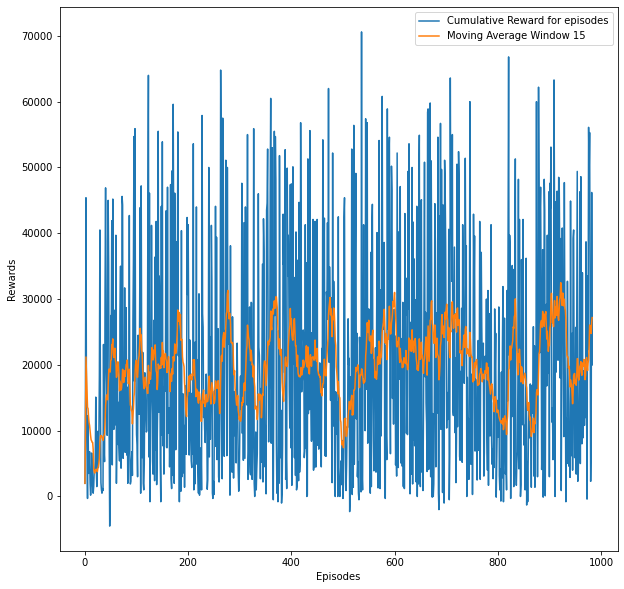

In [160]:
mach2 = Machine()
mach2.curr_state = 0
machine2 = Machine_env2(tm,r_func,mach2)
print(r_func)
baseline = StateValueNetwork(machine2.observation_space)
pol2 = policy_estimator(machine2)

#Hyper Parameters
episodes = 1000
gamma = 0.8
lr= 0.02


results = recurrent_pg_baseline_montecarlo(machine2,baseline,pol2,episodes,gamma,lr)
rewards = results[0]
actions = np.array(results[1])
states = results[2]

episode = [i for i in range(len(rewards))]

#Moving average we will use a window size of 50

moving_averages = []
window_size = 15

df = pd.DataFrame(rewards,columns = ['r'])
moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

fig = plt.figure(figsize=(10,10))
plt.plot(episode,rewards,label = 'Cumulative Reward for episodes')
plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

# CNN + LSTM

In [ ]:
import numpy
import torch

X = np.array([[2.1,2.3,5.3,6.4],[2.3,4.3,1.3,8.4],[1.1,9.3,5.3,0.4]])
# Y = np.random.randint(0, 9, 10).reshape(1, 1, -1)

class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=1, out_channels=20, kernel_size=3, stride=1,padding = "SAME")
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=20, out_channels=1, kernel_size=1,padding = 1)
        self.lstm = nn.LSTMCell(6,10)
        self.act2 = torch.nn.ReLU()
        self.layer3 = nn.Linear(10,2)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.layer1(x)
        print("First layer",x.shape)
        x = self.act1(x)
        
        x = self.layer2(x)

        print("CNN out", x.shape)
        output = []
        hx = torch.zeros(x.shape[1],10)
        cx = torch.zeros(x.shape[1],10)
        
        for i in range(x.size()[0]):
            hx, cx = self.lstm(x[i], (hx, cx))
            output.append(hx)
            
        output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        print(output,output.shape)
#         output = torch.reshape(output,(3,1,20))
#         print(output)
        
        x = self.layer3(output)
        print(x)
        log_probs = torch.nn.functional.softmax(x, dim=-1)

        return log_probs
print(X.shape, X)
model = Simple1DCNN()
y = model(torch.FloatTensor(X))
print(y.shape)
print(y)

In [84]:
class policy_estimator_cnn(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator_cnn, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=20, kernel_size=3, stride=1,padding='same')
        self.act1 = torch.nn.ReLU()
        
        self.lstm = nn.LSTMCell(env.observation_space,128)
        self.layer1 = nn.Linear(128,128)
        
        self.layer2 = nn.Linear(128,len(env.action_space))
       
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
        x = x.unsqueeze(1)
        #x = x.view(x.shape[0],1,x.shape[1])
        y = self.conv1(x)
        print("First layer",y.shape,y)
        y=torch.flatten(y)
        print("Second layer",y.shape,y)
        
        
#         output = []
#         hx = torch.zeros(1,128)
#         cx = torch.zeros(1,128)
        
#         if(len(x.size()) == 1): #single tensor ie. [x1,x2,x3,x4]
#             x = x.unsqueeze(0)
#             print(x)
#             hx, cx = self.lstm(x, (hx, cx))
#             output = hx
#             #print(output)

#         elif(len(x.size()) == 2): #2 dimension
#             x = x.view(x.shape[0],1,x.shape[1]) #dim = (timestep,batch,features), note batch = 1
#             print(x.size())
#             for i in range(x.size()[0]): #loop to simulate recurrent network
#                 #print(y)
#                 hx, cx = self.lstm(x[i], (hx, cx))
#                 output.append(hx)
        
#             output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        
#         x = F.leaky_relu(output)
#         x = self.layer1(x)
#         x  = F.relu(x)
#         x = self.layer2(x)

#         return F.softmax(x,dim = -1)



In [90]:
mach2 = Machine()
mach2.curr_state = 0
machine2 = Machine_env2(tm,r_func,mach2)
pol = policy_estimator_cnn(machine2)

In [91]:
obs = torch.FloatTensor([machine2.sensor().tolist() for _ in range(1)])

In [92]:
obs

tensor([[0.3247, 0.6606, 0.2173, 0.2105]])

In [93]:
pol(obs)

First layer torch.Size([1, 20, 4]) tensor([[[ 7.6099e-02,  2.9546e-02,  3.1339e-01,  8.5931e-02],
         [ 3.9020e-01,  3.1770e-01,  5.7777e-01,  3.9952e-01],
         [-6.0863e-01, -4.4184e-01, -6.3972e-01, -4.6411e-01],
         [-1.6539e-02, -3.5895e-01, -2.0156e-01, -1.6694e-01],
         [ 5.3777e-01,  5.1352e-01,  5.2622e-01,  3.0457e-01],
         [ 1.4817e-02, -1.9515e-01,  7.5209e-02, -1.8643e-01],
         [ 7.2343e-01,  6.1014e-01,  2.4416e-01,  3.9144e-01],
         [ 6.1179e-02, -3.3531e-01, -3.1355e-01, -3.0768e-01],
         [-8.0010e-02,  1.0305e-03, -2.0241e-01, -7.4860e-02],
         [-3.0407e-01, -3.5450e-01, -1.0912e-01, -3.6152e-01],
         [ 3.7852e-01,  3.4476e-01,  4.3663e-02,  6.9366e-02],
         [ 9.1935e-02,  4.0554e-02,  3.3532e-01,  2.9931e-01],
         [ 3.6390e-01,  2.2353e-01, -3.6148e-02,  1.8539e-01],
         [ 7.9875e-01,  4.7690e-01,  5.6508e-01,  4.7839e-01],
         [-7.0008e-02, -3.4832e-01, -2.4924e-01, -7.4064e-02],
         [-6.8923e-0

In [66]:
obs.shape

torch.Size([5, 4])